# KeyWord  뽑기

## 1 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

path = 'C:/Users/queenSSH/Desktop/github/webtoon-recommendation/data/'


web_combined = pd.read_csv(path + 'all-webtoons.csv')

#web_combined = pd.concat([naver, daum], axis=0, ignore_index=True)

### 데이터 합병

In [2]:
#web_combined = pd.concat([naver, daum, lezhin, kakao], axis=0, ignore_index=True)

## 2 Model 적용

문장 단위 분리 ( 텍스트 크롤링 > 문장 단위 분리 > 명사 추출 )

1. 문장 단위 분리

문장 단위로 분리하기 위해 함수 중 문장을 추출하는 sentences()라는 함수를 이용하여 문장을 분리한다. 

2. 명사 추출(POS -Tagging)

TF-IDF 모델을 만들기 위한 전처리 과정으로 문장으로 분리 한 뒤 문장을 형태소 단위로 나눈 후 품사 태깅을 통해 명사들만 추출
KoNLPy 중 Twitter를 이용하여 명사를 추출

### SentenceTokenizer Class

<텍스트 크롤링, 문장 단위 분리, 명사 추출> 과정을 SentenceTokenizer 클래스로 만든다.

아래의 코드에서 stopwords는 불용어로써 문장 내에서 내용을 나타내는데 의미를 가지지 않는 단어들의 집합을 의미한다.(stopwords는 사용 목적에 맞게 적절히 추가, 삭제)

text2sentences(text) : text(str)를 입력받아 Kkma.sentences()를 이용하여 문장단위로 나누어 준 후 senteces를 return 해 준다.

get_nouns(sentences) : sentences를 받아 Twitter.nouns()를 이용하여 명사를 추출한 뒤 nouns를 return해 준다.

In [3]:
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

class SentenceTokenizer(object):
    def __init__(self) -> None:
        self.kkma = Kkma()
        self.twitter = Twitter()
#         self.stopwords = ['중인', '만큼', '마찬가지', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가']
        self.stopwords = ['을', '를', '에', '의', '가','우리','저희','그녀', '때문', '때문에','갑자기','계속','전혀','그때','얼떨결']

    def text2sentences(self, text):
        sentences = self.kkma.sentences(text)
        for i in range(0, len(sentences)):
            if len(sentences[i]) <= 10:
                sentences[i - 1] += (' ' + sentences[i])
                sentences[i] = ''

        return sentences
    
    def get_nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            if sentence != '':
                nouns.append(' '.join([noun for noun in self.twitter.nouns(str(sentence)) if noun not in self.stopwords and len(noun) > 1]))

        return nouns

In [4]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
        self.graph_sentence = []
    
    def build_sent_graph(self, sentence):
        tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return self.graph_sentence
    
    def build_words_graph(self, sentence):
        cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

class Rank(object):
    def get_ranks(self, graph, d=0.85): # d = damping factor
        A = graph
        matrix_size = A.shape[0]

        for id in range(matrix_size):
            A[id, id] = 0 # diagonal 부분을 0으로
            link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
            
            if link_sum != 0:
                A[:, id] /= link_sum
            
            A[:, id] *= -d
            A[id, id] = 1
            
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

class TextRank(object):
    def __init__(self, text):
        self.sent_tokenize = SentenceTokenizer()
        self.sentences = self.sent_tokenize.text2sentences(text)
        self.nouns = self.sent_tokenize.get_nouns(self.sentences)
        self.graph_matrix = GraphMatrix()
        self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)
        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)
        self.word_rank_idx = self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)

    def keywords(self, word_num):
        rank = Rank()
        rank_idx = rank.get_ranks(self.words_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
        keywords = []
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
        return keywords


## 3 키워드 추출하기

### word_num = 3 일때

In [5]:
key_wordlist = []
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(web_combined['story'])):
    try :
        text = web_combined['story'][i]
        textrank = TextRank(text)
        print('keywords :', textrank.keywords(word_num=3))

        key_wordlist.append(textrank.keywords(word_num=3))
        
        if web_combined['platform'][i] == '네이버 웹툰':

            key_wordlist[i].append(web_combined['genre'][i].split(',')[1].strip())
            
        else:
            if web_combined['genre'][i] not in key_wordlist[i]:
                key_wordlist[i].append(web_combined['genre'][i])


    except:
        key_wordlist.append(web_combined['genre'][i])

keywords : ['부대', '마물', '전담']
keywords : ['게임', '고백', '마스터']
keywords : ['경주로', '대결', '운명']
keywords : ['사이']
keywords : ['권한', '모든', '암호']
keywords : ['가지', '능력', '반복']
keywords : ['성찬', '가족', '사건']
keywords : ['외면', '창궐', '극한']
keywords : ['뒷바라지', '목숨', '아들']
keywords : ['마약', '사냥', '코미디']
keywords : ['아빠', '대한', '동안']
keywords : ['사화', '인간', '신선']
keywords : ['정호', '자신', '아내']
keywords : ['용수', '비디오', '모금']
keywords : ['교생', '구원', '살인마']
keywords : ['순이', '고등학교', '과연']
keywords : ['귀신', '마피아게임', '시즌']
keywords : ['당신', '손님', '조향사']
keywords : ['문제', '정말', '기분']
keywords : ['전우치', '진의', '신입']
keywords : ['건물', '누명', '약품']
keywords : ['기억', '감방', '남자']
keywords : ['단편', '데드', '실험']
keywords : ['인생', '혼인', '금지']
keywords : ['황후', '결심', '나비']
keywords : ['당신', '무죄', '살인']
keywords : ['늑대', '대안', '뭉치']
keywords : ['다시', '동화', '복수']
keywords : ['거짓', '거짓말', '고교생']
keywords : ['소녀', '짐승', '떠돌이']
keywords : ['능력', '마음', '생활']
keywords : ['동안', '사랑', '재동']
keywords : ['아이', '기숙사', '대학교']
key

keywords : ['설계자', '살인', '소문']
keywords : ['술꾼', '신입생', '괴짜']
keywords : ['모든', '지금', '흉터']
keywords : ['미스터리', '불명', '야크']
keywords : ['약육강식', '언니', '여고']
keywords : ['만화', '작가']
keywords : ['취업', '함정', '관문']
keywords : ['사이코', '소시', '개월']
keywords : ['스스로', '절망', '고립']
keywords : ['누나', '마찬가지', '오빠']
keywords : ['사기꾼', '냉소', '사람']
keywords : ['선비', '방랑', '수험']
keywords : ['사춘기', '오직', '소개']
keywords : ['은진', '이상', '전생']
keywords : ['인간', '방정', '모습']
keywords : ['데이', '무엇', '여정']
keywords : ['일대기', '풀기', '물의']
keywords : ['등장', '신토', '어로']
keywords : ['마지막', '세상', '좀비']
keywords : ['저승사자', '정신']
keywords : ['무인도', '가족', '불명']
keywords : ['어시', '직장인', '출근']
keywords : ['시마', '인류', '정착']
keywords : ['시작', '위해', '엄마']
keywords : ['양궁', '격리', '구역']
keywords : ['강아지', '낯선', '목표']
keywords : ['화재', '과거', '기억']
keywords : ['이승', '미스터리', '저승']
keywords : ['경호원', '구슬', '루시퍼']
keywords : ['나기', '냄새', '누나']
keywords : ['시한', '검찰', '금붕어']
keywords : ['가요', '냄새', '보신']
keywords : ['동거', '라이프', '럭키

keywords : ['개그', '마음', '소리']
keywords : ['개그', '예술', '저주']
keywords : ['실존', '스푼', '영물']
keywords : ['유머', '추억', '만화']
keywords : ['당신', '대상', '언제']
keywords : ['갈등', '과거', '남자']
keywords : ['산촌', '공모전', '남고']
keywords : ['사건', '이야기', '중심']
keywords : ['고립', '가운데', '남자']
keywords : ['괴물', '달이', '사냥꾼']
keywords : ['가기', '기생', '사내']
keywords : ['일곱', '가장', '누굴']
keywords : ['이야기']
keywords : ['대한민국', '이야기', '장애인']
keywords : ['모험', '사의', '시작']
keywords : ['미래', '게임', '생각']
keywords : ['유부', '이야기']
keywords : ['시작', '허니문', '결혼']
keywords : ['사건', '개그', '라면']
keywords : ['공존', '능력', '비밀']
keywords : ['격투', '도로', '랜드']
keywords : ['가의', '기자', '로맨스']
keywords : ['기억', '당신']
keywords : ['사람']
keywords : ['가슴', '대학', '바로']
keywords : ['남자', '로맨스', '아슬아슬']
keywords : ['사랑', '금세', '남자에게']
keywords : ['고구마', '네이버', '독자']
keywords : ['동거', '아슬아슬', '유령']
keywords : ['소년', '남자', '스무']
keywords : ['세상', '소년', '장애인']
keywords : ['과거', '수상한', '싸움']
keywords : ['마법사', '대미', '문의']
keywords : ['그릇']
keyw

keywords : ['낭만', '대화', '디자이너']
keywords : ['고등학생', '공포증', '성장']
keywords : ['마왕', '이야기']
keywords : ['가출', '거짓말', '격전']
keywords : ['서울', '희수', '남산']
keywords : ['개발', '게임', '발랄']
keywords : ['중독', '학생', '대한민국']
keywords : ['말년', '방식', '이야기']
keywords : ['수사', '신작', '작가']
keywords : ['스포츠', '스페셜', '업데이트']
keywords : ['리아', '삼국지', '선율']
keywords : ['바로', '언제', '여행기']
keywords : ['외모', '작가', '감동']
keywords : ['사람', '무엇', '선의']
keywords : ['작가', '전설', '단편']
keywords : ['관계', '빵점', '시작']
keywords : ['인기', '출동', '네이버']
keywords : ['리메이크', '명작', '만화']
keywords : ['이의', '화랑', '꼭대기']
keywords : ['고등학교', '이야기', '친구']
keywords : ['불량', '건의', '먹잇감']
keywords : ['사랑', '열정', '커피']
keywords : ['러브', '레인저', '사연']
keywords : ['네이버', '단편', '멸망']
keywords : ['들판', '서로', '신화']
keywords : ['오늘', '지금', '당신']
keywords : ['평화', '만화', '본격']
keywords : ['이야기', '황당', '독립']
keywords : ['고등학생', '남매', '생명']
keywords : ['과연', '관리', '길이']
keywords : ['내일', '단편', '신작']
keywords : ['당선', '대가', '마법']
keywords : ['누군가'

keywords : ['상황', '각자', '개미']
keywords : ['일주일', '지시', '불명']
keywords : ['시선', '두려움', '시작']
keywords : ['주일', '축복', '나은']
keywords : ['소녀', '소리', '과연']
keywords : ['바로', '문구', '가게']
keywords : ['스토리', '라이프', '연애']
keywords : ['기억', '일상', '순간']
keywords : ['선배', '이용', '자신']
keywords : ['수상작', '최강', '건설']
keywords : ['아미', '물질', '바이러스']
keywords : ['몰래', '오해', '외모']
keywords : ['다른', '다시', '선택']
keywords : ['열녀', '연우', '납치']
keywords : ['사람', '성장', '순간']
keywords : ['지용', '위해', '지혜']
keywords : ['물건', '경계', '세상']
keywords : ['과연', '마음껏', '럭셔리']
keywords : ['돌변', '비밀', '둥이']
keywords : ['마을', '요괴', '일지']
keywords : ['삼촌', '가족', '그것']
keywords : ['연쇄', '할머니', '노인']
keywords : ['민호', '게임', '러너']
keywords : ['광고', '냉혈', '시장']
keywords : ['사랑', '여주', '역할']
keywords : ['대표', '데뷔', '만취']
keywords : ['고등학생', '다른', '자신']
keywords : ['기생', '위기', '필터']
keywords : ['경호', '가족', '고백']
keywords : ['왕자', '시작', '마녀']
keywords : ['하우스', '셰어', '스무']
keywords : ['유림', '언제', '흡혈']
keywords : ['감수성', '다른', '비

keywords : ['공주', '기록', '비밀']
keywords : ['대가', '사과나무', '아이']
keywords : ['학교', '초능력', '학년']
keywords : ['라면', '세상', '소경']
keywords : ['마을', '스승', '신윤복']
keywords : ['나래', '매진', '방황']
keywords : ['좇는', '축구', '드라마']
keywords : ['떼돈', '발견', '비밀']
keywords : ['기억', '라이벌', '로맨스']
keywords : ['다른', '백사', '이름']
keywords : ['열렙', '동료', '드벤']
keywords : ['가족', '고향', '비행기']
keywords : ['인터넷', '시작', '수희']
keywords : ['신들', '인류', '이번']
keywords : ['가을', '그룹', '동경']
keywords : ['만인', '반쪽', '신수']
keywords : ['가공', '교육', '마령']
keywords : ['서울', '연우', '불명']
keywords : ['부활', '시작', '파괴']
keywords : ['기고', '내기', '여주']
keywords : ['몰래', '실명', '익명']
keywords : ['남자', '화장', '세상']
keywords : ['계약', '관리', '독점']
keywords : ['조석', '행성', '개념']
keywords : ['마음', '나니', '발신']
keywords : ['마법사', '지오']
keywords : ['야식', '셰프', '시작']
keywords : ['시작', '무인도', '다섯']
keywords : ['아카데미', '명령', '복학']
keywords : ['로맨스', '아래', '연꽃']
keywords : ['영은', '정의', '사법부']
keywords : ['고등학생', '미수', '범인']
keywords : ['다이스', '굴리', '신체'

keywords : ['대학교', '달리', '로맨스']
keywords : ['고등학생']
keywords : ['남북', '상치', '위기']
keywords : ['공격', '생명체', '소녀']
keywords : ['문제', '세상', '이건']
keywords : ['개장', '동물', '동물원']
keywords : ['가슴', '로맨스', '시대극']
keywords : ['눈빛', '아이']
keywords : ['유령', '천재', '귀신']
keywords : ['뷰티', '크리', '관심']
keywords : ['기회', '남녀', '눈앞']
keywords : ['어린이', '예술가', '욕망']
keywords : ['오늘', '혹시']
keywords : ['시대', '몸부림', '시작']
keywords : ['끼리', '밌으', '세상']
keywords : ['세계', '승은', '후궁']
keywords : ['남녀', '사고', '안개']
keywords : ['가장', '다른', '자신']
keywords : ['궁합', '다른', '성격']
keywords : ['남자', '십년', '외출']
keywords : ['공인', '데뷔', '사건']
keywords : ['액션', '코믹', '간의']
keywords : ['껍데기', '도하', '성형']
keywords : ['매몰', '발신', '전화']
keywords : ['등골', '기어', '벌레']
keywords : ['남자', '라이프', '서울']
keywords : ['대판', '대하', '심층']
keywords : ['규칙', '노인', '매우']
keywords : ['소녀', '이야기', '태생']
keywords : ['악연', '유기한', '남자']
keywords : ['다시', '스무', '오기']
keywords : ['내게로', '가가', '여신']
keywords : ['아이', '유치원', '일상']
keywords : ['기억',

keywords : ['사람', '오늘', '흰둥이']
keywords : ['도사', '바로', '제대로']
keywords : ['군복무', '발표', '시대']
keywords : ['생활', '스타일', '어택']
keywords : ['대체', '사건', '악당']
keywords : ['고등학생', '시절', '위기']
keywords : ['가치', '만물', '무료']
keywords : ['미남', '동물', '심리학자']
keywords : ['싱글', '이로', '이야기']
keywords : ['남자', '사투', '시작']
keywords : ['국제', '스릴러', '정치']
keywords : ['가게', '강풀', '미스']
keywords : ['사람', '이야기', '커피']
keywords : ['기억', '시간']
keywords : ['이후', '고뇌', '일상']
keywords : ['기회', '솔로', '탈출기']
keywords : ['계란', '괴담', '만화']
keywords : ['사람', '이유', '지구']
keywords : ['감각', '드비', '복귀']
keywords : ['레이어', '감성', '시공']
keywords : ['당신', '보고', '사랑']
keywords : ['대망', '뒤엉킨', '분노']
keywords : ['동거', '거울', '모습']
keywords : ['다시', '감동', '시리즈']
keywords : ['속옷', '위해', '현실']
keywords : ['사람', '사랑', '이야기']
keywords : ['남자', '가득', '바다']
keywords : ['소녀', '이야기', '기네스']
keywords : ['그것', '종말']
keywords : ['이야기', '인생', '커피']
keywords : ['섭취', '발휘', '음식']
keywords : ['결합', '가족', '비만']
keywords : ['이야기', '커피', '하루']
ke

keywords : ['선택', '어디', '인생']
keywords : ['중국', '청춘', '목숨']
keywords : ['당신', '사랑', '지금']
keywords : ['소년', '대한', '유가']
keywords : ['씨앗']
keywords : ['민트', '사탕', '오기']
keywords : ['가득', '레스토랑', '배경']
keywords : ['세계', '지금', '다른']
keywords : ['모험', '아이', '이야기']
keywords : ['다시', '바람결']
keywords : ['요정', '육성', '투기']
keywords : ['드라마', '성장', '아버지']
keywords : ['댄스', '만화', '본격']
keywords : ['상상', '개막', '시즌']
keywords : ['남자', '사랑', '여정']
keywords : ['성장기', '소녀']
keywords : ['광해', '공포', '만화']
keywords : ['로부터', '신작', '작가']
keywords : ['과연', '사건', '실마리']
keywords : ['낯선', '만난', '세계']
keywords : ['단편', '괴기', '만화']
keywords : ['복통', '스포츠', '실버']
keywords : ['이야기', '선생님', '좌충우돌']
keywords : ['만화', '명랑', '모든']
keywords : ['게임', '동화', '미래']
keywords : ['간의', '기다림', '시작']
keywords : ['강철', '만화', '본격']
keywords : ['동화', '바위', '위해']
keywords : ['무한', '개그', '본능']
keywords : ['목숨', '모두', '발발']
keywords : ['기억', '노숙자', '만난']
keywords : ['보험', '이제', '사랑']
keywords : ['망상', '낯선', '소녀']
keywords : ['위기', 

keywords : ['무인', '마련', '무참']
keywords : ['일진', '마이', '사진']
keywords : ['조준', '여의', '사기']
keywords : ['판타지', '세계', '마왕']
keywords : ['신혜', '남편', '마음']
keywords : ['결혼', '남자', '후배']
keywords : ['로미오', '사고', '시작']
keywords : ['후궁', '황제', '예서']
keywords : ['리스', '상처', '황제']
keywords : ['유미란', '자신', '세미']
keywords : ['마야', '만두', '고로']
keywords : ['주인공', '게임', '기행']
keywords : ['무도', '바다', '재능']
keywords : ['개그', '나이', '서른']
keywords : ['나비', '남자', '동시']
keywords : ['당신', '사랑', '소녀']
keywords : ['고려', '중원', '가장']
keywords : ['당신', '현준', '재능']
keywords : ['사기', '시작', '공작']
keywords : ['위해', '황제', '아버지']
keywords : ['주인공', '레인', '시스']
keywords : ['캐릭터', '제자', '고작']
keywords : ['스텔라', '리프', '성녀']
keywords : ['시작', '인간', '트러블']
keywords : ['모두', '반역', '신의']
keywords : ['오도', '졸업', '마법사']
keywords : ['사월', '사랑', '과연']
keywords : ['가보', '약혼녀', '위해']
keywords : ['영애', '영웅', '가문']
keywords : ['고등학생', '구미호', '고등학교']
keywords : ['시온', '쓰레기', '미남']
keywords : ['실력', '동생', '목숨']
keywords : ['서원', '이환',

keywords : ['누가', '낙원', '복수']
keywords : ['뜻밖', '복수', '운명']
keywords : ['사대', '천왕', '법칙']
keywords : ['미남', '가지', '게임']
keywords : ['무장', '뒤엎', '수요일']
keywords : ['레벨', '혼자', '각성']
keywords : ['기회', '절망', '다시']
keywords : ['공작', '아가씨', '엘리자베스']
keywords : ['정복', '모든', '생명']
keywords : ['주인', '대마도', '마도']
keywords : ['얼음', '가지', '마법']
keywords : ['만끽', '세상', '식사']
keywords : ['강호', '화원', '미소녀']
keywords : ['그로', '윤재', '세상']
keywords : ['서진', '진운', '경지']
keywords : ['꼬마', '판타지', '로맨스']
keywords : ['악역', '소설', '나니']
keywords : ['대회', '에이', '폭투']
keywords : ['백륜', '입학', '강신']
keywords : ['서비스', '엔딩', '오직']
keywords : ['토끼', '부자', '루프']
keywords : ['그나', '클래스', '마법사']
keywords : ['할아버지', '보로', '상황']
keywords : ['구매', '라이프', '눈치']
keywords : ['개인', '방송', '소리']
keywords : ['사람', '전생', '넷째']
keywords : ['모두', '머리', '번만']
keywords : ['비아', '사람', '마감']
keywords : ['학원', '미술', '원장']
keywords : ['교수', '고백', '노예']
keywords : ['황제', '반역', '복수']
keywords : ['생명', '거리', '병기']
keywords : ['세계', '원래', '

keywords : ['이재', '생각', '잠시']
keywords : ['사람', '알바생', '괴롭힘']
keywords : ['에너지', '아지', '흡수']
keywords : ['승아', '공모전', '서진']
keywords : ['이산', '낭인', '작가']
keywords : ['공녀', '우주', '수나']
keywords : ['결혼', '마리', '남자']
keywords : ['무술', '자신', '바이오']
keywords : ['레이크', '열등생', '프레이']
keywords : ['가문', '소설', '악역']
keywords : ['에이', '강수', '동전']
keywords : ['주인공', '시작', '소설']
keywords : ['가지', '고교', '생활']
keywords : ['연하', '러브', '로맨스']
keywords : ['결혼', '레이드', '살인']
keywords : ['부인', '사랑', '시작']
keywords : ['만인', '머리', '고아']
keywords : ['악녀', '진짜', '머리']
keywords : ['주먹', '주먹질', '신화']
keywords : ['원영', '연애', '도희']
keywords : ['세계', '새벽', '괴물']
keywords : ['공작', '여인', '약혼']
keywords : ['공주', '헬라', '서로']
keywords : ['생존', '무인도', '현대']
keywords : ['무림', '태경', '접속']
keywords : ['과연', '모용', '미래']
keywords : ['오르페', '누구', '미아']
keywords : ['의문', '무기', '배후']
keywords : ['역사', '서원', '나이']
keywords : ['연승', '수련', '성좌']
keywords : ['아빠', '소설', '마법사']
keywords : ['대군', '사랑', '천기']
keywords : ['건국', '나선', '

keywords : ['싸움', '이름', '주지']
keywords : ['사람', '상처', '부인']
keywords : ['카르', '완전', '등장']
keywords : ['거부', '드래곤', '라이']
keywords : ['리다', '메이크업', '고급']
keywords : ['다시', '번의', '사랑']
keywords : ['호수', '가수', '등장']
keywords : ['라면', '하루', '한번']
keywords : ['불행', '이언', '교사']
keywords : ['이드', '펠릭스', '공작']
keywords : ['채린', '강우', '반대']
keywords : ['나날', '도망', '러드']
keywords : ['붕도', '희진', '가상']
keywords : ['내시', '게임', '거세']
keywords : ['하성', '미션', '위기']
keywords : ['랭크', '마법', '에어']
keywords : ['짝사랑', '마음', '고백']
keywords : ['최고', '할아버지', '대학']
keywords : ['거짓', '구성', '기억']
keywords : ['전쟁', '간섭', '국익']
keywords : ['철칙', '윤주', '남녀']
keywords : ['려준', '아이', '러버']
keywords : ['미래', '멸망', '세계']
keywords : ['작품', '풍파', '강호']
keywords : ['영기', '거기', '로부터']
keywords : ['하나', '청춘', '주먹']
keywords : ['성우', '손님', '대학']
keywords : ['그냥', '마누라', '지지']
keywords : ['개정판', '작품', '백련']
keywords : ['수용', '학산', '화사']
keywords : ['국내', '단숨', '라이']
keywords : ['사무실', '심부름', '과연']
keywords : ['개정판', '구성', '대포

keywords : ['제국', '국립', '반드시']
keywords : ['작품', '전화위복', '개정판']
keywords : ['중전', '자리', '하나']
keywords : ['마음', '여자', '무열']
keywords : ['황제', '온수', '사약']
keywords : ['공간', '술사', '레나']
keywords : ['이제', '인생', '지고']
keywords : ['이제', '차야', '차지']
keywords : ['과거', '그룹', '매니저']
keywords : ['글자', '불명', '수상한']
keywords : ['개정판', '작품', '도시']
keywords : ['사건', '조사', '발견']
keywords : ['출산', '목숨', '위험']
keywords : ['박동하', '발랄', '뱀파이어']
keywords : ['왕자', '공주', '장가']
keywords : ['개정판', '결혼', '기억']
keywords : ['강호', '개정판', '다정']
keywords : ['구주', '무적', '원제']
keywords : ['게임', '드라마', '라이어']
keywords : ['담당', '목격', '사건']
keywords : ['가로', '세로', '시간']
keywords : ['과연', '남해', '시샘']
keywords : ['애인', '회사', '최수']
keywords : ['매혹', '비밀', '반지']
keywords : ['유림', '공개', '구혼']
keywords : ['구천', '기상', '무림']
keywords : ['강아지', '인간', '해피']
keywords : ['잠룡', '개정판', '구성']
keywords : ['개정판', '대협', '북풍']
keywords : ['여자', '나이', '가야']
keywords : ['인간', '후손', '웅녀']
keywords : ['가문', '나라', '문장']
keywords : ['비서', '그룹',

keywords : ['정도', '화보', '고스']
keywords : ['살인', '은밀', '인터뷰']
keywords : ['동생', '교황', '진실']
keywords : ['결혼', '가슴', '개정판']
keywords : ['마코토', '언니', '고민']
keywords : ['마리아', '엑소', '메리']
keywords : ['우경', '스트리머', '거지']
keywords : ['결말', '상황', '여자']
keywords : ['사람', '일이', '하룻밤']
keywords : ['로맨스', '무당', '사기']
keywords : ['로맨스', '아악', '마치']
keywords : ['태극', '근원', '도구']
keywords : ['기회', '개정판', '교육']
keywords : ['비밀', '공주', '누가']
keywords : ['명작', '베스트', '개정판']
keywords : ['수족', '인간', '변질']
keywords : ['김철수', '아픔', '쓰레기']
keywords : ['달님', '동생', '호유']
keywords : ['일지', '작품', '개정판']
keywords : ['회사', '키스', '남자친구']
keywords : ['위해', '로서', '지현']
keywords : ['여인', '악연', '남자']
keywords : ['작품', '개정판', '광명']
keywords : ['만류', '무적', '개방']
keywords : ['세계', '소년', '마법']
keywords : ['황제', '친구', '후궁']
keywords : ['황제', '기사단', '기사']
keywords : ['건어물', '남동생', '로맨스']
keywords : ['짝사랑', '기회', '모교']
keywords : ['눈동자', '개정판', '라성']
keywords : ['야만', '세계', '이기']
keywords : ['인간', '커플', '당신']
keywords : ['가게

keywords : ['이야기', '주인공', '독자']
keywords : ['사랑', '외모', '소녀']
keywords : ['단서', '미스터리', '분투']
keywords : ['인간', '괴물', '과거']
keywords : ['지게', '카페', '아르바이트']
keywords : ['검도', '금지', '마는']
keywords : ['가수', '개싸움', '라이벌']
keywords : ['누군가', '아내', '내연']
keywords : ['노여움', '발렌타인', '연민']
keywords : ['결심', '백설', '라지']
keywords : ['기사', '심부름', '후작']
keywords : ['분명', '사랑', '라면']
keywords : ['고백', '다리', '선생님']
keywords : ['사랑', '상처', '과거']
keywords : ['가수', '부모님', '남자']
keywords : ['로맨스', '맥시', '목숨']
keywords : ['부탁', '이용', '참고']
keywords : ['점원', '실수', '고등학교']
keywords : ['가지', '목적', '손님']
keywords : ['뭉치', '신자', '라면']
keywords : ['귀족', '어머니', '본적']
keywords : ['게임', '대상', '러브']
keywords : ['동생', '달라', '장소']
keywords : ['뮤직', '스타', '절정']
keywords : ['아이', '천계', '천사']
keywords : ['교실', '동경', '발견']
keywords : ['사랑', '외모', '사회인']
keywords : ['희진', '고등학교', '동아리']
keywords : ['계기', '계심', '고슴도치']
keywords : ['대상', '프린스', '고등학생']
keywords : ['미술관', '음악원', '알바']
keywords : ['결혼', '부부', '가짜']
keywords 

keywords : ['키스', '중이', '시마']
keywords : ['사치', '고교생', '라이']
keywords : ['퇴치', '하늘', '달빛']
keywords : ['남자', '만난', '슬립']
keywords : ['사랑', '가세', '남자']
keywords : ['카나', '나날', '미련']
keywords : ['생활', '퇴학', '학교']
keywords : ['소꿉친구', '녀석', '매번']
keywords : ['살짝', '소꿉친구', '이츠키']
keywords : ['이치', '일류', '능력']
keywords : ['성격', '결혼', '도전']
keywords : ['사랑', '사람', '선생님']
keywords : ['고리대금업', '무사', '미남']
keywords : ['가득', '소꿉친구', '남성']
keywords : ['남자', '남친', '여자']
keywords : ['이기', '장안', '재주']
keywords : ['녀석', '문제', '불량']
keywords : ['다른', '단편', '작가']
keywords : ['실력', '외모', '연예인']
keywords : ['가장', '미남', '인기']
keywords : ['사진', '도리', '요코']
keywords : ['왕국', '주인', '평판']
keywords : ['모습', '사람', '사실']
keywords : ['소마', '살림', '생활']
keywords : ['복수', '속임수', '식도']
keywords : ['기필코', '나이', '대로']
keywords : ['남자', '대한민국', '매니저']
keywords : ['결혼', '결혼식', '공주']
keywords : ['결심', '고등학생', '남자']
keywords : ['남자', '만난', '사쿠']
keywords : ['사람', '아리', '웨딩']
keywords : ['고등학교', '고향', '부모님']
keywords : ['사실'

keywords : ['첫사랑', '하나', '다른']
keywords : ['대학교', '눈앞', '상경']
keywords : ['경험', '공부', '과외']
keywords : ['공부', '미소녀', '동생']
keywords : ['노시', '레스토랑', '셰프']
keywords : ['세상', '운영', '인간']
keywords : ['경험', '관능', '나날']
keywords : ['동거', '형제', '가정']
keywords : ['부탁', '이용', '참고']
keywords : ['재민', '니야', '사람']
keywords : ['부탁', '엄마', '여의고']
keywords : ['남자', '남자친구', '목격']
keywords : ['가장', '부업', '비밀']
keywords : ['오빠', '여동생', '미인']
keywords : ['왕자', '메이', '아침']
keywords : ['개그', '공존', '드라마']
keywords : ['남자', '낯선', '설화']
keywords : ['유니콘', '나날', '나라']
keywords : ['부업', '미남', '미로']
keywords : ['광기', '명의', '스토커']
keywords : ['하루', '초대', '판타지']
keywords : ['아이', '하루', '오늘']
keywords : ['남자', '미즈', '남장']
keywords : ['사랑', '종지부', '과자']
keywords : ['고민', '만사', '부정']
keywords : ['남쪽', '남편', '돌싱']
keywords : ['사랑', '메이드', '연예']
keywords : ['결혼', '최후', '스즈키']
keywords : ['구해', '달라', '마녀']
keywords : ['나나', '모리', '치마']
keywords : ['재벌', '가의', '거주']
keywords : ['담당', '밴드', '사운드']
keywords : ['재상', '로맨스'

keywords : ['선물', '결혼', '고가']
keywords : ['이어진', '과정', '노무']
keywords : ['그동안', '능력', '상대']
keywords : ['미래', '적대', '미사일']
keywords : ['운명', '낭군', '다시']
keywords : ['그냥', '데이', '사람']
keywords : ['상경', '시골', '안고']
keywords : ['둘째', '복의', '불운']
keywords : ['아들', '겨울', '교환']
keywords : ['손자', '연애', '게임']
keywords : ['바로', '아파트', '그것']
keywords : ['모처럼', '얼굴', '이름']
keywords : ['표정', '필요', '시인']
keywords : ['마음', '전의', '생인']
keywords : ['친구', '세례명', '본명']
keywords : ['생각', '녀석', '인기']
keywords : ['여자', '광기', '자신']
keywords : ['보디가드', '도무지', '도착']
keywords : ['남자', '모두', '모든']
keywords : ['고난', '모야', '사인']
keywords : ['새미', '샴푸', '감고']
keywords : ['번지', '시작', '감정']
keywords : ['딸기', '낙서', '만화가']
keywords : ['듀크', '능력', '영적']
keywords : ['네스', '데이', '미래']
keywords : ['사건', '여진', '과연']
keywords : ['구애', '규율', '모두']
keywords : ['모란', '여자친구', '위해']
keywords : ['영국', '화초', '교양']
keywords : ['경호', '누명', '보디가드']
keywords : ['기다림', '로써', '시작']
keywords : ['무도', '보지', '선생님']
keywords : ['구해', '무용', 

keywords : ['아드', '이름', '인생']
keywords : ['드래곤', '관리인', '몬스터']
keywords : ['민호', '강우혁', '다른']
keywords : ['마나', '기후', '동안']
keywords : ['레벨', '모험가', '몹시']
keywords : ['그것', '극복', '범인']
keywords : ['갑작스레', '낯선', '모습']
keywords : ['고향', '마나', '보석']
keywords : ['무사', '모든', '세상']
keywords : ['공주', '남자', '동안']
keywords : ['가정', '개막', '여기']
keywords : ['마모루', '소녀', '안부']
keywords : ['남자', '결혼', '러브']
keywords : ['문의', '전생', '천당']
keywords : ['바다', '생활', '성장']
keywords : ['과거', '귀신', '마사']
keywords : ['시로', '결정', '랭크']
keywords : ['개월', '게다가', '그것']
keywords : ['마왕', '신전', '에일']
keywords : ['인간계', '마왕', '무용담']
keywords : ['게다가', '사냥꾼', '다시']
keywords : ['고등학교', '서도', '둘리']
keywords : ['소녀', '세상', '앨리스']
keywords : ['감각', '고교야구', '만화']
keywords : ['공주', '유폐', '인간']
keywords : ['능력', '만물상', '물건']
keywords : ['충전', '괄시', '금액']
keywords : ['수도', '앨리스', '감옥']
keywords : ['수희', '교회', '선배']
keywords : ['공포', '거리', '고교']
keywords : ['로마', '마녀', '마리']
keywords : ['관장', '사망', '도전']
keywords : ['가입', '삼

keywords : ['가기', '가계', '가문']
keywords : ['남매', '나인', '서로']
keywords : ['마도', '러브', '무슨']
keywords : ['로라', '얼굴', '여우로']
keywords : ['격변', '고향', '산란']
keywords : ['숭배', '야수', '남자']
keywords : ['마법', '나라', '대국']
keywords : ['복절', '외계인', '지구']
keywords : ['남자', '무한', '소망']
keywords : ['다른', '모래', '절대로']
keywords : ['세계', '요괴', '세상']
keywords : ['마도', '게임', '대로']
keywords : ['로서', '가드', '사건']
keywords : ['마사', '무대', '산요']
keywords : ['남자', '대신', '식칼']
keywords : ['기량', '수저', '강철']
keywords : ['마왕', '아르', '명령']
keywords : ['자신', '조연', '차려']
keywords : ['불행', '고향', '소녀']
keywords : ['계약', '배틀', '시로']
keywords : ['로맨스', '섹시', '연하']
keywords : ['미식', '개막', '밥상']
keywords : ['사랑', '여인', '운명']
keywords : ['목숨', '사람', '이야기']
keywords : ['레스토랑', '고교생', '마미야']
keywords : ['나라', '남동생', '다툼']
keywords : ['요리', '등부', '츠하']
keywords : ['하늘', '반세기', '각국']
keywords : ['냄새', '먹보', '모습']
keywords : ['옥집', '일상', '자신']
keywords : ['미소년', '계약', '로서']
keywords : ['리기', '지금', '사람']
keywords : ['무능', '문지기', '성의

keywords : ['안고', '기억', '능력']
keywords : ['직장', '돌연', '수상']
keywords : ['동안', '러시아', '로마노']
keywords : ['경이', '만화', '보유']
keywords : ['아내', '여원', '결합']
keywords : ['생활', '도전', '동료']
keywords : ['민호', '선생님', '아이']
keywords : ['부정', '의문사', '인과']
keywords : ['농담', '연출', '상상력']
keywords : ['황천', '운명', '인간']
keywords : ['기업', '결심', '괴한']
keywords : ['모래', '모험', '소원']
keywords : ['세계', '액션', '음모']
keywords : ['괴물', '소설가', '감당']
keywords : ['나비', '사랑', '생명']
keywords : ['시대', '매우', '신들']
keywords : ['운명', '정복', '차라리']
keywords : ['민정', '박사', '보호']
keywords : ['사랑', '과학', '그것']
keywords : ['스포츠', '아기', '고교생']
keywords : ['영혼', '백수', '싸이코']
keywords : ['가기', '마을', '무녀']
keywords : ['선택', '일상', '천사']
keywords : ['가면', '가슴', '눈물']
keywords : ['개그', '나사', '만화']
keywords : ['시절', '강호', '고등학교']
keywords : ['맑은', '오빠', '오늘']
keywords : ['고립', '대립', '마을']
keywords : ['매력', '소설가', '조카']
keywords : ['동료', '사랑', '생활']
keywords : ['극찬', '껍질', '낱낱이']
keywords : ['부부', '복통', '신혼']
keywords : ['가출', '김기범', '

keywords : ['야구', '마구', '부가']
keywords : ['밸런스', '세근', '신기원']
keywords : ['메이', '자식', '겉도']
keywords : ['위해', '후계', '가게']
keywords : ['사건', '스승', '온갖']
keywords : ['청춘', '컬러', '성장기']
keywords : ['감동', '개인', '극장']
keywords : ['발생', '자신', '생각']
keywords : ['미소', '치과', '진아']
keywords : ['요괴', '계약서', '고독']
keywords : ['교육', '담임', '문제']
keywords : ['가정', '단둘', '과목']
keywords : ['부의', '기숙사', '남자']
keywords : ['아파트', '수면', '점차']
keywords : ['부원', '야구', '고시엔']
keywords : ['복제', '건전', '검거']
keywords : ['생태', '한혜연', '가득']
keywords : ['개막', '불량', '근성']
keywords : ['모네', '나루', '별난']
keywords : ['최근', '친구', '나이']
keywords : ['결심', '시작', '부탁']
keywords : ['바쿠', '블러', '남자']
keywords : ['소리', '그날', '내지']
keywords : ['권리', '새끼', '어른']
keywords : ['소녀', '유괴', '행복']
keywords : ['마나', '사쿠라', '식당']
keywords : ['약혼녀', '중학생', '멋대로']
keywords : ['결정', '고민', '햄스터']
keywords : ['결심', '대국', '소녀']
keywords : ['사랑', '상대', '관심']
keywords : ['마물', '욕망', '인간']
keywords : ['요리', '눈매', '관광지']
keywords : ['누구', '끄덕', '남

keywords : ['이혼', '당장', '당한']
keywords : ['동인지', '영향', '판매']
keywords : ['슈퍼', '아버지', '이야기']
keywords : ['부정', '시작', '아이']
keywords : ['이제', '자네', '국내']
keywords : ['과연', '무엇', '안식처']
keywords : ['미션', '상금', '간지']
keywords : ['사실', '인간', '미래']
keywords : ['불만', '여자', '운영']
keywords : ['공포', '바탕', '실화']
keywords : ['고스', '러스트', '레이']
keywords : ['악몽', '혼란', '기억']
keywords : ['거기', '볼일', '남자']
keywords : ['교수', '백화점', '생일']
keywords : ['나라', '블레', '시작']
keywords : ['강제', '게임', '명의']
keywords : ['기타', '인형', '작가']
keywords : ['매니저', '무대', '환상']
keywords : ['이의', '창수', '형사']
keywords : ['게임', '성형', '진화']
keywords : ['사람', '경력', '바보']
keywords : ['대학', '마음', '숨기']
keywords : ['당신', '위해', '인생']
keywords : ['방식', '사랑', '식당']
keywords : ['교차', '대적', '본격']
keywords : ['기억', '마가렛', '구해']
keywords : ['생활', '스쿨', '시작']
keywords : ['모습', '해성', '맨발']
keywords : ['고양이', '모두', '사실']
keywords : ['메이', '애니', '변동']
keywords : ['견실', '구입', '모델하우스']
keywords : ['사연', '장소', '전부']
keywords : ['갈림길', '계약', '그룹

keywords : ['그린', '드라마', '버스']
keywords : ['예비', '친구', '편집']
keywords : ['일본', '화가', '김홍도']
keywords : ['대해', '건축가', '도움']
keywords : ['결코', '사랑', '모리']
keywords : ['남아', '소녀', '비애']
keywords : ['편의점', '디스', '마을']
keywords : ['궁극', '사시', '문제']
keywords : ['일본', '극약', '미래']
keywords : ['라이프', '등장', '삼촌']
keywords : ['야구', '만화', '경기']
keywords : ['로부터', '상대', '생활']
keywords : ['아이', '이치', '맞선']
keywords : ['미가', '세상', '숙명']
keywords : ['런던', '서로', '시절']
keywords : ['고민', '막내', '다른']
keywords : ['운동', '게다가', '궁도']
keywords : ['교복', '그날', '로부터']
keywords : ['선택', '멀리', '미야케']
keywords : ['가지', '실생활', '마루']
keywords : ['나름', '아키타', '중년']
keywords : ['나래', '가게', '제안']
keywords : ['사리', '날개', '천사']
keywords : ['고양이', '생각']
keywords : ['꽃차', '누나', '다니엘']
keywords : ['가지', '고대', '당신']
keywords : ['귓불', '로맨틱', '부분']
keywords : ['성격', '사랑', '오피스']
keywords : ['브라질', '폐부', '축구']
keywords : ['범인', '탐정', '린다']
keywords : ['수도']
keywords : ['분명', '자신', '생가']
keywords : ['본적', '여행', '적도']
keywords : [

keywords : ['규연', '다른', '여자']
keywords : ['숨기', '주역', '통일']
keywords : ['성인', '개정판', '버전']
keywords : ['대가', '모자', '실수']
keywords : ['군대장', '국왕', '그것']
keywords : ['슬럼프', '자신', '사랑']
keywords : ['기자', '무참', '부탁']
keywords : ['천년', '당신', '사람']
keywords : ['얼굴', '레이', '매번']
keywords : ['사부', '생명', '손길']
keywords : ['누군가', '로부터', '위해']
keywords : ['다정', '대물', '사랑']
keywords : ['멤버', '사실', '성격']
keywords : ['카페', '대학생', '손님']
keywords : ['생각', '이서', '인간']
keywords : ['변화', '마츠오', '유우']
keywords : ['남자에게', '데뷔', '라이']
keywords : ['감정', '남자', '사람']
keywords : ['천사', '깃털', '루시펠']
keywords : ['장회', '재물', '좌천']
keywords : ['현수', '서점', '유명']
keywords : ['성우', '손님', '꽃집']
keywords : ['게임', '비밀', '대학생']
keywords : ['사랑', '후배', '라며']
keywords : ['태인', '태국', '대학']
keywords : ['고래', '등장', '뭉치']
keywords : ['희수', '시오', '아무']
keywords : ['시안', '등장', '어디']
keywords : ['친구', '약속', '분위기']
keywords : ['게임', '부터', '비성']
keywords : ['관계', '다시', '인사']
keywords : ['이상형', '화장실', '다시']
keywords : ['희재', '감시', '공

keywords : ['강제', '모리', '대회']
keywords : ['가호', '스즈키', '능력자']
keywords : ['공부', '모습', '보영']
keywords : ['고등학생', '마음씨', '지수']
keywords : ['게이', '고백', '누구']
keywords : ['나츠가미', '대학생', '만난']
keywords : ['베니', '고아', '사람']
keywords : ['게이', '사람', '점점']
keywords : ['기대', '마음속', '우등']
keywords : ['유한', '태연', '동맹']
keywords : ['케이', '마음', '사람']
keywords : ['시험', '소환', '유진']
keywords : ['사고', '사람', '서로']
keywords : ['눈빛', '대체', '여자']
keywords : ['기숙사', '대학', '매사']
keywords : ['비밀', '민완', '센트']
keywords : ['꼼짝', '나머지', '놀란']
keywords : ['남자', '마피아', '사관학교']
keywords : ['대화', '동물', '모습']
keywords : ['감정', '누군가', '게이']
keywords : ['하야', '동경', '복종']
keywords : ['간다', '만남', '모든']
keywords : ['반한', '백치', '인기']
keywords : ['이즈', '마사', '소년']
keywords : ['계기', '공통점', '남자']
keywords : ['고고학', '새우등', '선생']
keywords : ['무엇', '역시', '부인']
keywords : ['나무', '남자', '정글']
keywords : ['소설', '고전', '구입']
keywords : ['기만', '능력', '악마']
keywords : ['사람', '우등', '샤이']
keywords : ['아이', '미즈', '나노']
keywords : ['지인', '해외'

keywords : ['소년', '광석', '눈동자']
keywords : ['어째서', '거지', '누구']
keywords : ['미나미', '골수', '변태']
keywords : ['세이', '다음', '사랑']
keywords : ['최현', '각종', '개월']
keywords : ['풍기', '마지막', '사쿠라']
keywords : ['상가', '여름', '가득']
keywords : ['룸메이트', '마노', '아키라']
keywords : ['대학', '할아버지', '다이스케']
keywords : ['스노', '모범생', '비밀']
keywords : ['유령', '대학', '생활']
keywords : ['경영', '도서관', '할머니']
keywords : ['평소', '도시', '마음']
keywords : ['키스', '경험', '연애']
keywords : ['하야', '유우', '사람인']
keywords : ['누나', '만반', '배우']
keywords : ['도우', '마법', '사이']
keywords : ['계기', '고등학생', '남자']
keywords : ['계단', '동물', '발정기']
keywords : ['모토', '공부', '궁극']
keywords : ['케이', '면적', '바보']
keywords : ['고시', '히루', '운명']
keywords : ['모토', '서로', '시절']
keywords : ['병원', '침대', '하루하루']
keywords : ['가미', '강압', '거기']
keywords : ['단지', '만난', '사교']
keywords : ['세미나', '곤란', '도움']
keywords : ['하야', '대학', '사람']
keywords : ['고백', '그것', '나머지']
keywords : ['나날', '고등학교', '절차']
keywords : ['마음껏', '소꿉친구', '사사']
keywords : ['고등학교', '만난', '일명']
keywords :

In [6]:
web_combined['keywords'] = key_wordlist
web_combined['keywords2'] = pd.Series(web_combined['keywords']).astype(str)

web_combined.to_csv('전체웹툰_최종본.csv')

## 4 TfIdf, Cosine 유사도

In [7]:
tfidf = TfidfVectorizer()

#keywords에 대해서 tf-idf 수행
tfidf_matrix = tfidf.fit_transform(web_combined['keywords2'])
print(tfidf_matrix.shape)

(7460, 6014)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix.shape

(7460, 7460)

In [9]:
np.round(cosine_matrix,4)

array([[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 1.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 1.    , 0.0611, 0.0562],
       [0.    , 0.    , 0.    , ..., 0.0611, 1.    , 0.0585],
       [0.    , 0.    , 0.    , ..., 0.0562, 0.0585, 1.    ]])

In [10]:
#web title와 id를 매핑할 dictionary 생성

web2id = {}
for i, c in enumerate(web_combined['title']): 
    web2id[i] = c

#id와 web 매핑할 dictionary 생성
id2web = {}
for i,c in web2id.items() : 
    id2web[c] = i
    
#print(web2id[1])
#print(id2web['불릿'])

In [11]:
title_list = web_combined['title']

### 상위 10개의 인덱스와 유사도 추출

In [12]:
for j in range(len(title_list)):
    #예시_ idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [(web2id[i], score) for i, score in sim_scores[0:10]]
    print(sim_scores)

마물전담부대
[('던전 속 사정[개정판]', 0.37374138900715087), ('김무녀는 무녓무녓해!!', 0.33949959432594534), ('괴기목욕탕', 0.32126137761334483), ('만능장교 성공기', 0.31600653193418937), ('괴기목욕탕 시즌2', 0.29758429429433536), ('보석의 나라', 0.1959277501203944), ('게딱지', 0.1959277501203944), ('도깨비 언덕에 있어', 0.1959277501203944), ('레코닝', 0.09809737816549884), ('신의 탑', 0.06617052967015256)]
불릿
[('아오라', 0.4640402493505881), ('집사의 환상카페', 0.4361512786020779), ('영무제존', 0.37730303458670655), ('인피니티', 0.36242461842827595), ('어덕행덕', 0.35564853285270104), ('잘 먹겠습니다와 다녀왔습니다와', 0.3538654731840945), ('고백', 0.348662229189252), ('퍼펙트 게임', 0.34058414602822024), ('MLB카툰', 0.3359397398644042), ('레이드', 0.332234903125949)]
더
[('서울 불시착', 0.35087394869627775), ('시월드 판타지', 0.33594258896226437), ('정령사: 나타르 전기', 0.3146452547464434), ('꼬리', 0.31383897478120915), ('소녀생리학', 0.3015840060119088), ('천적', 0.2902448498927125), ('도박묵시록 카이지 카즈야 편', 0.2882800016248497), ('먹짱!', 0.27595445155172355), ('맛있는 스캔들', 0.2723364466448885), ('열혈전사의 부활 - 헌터학원', 0.26317243167

[('은밀하게 위대하게', 0.45615391584738196), ('은밀하게 위대하게 : 슬럼버', 0.3777743608944737), ('스파이 패밀리 [연재]', 0.37590632820200703), ('특별직', 0.3170653290720409), ('피에는', 0.31241144278841904), ('은밀하게 위대하게2', 0.30575859133318223), ('신세개냥', 0.29918093826367476), ('넥시오', 0.28506590762685985), ('특수요원 무림으로 가다', 0.2825142863823634), ('린지 앤 린지안', 0.27670566178207573)]
가비지타임휴재
[('비밀의 아이', 0.5260227326292175), ('장단에', 0.37151690422920536), ('김왕짱', 0.3249276019150746), ('남동생과 남자 친구.', 0.3209273363925784), ('페퍼민트 그래피티', 0.3164885427937521), ('에로만화부!', 0.3139209629422619), ('인피니티', 0.3069075191638964), ('광고회사, 남자기숙사의 오카즈', 0.3036512853468209), ('MLB카툰', 0.2844796597909726), ('기븐-given-', 0.2833598168992441)]
신이
[('내 친구는 선녀보살', 0.5168683643432265), ('먼 트리트먼트', 0.4866847173465796), ('각자의', 0.4410965290720768), ('바리공주', 0.4251674720209733), ('신에게 치즈가 필요할 때', 0.39123700297126607), ('[코믹] 신들에게 주워진 남자', 0.3666881873620355), ('방과후 선녀', 0.3547719096370724), ('푸른바다에 사로잡힌 공주', 0.3497303211928704), ('아수라발발타', 0.3427378465129

[('타블로 게이트', 0.3365354276861478), ('마시멜로 아저씨', 0.3270653403674827), ('소녀의 마음으로', 0.32456936455721813), ('리치리치걸 [연재]', 0.32126187770897174), ('나는 너를 울리고 싶어', 0.3140526353946159), ('소설가J', 0.3138502014931111), ('프린세스 메종', 0.3124135524387922), ('나츠메 우인장', 0.2975817442987237), ('착한아이에 대하여', 0.29465472414740024), ('우리의 온도', 0.28757327537785504)]
관계의
[('모두의 경찰', 0.3564118561358242), ('미시령휴재', 0.35057349596945264), ('지옥', 0.3387769748733518), ('신조협려', 0.33350755498878254), ('TEN', 0.3324792566909537), ('호접몽', 0.3298488956014472), ('옥상정원', 0.3225271467453414), ('2019', 0.3017356267110635), ('천계지부 로망컴퍼니 [개정판]', 0.294445920508478), ('러브 인 더 헬', 0.2923379955801354)]
지랄발광
[('장단에', 0.3873073198967788), ('화이트 블러드', 0.37603978015103173), ('첫사랑의 세계', 0.3407483706277296), ('불량', 0.33798767538981533), ('남동생과 남자 친구.', 0.3345675664414366), ('기븐-given-', 0.29540333158563403), ('바스켓', 0.2949792954167239), ('백코트', 0.2855736672979783), ('[특집] 15인의 반전만화', 0.2846997723955818), ('비밀의 아이', 0.2845975154563276)]
신의

[('스퍼맨', 0.39746504198474025), ('원령도사', 0.3528076497387812), ('난 널 좋아하지 않을거야!', 0.35227990193576386), ('귀도', 0.34805497044010786), ('가형의 앨리스', 0.34307588596342775), ('웃게 해 줘서 고마워', 0.3199943006084643), ('부토', 0.3170919213550885), ('김 비서가 왜 그럴까 [완결]', 0.30826801241201757), ('꽃미남', 0.298786269642017), ('블루, 블랙, 스카이', 0.2778780679992136)]
유비님께
[('용랑전', 0.33903037007957065), ('보석의 나라', 0.1885245866585488), ('게딱지', 0.1885245866585488), ('도깨비 언덕에 있어', 0.1885245866585488), ('레코닝', 0.09439075199696777), ('신의 탑', 0.06367026491845697), ('인챈트-나람이야기', 0.06296292814049834), ('난약', 0.06141187615540404), ('FFF급 관심용사', 0.05963570350140753), ('호접몽', 0.05897568505240606)]
유미의
[('마왕님과 슈운', 0.45485467425351744), ('라이어(LIAR)', 0.426442916576535), ('아이 앰 쌤!(BL)', 0.39515336588692274), ('투엔티스', 0.38917793248504146), ('정으로 결혼한 소꿉친구', 0.30964803496060933), ('잡다한컷컷툰', 0.29167375719530086), ('3인칭', 0.26509598700779324), ('우리는 사랑이 서툴러', 0.24646994370208775), ('러브 팬텀', 0.2283591234356142), ('카라멜마끼아또', 0.2232789678

[('그곳의 자물쇠 열어주지 않을래요? [개정판]', 0.36580571165204273), ('혼인 신고서에 도장을 찍었을 뿐인데', 0.35974093953425895), ('용의주도 대표님의 연애 게임 [연재]', 0.35066213139621044), ('별을 삼킨 너에게', 0.34345602245966744), ('타임셰어하우스', 0.3420944084977007), ('하나와 히나는 방과후', 0.33985530036188943), ('은산몽담', 0.3374777125494654), ('달콤한', 0.3319727350955028), ('에어리어제로', 0.3307137431693453), ('못생겨서 좋겠다', 0.32938572474169875)]
[드라마원작]
[('우리 집에 사는 남자', 0.5903304182584135), ('우리집 아이돌', 0.4547723464444799), ('취향저격 그녀', 0.41983846513087075), ('아이덴티티', 0.401802244331381), ('술', 0.39669136159753754), ('냐한남자', 0.3964524539594021), ('무능력자', 0.3890472039575883), ('우리 집 우렁이는', 0.38543156113858856), ('에피소드칵테일', 0.3820682069564679), ('유니크한 그녀', 0.3810331646574288)]
세대전쟁
[('보톡스', 0.37452146550693394), ('하르모니아', 0.3704877391263223), ('아빠는 변태중', 0.31083730051562386), ('잔불의 기사', 0.25145495656670297), ('홍심왕자', 0.2509866447228044), ('잠자는 공주와 꿈꾸는 악마', 0.24904466918162246), ('써커트릭', 0.2486958709708341), ('그녀의 히어로', 0.22832399979717208), ('그녀의 히어로 [제1회 레진만화왕

[('족구왕', 0.38394444103184094), ('애프터눈 히어로즈', 0.32420553107725036), ('정열맨 시즌3', 0.3197493827455049), ('히카리맨', 0.2970635721109769), ('작은 약속의 네버랜드', 0.28824205063066616), ('퍼스트', 0.28349574764843793), ('오리우리', 0.2828620433720856), ('킬, 마이 달링', 0.2706644629462675), ('탈(TAL)', 0.269382661878043), ('밤하늘에 구름운', 0.26120127009099764)]
좀비딸
[('마지막 좀비', 0.6042928288002514), ('데드라이프', 0.5752938373686898), ('닭은 의외로 위대하다', 0.5546561282841365), ('세로토닌', 0.503052541302681), ('배고픈 자들의 도시', 0.5008095385656856), ('꽃을 주면, 나를 줄게', 0.49060465042224116), ('드림사이드', 0.46203175664856083), ('딥(DEEP)', 0.4538184589887745), ('내 여자친구는 좀비', 0.4091778715996146), ('황혼 저편', 0.39428434576009896)]
203호
[('트라우마', 0.410468911596665), ('후궁비의 관리인', 0.3531121521287031), ('사랑은 반짝', 0.323499366744168), ('사랑은 반짝 [선연재]', 0.3170551540708049), ('명령불복종 [연재]', 0.3075032141614397), ('서구여상', 0.2993376073057711), ('마음의소리', 0.2524272588634277), ('우리들은', 0.22801605584177273), ('웃지', 0.21481226970160136), ('가슴털 로망스', 0.2136743282920758)]
돼지

[('히트포인트', 0.3815247813698474), ('천사와 테러리스트', 0.36287172373517823), ('소년탐정 김전일 흡혈귀전설 살인사건', 0.3580974810690192), ('왕녀님은 파혼하고 싶어', 0.3496838313575217), ('아이딘', 0.34407873578774106), ('열녀박씨 계약결혼뎐', 0.33012791070333697), ('더러워진 것은 너의 탓', 0.3280841784384437), ('보건실의 사신', 0.3206067129957384), ('혜성같은', 0.3151317518574437), ('가정교사 히트맨 리본!', 0.3131028068583142)]
금요일
[('밤12시', 0.6089299866562361), ('2015', 0.6034530267107674), ('컷 : 죽음의 소리', 0.5708581760699374), ('원주민 공포만화', 0.5484375343069035), ('이웃사람', 0.46150991879122233), ('컨트롤제트', 0.43785754807370386), ('연', 0.4359727403783663), ('연', 0.4359727403783663), ('주간소년열애사', 0.42109273288367643), ('위황후, 궐을 쓰다', 0.38588342168584433)]
라스트
[('마이셀프', 0.5375956656609623), ('그라운드 제로', 0.5018627623222254), ('무사만리행', 0.46369585109543987), ('언더프린', 0.44738342397480896), ('체인지', 0.3960114629953647), ('신선비', 0.3933168226689967), ('소설가J', 0.3864553538951043), ('아시안 하이웨이', 0.37825362979951144), ('호접몽', 0.36031054588667927), ('악녀의 탄생', 0.35041446207087057)]
5kg

[('오모와 위르시스', 0.5168207859752681), ('Ho!', 0.48651111946126757), ('35cm휴재', 0.4648572113732934), ('반중력소녀', 0.458708242488085), ('오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.4198522476664675), ('이가라시와 나카하라', 0.41891623990105303), ('늑대와', 0.4091632858704413), ('늑대 폐하의 신부', 0.4065585160097797), ('하나와 히나는 방과후', 0.40402540259607744), ('와일드 시티', 0.4000646514846701)]
클로즈업
[('귀를 기울이면', 0.6617037298053585), ('너의 마음이 보여', 0.4941165915190574), ('붉고 푸른 눈 [연재]', 0.4788466349421466), ('부기영화', 0.47751904393540207), ('우리 집 살인마', 0.44284737995754325), ('우리 집 살인마', 0.3994492503722829), ('새벽녘의 교실', 0.37392394245384025), ('사랑예감', 0.372689010966491), ('설국열차 : 프리퀄', 0.35455072463973536), ('인랑:프리퀄', 0.35353103675278086)]
언원티드
[('계약우정', 0.45168979521173713), ('친구엄마', 0.3781181055312163), ('매지컬 메디컬', 0.3133965750210622), ('주간소년열애사', 0.2769134838776419), ('연애혁명', 0.2758858359647676), ('코드 브레이커 [개정판]', 0.27055339862203126), ('그놈은 여고생', 0.26914947690223073), ('몇 번이고 사랑을 한다', 0.2666554632684026), ('영원의 안식처 (Eternal Sabbath)', 0

[('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.42660284326749104), ('질풍기획', 0.41798933437197083), ('나의 하늘', 0.4052587833755425), ('질풍기획', 0.36821566385221505), ('그대의 이름을', 0.35675215938684796), ('심부름센터', 0.3521437335175451), ('SM', 0.3406857725987503), ('천상의 목소리 [매주 화 UP]', 0.333661200469201), ('골렘 잡고 흙수저 탈출', 0.33204201926365456), ('심 도시전설', 0.3232642566697023)]
불괴
[('나노마신', 0.413212990582167), ('백은아란전', 0.38956407540183186), ('일진', 0.37101573157215684), ('트리니티 원더', 0.3592721795827871), ('장씨세가 호위무사', 0.35229319142039084), ('정열맨 시즌3', 0.3101189087630973), ('강림전기 개정기', 0.3058692003000473), ('최후의', 0.29450035761083854), ('최강 고수', 0.28267973876828434), ('수퍼우먼2', 0.27863202932911335)]
2018
[('컷 : 죽음의 소리', 0.3972219365699622), ('고기해방연합', 0.3917097652147101), ('엽총소년', 0.38629121158548696), ('웰캄투실버라이프', 0.3779800167069052), ('눈 먼 정원', 0.3656690555289091), ('2015', 0.3630897689662673), ('27-10', 0.36229963701041196), ('친구의 비밀계정', 0.35755453901591977), ('스파이스와 커스터드', 0.3533758625102129), ('피노키오', 0.3524497214

[('체인지', 0.41451536072505357), ('숨:킬더바디', 0.34110235354725005), ('인형의', 0.34095592062982205), ('잠자는 공주와 꿈꾸는 악마', 0.3315318334106301), ('킬러분식', 0.32698950668515697), ('텍사스홀덤', 0.3146569950890842), ('빵점동맹', 0.3144106612930311), ('Hero - 아카기의 유지를 잇는 남자', 0.296571187706383), ('짱', 0.278761003446553), ('도박묵시록 카이지 카즈야 편', 0.27816098308308274)]
아일랜드
[('천국의', 0.3457103411723547), ('스크립토리움', 0.3168265196332577), ('커피우유신화', 0.3003059686488988), ('쇼트 케이크 케이크', 0.299078381975609), ('태양의 시', 0.2961054020509446), ('바람의 나라 SE', 0.2946617116657249), ('바리공주', 0.27040358965780525), ('신시', 0.2668473174606142), ('블러드레인', 0.25703934534537426), ('묘진전', 0.2499113796090963)]
인간의
[('꼬리', 0.4630791700898699), ('적생', 0.4327267538945962), ('토끼대왕', 0.4236156738382456), ('욕망일기', 0.3721892462673359), ('굿모닝', 0.3648292813228573), ('후유증', 0.33867882256707404), ('그날의', 0.3323409341206469), ('사소한', 0.33033807095397505), ('기기괴괴', 0.31570556542717565), ('아이덴티티', 0.29334446357002064)]
슈퍼
[('견우와', 0.48315114985873286), ('카카

[('언터처블', 0.5939127517339418), ('반드시 해피엔딩', 0.45597757547798407), ('하나하나둘', 0.4199714523807916), ('내 귀여운 인형님', 0.4025043968042368), ('유령이 들러붙었습니다', 0.3786343348882755), ('네가 죽는 여름에', 0.37278755037164474), ('유령극단', 0.3677009201645265), ('우리집 아이돌', 0.34362942386962136), ('[드라마원작]', 0.3329566131585032), ('고스트 스팟', 0.32216398749575403)]
찌질의
[('왕자님의 막대사탕', 0.5268140150153133), ('연애부족', 0.46238872005161125), ('사귄 건 아닌데', 0.43747195340636635), ('타임라인', 0.43249025708864913), ('머리 위로 부는 바람', 0.42840652643320354), ('너라는 녀석은 이렇게나', 0.42777196983342664), ('풋내기들', 0.41778911178964173), ('불패검선', 0.4028032199876376), ('투엔티스', 0.39129189625861477), ('트라이버(TRYVOR)', 0.35070781685930363)]
원
[('팀', 0.7167980986564366), ('모태솔로수용소', 0.6218764156217249), ('구독금지', 0.5327960406872452), ('코드네임 카마엘', 0.4341996942768405), ('교화하라', 0.3804531478828112), ('내가 죽이기로 했다', 0.375869538254934), ('콜로세움', 0.3717690011847193), ('상연', 0.35820315587601237), ('프로젝트', 0.33429051346081656), ('빌더', 0.3277185736276355)]
MZ
[('신시의'

[('내 여친은 최고 입니다', 0.4833897617249368), ('남친 없음(+남친 있음)', 0.48111357774875446), ('꽃을 든 여자 [개정판]', 0.47192136857370387), ('50픽셀 데이즈', 0.40683800535715076), ('보랏빛 콘파냐', 0.40635854435200613), ('근사한 남친', 0.39700895537550146), ('시타를', 0.38860681911802736), ('오만과 낭만', 0.38064129743656466), ('오늘만 참는 거야! [연재]', 0.3607870992801903), ('픽셀 오브 라이프', 0.3589224141809103)]
마녀사냥
[('창백한 말', 0.49494301223054754), ('형제가 사랑한 마녀', 0.47207416727709717), ('시타를', 0.43754138893431366), ('오만과 낭만', 0.4285728241829189), ('프린스 메이커', 0.42670525104610907), ('세상에서 제일 나쁜 마녀', 0.4092868082755623), ('지금', 0.40489406489449475), ('복학왕', 0.3933407196372869), ('마녀 어머니와 좀비 아들', 0.367360345796782), ('저무는 해, 시린 눈', 0.35703871346575644)]
2015
[('대다크', 0.4448446725485585), ('나이트런', 0.3691715113333268), ('뱀피르', 0.3562485467727486), ('지새는', 0.3562485467727486), ('궁 [컬러판]', 0.3509849462653029), ('넘버 콜', 0.34064494509108834), ('2012', 0.3394861878293638), ('선배, 그 립스틱 바르지 마요', 0.30679735616351844), ('죽어도 숨은 쉰다', 0.30373073917855686), 

[('다이스(DICE)', 0.5016573548523072), ('식샤를 합시다 2', 0.4718459538604636), ('순정만화', 0.41476506113168277), ('동쪽으로', 0.4106201333759313), ('생쥐와 소녀', 0.402444469191399), ('에이스메이드', 0.33964651979762517), ('궁 [컬러판]', 0.31874894603787), ('행운을 빌어요, 용사님!', 0.3114166594135651), ('대표님이', 0.30715688575561634), ('X (엑스)', 0.3057998133546571)]
혈액형에
[('각자의', 0.43525639614482486), ('레코닝', 0.35129841080218804), ('지원이들', 0.3378317413224585), ('바퀴멘터리', 0.3165813598198983), ('독일 만화', 0.3165813598198983), ('수줍어서 그래', 0.3165813598198983), ('2015', 0.3018195707880125), ('한국만화', 0.29344966470441625), ('소년들은', 0.29260841588652753), ('너에게 돌아가는 길', 0.27678646404505974)]
사이드킥
[('사이드킥', 0.6532542865254958), ('프리드로우', 0.3642195675288928), ('그런 게 아닙니다만 [개정판]', 0.35599176818578754), ('꿈꿨던 사랑은 조금 더', 0.34900491418596286), ('해바라기 -켄이치 전설-', 0.3477588425977791), ('왕년엔 용사님', 0.32548384445136364), ('2019', 0.3044165611449387), ('영웅의 변수', 0.2993981136204867), ('이별만화', 0.2877914905708414), ('팬텀 게임(Fantom Game)', 0.284912254881

[('2016', 0.4019944082617621), ('망상교사 모리시타', 0.3808964841497158), ('너와 나', 0.3748679705359173), ('Love호!', 0.35495429269622364), ('한국만화', 0.327239037318116), ('시모키타자와의 악녀들', 0.3250180519837351), ('연애 오버런', 0.31746754182728604), ('2014', 0.31199586238890403), ('에피소드칵테일', 0.3011349002254467), ('증년증녀', 0.3011140918846245)]
기사도
[('흑표와 16세', 0.33839956576471153), ('체인지', 0.33223701908309444), ('어게인', 0.2947216563108752), ('한림체육관', 0.24870926507601526), ('나에게 온 달', 0.21986043495860275), ('돈게쓰', 0.21118156239974256), ('라스트', 0.20764677684904945), ('킬러방 : 퍼스트 킬', 0.19810309958114347), ('유니크한 그녀', 0.1920853930533262), ('숨:킬더바디', 0.17751998225224278)]
ENT.
[('레진 라이브 후기 만화', 0.42640073621634345), ('미친녀석', 0.3448292355800315), ('그 남자, 운명이니까', 0.31815486295911233), ('에다 선생님의 비밀 연인', 0.3025816170906941), ('숨겨진 세계 [연재]', 0.282822794036819), ('당신만', 0.28125523359163107), ('코드 브레이커 [개정판]', 0.27935918121864856), ('좋아해요 선생님!(순정 모음)', 0.2765090985046551), ('방과 후, 러브호텔에서 선생님과', 0.27590614037411576), ('매지컬 

[('로봇빠찌', 1.0), ('번개기동대', 1.0), ('번데기스', 0.8618976200305895), ('4컷용사', 0.39746401059008807), ('용비불패', 0.39322838760516804), ('도시정벌 4~5부 세트 [개정판]', 0.37384409016080694), ('슈퍼트리오', 0.34740115000201416), ('고행석 악질의 전설 2탄', 0.34304974231321517), ('레이디 셜록', 0.33552576508602794), ('리턴', 0.3298557492674658)]
옆집화랑
[('가장 평범한 이세계', 0.36875515054122776), ('볼래?!', 0.3544279160643348), ('옆집남자', 0.3440518728494769), ('요괴 아파트의 우아한 일상', 0.3253752991171721), ('사신 짱 드롭킥', 0.3176869800066111), ('옆집친구', 0.3028962926286259), ('옆집 여자 [개정판]', 0.29583602797618336), ('엘리베이터에서', 0.29031183531986554), ('아가씨와 우렁총각', 0.28791871252935336), ('남고생을 키우고 싶은 누나 이야기', 0.2848910158978513)]
방울토마토
[('취향의 발견', 0.5749629602879571), ('소녀', 0.522623984242735), ('20세 보고서', 0.4709522584666353), ('3인칭', 0.440124481115783), ('꿈을 안고 내일로', 0.43929731672683625), ('소년의 기록', 0.4303922356728488), ('사랑은 앵초색', 0.425563306498139), ('난 있잖아 넌 없잖아', 0.4076533257558308), ('키스 블루', 0.3839988705876061), ('잡다한컷컷툰', 0.3828452045268649)]
아부쟁이
[('어느 날

[('조조코믹스', 0.7538014059819497), ('하루 한 번, 당신을 좋아하게 해줘', 0.7130677314224237), ('초록인간', 0.6945321122067556), ('유성 렌즈', 0.5951083433274498), ('2012', 0.5858566582309049), ('2015', 0.5492438052773898), ('2014', 0.5492438052773898), ('2011', 0.5492438052773898), ('퓨리스틱', 0.4858919459795085), ('내일은', 0.45508703786504157)]
2011
[('2019', 0.4068699392182096), ('일사부재리', 0.3922636858556422), ('헌티드 스쿨', 0.3715355811140198), ('학원기이야담', 0.36585780591946593), ('2017', 0.3641255060483275), ('장산범 : 거부할 수 없는 목소리', 0.35545732486760623), ('2013', 0.35103693774442746), ('야자괴담', 0.34223664986825075), ('그림형제 잔혹동화', 0.32484409969034633), ('에 사는 사람들', 0.2967893990721792)]
까치우는
[('굿바이 미니스커트', 0.4371449978931108), ('해피', 0.42884568430592657), ('영수의', 0.42884568430592657), ('뱀피르', 0.3789427677911047), ('지새는', 0.3789427677911047), ('복학생', 0.367980093045114), ('레코닝', 0.36761595150335424), ('일사부재리', 0.36631954956351703), ('아이러니 드레스에 작별을', 0.3596211766644936), ('플라스틱', 0.3533507149121187)]
잉잉잉
[('하루', 0.423949740779

[('마당 씨의 가족 앨범', 0.3866345538244044), ('네오 마그넷', 0.37333060390506545), ('짝사랑 동아리', 0.35148313576968265), ('테리아', 0.34600879635615706), ('산해봉신', 0.32544320494493795), ('하루', 0.318206229420354), ('테리아', 0.3180221528066292), ('이 결혼 반대입니다!', 0.31375069649416104), ('그만의 그녀', 0.29998181953902053), ('의 새벽', 0.296290070051636)]
우월한하루
[('멜로홀릭', 0.6762979461281103), ('생존결혼 [연재]', 0.5810724576793249), ('피리부는', 0.5356985315352812), ('컨트롤제트', 0.4887484893571892), ('연', 0.48664461580772606), ('연', 0.48664461580772606), ('제왕의 꽃', 0.41893105203290587), ('싸나운 그대', 0.4177553423991923), ('춤추는 도련님', 0.41601383730965225), ('미스테리', 0.39977227383256597)]
나는
[('내', 0.42425197303360757), ('빈둥빈둥 환타스틱 유럽 여행기', 0.3868406347655605), ('청춘의 시간', 0.3800237900088946), ('우리의', 0.32881497017455247), ('바퀴멘터리', 0.27389874488846333), ('독일 만화', 0.27389874488846333), ('수줍어서 그래', 0.27389874488846333), ('여행해도 똑같네', 0.2575830909929922), ('마음이 만든 것', 0.254181280774701), ('괴물과 짐승', 0.2523209993189394)]
로봇빠찌
[('진진돌이', 1.0), ('번개기동

[('푸른불꽃', 0.3741480738095147), ('민트 러브', 0.3594918322244952), ('피로만땅', 0.29340180822663603), ('열대어컷툰', 0.27550613696926995), ('조만국의 영화캠프', 0.25232361639992285), ('아사의 강', 0.24155641211881262), ('플로우', 0.22631491039265084), ('십이야', 0.2243240280855834), ('마음의소리', 0.22290999371988152), ('욕망일기', 0.21871902817264247)]
팔이피플
[('반라 엉덩이를 다루는 법♂', 0.37273358024315173), ('인사의 눈', 0.1600755038325249), ('바다가 소년에게', 0.1600755038325249), ('볍신을 부탁해', 0.1600755038325249), ('청년사업가 김대중', 0.1600755038325249), ('일코해제', 0.1600755038325249), ('사냥꾼의 식사', 0.1600755038325249), ('반지 이야기', 0.1600755038325249), ('동물택시', 0.1600755038325249), ('망월', 0.1600755038325249)]
수영만화일기
[('살리에르 앤 모차르트 [GL]', 0.39660572845670333), ('살리에르 앤 모차르트', 0.3866241033624593), ('여의주', 0.38510259236577343), ('기네스 세계기록 세우기', 0.36401945358932275), ('달콤한', 0.35513638075183124), ('테제', 0.3406426954855059), ('31세, 첫 그이.', 0.3122130021036172), ('로판 빙의 만화', 0.30998322668717104), ('러브 시그널', 0.3043936818439013), ('얼룩말', 0.30049708004134146)]
꼬리잡기

[('코네티컷 영기', 0.38053700803322765), ('고교권왕', 0.3634875480064889), ('죽고 못사는 연애', 0.361548988964443), ('하녀와 흡혈귀', 0.36133351131841956), ('암묵적 동의', 0.3279367992747082), ('차원이동했더니 모두 나에게 껌뻑죽어', 0.31282604090826116), ('아이 엠 셜록', 0.30330888877131634), ('전하는 말', 0.30052151501602226), ('꽃밭에서', 0.2932951683304572), ('교환일기', 0.29125308525007004)]
몬스터
[('아이무드(iMood)', 0.43288439182452176), ('최초의 헌터', 0.3926832298709432), ('할부로 해주세요, 마왕님!', 0.3804352170979054), ('최초의 헌터', 0.3527049422294205), ('우리들은 미쳤다', 0.3361441395279132), ('완벽한 세계', 0.3149074302266172), ('몬스터 아카데미', 0.30935141607550415), ('완벽한 세계', 0.2954970594970694), ('졸업 후 용사님', 0.29218928425583324), ('암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.2907933132170467)]
윌유메리미
[('갱스쿨', 0.39497635325109326), ('삼작미인가', 0.36068477307765073), ('캉타우휴재', 0.35601560832134194), ('일상생활 가능하세요?', 0.3419869643946174), ('오늘부터 0촌! - 진돌&히디의 우당탕 결혼일기', 0.3162320892058569), ('보이위시', 0.28727371658074435), ('블루 피리어드', 0.2861067540048399), ('바퀴멘터리', 0.27858251453567184), ('독일 만화', 

[('엘피스 전기: SOUL LAND [연재]', 0.2867384981020856), ('샬롯에게는 다섯 명의 제자가 있다', 0.26779430528404774), ('절대무신', 0.2677209641753158), ('5등분의 신부', 0.2520942905311867), ('제자가 될 운명입니다', 0.24145197166903282), ('스승의 날', 0.2414266761399665), ('여혜', 0.23546495962118233), ('랑환서원: 사상 최강의 선생님이 되다', 0.22586441191594395), ('향유경', 0.21899453506155112), ('몽홀', 0.2152430572955782)]
남주의 첫날밤을 가져버렸다
[('사랑일까?', 0.4269819374018576), ('도쿄 슈퍼 시크님!!', 0.376938091649277), ('철벽선생', 0.37040126872298473), ('모브코의 사랑', 0.3701706673626382), ('스튜디오', 0.3476846786570281), ('49일', 0.3348372715186122), ('나의 은하', 0.3328640719121102), ('우리 집 살인마', 0.29975925619723637), ('여고생 괴식가 키리타니', 0.2981459609033598), ('교토 담배가게 요리코', 0.29633794142617365)]
세상은 돈과 권력
[('로렌스를 구해줘', 0.4316288021331528), ('갓핑크', 0.36742686358789384), ('하이브', 0.3575918539292339), ('삶이', 0.3298175400660733), ('파리대왕', 0.325565862826876), ('스머프 월드', 0.32538836249667197), ('캉타우휴재', 0.31555421130800443), ('CLAMP 학원탐정단', 0.31379411101899596), ('꿈의 기업', 0.3098282952630713

[('원고를 주세요!', 0.2878507415022712), ('나의 주인님', 0.28348021911731924), ('판타스틱', 0.2827797795012272), ('중독연구소', 0.27993394470053784), ('황태자 약혼녀로 살아남기', 0.260678654545921), ('샐러리맨 김태랑 오십세', 0.25809374724515594), ('고3여교생', 0.16300665791188793), ('허브캔디 1부', 0.16300665791188793), ('숨은 사랑 찾기', 0.16300665791188793), ('또한번', 0.1051223745505004)]
뱀은 꽃을 먹는가
[('폐하의 무릎 위 [연재]', 0.37819895070419773), ('100일의 경국지색', 0.3198188178211438), ('연록흔', 0.2989793992016138), ('황제에게 하트를 심어주세요', 0.28289199364974627), ('매달려도 소용없어', 0.2699787825317966), ('승은이 망극하옵니다', 0.2611096921736394), ('유리의 성', 0.25044474766593405), ('황제의 연인', 0.24946873141466833), ('그 결혼 제가 할게요', 0.24182339736847336), ('하렘의 남자들', 0.24086987383649006)]
스캔들
[('이기자,', 0.4536839254614355), ('먹어도 괜찮아, 요리 남자 [개정판]', 0.4024735285887175), ('러브판타지페이퍼', 0.40089736497251627), ("어린 늑대에겐 '기다려'가 통하지 않는다", 0.3897965383424417), ('행운의 불청객', 0.37782246084676974), ('인간의', 0.36019314576857964), ('국제결혼 절대로 하지 마라', 0.3525189846673325), ('언밸런스X2 AS', 0.34549940231900

[('볼콤성의 유령', 0.34175823329754507), ('달달한', 0.30687915248292197), ('드라코런', 0.3025425941318987), ('고3여교생', 0.1604677346895644), ('허브캔디 1부', 0.1604677346895644), ('숨은 사랑 찾기', 0.1604677346895644), ('또한번', 0.10348503260783984), ('35cm휴재', 0.09865279530869525), ('2015', 0.08520018207688869), ('첫사랑입니다만', 0.08444570710811879)]
미드나잇 체이서
[('다이돌~Die DoL~', 0.30368275542443357), ('천사의 한숨', 0.3009658598914315), ('인피니티', 0.28649630385245295), ('왕게임 - 기원', 0.2859761602361319), ('MLB카툰', 0.26556003343727985), ('탈격소년', 0.2646437922507212), ('공주님의 우울', 0.26463098194926093), ('사신 짱 드롭킥', 0.2615502894948613), ('새아빠와 동거를 시작했습니다.', 0.2592032874788324), ('팬텀 게임(Fantom Game)', 0.24951817409282115)]
유리와 유리와 유리
[('이율같지 않은 이유', 0.40605089866420635), ('스위트♥허니(Sweet♥Honey)', 0.38926279056965823), ('무지개빛 데이즈', 0.37797041979830115), ('유리의 성', 0.3498607879780234), ('잘나가는 그녀의 실버플랜', 0.335752032719902), ('망고의 뼈', 0.3335162784533402), ('피앙세 대소동', 0.3138691829407097), ('금어초가 사는 곳', 0.309333937463846), ('고고걸즈', 0.30134155

[('고3여교생', 0.1554622767310632), ('허브캔디 1부', 0.1554622767310632), ('숨은 사랑 찾기', 0.1554622767310632), ('또한번', 0.100257031782286), ('35cm휴재', 0.09557552609715192), ('2015', 0.0825425392163626), ('첫사랑입니다만', 0.08181159852845125), ('2D남친', 0.08039682847083895), ('방', 0.07977093958928247), ('모락모락 왕세자님', 0.07939231045728751)]
빨리감기
[('타이밍', 0.4647492331598876), ('후기', 0.43475197303775465), ('미스터리', 0.3919643638398897), ('투명살인', 0.370919035077618), ('낢에게와요', 0.3433428774647974), ('24분의 1 로맨스', 0.3410919490295098), ('스퍼맨', 0.3381396228296253), ('폭군의 눈물 [연재]', 0.3329813353050036), ('대나무숲에서 알립니다', 0.3192319399655592), ('빨강', 0.3153155966515197)]
트럼프
[('낮에', 0.40909284086015396), ('2020', 0.36324442230316956), ('Frail (프레일)', 0.3506782090501015), ('두근두근 사내 연애 [BL/완결]', 0.3171564714381059), ('후레자식', 0.3169032656913423), ('괴기목욕탕 시즌2', 0.3045289286676908), ('엘리베이터에서', 0.3014797098190648), ('아랫집', 0.27992340032407653), ('호접몽', 0.25191777940167526), ('이세계에서 느긋하게 치유사 시작합니다', 0.24332089103710047)]
썸내일
[('착각

[('돈게쓰', 0.4883730523805445), ('계약우정', 0.4427708882680142), ('마검왕', 0.39896417588399696), ('슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.3882139073033685), ('도깨비 카페 - 기다리는 자의 성역', 0.36910508072475745), ('너와 만난 겨울 -CHAIN THE END-', 0.35973299858400576), ('바이바이, 사랑해', 0.3588342713137084), ('일렉시드', 0.35075144492465676), ('한 걸음 더', 0.35010046498044783), ('MZ', 0.3497029143523549)]
압락사스
[('황성 무쌍난무 컬렉션', 0.3138148116420419), ('페퍼민트 그래피티', 0.3071467586974916), ('월남특급', 0.30076015641993875), ('남편을 만렙으로 키우려 합니다', 0.2915591024835603), ('만렙돌파', 0.28847741763642), ('마도사는 평범을 바란다 (코믹스)', 0.28399643305214145), ('달을 삼킨 범 [BL/개정판]', 0.27194857565424946), ('로맨스는 별책부록', 0.269139318591062), ('야부리맨컷툰', 0.264162154096642), ('오리지널 씬2', 0.26393234492096973)]
팔려 온 신부
[('조선의 혁명가 옥균', 0.44373813919425764), ('이상하고', 0.40707538678065497), ('신부의 아버지 ~눈이 오는 소리~', 0.4041751020407845), ('호곡', 0.40129860783927546), ('폭군 바델의 신부 초야편', 0.37619419371207835), ('내 신랑이 너무 어려', 0.3739618484232754), ('석남이의 신부', 0.3698535256322714), ('폭군에게는 악녀가

[('마술사', 0.46618080630098), ('계약우정', 0.4284296576002348), ('도시의 전설', 0.41485948160487063), ('매의 검', 0.4133582463054025), ('아메리카노', 0.4098724800841573), ('칼란 기행 [제1회 레진만화왕전 수상작]', 0.3931205208104883), ('마법선생 네기마', 0.3877214976466782), ('마법스크롤 상인 지오', 0.38257563614576984), ('여자 제갈량', 0.3679788137539816), ('팔용신 전설 플러스', 0.36486066412436025)]
평행도시
[('거울 죽이기', 0.5033299694147402), ('레코닝', 0.4593076673122239), ('감옥 맨튼슨', 0.42634635499093637), ('악당 대공님의 귀하디귀한 여동생', 0.39004664374096026), ('도플', 0.3746036069271799), ('거울아씨전', 0.3179788992266766), ('미 앤 아이', 0.316120757753221), ('마이셀프', 0.29774448154911703), ('뱀파이어', 0.2759829475245313), ('대귀갑사 [연재]', 0.2730683273581487)]
사람은 고쳐 쓰는 게 아니야!
[('제 0시 : 대통령을 죽여라', 0.4317356066124253), ('아인', 0.40667773078369635), ('손의', 0.3953354477166826), ('플래그타임', 0.3921063695640776), ('천국에서 별이 떨어지다', 0.37578511461429653), ('우리 손만 잡고 자요', 0.35663774937164067), ('죽어도! 치우', 0.3482618973281203), ('잡초 이야기 : LIVE', 0.33197050826323116), ('버퍼링', 0.32461084542674634), ('

[('설희', 0.4258026111389212), ('슈트와 본능의 틈새 컬렉션 [리즈]', 0.38317698167726666), ('밀웜', 0.37020565622691526), ('황혼 저편', 0.31559601332403353), ('티라레', 0.3088753007996369), ('행운의 신', 0.30218052777294646), ('유리구두', 0.30174915013383985), ('유리구두 [연재]', 0.30174915013383985), ('개미잡이', 0.2925382050973308), ('아는 여자애', 0.2882215034194334)]
오늘은 꼭 고백할 거야!
[('나만 아는 사랑', 0.679392621538443), ('크리미 크리피 보이', 0.5902618090066625), ('사랑스러운 복희씨', 0.570848780744143), ('마성의 신입사원', 0.5185933673610144), ('도리도심', 0.5185933673610144), ('도리도심', 0.5185933673610144), ('짝사랑 동아리', 0.47414839835750583), ('어너더데이', 0.43886465640041367), ('쑥', 0.4338533913654204), ('슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.4300062266612733)]
아싸클럽
[('난 있잖아 넌 없잖아', 0.5215254314331704), ('옆집 여자 [개정판]', 0.4297925255167643), ('여자만화 구두', 0.4291331840446295), ('공포클럽', 0.42587017388433335), ('발자국이 녹기 전에', 0.3862695052915139), ('고마워 다행이야', 0.3751673734886175), ('블랙수트', 0.3640285493856051), ('순정 히포크라테스', 0.3505639180741937), ('너도 좋고 너도 좋고 너도 좋고', 0.3471769728823738)

[('과격자매단', 0.8474215669941695), ('과격자매단', 0.4769538938474855), ('오늘 밤 어때?', 0.458950166646004), ('바퀴멘터리', 0.38342476704480877), ('독일 만화', 0.38342476704480877), ('수줍어서 그래', 0.38342476704480877), ('뽀짜툰', 0.2861642985974605), ('루드비코의 만화일기', 0.2726964890480162), ('퀴퀴한 일기', 0.25185950469902496), ('잡초이야기', 0.25052952048471594)]
허약선생
[('남궁세가 소공자', 0.48472799733254124), ('브레이커2', 0.4767988582216925), ('오랑캐', 0.4499512022095618), ('트리니티 원더', 0.3934811866493497), ('브레이커1', 0.36736204761046987), ('관존 이강진', 0.3605520930274174), ('고삼무쌍', 0.35844030144513817), ('KISS(키스)', 0.3468594847441361), ('괴', 0.346735244246172), ('무(武)림수사대2', 0.3433212751450842)]
저승사자 온라인
[('언더시티2', 0.5657375566310697), ('50픽셀 데이즈', 0.5525383673437859), ('라그나로크', 0.5451995348414683), ('후궁공략', 0.5323474727732279), ('애완소녀들의 동향분석과 대응방안', 0.5302831324644892), ('더스크 하울러', 0.4594178962285668), ('아오라', 0.42253360403324836), ('G 혼자만 레벨업 [연재]', 0.4143129698673397), ('꽃만 키우는데 너무강함', 0.4040385991084702), ('고고고', 0.40398026700476486)]
키몽

[('내추럴 리드미칼 2', 0.5455958606163118), ('라라파루자', 0.3644304052754275), ('MZ', 0.34964790380381205), ('트레이스', 0.34299762794008043), ('풍검', 0.32867995323734445), ('저세상', 0.3057182963871517), ('파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.28488191580667815), ('어느 날 갑자기 팬더가 되었습니다', 0.26736663758100043), ('한림체육관', 0.2642464911187376), ('지배', 0.2570418876210525)]
왕 그리고 황제
[('조선의 혁명가 옥균', 0.32964280897916604), ('24분의 1 로맨스', 0.30582964012082814), ('호곡', 0.2981154618978026), ('팔려 온 신부', 0.2887505157848875), ('빌런투킬', 0.283681953208421), ('홍심왕자', 0.27611955103299296), ('팡테옹', 0.27474528953305327), ('경이로운 소문 시즌1', 0.2621404166047059), ('라이온 하트', 0.26130026933756406), ('악마와', 0.25887421233109253)]
하나밖에 안 보여!
[('나에게 꽃의 멜랑콜리', 0.3959031690446386), ('국립자유경제', 0.3553222851888396), ('국립자유경제고등학교 세실고 [올컬러]', 0.3374787562258792), ('인생이 마음대로 되지 않는 26살 이야기', 0.33209853128356015), ('기절소녀 하나미!', 0.3266637570024056), ('귀여운 사람', 0.3247089500438176), ('하나밖에 안 보여!', 0.32401745023405715), ('아름다워', 0.3202068563808566), ('너와 사는 그 집'

[('가랑가랑', 0.4777416433974345), ('포 더 프린세스', 0.460955872436161), ('첫사랑은 죽었다', 0.4496098507430522), ('어쩌다 발견한 7월', 0.3940068992138425), ('말하지 말까', 0.39320932124142394), ('줄라이', 0.3903478384321012), ('연출하다', 0.3881516728691594), ('머리 위로 부는 바람', 0.37025683860664266), ('짐승남과 동거', 0.3650605319842771), ('에스키스', 0.35824349364323277)]
계약우정
[('친구엄마', 0.6766863417331064), ('그놈은 여고생', 0.5276160801976283), ('몇 번이고 사랑을 한다', 0.5227270433970186), ('나홀로 주부', 0.5187538215423061), ('B형 남자에게 휘둘리고 있습니다', 0.4991565408259776), ('어쩌면, 사랑', 0.4983738362382746), ('연애혁명', 0.4937298012024608), ('지원이들', 0.49283064288344314), ('넘어가면 안 돼요! 이 녀석은 남자예요', 0.49070074377127304), ('아는 여자애', 0.47906467093565874)]
스틸레인3 : 정상회담
[('스틸레인3 : 정상회담', 0.5521612033014764), ('신림과 봉천 사이', 0.32624507452843765), ('신림과 봉천 사이 [완결]', 0.29437667178500293), ('애월의 꿈', 0.29043244205282504), ('홀로', 0.2871430284561934), ('그림자 신부', 0.27132639888228804), ('피아노 마주보기', 0.26844384903931157), ('파도를', 0.26840546124821496), ('귀신잡는 공무원', 0.2668277345719

[('고독한 깡패, 긴지로', 0.35975614542372913), ('사귀자', 0.3508630391329451), ('노바', 0.32931821496491176), ('토리의 아들', 0.30790107661059346), ('판타지스케치', 0.3049998372819326), ('연애세포', 0.2768087037721603), ('괴물신부', 0.264193732175167), ('인어가 사랑하는 방법, 사랑받는 방법', 0.2531093240641696), ('애완연인', 0.24865677913136813), ('세상에서 젤 어려운 연애', 0.2480331475615449)]
이웃잔혹사
[('저스트 원 샷', 0.728583249184641), ('일등당첨', 0.5385093167667082), ('아버지', 0.39345175597979154), ('5月 하늘의 돋보기', 0.37658780004276116), ('인사의 눈', 0.32628963364130403), ('바다가 소년에게', 0.32628963364130403), ('볍신을 부탁해', 0.32628963364130403), ('청년사업가 김대중', 0.32628963364130403), ('일코해제', 0.32628963364130403), ('사냥꾼의 식사', 0.32628963364130403)]
생부
[('연화', 0.39071502678946307), ('헤븐 투 헬', 0.28533685494561484), ('엄마는 마담', 0.26773588142214927), ('무신', 0.2659925792949282), ('무신', 0.26449030761707304), ('플루타크', 0.26084724179782837), ('에이머휴재', 0.25422534246772277), ('멈춰있는 동안에', 0.2541524170666408), ('부암동 복수자 소셜클럽', 0.22928147837892904), ('홍도', 0.2289455758943293)]
미래의 시

[('그 개, 만두', 0.43572311345104836), ('오직', 0.3097387262906779), ('남의 소리', 0.30238681138663226), ('밤의 동행', 0.29612127583952763), ('개인영웅 [연재]', 0.2947734462544076), ('토니와', 0.2945517897557371), ('네가 정말 좋아서 미치겠어', 0.28868731833403394), ('해피!', 0.28504968960712834), ('불러줘 내 이름만', 0.28395631041719466), ('개인영웅', 0.2829445950925082)]
벨트 위 벨트 아래
[('유니크한 그녀', 0.4084201232144389), ('이태원 클라쓰', 0.38951999719039354), ('순정큐피트', 0.3854929689027975), ('우연일까?', 0.38072424504481467), ('사랑이랑 밥이랑 무지개랑', 0.36461753586788204), ('12월', 0.3626056739982814), ('너도 좋고 너도 좋고 너도 좋고', 0.337515536400383), ('심장이뛰다', 0.3029261823928879), ('어른들의 크리스마스', 0.300272607533785), ('쑥', 0.2945640881350646)]
곱게 자란 자식
[('플루타크', 0.3708907896853898), ('소나기야', 0.3492773532064797), ('악의는', 0.29804157504423334), ('나를 바꾸는 사랑을 하자', 0.29391334313832695), ('아츠모리 군의 아내(←미정)', 0.2843678531732482), ('3인칭', 0.2815643980103324), ('아주르 스프링', 0.2786424510821817), ('라이온 하트', 0.27827694319175345), ('로마의 딸', 0.27327912716053415), ('한여름밤의 꿈', 0.2718

[('개와 토끼의 주인', 0.33018383901506304), ('일단 질러! 질렐루야', 0.3176032451574206), ('환상의 파트너', 0.3008253790989446), ('그루밍 선데이', 0.2976910562434692), ('무지개다리 파수꾼', 0.2922870092799277), ('뽀짜툰', 0.27574053711773194), ('암흑도시', 0.270008732693223), ('위 아 애니멀스', 0.24964666412551373), ('견원지간', 0.2488626535643799), ('안녕! 바북아', 0.24127044839312853)]
Dr.브레인
[('트릭코드', 0.6011916376691286), ('러브판타지페이퍼', 0.41478741230237864), ('들쥐', 0.38129211581704753), ('망치를 부수는 변호사', 0.35142390312026417), ('닥터', 0.32419228049714194), ('11번가의 기묘한 이야기', 0.31246043894821685), ('동전 하나 [연재]', 0.307712352201213), ('방과후에 2', 0.2932844899618018), ('딥(DEEP)', 0.28474449894258935), ('랫츠', 0.276288971800112)]
트레져헌터3
[('미라클!', 0.36364567807087633), ('주말 도미 시식회', 0.3541916605326775), ('강철의 연금술사 컬러웹툰', 0.3010958465516803), ('격투기특성화사립고교', 0.29654321126759003), ('텍사스홀덤', 0.28802100210577), ('양과 늑대의 요람', 0.2832036229957588), ('토끼의 왕', 0.2763305562613915), ('공간의 이테르', 0.2718388085792732), ('용사에게 소중한 것', 0.2707295380612943), ('좀비 파이트', 0.266

[('고등패왕전기', 0.48692558941104525), ('남자주인공의 여자사람친구입니다', 0.4170359549246303), ('우리 집 욕조 사정', 0.4067288036868033), ('주말 도미 시식회', 0.39166559179394955), ('좌우', 0.33923989893185524), ('격투기특성화사립고교', 0.3279178627721624), ('더블캐스팅', 0.3223756405849828), ('양과 늑대의 요람', 0.3131669289785296), ('악녀의 탄생', 0.30811396494187604), ('토끼의 왕', 0.30556668298203493)]
괴담콜렉터
[('헌티드 스쿨', 0.38760854215962154), ('컷 : 죽음의 소리', 0.3852405679292905), ('2019', 0.3819465217119222), ('아파트', 0.36205473482927963), ('가론피', 0.35665864441802886), ('광해이야기', 0.3555059120651805), ('밤12시', 0.3480140676800133), ('장산범 : 거부할 수 없는 목소리', 0.33368326279173477), ('귀신', 0.3037356619895626), ('아메리칸 유령잭', 0.300526833570141)]
안녕! 바북아
[('아띠아띠', 0.73654082007965), ('내', 0.7098557882924601), ('견원지간', 0.628490067766281), ('검둥이 이야기', 0.5573423453439942), ('위 아 애니멀스', 0.5255468748086017), ('해치지않아', 0.45903087975875834), ('펫다이어리', 0.38678984347259715), ('징글정글', 0.3710098870812227), ('개와 토끼의 주인', 0.3627487313935282), ('DNA는 가르쳐주지 않아', 0.35941587919262

[('레이어즈', 0.7339127456504908), ('위대한 로맨스', 0.30683501396163804), ('안되는 건 안되는 거다', 0.27962047354615066), ('도깨비언덕에 왜 왔니?', 0.2761446585500592), ('천연 天緣', 0.2669049108659173), ('수심 3000m에 닿으면', 0.25173072018758164), ('다시, 봄', 0.23905501987819902), ('관찰인간', 0.23147980518461764), ('헬퍼', 0.22407053548173217), ('룬의 이야기', 0.2238292995192452)]
오! 마이 레이스
[('신사의 집', 0.5455050206272233), ('나쁜 남자가 날 좋아한다면', 0.41490371827384553), ('그 남자의 하이힐 [완결]', 0.37890614931211664), ('화양연화', 0.3707827506753736), ('유니크한 그녀', 0.33707677447211726), ('우동 나라의 황금색 털뭉치', 0.2946504484357012), ('닥터 파인의 하루', 0.2853561804504392), ('너도 좋고 너도 좋고 너도 좋고', 0.2785578914394822), ('마녀', 0.2767337480940419), ('Breaker.Drawing', 0.27231620696638076)]
란의 공식
[('당신을 무너뜨리고', 0.3839100635572608), ('랑데부', 0.3810549277022414), ('메트로놈', 0.3786023731646774), ('여자친구', 0.3696643327284383), ('사랑을 사랑하는 유카리짱', 0.3696643327284383), ('바보들의 천국', 0.3696643327284383), ('아버지의 복수는 끝이 없어라', 0.32607499175522564), ('이쇼핑', 0.31991921243374605), ('흥부놀부전', 0.

[('전지적 독자 시점', 0.37390938978533983), ('테제', 0.3657643800311833), ('러브 팬텀', 0.3620084044013797), ('여의주', 0.3472729938129786), ('기네스 세계기록 세우기', 0.32826090491247484), ('벽 속의 천사', 0.317924793198961), ('야생천사 보호구역', 0.30775425324157213), ('아메리칸 유령잭', 0.30674384622443124), ('카루나', 0.300217527282364), ('좌우', 0.29486281568265676)]
블러드 오션
[('가디언즈 오브 갤럭시 :  죽음의 보석', 0.3974394747252016), ('칼의 우주', 0.3198026504383794), ('스퍼맨', 0.3147065226908123), ('격투기특성화사립고교', 0.3123902499167813), ('레사', 0.2915592565073719), ('나이트런', 0.2915262392755705), ('스페이스', 0.28296752703271105), ('잔불의 기사', 0.2764873390782718), ('굿모닝', 0.2738583482706077), ('방구석 여포', 0.26902945750394747)]
봄, 가을
[('가슴도 리콜이 되나요', 0.4160351456464866), ('51번째 남자', 0.37802209107500956), ('키스해주세요', 0.3626953506198296), ('십이야', 0.3503524336330204), ('마녀', 0.3486651754839138), ('봄날의 팔광', 0.34473171915914713), ('로딩', 0.3446995659238015), ('N번째 연애', 0.3402013281629199), ('해피 허니 라이프', 0.32572706821255726), ('12월', 0.32097008394428606)]
커피 앤 페이퍼
[('십이야'

[('어린이 스타', 0.47937141517022885), ('트라이앵글', 0.47911467163772764), ('작약만가 : 불환곡', 0.46241316151270456), ('호시노, 눈을 감아.', 0.442884034827824), ('크라이시스', 0.43850650224533017), ('금빛도깨비 쿠비', 0.43199123918557414), ('아가씨가 너무해!', 0.4319896009763449), ('별신마을 각시', 0.40384401190279307), ('무한동력', 0.37260743732330887), ('새와', 0.3706954845295328)]
세터
[('10월', 0.3560970773387582), ('게뭐야', 0.30104653682229066), ('헤븐 투 헬', 0.2968236601496113), ('스마일브러시', 0.2933038000644477), ('아도니스', 0.2932768808378244), ('To.From', 0.28557346968175906), ('위대한 로맨스', 0.2770801547388324), ('엉터리 댄스', 0.27682548151560404), ('근거리 연애', 0.27350992867680823), ('흔한 환생녀의 사정', 0.2708892875754874)]
독립만화 특별전
[('좋아하는 감정이 아니고 뭐겠어', 0.34998186871222486), ('2020 전남콘랩 웹툰 창작 아카데미', 0.33762921894291403), ('먹을수록 강해짐', 0.31049579341555955), ('봉봉오쇼콜라', 0.29778714599680833), ('캠퍼스 스케치', 0.2890522534876076), ('HAPPY ENDING', 0.28773210598631627), ('오늘', 0.28161710150686564), ('창작의 고통', 0.278243872217847), ('스틸 볼 런', 0.27812095747740484), ('러브레터'

[('저승사자 온라인', 0.5451995348414683), ('언더시티2', 0.47843029261989095), ('50픽셀 데이즈', 0.4672680639167705), ('후궁공략', 0.45019312256910093), ('더스크 하울러', 0.3885183791515261), ('아오라', 0.35732624332591834), ('G 혼자만 레벨업 [연재]', 0.35037425584794796), ('꽃만 키우는데 너무강함', 0.34168547400726), ('고고고', 0.34163614398644426), ('블레이드2 : THE RETURN OF EVIL', 0.33657006750675716)]
라디오 갤럭시
[('방과후 개그부', 0.3949329867767647), ('크라이시스', 0.36383932235370925), ('트라이앵글', 0.3409564720260562), ('외공방령 38', 0.29133719807173863), ('별신마을 각시', 0.2873909685891205), ('미스터리 마스터', 0.2621914501988271), ('먹짱 겜블러!', 0.2528620908428875), ('강철의 연금술사', 0.2507258516519353), ('기세기세2', 0.24995631956512332), ('도대체 무슨 일이야', 0.2486444339930438)]
블랙 마리아
[('루갈 시즌 1', 0.33248647716736074), ('팀', 0.3087056652685758), ('기레기', 0.2710228252920155), ('썸머', 0.26502867332903035), ('나의', 0.2641449206213735), ('지구 전세냈냐', 0.254013349792572), ('미확인거주물체', 0.25388217026666726), ('루갈 (RUGAL)', 0.25302337026752053), ('To.From', 0.24701343390907166), ('내 여동생은 지상최

[('랫츠', 0.3268202013093428), ('특별직', 0.27711357212324217), ('칼데라', 0.23722092627153935), ('플러스 마이너스 제로', 0.2298723333132543), ('던전오브다단계', 0.2204885819442407), ('설국열차 : 프리퀄', 0.21330762184219595), ('라이오트', 0.2114185501094877), ('연무', 0.2008664175273008), ('노루', 0.19483932643354815), ('인사의 눈', 0.1457013935806157)]
CCTV
[('엘리베이터에 낀 그 남자는 어떻게 되었나', 0.3429638421483924), ('세계 만화 공모전 축전', 0.3314193327649411), ('야옹이와 흰둥이', 0.30329346969350857), ('화자', 0.2929734018244688), ('피터팬날다', 0.2865931379041443), ('아귀', 0.2795577213144996), ('밤하늘에 구름운', 0.2760269136843118), ('너에게 닿기를', 0.26291539736431035), ('바퀴멘터리', 0.24713857419760024), ('독일 만화', 0.24713857419760024)]
미 앤 아이
[('오!솔로', 0.4797388417967221), ('청년시장', 0.4380092228634496), ('안쓰러운 누님은 어떠세요?', 0.3994167019827931), ('거울 죽이기', 0.39630150714949125), ('동네 한 바퀴', 0.37195761864259214), ('연애학', 0.3260275056430194), ('기춘씨에게도 봄은 오는가', 0.3180916573997451), ('평행도시', 0.316120757753221), ('슈퍼대디 열', 0.2935104560921754), ('소년의 기록', 0.286488263213612)]
설국열차 

[('블러드레인', 0.5280763003981588), ('아스타 꽃말을 그대에게', 0.4754477677810405), ('이세계 전담반', 0.4060594765401711), ('기다리지 않는다', 0.38789545354958566), ('애프터눈 히어로즈', 0.3345865516415681), ('크라이시스', 0.3266665857968753), ('노블레스', 0.32489456979736603), ('트레이스', 0.3192002156212486), ('항해1', 0.31346039579539237), ('체이서', 0.30621895465144255)]
수퍼우먼1
[('수퍼우먼2', 0.5322297578453719), ('이스크라', 0.47347601033720305), ('아스란영웅전', 0.43940136994742807), ('3단합체김창남', 0.4341282264716603), ('마이너스 1억 소녀', 0.414815820494736), ('먹는 존재', 0.3906323702550206), ('울트라병장', 0.38739991755186204), ('허식당', 0.37746126128987645), ('아르슬란 전기', 0.3656436488556408), ('강철의 연금술사 컬러웹툰', 0.35873288131243286)]
룬의 이야기
[('하숙집 도로시', 0.5365913966310544), ('루커피쳐', 0.4893387844914718), ('흥부놀부전', 0.4604761083112475), ('블라인드', 0.4601433368558424), ('벽 속의 천사', 0.4243599292236032), ('놓정동화컷툰', 0.42198820936060166), ('큐피트의 화살', 0.41821437499299813), ('오전 0시, 키스하러 와줘', 0.414854167661859), ('신부 수업(런던 로망스 시리즈 2)', 0.38414633348070915), ('아코르', 0.377593647286

[('드래곤에고', 0.3648854363209766), ('요신기', 0.36244012341320914), ('골든', 0.33679520036815963), ('강려크한 지지리', 0.3106172293531104), ('뷰티', 0.30735809729890573), ('칼가는 소녀', 0.30505269367873444), ('여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.3013445997778697), ('그랜드', 0.28221575091964435), ('암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.2769854191920073), ('섀도우', 0.2644639841988887)]
은밀한 나의 동거인
[('구미호와 동거중', 0.4109816805652853), ('잠겨진 양호실에서 선생님과', 0.37760026161864313), ('달콤포근 베이커리', 0.3655852131676209), ('잠깐만 회사 좀 관두고 올게', 0.2596898898404935), ('카페 벨로마노', 0.2553771608384071), ('발렌타인 키스 [연재]', 0.25260612471497257), ('오로지 오로라', 0.2459255456267505), ('루시아', 0.24478677709766417), ('4와 2분의 1 정거장', 0.2376101717458809), ('흔해빠진 세계관 만화', 0.23602612898563816)]
롱리브더킹
[('경비', 0.594173135636834), ('크로싱 코드', 0.39747555837129006), ('스페이스', 0.3852251792003781), ('키드갱', 0.3419510613253007), ('파이팅 스타', 0.32472779976750665), ('박인권 액션 특집 시즌3', 0.3133955548497173), ('잠깐만 회사 좀 관두고 올게', 0.27146632162232875), ('한스와', 0.241552031

[('위험한 신입사원', 0.46290875968744616), ('오빠를 꼬시려 했는데 남주가 넘어왔다', 0.43219012516381217), ('블루! 블루! 블루!', 0.40118210881200866), ('지금여기우리', 0.38236895525754805), ('러브 포엠', 0.3806043500494378), ('소문난 쿄코짱', 0.3692810435363104), ('좋아해를 저에게 주세요', 0.3643652173406634), ('블루윙 [연재]', 0.36228033597896686), ('니트짱과 오빠', 0.3593155427294402), ('특명! 10대에 하지 않으면 안될 50가지', 0.35759418154795725)]
접근금지거리 10M
[('이세계에서 만렙 찍기', 0.46099406456384706), ('사랑이 아니다 웹툰판', 0.457451255581513), ('셔플 [개정판]', 0.4544937658860515), ('원존: 용의 비상 [연재]', 0.35479751702810614), ('크리미 크리피 보이', 0.35386368734746476), ('자수하여 광명찾자', 0.3335202244946911), ('고백', 0.3221293381980023), ('D-졸업 [BL]', 0.3181289401342471), ('새벽 두 시의 신데렐라', 0.30187643890853855), ('원존: 용의 비상', 0.29650611073210553)]
짐승같은 스캔들
[('키스 식스 센스', 0.2982669536541505), ('누나 팬 닷컴', 0.29699734157049856), ('두번째 첫사랑', 0.2862859009729091), ('신데렐라 리미트', 0.2675362628612182), ('무용과 남학생', 0.2603285019936977), ('볕내', 0.25754116548985756), ('볕내 [제2회 세계만화공모전 수상작]', 0.25754116548985756), (

[('재벌 라이프 [연재]', 0.9384886696547106), ('내', 0.3595038913075517), ('고키챠', 0.358983764126732), ('은사', 0.35382477287644304), ('칼바니아 이야기', 0.346273598634947), ('소문난 쿄코짱', 0.3377801200268712), ('맨해튼 프로젝트', 0.3205270322670388), ('자, 연애할 시간입니다!', 0.3191989245278284), ('citrus 시트러스', 0.2972674181235146), ('입덕학개론', 0.2949005147289932)]
니플헤임
[('이스크라', 0.49972236074924353), ('마이 리틀 히어로', 0.46931335753855447), ('피팅룸 문지기의 전설', 0.4645795520036825), ('개인영웅', 0.4377348135396231), ('던전 마제스티', 0.42532890694706543), ('만렙 영웅님께서 귀환하신다!', 0.41231745747629583), ('두근두근 BL 패키지 3 [소프트BL 편]', 0.3926865183161601), ('열혈전사의 부활 - 헌터학원', 0.39115564422324856), ('소년들은', 0.38833337937324314), ('잡다한컷컷툰', 0.35910602266951563)]
아도니스
[('옆반의', 0.40909171762593993), ('비밀.', 0.3590845563461817), ('J오타쿠 소년☆아사히나', 0.34485680499713856), ('스마일브러시', 0.34067703656376835), ('위대한 소원', 0.3386125531103079), ('루시아', 0.3322863865000298), ('마왕의 딸로 태어났습니다', 0.32538568411445157), ('엉터리 댄스', 0.32153720704386335), ('근거리 연애', 0.3176861395996525

[('학교정벌', 0.3485728024936959), ('황자님께 입덕합니다 무빙툰', 0.3159421835103938), ('황자님 거기 있어 줄래요', 0.3154502464532839), ('용의 황자님', 0.30549969375463254), ('반중력소녀', 0.1457213762602505), ('나를 깨우러 온', 0.12886436774743076), ('코드 브레이커 [개정판]', 0.12878008327727317), ('35cm휴재', 0.1233505091845649), ('DAYS(데이즈)', 0.12111616320544705), ('사랑은 앵초색', 0.11305429663310788)]
대귀갑사
[('나는 될놈이다', 0.3575655233474603), ('영존지자', 0.33582334122929314), ('드래곤 엑스(Dragon-X)', 0.33313139762058197), ('프린세스 게임', 0.32627102149614057), ('무법지대 : 요괴전쟁', 0.2951976193548377), ('영검산', 0.27033760752344554), ('다크 히어로의 딸이 되는 법', 0.2488867894431833), ('피폐물 주인공의 부인이 되었습니다', 0.24550034787376132), ('아우의 남편', 0.24375202979826202), ('언니가 남자 주인공을 주워 왔다', 0.2432477893415799)]
라나도의 심장
[('하트 기어', 0.4118510018832005), ('제타', 0.29739559060180587), ('아델라이드', 0.2860714941662155), ('레이드', 0.28329208634895386), ('폭군 남편이 달라졌어요', 0.2796300958951551), ('30일의 당신에게', 0.2763492298127874), ('에 사는 사람들', 0.25245568387461126), ('인사의 눈', 0.16913619033275987), ('바

[('인싸라이프', 0.2878754971129301), ('누드를 입은 유성', 0.2793165184164615), ('군주', 0.27803498722404935), ('CITY(시티)', 0.27712969562017886), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.2666976767810638), ('흰선의 저편', 0.2648071838700481), ('앞집의 시간표', 0.2592877758193092), ('원테이크', 0.25919982516906803), ('중증외상센터 : 골든 아워', 0.24993965776327015), ('약속은 할 수 없어요', 0.24993965776327015)]
여성향 게임의 파멸 플래그밖에 없는 악역 영애로 환생해버렸다… 컬러웹툰
[('데블즈라인', 0.3233375441488342), ('황제의 시녀님은 청혼 당하는 중', 0.3157114395237367), ('독신 하즈키 씨와', 0.2991515163481716), ('극주부도', 0.2776268863588024), ('유가미 군은 친구가 없다 [연재]', 0.24999087514197119), ('이세계 접대밥', 0.24819580659452953), ('실버볼2', 0.19745373034974043), ('악녀의 탄생', 0.12259116864699189), ('폭군의 보호자는 악역 마녀입니다', 0.12137444549495477), ('진홍의 카르마', 0.1196908997671517)]
이차원 용병
[('악마와', 0.5917739781701588), ('강철의 연금술사 컬러웹툰', 0.4777545538027929), ('빌런투킬', 0.46415662536612384), ('24분의 1 로맨스', 0.3816572146216475), ('수퍼우먼1', 0.3573276382236517), ('아르슬란 전기', 0.3495920141714871), ('홍심왕자', 0.3445807891877219), ('오! 순정'

[('작은 성 : 시들지 않는 꽃', 0.38703880869412405), ('이미테이션', 0.345555577609277), ('사랑에 빠지면 파멸', 0.3324141417523798), ('선비의 방', 0.3198519022715162), ('나에게 사랑은 어울리지 않아', 0.3138100052645037), ('빛의 후예', 0.30647399459875013), ('꽃놀이패 [개정판]', 0.30041269389609415), ('기프트', 0.2994891996021978), ('꽃놀이패', 0.2919703037123984), ('엔도군 실험노트', 0.28501511216963166)]
우리 삼촌은 월드스타
[('록산', 0.4427255692287439), ('꽃이여 피어라', 0.4387118260194644), ('베이스 투 베이스', 0.4191119546464), ('마당 씨의 가족 앨범', 0.4083873910560131), ('남첩', 0.38141659614947193), ('그 끝에 있는 것', 0.37199922694976206), ('TribeX [트라이브 엑스]', 0.3697276249577417), ('마당 씨의 식탁', 0.3693832808094104), ('남첩', 0.3679782875946791), ('신인왕좌', 0.36354064828664884)]
생사결: 여래의 복수
[('일검진천 [개정판]', 0.6588928399736159), ('꿈 같은 거짓말', 0.37658324618880706), ('씬커', 0.35735244546624184), ('레디-GO!', 0.3342051592039444), ('영원지존', 0.3292580166827258), ('무신전기', 0.28735902745611674), ('풍운전신', 0.2809592990647938), ('쿵푸컴퍼니', 0.2802104777518192), ('마왕이 고블린이면 문제라도 있냐!!', 0.25590435168759024), 

[('황제와의 하룻밤', 0.3407929880296584), ('한때는 신이었던 짐승들에게', 0.3286244772686859), ('박인권 액션 특집 시즌2', 0.10908669035996443), ('복천성주', 0.10876606327928867), ('마검왕', 0.10837970552207123), ('지존신마', 0.10713509629927918), ('최강왕따', 0.10573896288919879), ('도시의 전설', 0.10516798804914006), ('일사월마', 0.1029472158446164), ('제왕의 귀환', 0.10270763895185357)]
신수제일검
[('마검왕', 0.42407890646247126), ('아이갓츄!(I got you!)', 0.4071224819957401), ('일사월마', 0.40282211977269256), ('아가씨 뜻대로', 0.3764900295570182), ('애교당번', 0.36300632721989473), ('남궁세가 소공자', 0.35522894891020806), ('절세무신', 0.3537167064665358), ('남궁세가 소공자', 0.33255005387469744), ('오랑캐', 0.3297430589967221), ('해안 놀이', 0.3275055506126061)]
도미노파이
[('레코닝', 0.44149082459620426), ('도미노파이', 0.4182277167944675), ('장밋빛 고백', 0.3987590138329364), ('사랑은 외계인도 병들게 한다 [웹툰판]', 0.36848896602644904), ('뱀파이어', 0.26527738975075793), ('대귀갑사 [연재]', 0.2624758295935523), ('탈(TAL)', 0.25742513323933214), ('DAYS(데이즈)', 0.2397472059052574), ('엘피스 전기: 더 라스트 [연재]', 0.23896848177045843), ('2인

[('기대지 마시오 [연재]', 0.37813144623776845), ('클래식×러버', 0.3419187681070114), ('최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.3413360474067563), ('나를 깨우러 온', 0.3346995275040935), ('코드 브레이커 [개정판]', 0.3344806153809769), ('골드 울프(Gold Wolf)', 0.3328876417783829), ('DAYS(데이즈)', 0.3145751095246423), ('블랙수트', 0.2833332090033036), ('트라이버(TRYVOR)', 0.2717754738169257), ('오모와 위르시스', 0.2678097752377179)]
성검의 신전
[('성검의 신전 [연재]', 0.546617180662184), ('일단 먹고보자', 0.4308603215413784), ('FFF급 관심용사', 0.41001302291023894), ('모래와 바다의 노래', 0.37850465253817067), ('마왕의 성', 0.318200350384927), ('심심한', 0.3084498841940622), ('헬크', 0.30440822421188707), ('쿨내나는 연애', 0.2992449669224761), ('아는 귀신', 0.26774532525083156), ('마왕의 딸로 태어났습니다', 0.26134142488005674)]
해골병사는 던전을 지키지 못했다
[('강철의 연금술사 컬러웹툰', 0.405416552357118), ('이세계에서 슬로 라이프를 (희망)', 0.4017761262626891), ('공간의 이테르', 0.29755664416367017), ('트레져헌터3', 0.2545052987132442), ('반중력소녀', 0.1457213762602505), ('나를 깨우러 온', 0.12886436774743076), ('코드 브레이커 [개정판]', 0.12878008327727317), ('35cm휴재', 

[('코드 브레이커 [개정판]', 0.39911092670195314), ('마기', 0.34715000703401366), ('원수를 사랑하라', 0.3382509388282705), ('FFF급 관심용사', 0.32723390828210336), ('라라파루자', 0.3212568212488819), ('서클 제로의 이세계 용자사업 :Re', 0.3152899222172643), ('연애는 전쟁!', 0.31354058696247955), ('이세계에서 레벨업', 0.3079102255860796), ('오!주예수여', 0.3018698485833828), ('스타크래프트 에쒸비 [독점]', 0.29960469452535343)]
개인영웅
[('개인영웅 [연재]', 0.6417529746372695), ('니플헤임', 0.4377348135396231), ('이스크라', 0.4138916181543343), ('마이 리틀 히어로', 0.38870556979247595), ('피팅룸 문지기의 전설', 0.38478482782303813), ('던전 마제스티', 0.3522757502389824), ('언젠가 사랑이 될 때까지 [개정판]', 0.3468706223322549), ('만렙 영웅님께서 귀환하신다!', 0.34149910644838666), ('남의 소리', 0.33532817418486516), ('밤의 동행', 0.3283800847967515)]
저스티스 리그
[('슈퍼맨', 0.6247097083376122), ('마이 맨(my man)', 0.3424785013935514), ('영의 기원', 0.34213817327414003), ('조력자 A군', 0.303235673467855), ('징벌 소녀', 0.27859626876930615), ('에이리언 아이돌', 0.2767635640680712), ('지구의 주인은 고양이다', 0.2637553480379814), ('에어리어제로', 0.25191275119554246), ('요람을 흔

[('8만년만에 회귀하다 [연재]', 0.603806177009236), ('어그래비티 보이즈 [연재]', 0.37420480891398206), ('신마', 0.37401428892393407), ('남과', 0.35635504305114096), ('수라도', 0.3560148491647215), ('만찢남녀', 0.32637984498788114), ('선녀야', 0.31046278157028995), ('고고루키루', 0.29651854427546753), ('방과후 선녀', 0.2870006491925072), ('봄날의 팔광', 0.28207854031925295)]
왜 하면 안 돼?
[('치정 (개정판)[GL]', 0.44379825884717955), ('첫사랑 엔카운터 [개정판]', 0.419889747525659), ('30살까지 동정이면 마법사가 될 수 있대', 0.41654182569134124), ('시가렛 & 체리', 0.40306325188660097), ('나랑 왜 안 해?(일반판)', 0.3906353765046852), ('고전비엘극장 [개정판]', 0.36767167146627777), ('타짜:갬블 오디세이', 0.34234212673956727), ('나를 봐 줘, 선생님 [개정판]', 0.33014242927077886), ('유니크한 그녀', 0.2902047619814695), ('사라사(컬러판) [연재]', 0.2578209265758749)]
폭군이 내 새끼가 되었습니다
[('유리온실의 공작 부인', 0.3595167062665924), ('엔젤릭 레이디', 0.34877209656885394), ('복수는 달콤해', 0.337901431567829), ('사랑스러운 그대에게', 0.32832951389919857), ('용의주도 황비', 0.3230357163511883), ('마녀는 300살부터', 0.30010276124933916), ('충희', 0.2861395899059585), ('만고검신', 0.28

[('아저씨 후작은 사랑을 하는 나이', 0.6129587633412883), ('대표님, 저 결혼했어요', 0.48349759511024415), ('당신은 남편한테 속고 있다', 0.4611923455461637), ('내 남편은 염라대왕', 0.42906029493929343), ('또한번', 0.3596619186662895), ('망자의 서', 0.33798535593288986), ('FULL MOON (만월)', 0.32379443543436703), ('오늘 밤, 남편을 바꾸지 않을래요?', 0.3226327835008181), ('당신이 해주지 않더라도', 0.3084250647886392), ('도쿄 후회망상 아가씨', 0.3080017402426555)]
사내 맞선
[('사내 맞선', 0.5248802271874766), ('선생님의 전부를 보여줘', 0.40804258726120307), ('이 남자를 상속받겠습니다', 0.3957308241177354), ('귀여운 그녀 [연재]', 0.3807694195339722), ('키스해주세요', 0.3805616660072307), ('그녀의 이중생활', 0.36757265537666806), ('나비는 세 번 변태한다', 0.3654710575287624), ('그놈에게 약점을 잡혔습니다', 0.3623098229320435), ('도장을 찍어주세요', 0.35845993102566764), ('오만과 낭만', 0.3501598325124796)]
이그레트
[('정령사: 나타르 전기', 0.3712691380562273), ('정령 농사꾼', 0.3425119301642419), ('백로식당', 0.3361440216240696), ('석남이의 신부', 0.29088181816354486), ('이제 사라질 시간', 0.2876626292026869), ('인사의 눈', 0.1664300388858948), ('바다가 소년에게', 0.1664300388858948), ('볍신을 부탁해', 0

[('유리의 벽', 0.4690171973331121), ('엄마는 코코넛 크래시', 0.39932192638757263), ('두 마리의 상냥한 늑대', 0.39678348555562476), ('야가미 군은, 오늘도 심술궂어', 0.394410837989948), ('눈 먼 정원', 0.38708817989306765), ('사신 도련님과 검은 메이드 [연재]', 0.3836364709584184), ('세상에서 가장 아찔한 프로포즈', 0.37392531253784406), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.3672063743189539), ('우리들의 잼은 달지 않다', 0.3525164292665411), ('회장님! 이번 한 번만이에요. [연재]', 0.334143715767362)]
잘못된 고백
[('근사한 남친', 0.4007134280644099), ('영광의', 0.37397370508876654), ('막내 황녀님', 0.36840800944028634), ('너의 의미', 0.366346174496855), ('요시노즈이카라', 0.3634772958284803), ('고백', 0.34436439133639307), ('HAPPY TOGETHER (해피 투게더)', 0.33772186829440354), ('이별・리프 [제1회 세계만화공모전 수상작]', 0.3370616360084158), ('옆집친구', 0.31117372930977816), ('주심의 죄', 0.30619579971188154)]
천계구매대행
[('라지에르의 서', 0.39216791730398437), ('오파츠', 0.3426342054305557), ('동천 만물수리점', 0.31924711247378135), ('만물상', 0.31012553982996055), ('중고거래', 0.29777789052186304), ('요괴 아파트의 우아한 일상', 0.28778150688651283), ('반중력소녀', 0.14885194358639045)

[('바람의 저편', 0.47150175000085315), ('코드 브레이커 [개정판]', 0.44755680762517175), ('새벽9시', 0.4180952868638069), ('괴물아기', 0.4162216070779085), ('어덕행덕', 0.4039262576454168), ('마기', 0.3892886376203509), ('내가 하면 짝사랑', 0.3854701987636887), ('여우비 내리는 날에', 0.3843051714494957), ('고요한 냥만', 0.37717511266745674), ('FFF급 관심용사', 0.36695503314750444)]
흔한 환생녀의 사정
[('폭군의 행방', 0.4894181052996749), ('악당에게 사랑을 강요받고 있습니다', 0.4074934995255966), ('악당에게 사랑을 강요받고 있습니다', 0.4074934995255966), ('레디메이드퀸', 0.39465452704478216), ('눈 떠보니 네가 왜', 0.385524595468462), ('독희', 0.3557844219778337), ('거침없이 먹어 줘요 [독점연재]', 0.3557186293012736), ('가짜 공녀님의 만렙 토끼', 0.35364715596277585), ('왜 이러세요, 공작님!', 0.35044376409076283), ('드래곤 엑스(Dragon-X)', 0.34606794140652347)]
테오도르의 노래
[('레이디 비스트', 0.3477900132903985), ('서천화원', 0.3368389790429487), ('에뷔오네 [컬러판]', 0.3361657013857816), ('암흑 속에 피는 꽃 : 지존동술사', 0.3251815708091989), ('시히트왕국정복기', 0.31863690094971575), ('천인의 신부', 0.31559240860676613), ('사노라면', 0.31085854628383447), ('베르사유의 장미', 0.30837392

[('식물인간', 0.4378111719274782), ('리얼 어카운트', 0.39999022142548996), ('성진변 [연재]', 0.39409167585791044), ('레인맨', 0.3892610281876836), ('마녀는 300살부터', 0.35652392601564104), ('데스티니', 0.3533827660709591), ('안녕 자전거', 0.34682399520469676), ('클러스터', 0.31562442811372543), ('단장', 0.29647336706861327), ('고향의꽃', 0.27688653007960123)]
바람의 검심 완전판
[('나의 행복한 결혼', 0.439009315620183), ('한성 1905', 0.3126183789937249), ('니플헤임', 0.2959284381714621), ('열혈전사의 부활 - 헌터학원', 0.29317255071173964), ('표류감옥', 0.2384967962396109), ('요신기행', 0.22991560252837334), ('잠깐만 회사 좀 관두고 올게', 0.205668175084182), ('100일의 경국지색', 0.2013642059630814), ('법대로', 0.1921954426879085), ('돌아온 여기사', 0.1904908754696524)]
브로큰 릴리[GL]
[('브로큰 릴리', 0.6088045775558888), ('인 마이 클로젯', 0.4725741744220622), ('조력자 A군', 0.33761749395615503), ('그레이스 길들이기 [GL]', 0.3359392212004672), ('청춘은 흐른다[완결]', 0.3205786939420422), ('천면남친', 0.31638572958621924), ('사랑이 아니다 웹툰판', 0.30736549684356806), ('악마와 함께 춤을', 0.2954239652094496), ('사랑하게 될 거야 [BL]', 0.2940857357148353)

[('야설록 절대패왕 컬렉션', 0.5821120381473708), ('야설록 대륙지존 컬렉션', 0.5821120381473708), ('황성 마도천하 컬렉션', 0.56614671385891), ('야설록 지옥사신 컬렉션', 0.5387365346374202), ('황성 백협전기 컬렉션', 0.5343327389566312), ('야설록 무쌍난무 컬렉션', 0.5291565027771956), ('야설록 무림협객 컬렉션', 0.5291565027771956), ('야설록 창천수라 컬렉션', 0.5228727464062605), ('황성 지존귀환 컬렉션', 0.5148618491253817), ('황성 영웅일대기 컬렉션', 0.5148618491253817)]
됐다, 연애!
[('고독한 깡패, 긴지로', 0.6054920151638898), ('용의주도 대표님의 연애 게임 [연재]', 0.5893378592738431), ('해피 허니 라이프', 0.5002264126655154), ('51번째 남자', 0.4551157048090173), ('키스해주세요', 0.43666323748138697), ('N번째 연애', 0.4237301400364134), ('여신과 만난 아침', 0.42371543122994115), ('거절 못하는 여자[개정판]', 0.42355196673707207), ('가슴도 리콜이 되나요', 0.4102931015476067), ('더와일드', 0.40903959139813495)]
바보여왕 기사단
[('바보여왕기사단', 0.9082035140322358), ('메종 드 단아', 0.44149851878054636), ('제왕의 꽃', 0.423179052690753), ('FM보이', 0.41568194212766707), ('도깨비 아빠', 0.37933801199582745), ('침묵의 정원', 0.36705803403473636), ('나랑', 0.3611809014236032), ('KOBAN', 0.3611470962

[('천계지부 로망컴퍼니 [개정판]', 0.41168116290044043), ('그림자 왕관', 0.3570602432443895), ('BECK(벡)', 0.34157163419294456), ('TEN', 0.34025342269277886), ('Kiss me 프린세스', 0.33807000221064154), ('레이디 생존의 법칙', 0.33667613528918416), ('기묘한 이야기', 0.3337280652949342), ('기븐-given-', 0.3204565022534441), ('기타맨', 0.3159916172861041), ('프린스 메이커', 0.3146095145240402)]
건마왕증
[('건마왕증', 0.5370594270132717), ('심심한', 0.4709619760196475), ('마법소녀라면 1105호실에 있습니다', 0.38617435901391883), ('그녀, 비밀의 군주 [연재]', 0.37585249083787486), ('파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.3635491394318305), ('프리티 보이', 0.36215518898621085), ('SM', 0.34662589396954935), ('일진사냥', 0.33825473376922116), ('마왕의 성', 0.3355494173987598), ('성무신결', 0.3162842036682631)]
로맨스는 처음이라 컬렉션 [할리퀸]
[('매지컬 메디컬', 0.3701397790183534), ('당신도 보정해 드릴까요?', 0.35254270403727234), ('마기', 0.3481327698000468), ('집사의 환상카페', 0.3214955504198148), ('란과 잿빛의 세계', 0.30557162185153774), ('오로지 오로라', 0.29880107872222095), ('시크와 밀애의 키스 컬렉션 [할리퀸]', 0.2962021415618747), ('흡혈마법소녀 G쨩', 0.2828241

[('수호룡기', 0.37838105504124314), ('마왕', 0.3469641389604644), ('이번에는 닿기를', 0.343440679887418), ('용이 사는 연못', 0.33925026026397315), ('용이 비를 내리는 나라', 0.3134916772701784), ('박인권 액션 특집 시즌2', 0.11210215502477407), ('복천성주', 0.11177266490471954), ('마검왕', 0.11137562712630959), ('지존신마', 0.11009661338431873), ('최강왕따', 0.10866188689792843)]
향장
[('블러디 메리지', 1.0), ('오르페우스의 창 외전 ~꼴라주~', 0.36890877846853415), ('두 얼굴의 황녀', 0.36575784745438406), ('봄날의 팔광', 0.3586447341013244), ('포근한 그 남자', 0.24262871073942135), ('나만이 없는 거리', 0.2336668714863971), ('톱스타 길들이기', 0.22584958709662353), ('더원(The One)', 0.22559673416165696), ('연애소설 읽는 교수', 0.22289377814016534), ('연애소설 읽는 교수', 0.22289377814016534)]
야설록 천외비사 컬렉션
[('야설록 절대패왕 컬렉션', 0.5821120381473708), ('야설록 대륙지존 컬렉션', 0.5821120381473708), ('황성 마도천하 컬렉션', 0.56614671385891), ('야설록 지옥사신 컬렉션', 0.5387365346374202), ('황성 백협전기 컬렉션', 0.5343327389566312), ('야설록 무쌍난무 컬렉션', 0.5291565027771956), ('야설록 무림협객 컬렉션', 0.5291565027771956), ('야설록 창천수라 컬렉션', 0.5228727464062605), ('황성 지존

[('기프티드', 0.4384079653863894), ('청춘x기관총', 0.40480313339338575), ('등 뒤의 안경', 0.3922055509236927), ('진정친구', 0.3545426645743319), ('35cm휴재', 0.35086460736777847), ('반중력소녀', 0.3462234928473611), ('폐하의 무릎 위 [연재]', 0.2792708910412553), ('의 새벽', 0.25587362615361914), ('소녀생리학', 0.25494315110331256), ('나를 깨우러 온', 0.24579639625597563)]
그레이스 길들이기 [GL]
[('나를 기억하나요', 0.5816460051308089), ('그레이스 길들이기', 0.46061395757106227), ('호랑이 장가드는 날 [BL, 개정판]', 0.4031654883927849), ('나와 마녀의 시간', 0.378254247394782), ('셔플 [개정판]', 0.373495694179051), ('키스로 시작하는 위험한 방과 후', 0.3641949507003742), ('복수의 리아', 0.3542351709486291), ('맛있는 게 죄 아닌가?', 0.3524552117484042), ('조력자 A군', 0.34682259277583755), ('인 마이 클로젯', 0.34667530863296475)]
짝사랑 동아리
[('마당 씨의 가족 앨범', 0.3933615450269155), ('네오 마그넷', 0.3798261218644822), ('이 콤플렉스', 0.37565602215653243), ('테리아', 0.3520289466662), ('새끼손가락', 0.35148313576968265), ('산해봉신', 0.33110553790231734), ('하루', 0.32374264742728437), ('테리아', 0.3235553680947419), ('이 결혼 반대입니다!', 0.3192095934143171

[('표류감옥', 0.457684071814384), ('미생 두번째 시즌', 0.4111491395028515), ('과장님은 독점욕이 너무 강해요', 0.3537594483316039), ('고홈런', 0.35005336981934804), ('헌팅', 0.3492599843362274), ('Yes', 0.34655168261355995), ('용사 쾌남식', 0.3404677428450218), ('스톤 오션(Stone Ocean)', 0.33685633516324165), ('니플헤임', 0.31820635237441497), ('열혈전사의 부활 - 헌터학원', 0.31524299778257076)]
검은 거울
[('골렘 잡고 흙수저 탈출', 0.42464011567107074), ('첫사랑 조작단', 0.3840821213372142), ('반드시 해피엔딩', 0.3363200272384491), ('밍기뉴', 0.330694939071726), ('메트로놈', 0.31964074049384955), ('어느날 갑자기 서울은', 0.3159072956594482), ('두 번 사는 랭커', 0.3138625754825894), ('차가운 나', 0.3020732133927882), ('불완전 변태[BL]', 0.2964290006098844), ('열녀박씨 계약결혼뎐', 0.2957353130828062)]
꽃같은 인생
[('NG불가', 0.62293883608072), ('스텔라를 위하여 [연재]', 0.4172954749101747), ('악역의 엔딩은 죽음뿐', 0.41628134436811237), ('오사카! 찻집 메모리즈', 0.40289226273884765), ('나는 남주의 전 여친이었다', 0.39168972379681294), ('바른연애 길잡이', 0.3886857198200062), ('불러줘 내 이름만', 0.3797345745298686), ('KOBAN', 0.3793686301641838), ('결혼과 이혼 사이', 0

[('49일', 0.563357489831093), ('돈 터치 미', 0.5261851687452609), ('늪의 나락', 0.4511920411905568), ('사랑하게 될 거야 [BL]', 0.33454454379477744), ('귀혼식 [BL]', 0.3208255586230965), ('나의 은하', 0.3069999017903415), ('극처 데이즈', 0.3038449445889159), ('첫사랑 갤러리', 0.3001156930604989), ('바르도의 궁[BL] [개정판]', 0.2969180421110752), ('코미 양은 커뮤증입니다', 0.28435522975968414)]
야설록 대륙지존 컬렉션
[('야설록 절대패왕 컬렉션', 1.0), ('박인권 액션 특집 시즌2', 0.7816892576466511), ('야설록 천지무쌍 컬렉션', 0.6735916382071659), ('신형빈 도시액션 시즌6', 0.6598932066673036), ('황성 마도천하 컬렉션', 0.6542042212987372), ('황성 전화위복 컬렉션', 0.6236040375820553), ('야설록 제왕군림 컬렉션', 0.6236040375820553), ('야설록 지옥사신 컬렉션', 0.6225307089135317), ('황성 백협전기 컬렉션', 0.6174419542610985), ('야설록 무쌍난무 컬렉션', 0.611460615014343)]
레인돌
[('즐겁게 놀아보세', 0.34512045685487175), ('인사의 눈', 0.1600755038325249), ('바다가 소년에게', 0.1600755038325249), ('볍신을 부탁해', 0.1600755038325249), ('청년사업가 김대중', 0.1600755038325249), ('일코해제', 0.1600755038325249), ('사냥꾼의 식사', 0.1600755038325249), ('반지 이야기', 0.1600755038325249), ('동물택시', 0.1

[('꽃돌이 싫어', 0.41099856003395285), ('와일드 시티', 0.4067502777668237), ('오모와 위르시스', 0.3786250420869642), ('하나의', 0.36704188029677154), ('Ho!', 0.3564200552309315), ('특별한 관계의 법칙 [BL, 선연재]', 0.3311201504917919), ('오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.3075854904772153), ('사노라면', 0.30740770240740467), ('이가라시와 나카하라', 0.30689976732290175), ('신주쿠 로맨스', 0.30024458863728104)]
W 줄리엣
[('류마의 아호', 0.41885154622927667), ('콜로세움', 0.38627487999225757), ('하네배드!', 0.3813395185375266), ('밤하늘에 구름운', 0.36012900790511726), ('크게 휘두르며', 0.3589057374242311), ('천하제일살수', 0.35744140359918364), ('킬, 마이 달링', 0.3284617640457586), ('기생충', 0.28501859339976765), ('섹시 호스트 군단과 순진녀 [베리즈]', 0.28481286927825494), ('탈(TAL)', 0.2824034664642355)]
일진짱의 남자[BL]
[('일진짱의 남자', 0.9277920094070236), ('일진의 크기', 0.37046595644703406), ('나는 마도왕이다', 0.31799533359852045), ('일진에게 찍혔을 때', 0.2755901296777997), ('TEN', 0.26160929043022535), ('왕따협상', 0.2596378312837799), ('서브미션', 0.25501683032697925), ('내 일진이 이렇게 귀여울리가 없어', 0.25124375941942306), ('일진녀 과외하기

[('바닐라 소다 스카이', 0.3395306425854797), ('메모라이즈(MEMORIZE)', 0.2970644167473486), ('24분의 1 로맨스', 0.28778963118006495), ('폭군의 눈물 [연재]', 0.2809464601844996), ('빨강', 0.26604134024228215), ('27-10', 0.2572551595574806), ('동토의', 0.2485807157003551), ('수상한 레시피', 0.24669296406127744), ('커피도둑', 0.23760530250646913), ('아케비의 세일러복', 0.23303416978773786)]
유니언 로드: 만수귀원
[('래더토너먼트', 0.4208609775050826), ('리턴 서바이벌', 0.366142620396104), ('얼티미터', 0.35925570231804116), ('아는 여자애', 0.3160596051406004), ('내 여자친구는 좀비', 0.31223309323188075), ('사라사(컬러판) [연재]', 0.3109766758340805), ('영원지존', 0.30928873556126235), ('황혼 저편', 0.30084269000032876), ('행운의 신', 0.2880543448043908), ('유리구두', 0.2876431329896789)]
센티멘탈 리즌
[('골든와이프의 은밀한 결혼생활', 0.3505587381939595), ('AI남친과 연애실습', 0.3128875574775592), ('며느리 밥풀꽃에 대한 보고서', 0.30661344816490965), ('완전무결하게 사로잡히다', 0.2995191914776012), ('그러나 기억하고 있다', 0.29915349640371686), ('귀여운 그녀 [연재]', 0.2988913240621493), ('키스해주세요', 0.29872824445674834), ('투룸, G펜, 알람시계', 0.29826480317749976), ('그녀

[('애신록', 0.36533615394595487), ('용의 간택[독점연재]', 0.363435053667447), ('화홍', 0.34672255859325857), ('세자전', 0.24500950622664902), ('고3여교생', 0.16291328268475666), ('허브캔디 1부', 0.16291328268475666), ('숨은 사랑 찾기', 0.16291328268475666), ('또한번', 0.10506215722118409), ('35cm휴재', 0.10015627603180775), ('2015', 0.08649864332127055)]
내가 네 주인이다, 이 자식아!
[('내가 네 주인이다, 이 자식아!', 0.5675893436762282), ('베이비★메이비', 0.5575376366810898), ('좋아하는 감정이 아니고 뭐겠어', 0.5424557188652482), ('바람의 저편', 0.48329724237638766), ('GㆍDEFEND (지 디펜드) [개정판]', 0.42715673638213864), ('미친녀석', 0.40224210679201305), ('화면 속 그대', 0.3765637878423586), ('사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.3540380949894925), ('보통남남', 0.3529212790326811), ('BL의 정석', 0.34418616946471514)]
궁에는 개꽃이 산다
[('결국 좋아한다고 말하고 싶은데', 0.37268853262419105), ('악몽게임', 0.3577404273837913), ('네 옆에서 3번 기도한다', 0.3566390236556699), ('그 악녀에게는 폭군이 필요하다', 0.35089070152286467), ('상사는 차도남?!', 0.34414008693905895), ('피구와 키스', 0.31625979221545253), ('한자와 나오키', 0.3054528142593125), ('블랙수트', 0.29

[('승은이 망극하옵니다', 0.6618356591652526), ('후궁계약', 0.589666824008628), ('폐하의 무릎 위 [연재]', 0.3929459069276244), ('승은이 망극하옵니다', 0.33551898547085207), ('100일의 경국지색', 0.3322893815206325), ('연록흔', 0.31063738001706315), ('황제에게 하트를 심어주세요', 0.2939226848733546), ('매달려도 소용없어', 0.2805059542223505), ('유리의 성', 0.26021023676456806), ('황제의 연인', 0.2591961631128152)]
꽃을 든 여자[개정판]
[('천의 얼굴', 0.51769286621351), ('레코닝', 0.3755290390679473), ('복수할까? 연애할까?', 0.3149085061224905), ('복수할까? 연애할까?', 0.3149085061224905), ('열아홉스물하나', 0.31145436330933773), ('우리는 아무에게도 말 못 할 사랑을 했다', 0.2913736123919546), ('우리 집에 왜 왔니', 0.2897008734954181), ('왕비님은 술을 좋아해', 0.28594069881760453), ('광해의 연인', 0.27705457773355224), ('오로치의 사랑', 0.27492989513084054)]
2반 이희수
[('2반 이희수', 0.5878034877811882), ('숨을 죽이고, 사랑을', 0.4085887346074576), ('강비서와 도련님', 0.4002393792972023), ('판타지아 월드', 0.39534928490343213), ('강비서와 도련님[선연재][BL]', 0.36062583345391297), ('버퍼링', 0.3544310790166752), ('꽃놀이패 [개정판]', 0.3430319627239657), ('소오강호', 0.3314807002153031), 

[('나의 바보 황자님!', 0.3699989447319774), ('도시정벌 10부', 0.3242271430348184), ('빛빛빛', 0.3090393729604738), ('한여름 이겨울', 0.3071644285969872), ('호곡', 0.29965463277206594), ('가랑가랑', 0.298385502218988), ('너의 돈이 보여', 0.29041217886174797), ('나와 호랑이님', 0.28692067795226), ('서울역 드루이드', 0.2867320543957257), ('소녀가 되는 법', 0.2861507389580636)]
샤먼
[('처음부터 끝까지', 0.38866171187475046), ('엘피스 전기: 더 라스트 [연재]', 0.3827028159286402), ('디멘션 W', 0.3267800443165939), ('엘피스 전기: 더 라스트', 0.3127651237900939), ('EIGHTH', 0.2974586915597002), ('어른스러운', 0.2910772696304676), ('19세기말 비망록', 0.24705501714592348), ('0.0MHz', 0.23887185600049635), ('트릭코드', 0.2283275888074475), ('메모리스트', 0.19437003164497987)]
Conrad (콘라드) [BL]
[('바르도의 궁[BL] [개정판]', 0.3895573941271713), ('암흑도시', 0.38193760617594474), ('폐하의 무릎 위 [연재]', 0.3795173950848178), ('너랑 나랑 하면', 0.37560463566251434), ('코세르테르의 용술사', 0.3697705491836575), ('8월의', 0.35942527764413285), ('등불 아래 꽃[BL]', 0.34796727949587325), ('황제는 여기 있어 기사는 퇴근할 거야', 0.3297427410483005), ('재생', 0.326

[('현세이의 보이는 라디오', 0.5437072157659624), ('11me', 0.3607650127816925), ('싸이코', 0.3500501726892437), ('겨울의 천사(런던 로망스 시리즈 3)', 0.3317358882568837), ('고(故)길창덕화백', 0.32845067955291657), ('착한건 돈이된다', 0.320011551633217), ('냥하무인', 0.3175711657383019), ('별과 하나의 시', 0.3161493102257694), ('옆집의 인기 배우와 키스해버렸다 [개정판]', 0.3049606769799837), ('어비스 : 스핀오프', 0.2941646320957004)]
죽음의 법칙 [개정판]
[('악마에게', 0.4470278859370362), ('호시탐탐', 0.4079786025849937), ('섹시 스위치', 0.3515044548540469), ('독신 하즈키 씨와', 0.32343057886512344), ('오!주예수여', 0.3220294182995568), ('그녀는', 0.32007355238261415), ('커밍아웃 스캔들', 0.3116073324510546), ('방과후에 3', 0.29670193609464623), ('힘내요', 0.2928548525077432), ('작은 약속의 네버랜드', 0.29065865630262644)]
왕자님 참으세요 [BL]
[('저승사자 출입금지', 0.3806140602433967), ('무신전기', 0.3654742549826113), ('침대 위에서는 키스보다 더', 0.3636469716125162), ('고백연습', 0.3269774103219726), ('메트로놈', 0.31964074049384955), ('가슴이 떨리는 건 너 때문', 0.31146416243574765), ('덕후의 여자', 0.31130638109700604), ('후아유!', 0.30678777728477624), ('차가운 나', 0.30

[('선생님은 거짓말쟁이', 0.41694707925008706), ('겉과 속의 아지랑이', 0.3581947372625081), ('Love호!', 0.3566683061429232), ('팡테옹', 0.34087634598891314), ('냐아! 미술학원', 0.32352749720069907), ('사랑을 잘 잊는 방법', 0.31761190712468357), ('어너더데이', 0.31500686361962443), ('그의 동생을 사랑하다', 0.31283663974972276), ('마시멜로 아저씨', 0.30879273596005796), ('젤로(Zelo)', 0.26610806807442017)]
너의 HEART를 나에게 줄래?
[('이토록 다채로운 핏빛', 0.5396621466356635), ('물빛 펙톨라이트', 0.47888028092275453), ('메트로놈', 0.450335989246444), ('찐따들의 제국', 0.43300679727010877), ('선생님, 괴롭혀 드릴게요', 0.4325106809879065), ('23:45', 0.4298784542076435), ('적소신검', 0.4207451469740479), ('이번 생도 잘 부탁해', 0.4026746425390752), ('도나스 학교괴담', 0.3962075927653771), ('귀를 기울이면', 0.38496904940668336)]
애프터 커튼콜
[('G 혼자만 레벨업', 0.38913087337919366), ('애프터 커튼콜[GL]', 0.29841940756351326), ('나비소리', 0.1767477199942203), ('사랑을 담아 당신에게', 0.1674255681758818), ('하나와 히나는 방과후', 0.16300033220201113), ('루미너스 = 블루', 0.1629297928071285), ('너와 나의 거리', 0.15777627069021916), ('설령 닿지 않을 실이라 해도', 0.153313629684

[('오빠는 역시 늑대야', 0.662885287734471), ('달콤한 키스를 하자!', 0.6098251911505853), ('당신이 달아오르게 하잖아요', 0.39274540013368), ('스위트 펫 라이프', 0.37665387473087647), ('너의 봄 나의 봄', 0.3671350729874539), ('상사는 차도남?!', 0.3670713906244481), ('바른연애 길잡이', 0.36432225425332326), ('KOBAN', 0.355589175229835), ('너와의 거리', 0.35285584411608056), ('사신 영웅전: 바보 마법사 영웅이 되다', 0.35282789609510445)]
어차피 이제 도망갈 수 없어
[('후계자의 화려한 우울', 0.4354671709780132), ('생쥐와 소녀', 0.38592105041817065), ('궁 [컬러판]', 0.3671528629895567), ('행운을 빌어요, 용사님!', 0.3587071251766582), ('대표님이', 0.35380047963745204), ('웨딩드레스를 벗기는 방법', 0.34960990486016313), ('귀여운 그녀 [연재]', 0.34934546513262466), ('하루만 네가 되고 싶어', 0.3438169520546335), ('블랙수트', 0.3148183763134905), ('힙한남자', 0.3080304770082412)]
상냥한 도깨비의 새 [개정판]
[('밀크티', 0.4408834508090539), ('러브 캘린더', 0.403778470306522), ('잘 자 내 꿈 꿔', 0.37680304845073004), ('쇼와 팡파르', 0.3685766068394485), ('월하노인', 0.36324130392767656), ('꽃', 0.3523365783082878), ('구름의', 0.35019864950216334), ('사마달 사자후 컬렉션', 0.3425588437043264), 

[('월하의 두 사람 ~더이상 없는 당신은 이 사랑을 용서하지 않겠죠~', 0.4201982217318895), ('고백연습', 0.395351162866374), ('나를 버려주세요', 0.37454371357155514), ('고양이 손은 빌리지 않아!', 0.3721565979735216), ('또 갑자기 두근거려 버려', 0.3640117631246199), ('라즈베리 샌드위치', 0.34066530701139247), ('차린 건 없지만', 0.33570960814134265), ('용권풍 [개정판]', 0.33445288598497985), ('사랑하는 가족에게', 0.30920377095467594), ('그 아해', 0.3086891992726022)]
벌건 대낮
[('내가 너무 귀여운 걸 어쩌겠어! [연재]', 0.4422414101474442), ('간질간질', 0.41165620473608594), ('난쿠루', 0.3932438051670163), ('교정 뒤에는 천사가 묻혀 있다', 0.3651799737634784), ('건널목 타임', 0.3496896903430195), ('낢에게와요', 0.3316850151095739), ('네 곁에도 어쩌면', 0.3302417709309699), ('발렌타인 키스 [연재]', 0.324189634191905), ('DEY', 0.32148630140154344), ('수호신이 인큐버스 [BL]', 0.32071019077024493)]
썸 인 썸머
[('방', 0.4524149714524143), ('헬로도사', 0.36832326608988514), ('마른 가지에 바람처럼', 0.3299329055457209), ('힘을 내요 모로보시 군', 0.3071843116662259), ('아오하라이드', 0.303424540941761), ('고양이의 보은', 0.2964504357945572), ('키스보다 가까이, 그대보다 깊이', 0.29625020650049605), ('연놈', 0.

[('고3여교생', 0.1554622767310632), ('허브캔디 1부', 0.1554622767310632), ('숨은 사랑 찾기', 0.1554622767310632), ('또한번', 0.100257031782286), ('35cm휴재', 0.09557552609715192), ('2015', 0.0825425392163626), ('첫사랑입니다만', 0.08181159852845125), ('2D남친', 0.08039682847083895), ('방', 0.07977093958928247), ('모락모락 왕세자님', 0.07939231045728751)]
남자친구는 오렌지색
[('좋아해요 선생님!(순정 모음)', 0.2956387803242704), ('이 연애에 의리 없음!', 0.2741078069651969), ('독재자와 강제 결혼', 0.24985228672005505), ('우리들의 학교 파라다이스', 0.24229318145814624), ('졸업식까지만 기다려줘!', 0.2412068861139541), ('차가운 나', 0.2319908985872423), ('방과 후 에지', 0.23062630225895764), ('애니멀 스쿨', 0.227877667568981), ('남자의 본분!', 0.2263216207958638), ('언플래시레슨', 0.2237455592925825)]
S러브
[('됐다, 연애', 0.38260158097152996), ('청춘, 실격', 0.3307790562289995), ('셈하는', 0.32472494826535303), ('고교정점', 0.3143588628057519), ('소녀가 죽는 이야기', 0.3101045103814275), ('개기면 죽는다', 0.30779464168297743), ('서북의', 0.30385387135801273), ('구름의', 0.3017456031885758), ('그녀와 카메라와 그녀의 계절', 0.30155981935896004), ('최고의 왕자님', 

[('순정말고 순종', 0.40951027756010777), ('50픽셀 데이즈', 0.4080616878046859), ('절벽 위의 란', 0.3882378808532051), ('100%의 그녀 [웹툰판]', 0.38522596204429665), ('방과 후, 러브호텔에서 선생님과', 0.3789021085349834), ('쿠로사키 말 따위 안 들을 거야', 0.375979907769965), ('사랑을 잘 잊는 방법', 0.37484128788657556), ('착각은 자유', 0.36987799344167394), ('꽃미남 병원 24시', 0.3590055474897369), ('송곳', 0.35295226942421853)]
봄의 저주
[('천면남친 [BL주의]', 0.4781776013244891), ('청춘이라는 건 어디서 오는 걸까?', 0.4366034073475003), ('완벽한 결혼의 정석', 0.34552595025063965), ('고고걸즈', 0.3361290359031686), ('사랑의 처방전', 0.32481716678343947), ('레사', 0.31247586129948346), ('환생하여 의녀가 되다 [연재]', 0.31011362886436394), ('입술이 닿기까지', 0.30989166653945593), ('동생친구', 0.30460019268187266), ('독신 하즈키 씨와', 0.3014661804867256)]
레디-GO!
[('달빛천사', 0.38254059340747104), ('꿈 같은 거짓말', 0.36438030389211046), ('씬커', 0.34577266512354005), ('왕자님 나의 왕자님', 0.3448727020367108), ('비스타', 0.3443582837134642), ('만지지 마!', 0.3383573261295955), ('생사결: 여래의 복수', 0.3342051592039444), ('그와 나의 연애사정', 0.3212038388361081), (

[('101번째 여주인공', 0.9484291918310241), ('고3여교생', 0.1624254633072705), ('허브캔디 1부', 0.1624254633072705), ('숨은 사랑 찾기', 0.1624254633072705), ('또한번', 0.10474756435749376), ('35cm휴재', 0.09985637309314001), ('2015', 0.0862396361142276), ('첫사랑입니다만', 0.08547595644620422), ('2D남친', 0.08399781855376581), ('방', 0.08334389598358792)]
내 몸이 백합?!
[('맨발의 니나', 0.41838663608218607), ('딸기 미용실', 0.3651487906173904), ('러브 루트 제로', 0.3386155280413595), ('아름다운 그대에게', 0.31632116297860113), ('펫다이어리', 0.3082759865677287), ('광고회사, 남자기숙사의 오카즈', 0.30622392660470904), ('줄라이', 0.3016429906632452), ('귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.2962432487379873), ('슈퍼리치', 0.29402824107891085), ('사몬 군은 소환사', 0.2935926684790179)]
이야기가 수놓인 비단
[('비너스의 짝사랑', 0.46220884501088844), ('굿바이 악마', 0.42461066631319944), ('일대영후', 0.4065174963584226), ('메이지 멜랑콜리아(메이지 시리즈 2부)', 0.3890330206417613), ('겟 레디 위드 미', 0.38470913005752416), ('헤이안 미니 사랑두루마리', 0.3799366200272296), ('나의 아빠', 0.37738095885718304), ('메이지 비색기담(메이지 시리즈1부)', 0.37337221849844

[('달빛천사', 0.3546658343709017), ('괜찮아! 골드미스', 0.353208095891993), ('아츠모리 군의 아내(←미정)', 0.335500624891589), ('키스로 시작하는 위험한 방과 후', 0.31405530258719927), ('너와 사는 그 집', 0.30470321200614336), ('좋아해를 저에게 주세요', 0.2986636220514108), ('내 남자친구는 나만 볼 수 있어!', 0.2956074931090638), ('금수저', 0.2804617979747776), ('모형정원 안은 낙원', 0.2803292233625009), ('산해봉신', 0.2793780786862606)]
담도백경
[('그녀의 암캐', 0.43224046949707057), ('안녕, 로즈가든', 0.403467995222247), ('내게 필요한 NO맨스', 0.3591548068931228), ('사랑을 모르는 우리는', 0.3358850022987473), ('악역 영애? 아니, 극악 영애인걸요', 0.334081790075886), ('날', 0.32667829151824057), ('로젠 블러드 ~배덕의 저택~', 0.32071205650647244), ('마티네와 소와레', 0.2996455814333491), ('여고생', 0.2996107105450737), ('사랑을 지저귀는 카나리아', 0.28879161529526287)]
내가 인기 있어서 어쩌자는 거야
[('프린세스 메종', 0.395798563003878), ('강변살다', 0.3242258381953861), ('만찢남녀', 0.293723262377293), ('내숭18단', 0.28139344390323656), ('STEP', 0.26913393856414375), ('엘피스 전기: SOUL LAND [연재]', 0.26861654182610495), ('Caramel Honey', 0.263312979634978), ('전설의 용사', 0.26

[('그날의', 0.3840236673971154), ('한정된 사랑', 0.3673723261245019), ('마시멜로 아저씨', 0.3624453411950755), ('우리의 온도', 0.3186812573775082), ('리치리치걸 [연재]', 0.31618349780050137), ('흐드러지다', 0.30969259867165183), ('군청 리플렉션', 0.3075477356380267), ('착한아이에 대하여', 0.28999693953343625), ('절벽귀', 0.27770565019684956), ('휴이 소프트 클렌징', 0.27590777753682344)]
조금씩 점점
[('선택은 하나', 0.4104975153265484), ('미래의 사진', 0.3601324297373634), ('키스 식스 센스', 0.3548989441881266), ('미래에서 왔습니다', 0.34233492041387686), ('빌더', 0.29666868025376564), ('미래의 너에게', 0.295756762978588), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.2924067317341085), ('하나하나둘', 0.2916853043151275), ('위대한 소원', 0.2907718342359022), ('여중생A', 0.289721982007011)]
우리 아기는 외계인
[('민트 초콜릿', 0.3584926802164166), ('나의 말못할 성숙기', 0.3500593465520625), ('결벽남자! 아오야마군', 0.31811601087339664), ('고3여교생', 0.16164335262632698), ('허브캔디 1부', 0.16164335262632698), ('숨은 사랑 찾기', 0.16164335262632698), ('또한번', 0.10424318414999), ('35cm휴재', 0.09937554493746664), ('2015', 0.08582437523608545), ('첫사랑입니다만', 

[('바보여왕 기사단', 0.9082035140322358), ('제왕의 꽃', 0.4905381300017705), ('FM보이', 0.4818476748087528), ('메종 드 단아', 0.4626943304954996), ('나랑', 0.4186714886999877), ('여름방학 한정 남자친구', 0.4151350281480587), ('도깨비 아빠', 0.39754957270682684), ('바른연애 길잡이', 0.38778072941472735), ('KOBAN', 0.3784853330610092), ('결혼과 이혼 사이', 0.3646884326291307)]
필로소피아
[('너와 나의 거리', 0.46554286214116736), ('그녀의 암캐', 0.415154616950996), ('아모쉬', 0.4036349656096888), ('막차로 못 가게하는 단 한 가지 방법', 0.3847141096462868), ('KOBAN', 0.33145199502174755), ('은밀한 화원', 0.29896603827429796), ('결혼과 이혼 사이', 0.2752448215247802), ('그녀와 썸남들 ~아홉수에 시작한 연애~', 0.2752448215247802), ('악인', 0.26906379611041903), ('오빠는 역시 늑대야', 0.26886871569697557)]
오빠 친구
[('청소하실, 레옹?', 0.37784410808952273), ('유가미 군은 친구가 없다 [연재]', 0.33756660877791067), ('완벽한 결혼의 정석', 0.2910901773820591), ('고고걸즈', 0.28317369683330396), ('사랑의 처방전', 0.27364395243582507), ('봄의 저주', 0.2667423809798235), ('레사', 0.26324695388956526), ('환생하여 의녀가 되다 [연재]', 0.26125687859114616), ('입술이 닿기까지', 0.261

[('꽃', 0.4800082346012581), ('사랑의 처방전', 0.4503538878730108), ('마이 트레저(My Treasure)', 0.37914142519822525), ('부랄친구', 0.37224599369224237), ('보건실의 사신', 0.354594084526702), ('동경 카운슬러', 0.31782454430852075), ('고3여교생', 0.16775098698435725), ('허브캔디 1부', 0.16775098698435725), ('숨은 사랑 찾기', 0.16775098698435725), ('또한번', 0.10818197434928001)]
경험은 있어야죠, 작가님!
[('순결 상실까지 일주일?!', 0.41883359681641014), ('야만의 세계', 0.4179899421254628), ('채홍사', 0.38923683664767844), ('모브사이코 100', 0.38418464270514896), ('공자님, 거기 있어 줄래요', 0.3683915928101812), ('나를 기억하나요', 0.3659529656730225), ('연애하자고 해볼까?', 0.3572573384277186), ('미카미 선생님의 사랑법', 0.35444690715751126), ('행복의 단델리온', 0.352315238796123), ('누나 팬 닷컴', 0.34286928137550954)]
뜬금없지만, 내일 결혼합니다
[('유니크한 그녀', 0.260528956566099), ('사라사(컬러판) [연재]', 0.2314566326310198), ('우리들은 미쳤다', 0.2240444998489201), ('2D남친', 0.22115893457712293), ('너도 좋고 너도 좋고 너도 좋고', 0.2152993095226859), ('그녀는', 0.21197810563599928), ('좋아하는', 0.2108635373506927), ('포근한 그 남자', 0.20215029886965724), ('언터

[('키스 식스 센스', 0.5915719421368548), ('신데렐라 리미트', 0.5306217959243391), ('아는 척 하지마!', 0.4661794998496969), ('시크릿 동맹', 0.4606175345546323), ('누나 팬 닷컴', 0.4204756761245171), ('원더 우먼', 0.4107356746256687), ('첫사랑의 세계', 0.41018104142233286), ('피노키오', 0.3993060888262659), ('지원', 0.3807698077653735), ('산신과 소녀', 0.3737519379958637)]
라스트 게임
[('사랑에 빠진 일진녀', 0.418035242230303), ('터닝 가이드', 0.4136970724710712), ('매일 키스해도 될까요?', 0.3679639747553714), ('악취', 0.3562057104584483), ('그들이 사귀는 세상', 0.32913006381004317), ('숨겨진 세계 [연재]', 0.3134883807434415), ('마시멜로 아저씨', 0.3109808091016202), ('트라이버(TRYVOR)', 0.29930202553004476), ('신사의 조건', 0.2913027726202566), ('모바일 걸 메루메루', 0.2865093375281431)]
군청 리플렉션
[('마시멜로 아저씨', 0.41546968902120546), ('더원(The One)', 0.3989317301061673), ('오전 0시, 키스하러 와줘', 0.396961790135371), ('내 귀여운 인형님', 0.3950127231397119), ('우리들의 잼은 달지 않다', 0.39241984007664615), ('우리 결혼부터 합시다', 0.39199959122163736), ('우리의 온도', 0.365303089461587), ('누에화가', 0.36351488393769604), ('리치리치걸 [연재]', 0.36243991

[('귀를 기울이면', 0.5093372724884366), ('클로즈업', 0.4941165915190574), ('붉고 푸른 눈 [연재]', 0.36858555875669785), ('우리 집 살인마', 0.340875631307948), ('부기영화', 0.33040922509674564), ('우리 집 살인마', 0.3074705227096358), ('블랙수트', 0.29572962808026787), ('인랑:프리퀄', 0.2721256143631495), ('너도 좋고 너도 좋고 너도 좋고', 0.25383948943535645), ('설국열차 : 프리퀄', 0.24532389163007293)]
울린 거 책임져
[('망고의 뼈', 0.40721699294456876), ('냠냠토끼', 0.3583745991547348), ('목표는 금수저로 무병장수하기입니다', 0.35394808242930365), ('어느 날 부자 아빠가 나타나다!', 0.3513177158111801), ('픽셀 오브 라이프', 0.3388059775582394), ('금수저', 0.33590464199088754), ('귀여운 사람', 0.3257218202904886), ('병아리 사랑', 0.3114567273328053), ('구제불능일수록 귀여워', 0.30239725411939533), ('같은 방에서', 0.2971557789785201)]
키스보다도 빨리
[('케세라세라', 0.3621340537012393), ('모모세 헬프!!', 0.36121573493009407), ('짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.35721037070943124), ('욕망 첫사랑', 0.33817261148969874), ('가족 놀이. -폭군 왕자와 한지붕 아래-', 0.3321999689110754), ('TV를 꺼드립니다', 0.32439193396639776), ('좋아해요 선생님!(순정 모음)', 0.32296209465639103), ('두

[('꽃을 든 여자 [개정판]', 0.692761422233101), ('국제결혼 절대로 하지 마라', 0.6241693371878345), ('내일도 출근!', 0.5943347177700159), ('대리애인', 0.5467664471444846), ('또한번', 0.5344106286973697), ('남친 없음(+남친 있음)', 0.5338748230373448), ('결혼을 못 하는 데는 이유가 있다', 0.5213518646706479), ('도쿄 후회망상 아가씨', 0.5087473772942371), ('태주씨의 완벽한 결혼생활', 0.4930295057581209), ('철벽!', 0.4833897617249368)]
만질 수 없는 상대를 사랑할 때
[('낭만두더지 나두', 0.34032107622031915), ('키스중독증', 0.32804433269465366), ('뜨거운', 0.32075086862995705), ('Bitter Love Choice(비터 러브 초이스)', 0.3189644297877141), ('러브레터', 0.3015228300716627), ('나의 은하', 0.2985286649988577), ('좋아하는 감정이 아니고 뭐겠어', 0.28694811548931975), ('한국만화', 0.28355742816764884), ('딸기 미용실', 0.27515977226610455), ('청춘x기관총', 0.2743790602446936)]
꿈의 상속자
[('애독자입니다만?', 0.34248549329190137), ('권왕무적 [연재]', 0.3349715593177805), ('권왕무적', 0.33375178290224927), ('천신결', 0.3261212724260356), ('천신결', 0.3242960793849764), ('수상한 매니저', 0.2977072253733056), ('블라인드', 0.2514176009477966), ('100일의 경국지색', 0.23797234445236362), ('야

[('아빠가 남자로 바뀔 때', 0.47223090722314864), ('사랑하는 나의 엄마에게', 0.41213898314453334), ('신데렐라 진화론', 0.39676677886248657), ('글과 그림 사이', 0.39295853023422456), ('엄마들', 0.3829798029572444), ('바이바이, 사랑해', 0.3573286736777922), ('섹시 호스트 군단과 순진녀 [베리즈]', 0.3473843000933419), ('나쁜 남자의 부드러운 손끝', 0.34370086558491575), ('강철의 연금술사', 0.33584003413861424), ('이미테이션', 0.31599555953489694)]
러브 트릭
[('두 번째인 당신', 0.609474444984793), ('스토커', 0.5185054944572967), ('흘러 넘칠 것 같아', 0.47311201972484634), ('비밀로 해줄게', 0.44732946802249374), ('체험! XX의 현장[개정판]', 0.43849711048117646), ('욕망 첫사랑', 0.4121457903416917), ('인 유어 드림 (In Your Dream)', 0.4111183337402448), ('Bitter Love Choice(비터 러브 초이스)', 0.39838650951016213), ('음란한 소꿉장난[개정판]', 0.38573628123950815), ('첫사랑, 그 3cm의 거리', 0.3835644707075264)]
그 남자, 운명이니까
[('복천성주', 0.5485557373301153), ('스바루와 스우 씨', 0.5169093580216755), ('조선의 혁명가 옥균', 0.4760347257782948), ('귀여워서 좋아한 게 아니거든!', 0.4550761559537185), ('미친녀석', 0.42936357103627876), ('맛있는 스캔들', 0.41390692556020053), ('블랙수트', 0.40

[('동토의', 0.3194936114118093), ('마왕', 0.30737981544332865), ('쉴라 건', 0.3069436055976042), ('증거', 0.28952290958611854), ('감춰진 심장', 0.2820723934785503), ('여탕보고서', 0.27741868488145754), ('정순애', 0.2588888340287937), ('공간의 이테르', 0.251340627434834), ('카페 보문', 0.2333380948440542), ('고3여교생', 0.16470823012664373)]
우리 시작은 결혼?!
[('마법사의 소원', 0.44676984023913385), ('악마에 입문했습니다! 이루마 군', 0.3764503853643395), ('혈압상승주의보', 0.34296952790185714), ('만져도 될까?', 0.3360985883900072), ('시타를', 0.3079406444375863), ('철벽!', 0.3040020213162735), ('오만과 낭만', 0.30162858875766213), ('소년탐정 김전일', 0.29261014796255247), ('복학왕', 0.2768323129011097), ('은하수를 건너!', 0.2612951482946155)]
선생님 따위 진짜 싫어!
[('나의 선생님', 0.621499516706484), ('우리학교 김선생님', 0.5385458932664582), ('체벌교사', 0.41982936857173914), ('MO`SOME STING (모 썸 스팅)', 0.4168616983508287), ('욕망 첫사랑', 0.38270910761233606), ('소꿉친구가 작정하고 나오면', 0.38139692445966494), ('선생님은 거짓말쟁이', 0.3791835077228082), ('천사가', 0.37570208784820347), ('방주', 0.371240974791834), ('좋아해요 선생님!(순정 모음)', 

[('나비, 호랑이를 물다', 0.3794566577505383), ('일회용 배우 - THE DISPOSABLE ACTOR', 0.36345642286330926), ('아리스 or 아리스', 0.3563729039448698), ('폭군의 가정교사가 되겠습니다', 0.3302648120455488), ('스타의 매니저', 0.3292806370755921), ('BECK(벡)', 0.32388092993841777), ('레이디 생존의 법칙', 0.3192389790890484), ('기묘한 이야기', 0.31644359576186654), ('일회용 배우 - THE DISPOSABLE ACTOR', 0.31292834486174187), ('러브 인 더 헬', 0.3127639165307965)]
연애하자고 해볼까?
[('선생님은 내가 시키는 대로', 0.6543348014481899), ('순결 상실까지 일주일?!', 0.42090022806327887), ('우리는 우연히 그리고', 0.42017095835072504), ('그', 0.3969276610720571), ('나에게 사랑은 어울리지 않아', 0.385363911956483), ('1미터 사이', 0.38278040436653143), ('절벽 위의 란', 0.3615008876318511), ('허니문은 강의가 끝나고', 0.36085072260008844), ('연애레슨 시간입니다', 0.3587787707004244), ('경험은 있어야죠, 작가님!', 0.3572573384277186)]
센티멘털 컬러
[('최강의 냄새', 0.5073237956329564), ('최강의 냄새', 0.48247430174118633), ('진홍의 카르마', 0.45995503780059005), ('낭만두더지 나두', 0.35505756708702757), ('13월의 동화', 0.3190978906865413), ('블랙수트', 0.31562526520544026), ('너와 함께 있으면', 0.3

[('내세를 기약하고 전생했더니 곤란해졌습니다', 0.3535106247512876), ('취향의 발견', 0.34853549642290993), ('네게 물든 소녀', 0.33418752484614594), ('익애 ~봉황애사~', 0.32717445231467235), ('할로윈 로맨스', 0.3230950583520705), ('에클레어', 0.3222083796781085), ('2015', 0.3219210477343413), ('여성향 게임의 파멸 플래그밖에 없는 악역 영애로 환생해버렸다… [컬러웹툰]', 0.3203074243353607), ('취향의 발견', 0.3184575892714908), ('내 신랑이 너무 어려', 0.3154440467516561)]
좋아해를 저에게 주세요
[('키스보다 맛있어', 0.49340351277045347), ('태시트', 0.3643701084538647), ('폭군 오빠가 셋이래요', 0.3643652173406634), ('달빛천사', 0.3496782081943832), ('괜찮아! 골드미스', 0.3482409697295478), ('아츠모리 군의 아내(←미정)', 0.3307825169240828), ('소문난 쿄코짱', 0.32362092651268337), ('블루윙 [연재]', 0.31748582831144273), ('니트짱과 오빠', 0.31488761983276675), ('키스로 시작하는 위험한 방과 후', 0.3096387778017296)]
헤이안 미니 사랑두루마리
[('비너스의 짝사랑', 0.4024758867886691), ('서투른 사랑일지라도', 0.3828815979473488), ('이야기가 수놓인 비단', 0.3799366200272296), ('패밀리', 0.37764868410737623), ('듀엣', 0.3597335288263446), ('아리스와 아마릴리스', 0.3397258869244392), ('메이지 멜랑콜리아(메이지 시리즈 2부)', 0.3387568

[('일탈 18', 0.5597087673918235), ('이상한 제과점의 일상', 0.3905255970161008), ('후르츠바스켓 another(어나더)', 0.38929268152595203), ('듣자하니 반한 상대는 어둠 속성', 0.36871610504873326), ('ㄹㅇ', 0.35363470678898556), ('안녕! 나의 단팥크림', 0.33682233402389133), ('유니크한 그녀', 0.29588699089935233), ('하나밖에 안 보여!', 0.2669695624133947), ('방', 0.2460956691084175), ('너도 좋고 너도 좋고 너도 좋고', 0.24451894206705327)]
크로스 로드~그날의 약속~
[('오전 0시, 키스하러 와줘', 0.5410225686355619), ('우리 결혼부터 합시다', 0.3955432491006362), ('순정말고 순종', 0.3563341931622326), ('군청 리플렉션', 0.3371616879566405), ('사랑의 형태 : 마음이 향하는 곳 [연재]', 0.325920169721967), ('환생하여 배우님 유혹하기 [연재]', 0.32393581295856994), ('그에게 닿기 100일 전', 0.317268317439065), ('나는 악녀가 아니다', 0.31555286159096596), ('유니크한 그녀', 0.30728703822758874), ('나의 K군', 0.29809797532665366)]
컬러풀 데이즈
[('러프(ROUGH)', 0.4118502183754182), ('아내가 돌아왔다', 0.403040552796144), ('달콤하게 살고 싶어', 0.40230322106097816), ('앞으로는 둘이서', 0.39097854377354613), ('또다시, 계약 부부', 0.3834815005606578), ('펜코이', 0.36880592155422937), ('검은머리 황녀님', 0.3660465286

[('구남친이 내게 반했다', 0.4022436626873495), ('내 몸이 백합?!', 0.3651487906173904), ('러브레터', 0.27818674315708025), ('만질 수 없는 상대를 사랑할 때', 0.27515977226610455), ('좋아하는 감정이 아니고 뭐겠어', 0.2647400254370908), ('한국만화', 0.2616117572961495), ('청춘x기관총', 0.253143740863107), ('28세, 만화가를 결심하다', 0.24614902669363967), ('미쳐', 0.24565797015071208), ('수다는 아침식사 후에.', 0.24136829744401853)]
The RUAH (루아)
[('기프트', 0.24585163242700592), ('가장 평범한 이세계', 0.2439870107027503), ('구원해주소서', 0.2338357591638603), ('나의 행복한 결혼', 0.2206463928696414), ('고개를 들어 달을 보라', 0.21937562194900057), ('진심으로 심쿵', 0.21548375225710073), ('사고치는 여자, 사연있는 남자 [연재]', 0.21544603024885023), ('천둥소리', 0.2128166238207765), ('그래도 내 천생연분', 0.21120809856029138), ('얼굴천재', 0.20856855918455752)]
N센스
[('너의 그 말', 0.4242229810663042), ('나만 빼고 인류 전원 백합', 0.4148660586010179), ('너는 내 최애가 아니야', 0.3858929389800853), ('유니크한 그녀', 0.27437147155330843), ('그놈은 여고생', 0.2647746129983724), ('사라사(컬러판) [연재]', 0.24375446680774038), ('우리들은 미쳤다', 0.2359485100128486), ('2D남친', 0.232909

[('개미', 0.4018689232319004), ('오늘부터', 0.3891422963270533), ('사랑에 빠진 여인들', 0.34385736162343183), ('기다리셨던 첫사랑입니다.', 0.3090614949248136), ('100%의 그녀 [웹툰판]', 0.3019054140326055), ('은주의 방 2~3부', 0.29509925026595063), ('바이바이, 왕따군 [로제]', 0.2918212837411466), ('CUTE ♡ 여왕 히미코 [베리즈]', 0.2910031441896476), ('최고의 왕자님', 0.2894022291229543), ('돌아봐줘, 유키노!', 0.28556515873759425)]
주근깨 가쵸
[('오드아이', 0.4362417201933855), ('[드라마원작]', 0.40446550891885924), ('머리카락을', 0.38397625811858127), ('루시퍼의', 0.3791732130361528), ('동경 카운슬러', 0.3402599841916248), ('구슬의 주인', 0.29718371195973825), ('잔불의 기사', 0.26022120431488344), ('홍심왕자', 0.25973656613682516), ('잠자는 공주와 꿈꾸는 악마', 0.25772688925084836), ('써커트릭', 0.25736593120208484)]
재앙급 사도와 12인의 신부 후보 [연재]
[('쓰르라미 울적에 2. 와타나가시편', 0.5485043357934322), ('샬롯에게는 다섯 명의 제자가 있다', 0.4328185419841184), ('재앙급 사도와 12인의 신부 후보', 0.41409801800917057), ('당신도 보정해 드릴까요?', 0.40757619299477954), ('란과 잿빛의 세계', 0.38994919014147633), ('매지컬 메디컬', 0.38349393109898744), ('오로지 오로라', 0.381309095246218

[('이세계가 체질입니다', 0.3598578444455435), ('버그: 스티그마', 0.350389088083329), ('가족의', 0.32186378459959564), ('악당의 아빠를 꼬셔라', 0.3163096523215379), ('차원이동 레벨업', 0.299945347230024), ('영의 기원', 0.2962288010241489), ('고시생툰', 0.27225217228638604), ('김전일 37세의 사건부', 0.2681080167622855), ('암흑여자', 0.26025536989507186), ('보석의 나라', 0.20080243063978273)]
트러블X트러블 돌
[('마법소녀라면 1105호실에 있습니다', 0.39894194438740427), ('라비린토스', 0.3986935049930294), ('colors', 0.3844774348840959), ('내 일진이 이렇게 귀여울리가 없어', 0.373397895061298), ('매지컬 메디컬', 0.3589023249999363), ('원수를 사랑하라', 0.34778744517085514), ('기묘한 이야기', 0.34588372133858486), ('당신도 보정해 드릴까요?', 0.341839497706264), ('마기', 0.337563449195524), ('라라파루자', 0.33031420250568294)]
내 집사는 비정규직
[('귀여워서 좋아한 게 아니거든!', 0.41875023501445874), ('교토 담배가게 요리코', 0.3590458197948307), ('고양이의 수트 개의 넥타이', 0.32602001421807014), ('우리집 아이돌', 0.27238011525360156), ('[드라마원작]', 0.26392024188525687), ('그와 만나다', 0.25575786928111394), ('사촌 누나는 집안일을 정말 못해', 0.2516546600846376), ('우리', 0.24764243133250577)

[('흡혈마법소녀 G쨩', 0.3675967927255147), ('신인왕좌', 0.35325288269174343), ('감염자', 0.3504129679142038), ('아르마', 0.3433273993341309), ('오키테네무루', 0.32299221456591304), ('츠바키 이야기', 0.3127458914871832), ('어느날 갑자기 서울은', 0.2966837155277484), ('모기전쟁', 0.2960055504490791), ('트롤트랩', 0.2904546201682541), ('만약에 네가.', 0.2903287263107878)]
명탐정 코난 범인 한자와씨
[('레이디 셜록', 0.362055501196689), ('아버지', 0.3246887021527282), ('라커, 오프너', 0.3140870879782327), ('나와 선배의 철권교제', 0.26421878790257475), ('SAVAGE', 0.24421148715816682), ('블랙하운드', 0.24375451020611325), ('이웃잔혹사', 0.2343977613669442), ('탐정 사용설명서', 0.21116610376933095), ('마음의소리', 0.2101637156385614), ('조우', 0.20975884945497722)]
총수
[('크레이지', 0.38341417126633287), ('까칠한 룸메이트', 0.36096673333617135), ('제5열 Born to kill', 0.320699229214228), ('승리호', 0.3044917786544435), ('천사와 테러리스트', 0.2956992375096212), ('보스의 조건 [개정판]', 0.29153131483790223), ('꿈의 기업', 0.27855719585259986), ('페이머스맨', 0.2737120516362988), ('사장님, 그 키스의 이유를 알려줘요.', 0.2620205234999967), ('가우스전자', 0.255509

[('들숨날숨', 0.44115458556289044), ('구미호도 사랑을 하나요', 0.4299177058332176), ('마녀는 300살부터', 0.3736385322075222), ('왕비가 된 외과의사', 0.34439170243402434), ('사화', 0.33816612095228116), ('내 신랑이 너무 어려', 0.33047409645805026), ('매치스틱 트웬티', 0.31076988732608746), ('폐쇄인간', 0.3021999339042797), ('노수', 0.30208565185826997), ('충희', 0.301382698681424)]
신의 속도
[('신의 속도', 0.8991510650637462), ('킬러방 : 퍼스트 킬', 0.4594194601843163), ('사랑하는 사람이 생겼습니다', 0.43132656465231467), ('피리부는', 0.39788620743035563), ('각양각색', 0.36421904631504237), ('저돌X그녀', 0.36223525452831046), ('엘리베이터에 낀 그 남자는 어떻게 되었나', 0.33552864495407275), ('나는 아프다', 0.33421742383991154), ('몽타주', 0.3264267289423425), ('벚꽃이 흩날릴 무렵', 0.32531521410550884)]
용의 귀로 [연재]
[('[코믹] 변경의 노기사:발드로엔', 0.3809861389292054), ('라쿤아 도와줘', 0.37441959786850576), ('도무지 그애는', 0.37263688115985844), ('방과 후 불순한 관계', 0.3697791841152305), ('아람이랑 삽니다!', 0.3586176409569841), ('유랑선생의 사생활', 0.34999686755326137), ('알콩달콤 로맨스 시리즈', 0.3441880895509184), ('러브 인 디 오션', 0.3229944032827202), ('방정사',

[('Conrad (콘라드) [BL]', 0.3697705491836575), ('암흑도시', 0.33403340138522236), ('Love, Hate, Love', 0.3295143640319526), ('바람의 나라 SE', 0.32891371896833665), ('왕자가 나를 포기하지 않아!', 0.31947088690709013), ('바람이 부는 길', 0.31585259720104436), ('8월의', 0.31434466282953644), ('키스 프렌드 -키스로 물드는 첫사랑-', 0.28676091826153827), ('썸머', 0.27773622809266896), ('IS(아이에스) -남자도 여자도 아닌 성-', 0.2679525454552978)]
수요전
[('블루윙 [연재]', 0.3928517550154029), ('호수의 인어', 0.39141861337240297), ('마황의 귀환 [연재]', 0.38471138569416596), ('FREAK-QUENCY : 프릭-퀀시', 0.36622579070555505), ('남풍 속에 취하다', 0.35412843793820764), ('폭군 오빠가 셋이래요', 0.3358665058373512), ('키다리 회장님', 0.32310961897048224), ('판사 이한영', 0.3229603358939491), ('귀신이 곡할 놈들', 0.32094460752540727), ('언플래시레슨', 0.32026424461521585)]
우주교도소 바다붐
[('스톤 오션(Stone Ocean)', 0.6493572550945506), ('표류감옥', 0.38936542353588893), ('용사 쾌남식', 0.3751251944816307), ('표류감옥', 0.2978815859136944), ('고홈런', 0.29780079096821227), ('헌팅', 0.29712583439076823), ('마음의소리', 0.20803298969816492), ('우리들은', 0.

[('마음의소리', 0.5651024730598666), ('난 하마 안될거야', 0.5567907815470226), ('열대어컷툰', 0.5350920941053303), ('KOBAN', 0.4902374930189418), ('어쿠스틱 라이프', 0.484783110534171), ('공감.jpg', 0.4725930963114417), ('우주전함', 0.4678931831442692), ('솔로가 하는 연애', 0.4495092041126686), ('102030', 0.4164286060346328), ('불만시대', 0.4154932860837526)]
칼의 우주
[('가디언즈 오브 갤럭시 :  죽음의 보석', 0.47073887282233784), ('나의 히어로 아카데미아', 0.39927106644485855), ('나이트런', 0.3957726240450231), ('영웅의 변수', 0.39385880489721553), ('헤븐즈 소울', 0.39018411908160094), ('시어스톤(seer stone):수련4만년(감독판)', 0.37967100706799245), ('히어로 킬러', 0.37203396812848616), ('굿모닝', 0.3717869011757831), ('에어리어제로', 0.36338577364071994), ('빌런즈', 0.3617861504392364)]
던전에서 만남을 추구하면 안 되는 걸까 (코믹스)
[('강철의 연금술사', 0.5267830226264294), ('미라클!', 0.4900227500124456), ('아이레', 0.4855664085528383), ('표준규격전사', 0.4842223359901122), ('트라이앵글', 0.48344829875243095), ('별신마을 각시', 0.40749681041574665), ('이세계는 스마트폰과 함께.', 0.31165249965365305), ('환상주사위', 0.30860008807708544), ('카루나', 0.30589806

[('샤먼킹[완결판]', 0.9249803452308041), ('이상한 친구들', 0.3675164052753932), ('들개-불발', 0.358923154787987), ('츠바사', 0.322610525779587), ('엄마는 코코넛 크래시', 0.31341346697803063), ('뮤즈에게 축복받은 자 ~liebeslieder~', 0.27681144041853045), ('원하는 건 너의 마음', 0.2702898968127277), ('카드캡터 사쿠라(애장판)', 0.2688357814535545), ('전남친과 이런 일이 벌어지다니', 0.2619358898960923), ('내 사랑을 부탁해', 0.2617439695778087)]
AUTOAMATON(오토마톤)
[('성형게임 [웹툰]', 0.38713756127283455), ('로그아웃', 0.38280296209869263), ('생존 마스터가 되었다', 0.33872647280916574), ('원피스', 0.30254645398203517), ('킬, 마이 달링', 0.29860798501273694), ('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.2953060632581223), ('신을', 0.29356943811105063), ('학교대표', 0.29100377586573434), ('우가우가', 0.29078510091467763), ('스킬', 0.286035572474037)]
건마왕증
[('건마왕증', 0.5370594270132717), ('심심한', 0.4709619760196475), ('마법소녀라면 1105호실에 있습니다', 0.38617435901391883), ('그녀, 비밀의 군주 [연재]', 0.37585249083787486), ('파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.3635491394318305), ('프리티 보이', 0.36215518898621085), ('SM', 0.34662589396954935), ('일진사냥'

[('입학용병', 0.4356129934414757), ('니편내편', 0.36213962143707906), ('스마일', 0.34970862147558873), ('절대영역', 0.3375741377280954), ('시니컬한 대표님의 여름 [연재]', 0.32123273774972033), ('클라우드', 0.30742899134480084), ('베이비★메이비', 0.3028729846657965), ('생활의참견', 0.2944295853320654), ('당신을 좀 더 찍고 싶어 -요코하마 미나와 미라이의 눈물-', 0.28756546558365825), ('FULL MOON (만월)', 0.28554969092060345)]
이매망량
[('뿔', 0.45049191097435554), ('독희', 0.41613501079905785), ('요괴백정', 0.4125594063461678), ('도깨비훈장', 0.38545415263643795), ('드래곤 엑스(Dragon-X)', 0.3791670016877527), ('폭군의 행방', 0.36778657039835355), ('드래곤 엑스(Dragon-X)', 0.3484608274223777), ('당신이 원하는대로 [개정판]', 0.3222297282056738), ('히스토리에', 0.319308003890464), ('강남도깨비', 0.3157590891728452)]
아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]
[('뱀파이어 신드롬', 0.4971829468722768), ('뱀파이어님의 대리식사', 0.4934269896868227), ('화이트 블러드', 0.4146668288214881), ('MO`SOME STING (모 썸 스팅)', 0.4069638814142092), ('우연의 접점', 0.39482111229723077), ('IM~임호텝~', 0.38316941110385533), ('크리퍼스큘', 0.3577139983753035), ('물거품 연인',

[('마탄의 사수', 0.4072051686512533), ('달이 움직이는 소리', 0.35035249823149367), ('잔불의 기사', 0.24819564582619547), ('홍심왕자', 0.2477334041502648), ('잠자는 공주와 꿈꾸는 악마', 0.24581660012220632), ('써커트릭', 0.24547232296668053), ('그녀의 히어로', 0.22536450806547043), ('그녀의 히어로 [제1회 레진만화왕전 수상작]', 0.22400283717646624), ('빛나는 손을', 0.22258179209806842), ('여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.21737067142334726)]
노바
[('FREAK-QUENCY : 프릭-퀀시', 0.371440900076758), ('빈둥빈둥 환타스틱 유럽 여행기', 0.35611548905623663), ('우리의', 0.3536399652365759), ('말괄량이 길들이기', 0.32931821496491176), ('마음이 만든 것', 0.32395587760336964), ('걔네들 분명 했을걸?', 0.31830268802776684), ('행운의 서', 0.29509012844765653), ('첫사랑 일기', 0.2904386647665761), ('그가 남동생이 되었으니,', 0.2799063652230616), ('은밀한 화원 [GL]', 0.2790545098364036)]
테라그램
[('바람을 기다리는 이', 0.36914615161616127), ('악마의 소년', 0.35355834483251675), ('마녀의 하인과 마왕의 뿔', 0.3417866254850478), ('지령과 키스', 0.32673778699688144), ('전설의 화석', 0.31933668799992593), ('가면 쓴 여자', 0.3146756671701665), ('방과 후 여닌자', 0.3089087

[('택의 주인', 0.27578217125892074), ('보석의 나라', 0.1885245866585488), ('게딱지', 0.1885245866585488), ('도깨비 언덕에 있어', 0.1885245866585488), ('레코닝', 0.09439075199696777), ('신의 탑', 0.06367026491845697), ('인챈트-나람이야기', 0.06296292814049834), ('난약', 0.06141187615540404), ('FFF급 관심용사', 0.05963570350140753), ('호접몽', 0.05897568505240606)]
알리시아 씨의 다이어트 퀘스트
[('처음부터 끝까지', 0.2729333676587979), ('마나마나', 0.24555518795458353), ('인덴 씨와 연분 맺기', 0.23138314600312213), ('나태 공자, 노력 천재 되다', 0.23029732991776042), ('망상보다 더 굉장한 거, 할래?', 0.22140528711237675), ('두 사람의 비밀', 0.2136990751395821), ('전령새 왕녀님', 0.21144440344641632), ('절대령역', 0.20771569149318295), ('비밀', 0.20662159554934525), ('보석의 나라', 0.20661850019695832)]
혈계전선 Back 2 back
[('한성 1905', 0.37133306170457), ('어른스러운', 0.33926015201464277), ('신도림', 0.331479146257166), ('하슬라', 0.2873546452068552), ('열혈전사의 부활 - 헌터학원 [연재]', 0.2780332059859668), ('란과 잿빛의 세계', 0.26724027943868023), ('놈들의 도시', 0.26382981592138166), ('브레이커1', 0.2505024410666048), ('언더시티', 0.250223678916096

[('프린스의', 0.2829614348760605), ('마토메★그로기 헤븐', 0.2823283789908976), ('신선비', 0.25904714655639083), ('모락모락 왕세자님', 0.2401608032066662), ('저녁 같이 드실래요?', 0.2254801471822947), ('로맨틱 코미디 오브 더 데드', 0.21990124376316555), ('러브미 파파', 0.21759225926621018), ('마음의소리', 0.21657687217010202), ('프린스의', 0.2162681838735727), ('가정부입니다만!', 0.21584317310281328)]
괴짜 하우스는 지금 만실
[('ASIAN STAR', 0.4177599695692114), ('법대로', 0.38993519148468386), ('맛집남녀컷툰', 0.3676696337366786), ('내가 죽였다', 0.3455849555420894), ('지박소년 하나코군', 0.3439278778226986), ('휴이 소프트 클렌징', 0.3308747920691129), ('마음대로 LOVE 레슨', 0.3306846575480759), ('부랄친구', 0.32761710133654776), ('쿨내나는 연애', 0.31657714535168585), ('갓물주', 0.309360945734843)]
공주님을 프로듀스
[('오라존미', 0.65631571113377), ('나쁜사람', 0.509894004839035), ('마음의소리', 0.49293779410848954), ('KOBAN', 0.4276332168385898), ('우주전함', 0.40814231855803873), ('클리셰 레시피', 0.4004611302798863), ('미스터', 0.3936794088166651), ('나에게 온 달', 0.38193425975853745), ('님과 함께', 0.378586858918129), ('노을을 거닐다', 0.3731412889

[('방', 0.4044544452486239), ('연놈', 0.3277418042850665), ('네가 죽는 여름에', 0.32210009784988086), ('아오하라이드', 0.30067537073460837), ('신의 탑', 0.29716136849545954), ('고양이의 보은', 0.29376445428675213), ('키스보다 가까이, 그대보다 깊이', 0.2935660391650322), ('여름은', 0.2890373693856988), ('SLOW LIFE EVERY DAY', 0.28731672495554306), ('아무것도 하고 싶지 않아', 0.2859088401160473)]
천신결
[('천신결', 0.9141768978572633), ('권왕무적 [연재]', 0.4008510621648388), ('위황후, 궐을 쓰다 [연재]', 0.3532240042543915), ('가정교사 히트맨 리본!', 0.3441872364182881), ('꿈의 상속자', 0.3261212724260356), ('도쿄 리벤저스', 0.3186991226249723), ('권왕무적', 0.3168257452730213), ('불멸의 그대에게', 0.3125770104184415), ('흑막 여주가 날 새엄마로 만들려고 해', 0.30143131051543715), ('애독자입니다만?', 0.294780993110449)]
타블로 게이트
[('미스터 요리왕', 0.40362275511887913), ('러브 트릭', 0.36587104043120816), ('체험! XX의 현장[개정판]', 0.33984107103708544), ('블루투스', 0.3365354276861478), ('소녀의 마음으로', 0.3241851289155757), ('인 유어 드림 (In Your Dream)', 0.3186221562736257), ('나는 너를 울리고 싶어', 0.3136808497948414), ('소설가J', 0.31347865554109305

[('못 잡아먹어 안달', 0.5278428695535552), ('우리 남매의 일상은', 0.45218074337165914), ('라즈베리 샌드위치', 0.3640246366968941), ('라즈베리 샌드위치', 0.34977979343091326), ('용비개천가', 0.3440062783243949), ('온실 속 화초', 0.33262108917805433), ('탐정 메모리즈', 0.30771242945579136), ('바퀴멘터리', 0.3014574612007333), ('독일 만화', 0.3014574612007333), ('수줍어서 그래', 0.3014574612007333)]
판도라의 선택
[('판도라의 선택 [제2회 세계만화공모전 수상작]', 1.0000000000000002), ('오른눈이 보는 세계', 0.37331543293088754), ('해바라기 -켄이치 전설-', 0.2953286943331572), ('가족사진', 0.27923268376092364), ('연록흔', 0.2673856390822799), ('파워!!', 0.26455005086398636), ('풋프린트', 0.2606996327138949), ('배달부들', 0.257838639600395), ('브라혼 ~삼형제를 휘두르는 나~', 0.25204060325275873), ('빨간머리의 페니', 0.2511411576382493)]
여자친구
[('사랑을 사랑하는 유카리짱', 1.0), ('바보들의 천국', 1.0), ('사춘기 비터 체인지', 0.47967519294979166), ('바로크 기사단', 0.4420522194511577), ('호시노, 눈을 감아.', 0.42674509656998766), ('마이 러블리 투투', 0.42512723943784025), ('에로만화부!', 0.4250457049081848), ('TEN', 0.41628595449627276), ('마왕의 사랑, 마음대로 안돼.', 0.41181331543910893), (

[('두번째 사랑', 0.3850370645419077), ('파쿠리인 내가 어시를', 0.3808859143433363), ('파쿠리인 내가 어시를?! [BL]', 0.36976937454337), ('마황의 귀환 [연재]', 0.3258913407732291), ('천일야화', 0.3110457159519112), ('겟 레디 위드 미', 0.29829561105744606), ('낮은 곳으로', 0.280099211178826), ('그녀를 꼬시는 101가지 방법', 0.262370882119532), ('적루', 0.2596466246467133), ('몇 번이고 사랑을 한다', 0.25768269301629376)]
런웨이는 거짓말로 시작된다
[('끝이 아닌 시작', 0.4276255399609853), ('와탕카2', 0.3844358744684166), ('대귀갑사 [연재]', 0.33842469475541), ('와탕카', 0.3179689107984178), ('P.O.T', 0.2902483022093626), ('키스 프렌드 -키스로 물드는 첫사랑-', 0.2868832383850153), ('마녀 마리는 마녀가 아니야', 0.28323553869951795), ('사랑을 주세요 [BL]', 0.27920609722197487), ('슐르스의 마녀', 0.27711685891253857), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.27508866537228965)]
도쿄 리벤저스
[('여고생', 0.5920762528465631), ('딥(DEEP)', 0.4385729716890156), ('그녀는', 0.4363676744329521), ('황혼 저편', 0.38103883565199637), ('좀비딸', 0.37170083819545596), ('흑막 여주가 날 새엄마로 만들려고 해', 0.3667807354575906), ('고행석 악질의 전설 3탄', 0.35130159016966744), ('봉봉오쇼콜라', 0.34

[('1학년 A반의 몬스터', 0.37657339117138383), ('크레이지 스쿨', 0.3444703693051686), ('미쳐', 0.33182128738438293), ('여자친구', 0.324867052606207), ('사랑을 사랑하는 유카리짱', 0.324867052606207), ('바보들의 천국', 0.324867052606207), ('검국의 비색', 0.32324438428159585), ('불발소년', 0.3209786545528875), ('다이와 다이', 0.3097315893776552), ('찬란한 액션 유치원', 0.2935452153478898)]
학원 베이비시터즈
[('어서 와! 오컬트 연구부', 0.43288495672754007), ('30금', 0.395977709321315), ('치비의 성장일기', 0.3747308244822981), ('걔네들 분명 했을걸?', 0.35631290684863365), ('콤플렉스 실험실', 0.3479196922111901), ('공포클럽', 0.34295243194484626), ('마토메★그로기 헤븐', 0.3250303452128629), ('이 소설이 끝나기 전에, [연재]', 0.32303576611751783), ('아싸클럽', 0.32287387065082723), ('이세계에서 느긋하게 치유사 시작합니다', 0.3200882008426178)]
염라의 법칙
[('매지컬', 0.37309417503442344), ('사랑하는 나의 엄마에게', 0.36432107866125846), ('페이드 [개정판]', 0.3549577505893831), ('엄마들', 0.33854505549145897), ('빵점동맹', 0.328040441680634), ('용이 사는 연못', 0.3235074576626259), ('페이드', 0.3211911743021588), ('은빛마계왕', 0.3142534470542204), ('강철의 연금술사', 0.296874618754774

[('재즈처럼', 0.3494572150639296), ('셰이크와 금빛☆보석', 0.26995247512052006), ('옥상정원', 0.24604143537587558), ('하루의 하루', 0.24337794360218684), ('영원의 안식처 (Eternal Sabbath)', 0.2430655206488254), ('겟 레디 위드 미', 0.23914078308945524), ('프레쉬', 0.23379911740383524), ('코바토', 0.23262768096158803), ('황혼 저편', 0.22277913088422804), ('식극의 소마', 0.2171240863028165)]
아람이랑 삽니다!
[('됐다, 연애!', 0.3615105185924164), ('용의 귀로 [연재]', 0.3586176409569841), ('라쿤아 도와줘', 0.34375356256565626), ('방과 후 불순한 관계', 0.3394932119628888), ('유랑선생의 사생활', 0.32133112367293054), ('고독한 깡패, 긴지로', 0.30579803030637975), ('여신과 만난 아침', 0.2888684223929403), ('거절 못하는 여자[개정판]', 0.2887569803101367), ('용의주도 대표님의 연애 게임 [연재]', 0.2863590524328682), ('더와일드', 0.2788631537927399)]
지금은 가난중
[('조조코믹스', 0.37863035033375314), ('내일은', 0.3729381872923854), ('하루 한 번, 당신을 좋아하게 해줘', 0.3581700469349244), ('단편', 0.35742339209590984), ('한국만화', 0.3538367746971758), ('초록인간', 0.3488597061189117), ('미쳐', 0.33225885845178105), ('소악마군의 달콤한 속삭임', 0.3201381960352636), ('차린 건 없지

[('하염없이 어여쁜', 0.5478717311664897), ('러브미 파파', 0.3649214123276899), ('기적!', 0.3507884757967906), ('남친 없음(+남친 있음)', 0.34712597266715206), ('노수', 0.33695336010856464), ('대디고라운드', 0.3257191094278616), ('선생님.선생님.선생님', 0.3171149934707758), ('고고고', 0.3125190676898708), ('도깨비 아빠', 0.30299107869168473), ('남첩', 0.30103301319643533)]
4번타자 왕종훈
[('야신을 위하여', 0.4929025488018288), ('신데렐라 진화론', 0.35137845696368153), ('리턴', 0.3469897169033565), ('여자친구', 0.3297263627473985), ('사랑을 사랑하는 유카리짱', 0.3297263627473985), ('바보들의 천국', 0.3297263627473985), ('우리는 우연히 그리고', 0.30772881476316283), ('식극의 소마', 0.286711669471761), ('나쁜사람', 0.2816660019780119), ('허니문은 강의가 끝나고', 0.2642832946094892)]
필부필부 [연재]
[('비법은 비밀이에요', 0.3426356065695573), ('괴물신부', 0.3042468824869401), ('인어가 사랑하는 방법, 사랑받는 방법', 0.2914820201860134), ('애완연인', 0.2863544461751368), ('만고검신', 0.2828843401544088), ('슐르스의 마녀', 0.2731032164864512), ('원나잇 노썸씽', 0.2613332069767273), ('짝사랑의 유서', 0.2570677084974303), ('고백연습', 0.25418442220294396), ('황녀님의 인형가게', 0.25

[('몽외몽', 0.41422921749630043), ('겟 레디 위드 미', 0.2876584799077269), ('낮은 곳으로', 0.2701109581378912), ('그녀를 꼬시는 101가지 방법', 0.2530148159237223), ('적루', 0.25038770464732685), ('몇 번이고 사랑을 한다', 0.24849380622405975), ('심청', 0.247333041983858), ('히리위리', 0.23946664540000515), ('연놈', 0.23344936990914786), ('그녀가 되는 날', 0.22374630162305834)]
카페 드림
[('커피와 하루 the start', 0.441698813959464), ('커피와 하루 ternate', 0.4385314864299791), ('커피와하루', 0.4324888746513635), ('카라멜마끼아또', 0.3953224801182621), ('펀브로커', 0.35462220440943243), ('Here', 0.34934719574410167), ('내 거야!', 0.33451736961659295), ('크레이지', 0.330206063757089), ('몰래 사랑하는 방법', 0.28975876874811896), ('바퀴멘터리', 0.2765853224306284)]
505 생활만화
[('풍뎅이뎅이', 0.3387136920182688), ('HAPPY TOGETHER (해피 투게더)', 0.3291236001262328), ('바퀴멘터리', 0.304816936168443), ('독일 만화', 0.304816936168443), ('수줍어서 그래', 0.304816936168443), ('움비처럼', 0.3047619790030994), ('옆집친구', 0.30325136649386814), ('잘못된 고백', 0.298151132275235), ('생활의참견', 0.28555939229223326), ('성공한', 0.28179334190

[('내', 0.3297495052213957), ('귀신을 쫓는 사나이', 0.3212950106295721), ('칼바니아 이야기', 0.317614219433923), ('소문난 쿄코짱', 0.30982370468195464), ('밥수저 들고! [연재]', 0.30896018873464753), ('우라메시야 외전 카고메', 0.30525640556575506), ('재벌 라이프 [연재]', 0.30184409790994843), ('재벌라이프', 0.2941442191006019), ('악당의', 0.28720970717508626), ('고양이 손은 빌리지 않아!', 0.2780967450545405)]
밤을 걷는 고양이 
[('2016', 0.6394427099984294), ('2015', 0.5924974765235598), ('고양이 장례식', 0.5875610145528611), ('탐묘인간', 0.5046519898034472), ('공부하는 고양이', 0.45823688571079585), ('하필 너야?!', 0.4341241559941204), ('2012', 0.3853908898054573), ('상상고양이', 0.38343773289061106), ('단편', 0.37091126119573065), ('유성 렌즈', 0.36512398017303627)]
플라워 오브 라이프
[('여자친구', 0.39952865422962075), ('사랑을 사랑하는 유카리짱', 0.39952865422962075), ('바보들의 천국', 0.39952865422962075), ('사랑에 관한 낡은 환상', 0.3903540983819753), ('소꿉친구가 자꾸 괴롭혀!', 0.37132402799146474), ('타마요미', 0.36954527216633326), ('림딩동', 0.36722722049443046), ('유생이 나타났다!', 0.3468083158247108), ('일진녀 길들이기[완전판]', 0.343076025806414

[('서툰 남자와의 사랑은 힘들어 [개정판]', 0.48999017907301723), ('별종', 0.4113066197934654), ('바퀴멘터리', 0.3119024583786012), ('독일 만화', 0.3119024583786012), ('수줍어서 그래', 0.3119024583786012), ('최강의 냄새', 0.30964833354372945), ('GB파크', 0.3091682976320439), ('타투', 0.30632263198071685), ('최강의 냄새', 0.29448128551793834), ('낭만두더지 나두', 0.2830353723740484)]
포로가 된 공주는 백작의 품속에
[('이 남자 이 여자의 연애방식', 0.3528905201976347), ('사랑에 있어 쓸데없는 것들', 0.3366768259456623), ('달콤한 키스를 하자!', 0.33129325481596267), ('플리츠 백작은 언제나 심기불편!', 0.32812353279610895), ('펫숍 오브 호러즈 파사쥬 편', 0.321210953237298), ('나비는 세 번 변태한다', 0.3196937211732089), ('불완전 결혼 컬렉션 [할리퀸]', 0.3184319451755822), ('미필적 고의에 의한 관계', 0.31281743247520044), ('초상화', 0.3109390828695364), ('키스보다 가까이, 그대보다 깊이', 0.29911571395756864)]
공포의 외인구단
[('조국이 당신을 원한다', 0.3820099717658147), ('공포의 외인구단', 0.36966147274789285), ('우리는', 0.2647421828309348), ('우연의 접점', 0.2421328146125008), ('아빠와 아버지의 우리집밥', 0.21771717203739577), ('샐러드 데이즈', 0.21587268427170253), ('열렬하게,', 0.2111032217925232), ('킬더킹휴

[('죽지 않으려면', 0.43155252560218826), ('선배, 열 번만 자요.', 0.37529405934025034), ('낭만두더지 나두', 0.31643057392079504), ('올레', 0.31437357169557506), ('키스중독증', 0.30501565644683354), ('뜨거운', 0.29823419276114466), ('Bitter Love Choice(비터 러브 초이스)', 0.29657316173008563), ('카페 OK', 0.2957775643591601), ('하나 둘 셋!', 0.29533907426049016), ('찐:종합게임동아리', 0.292617793332852)]
왕게임 - 기원
[('다이돌~Die DoL~', 0.6129684888640525), ('천사의 한숨', 0.40369037240075667), ('탈격소년', 0.35497099599861864), ('공주님의 우울', 0.35495381333421633), ('사신 짱 드롭킥', 0.350821630751722), ('새아빠와 동거를 시작했습니다.', 0.3476735590128949), ('팬텀 게임(Fantom Game)', 0.33468275988719726), ('50픽셀 데이즈', 0.3345120769614439), ('Courage', 0.32677452002993707), ('달이 뜨면 만나요', 0.3216926001527096)]
우동 나라의 황금색 털뭉치
[('공백기', 0.5148394749417871), ('나쁜 남자가 날 좋아한다면', 0.42953182155338865), ('그 남자의 하이힐 [완결]', 0.3922650999343266), ('살롱H', 0.3634498308673691), ('두번째 첫사랑', 0.3622934048422868), ('캉캉교를 건너', 0.3541427304048026), ('스펙트럼', 0.3537954301211459), ('원더 우먼', 0.3443081389272

[('라비린토스', 0.38920771152781436), ('colors', 0.37532987292566883), ('내 일진이 이렇게 귀여울리가 없어', 0.36451393967065415), ('트러블X트러블 돌', 0.34588372133858486), ('BECK(벡)', 0.3455902373048501), ('레이디 생존의 법칙', 0.34063714267252326), ('러브 인 더 헬', 0.3337280652949342), ('기븐-given-', 0.3242266850446141), ('기타맨', 0.31970927053785125), ('이건 분명 사랑이 아니야', 0.31644359576186654)]
두근두근! 스테이지
[('파도의', 0.40985143387349393), ('환상숲', 0.37805972596041393), ('김스타 관찰일기', 0.3722497098726842), ('마티네와 소와레', 0.34560186004426896), ('사랑을 모르는 우리는', 0.34494148174942735), ('입덕학개론', 0.3321335815450554), ('어덕행덕', 0.3306663148852626), ('로젠 블러드 ~배덕의 저택~', 0.3293594272716394), ('결국 좋아한다고 말하고 싶은데', 0.31008964489088364), ('여고생', 0.30768912495680656)]
며느리 밥풀꽃에 대한 보고서
[('골든와이프의 은밀한 결혼생활', 0.4149539332513998), ('AI남친과 연애실습', 0.3358958486846824), ('완전무결하게 사로잡히다', 0.32154443541889477), ('그러나 기억하고 있다', 0.321151848835419), ('쓰레기 머학생', 0.3201273270910825), ('센티멘탈 리즌', 0.30661344816490965), ('나의 신님', 0.2771271724366624), ('숨겨진 세계 [연재]', 0.25595

[('우연의 접점', 0.47020202356235674), ('당신의', 0.3887503963214004), ('비밀 사이', 0.38392757793657956), ('오컬트', 0.3838419603056518), ('짝사랑 캔디', 0.36776002231526306), ('보이지 않는 사람', 0.3618911364170967), ('넘어가면 안 돼요! 이 녀석은 남자예요', 0.3604873253463814), ('하늘아래', 0.35901142465509567), ('너에게 돌아가는 길', 0.3540054094598413), ('천재 의사 이무진', 0.3454129832546474)]
언두
[('메모리스트', 0.4475510026698021), ('연애부족', 0.3918194864353239), ('원나잇 노썸씽', 0.36269516155263026), ('관계의 우로보로스', 0.3508878391967727), ('그와 사랑이라니', 0.3438294735870448), ('짱', 0.3379078946563325), ('탐정 메모리즈', 0.33669194117599194), ('메모리스트', 0.3355232044112373), ('메트로놈', 0.323456568266889), ('고양이의 수트 개의 넥타이', 0.32253624695039607)]
오필리아 나이트(런던 로망스 시리즈 6)
[('웨스트우드', 0.38067238395728137), ('어린(물고기 비늘)', 0.3694939527872894), ('OFF\xa0STAGE\xa0(오프\xa0스테이지) [개정판] [연재]', 0.3575947122938832), ('장군님의 남자', 0.35667116872984844), ('절망 VS 소녀', 0.3551345337514248), ('비둘기가', 0.3509941580675482), ('귀신을 보는 남자', 0.33308459559828857), ('다정한 방', 0.31753110286287245), ('플라워 

[('주간도시기담', 0.7393244674652006), ('생존주의', 0.35545151039569), ('미씽 : 비오는 날마다', 0.350549533777204), ('괴물아기', 0.3414636556220205), ('솔직히 말해봐!', 0.33191911275447067), ('강철강', 0.2980643911296351), ('잿빛설원', 0.26563801814302956), ('압구정 몬스터', 0.26124815564720744), ('보물과 괴물의 도시', 0.24021999021457038), ('감염자', 0.23701967295367102)]
아카기
[('용이산다', 0.26471868759403594), ('킬, 마이 달링', 0.26439202174936505), ('탈(TAL)', 0.263139925437129), ('밤하늘에 구름운', 0.25514813112562384), ('아메리카노', 0.24926893621793328), ('꽃점 봐 드립니다', 0.2485745266589366), ('기생충', 0.229422874726529), ('섹시 호스트 군단과 순진녀 [베리즈]', 0.2292572791462721), ('킬 더 히어로', 0.2239540025336829), ('나의 위험한 수호신', 0.22255144981288782)]
엄마는 마담
[('연화', 0.49647293629445843), ('어쩌다 발견한 7월', 0.3930310782857686), ('바람을 기다리는 이', 0.3651034567417205), ('옆집남자와 소설가와 기묘한 이야기 [연재]', 0.3539641564390451), ('유니버스', 0.35050478726144324), ('옆집남자와 소설가와 기묘한 이야기', 0.3429851748068382), ('안녕, 헤론', 0.33918894919859505), ('무신', 0.33799088292104296), ('무신', 0.3360819795518909), ('황성 

[('짝사랑 권고', 0.4295885869417932), ('바퀴멘터리', 0.286437450822759), ('독일 만화', 0.286437450822759), ('수줍어서 그래', 0.286437450822759), ('Love, Hate, Love', 0.26764598893195946), ('사촌 누나는 집안일을 정말 못해', 0.26293417395019403), ('판다독', 0.23047438814947796), ('동거종료일기', 0.226233791139756), ('친하게 지내자', 0.22561985462042977), ('코알랄라', 0.18695790698116627)]
청춘시대-청춘이라는 이름 아래 지워지는 것들
[('꽃이여 피어라', 0.4343025491381288), ('골렘 잡고 흙수저 탈출', 0.4272318607493213), ('나의', 0.42660284326749104), ('심 도시전설', 0.4159376882390275), ('먼데이 블루스 [연재]', 0.4135459297234116), ('질풍기획', 0.41237760203134066), ('킬, 마이 달링', 0.39542046032294254), ('파티션', 0.38703075373587326), ('압도적 그대', 0.3855950008011334), ('우가우가', 0.3850612985243198)]
don't like this
[('사랑의 소리', 0.34783637528300904), ('한강예찬', 0.33005595374633184), ('안쌤의 베트남 일기', 0.3193881164709785), ('공작의 교실', 0.3136595828197873), ('마이 리틀 도기', 0.3082018978961337), ('인수방열전', 0.3082018978961337), ('안개무덤', 0.28056569017789507), ('고행석 악질의 전설 3탄', 0.2748503833017921), ('빨간책컷툰', 0.272390474858

[('바람이', 0.35779163651604196), ('나의 백합은 일입니다', 0.34505934846803404), ('비밀로 해줄게', 0.33490044712975364), ('FULL MOON (만월)', 0.3284049597728074), ('오늘부터 너의 닌자', 0.32416586765776123), ('사정을 모르는 전학생이 거침없이 다가온다.', 0.32195073349183045), ('어너더데이', 0.3193545547944563), ('베이비★메이비', 0.30367714960263165), ('하필 너야?!', 0.3019428583911676), ('생활의참견', 0.2952113320076636)]
하지메 알고리즘
[('원더 우먼', 0.4601126595554096), ('두번째 첫사랑', 0.3598815932383518), ('아는 척 하지마!', 0.3412744895893049), ('피노키오', 0.3324987388577019), ('저무는 해, 시린 눈', 0.31754345304251685), ('브라혼 ~삼형제를 휘두르는 나~', 0.31731941640774347), ('지원', 0.31706373736805465), ('산신과 소녀', 0.31122001769253316), ('우동 나라의 황금색 털뭉치', 0.30167859588771523), ('첫사랑의 세계', 0.3002798827399085)]
올레
[('너와', 0.708800399614297), ('드래곤레시피', 0.5996215947486715), ('바닐라 소다 스카이 [일반판]', 0.4164466022893909), ('오라존미', 0.33019462643216024), ('낭만두더지 나두', 0.3299970579740654), ('키스중독증', 0.31809274311362173), ('29세, 7살 연하와 사랑할 수 있을까', 0.31437357169557506), ('뜨거운', 0.3110205343908469), ('Bit

[('소나기야', 0.6095649530645058), ('폭군의 눈물 [연재]', 0.5695258170238149), ('복천성주', 0.5602013605223661), ('블랙수트', 0.5341019237230817), ('현계지문', 0.5152661297912171), ('운명론적 파트너', 0.42497853973141064), ('행복을 부르는 고양이', 0.408704710483063), ('모락모락 왕세자님', 0.384699567525481), ('클로즈업', 0.37392394245384025), ('복슬복슬 신령님 찾기', 0.3712919242502351)]
오늘부터 집사입니다
[('모던패밀리', 0.5863629299730907), ('모던패밀리컷툰', 0.5863629299730907), ('아빠와 아버지의 우리집밥', 0.5182623294433938), ('공부하는 고양이', 0.4344380256524767), ('겉과 속의 아지랑이', 0.4303578883944265), ('하필 너야?!', 0.41157760778158625), ('사랑하는 가족에게', 0.4079446519763748), ('화이트 하우스', 0.4072964561899329), ('친구엄마', 0.3984742065347568), ('연애 말고 결혼 먼저 합시다!', 0.39101698875211277)]
오란씨100
[('구주', 0.2772245506865645), ('사랑은 키스 후에', 0.2675208236626121), ('당신이 해주지 않더라도', 0.26724750147671084), ('침대 위의 악마', 0.2647676443460745), ('몸으로 느끼는 거짓 사랑', 0.2558975073106959), ('오란씨100', 0.25456221755431874), ('오타쿠에게 사랑은 어려워', 0.25093621105665276), ('사랑에 관한 낡은 환상', 0.24785172350650264), ('리트머스 [컬러연재] 

은아전설 위드
[('아시야 씨네 고양이', 0.41996658511012597), ('마경선종 [개정판]', 0.39637409355029524), ('봄을 기다리는 우리들', 0.3794457971936434), ('황혼의 제국', 0.37285016568832335), ('동인녀 츠즈이 씨', 0.3395453663341643), ('일부다처제로 민법개정', 0.3351087231460489), ('너에게 닿기를', 0.3286759786003904), ('아저씨 사랑해', 0.3242654665364425), ('너의 췌장을 먹고 싶어 (코믹스)', 0.3215330502114956), ('적화소', 0.31796143509149166)]
로마의 휴일
[('우리들은 미쳤다', 0.3069771395074381), ('백억년을 자는 남자', 0.265438682088227), ('복학왕', 0.2630650774971925), ('여자의 집', 0.24626383238094962), ('8억버는 아저씨', 0.24492492313536274), ('우리집 걔는 물어요', 0.2438903917144483), ('바라카몬', 0.2420883551071623), ('우리집 아이돌', 0.2370727460859304), ('구름의', 0.23349756644457337), ('결혼생활 그림일기', 0.22797654990076227)]
동경 카운슬러
[('오드아이', 0.3791293474653228), ('머리카락을', 0.36523129769812734), ('마이 트레저(My Treasure)', 0.3422398252752203), ('주근깨 가쵸', 0.3402599841916248), ('시트 속에는 두 사람뿐', 0.31782454430852075), ('인사의 눈', 0.1671397973806408), ('바다가 소년에게', 0.1671397973806408), ('볍신을 부탁해', 0.1671397973806408), ('청년사업가 김대중'

[('착각은 자유', 0.3508673474898787), ('나쁜 남자가 날 좋아한다면', 0.30011815164005906), ('양호실에서 날 안아줘', 0.27258919021145483), ('마우리와 용', 0.2686590220604272), ('오해로 시작된 우리 사이지만', 0.262449025124183), ('힘내라! 나카무라군!!', 0.26192375720079947), ('양호실에서 니멋대로해', 0.24844865430124718), ('100%의 그녀 [웹툰판]', 0.24721833149629707), ('방과 후, 러브호텔에서 선생님과', 0.24316000555974024), ('사랑을 잘 잊는 방법', 0.2405539784376906)]
클라우드
[('그런 게 아닙니다만 [개정판]', 0.3873474984804395), ('당신의 철벽은 안녕하십니까?!', 0.3801283078746433), ('도깨비도 수풀이 있어야 모인다[개정판]', 0.36915193949961933), ('니편내편', 0.36334110900623395), ('스마일', 0.35086886613443563), ('절대영역', 0.33869412324235365), ('하늘이 내린 연애', 0.3262789484607011), ('시니컬한 대표님의 여름 [연재]', 0.32229850663653886), ('요즘 요괴', 0.32118001730261114), ('이상한 날', 0.30742899134480084)]
복학생
[('엔도군 실험노트', 0.4195156246648335), ('아웃사이더 커뮤니케이션 [개정판]', 0.37105193367186384), ('아이러니 드레스에 작별을', 0.36898146686758276), ('미스터리', 0.3682711270672565), ('까치우는', 0.367980093045114), ('물의 봄', 0.36346367015436615), ('미성년', 0.3542279062980265), (

[('겨울과 봄사이', 0.4411945270917792), ('사랑에 빠지면 파멸', 0.3787425221949339), ('겨울과 봄사이', 0.36529541263314136), ('너를 기다리는 날', 0.35012901467163454), ('동트는 로맨스', 0.3392798210190754), ('가정마도사의 이세계 생활', 0.32984022290447873), ('그날', 0.32243983178570795), ('만렙소녀', 0.3168371288742536), ('블랙수트', 0.3076390247918407), ('지금 남편이 무슨 말을 하는거지?', 0.2994217789038902)]
애신록
[('명판관 장평', 0.405568106260708), ('독신마법사 기숙아파트', 0.399164769408878), ('오전 2시의 아름다움', 0.2963708334866981), ('선배', 0.2963708334866981), ('악마와 함께 춤을 [개정판]', 0.26129496244782024), ('귀애-눈꽃에 새기는 약속 [연재]', 0.2486363017797089), ('행복이라는 이름으로 [연재]', 0.23618368229756545), ('그림동화 메르헨의 진실', 0.23618368229756545), ('쓰담쓰담', 0.23618368229756545), ('컨트롤제트', 0.22535945020434647)]
한 철 어스름
[('베이비★메이비', 0.38137458546861414), ('마음의 강', 0.33921050508654815), ('모형정원 안은 낙원', 0.33186055984840496), ('내 약혼자가 남자라니!', 0.3067039665680296), ('하이스쿨 러브러브', 0.3003880973385104), ('생활의참견', 0.29812116167767966), ('달빛천사', 0.2954932119698843), ('괜찮아! 골드미스', 0.2942786832964109), ('FUL

[('야화첩[개정판]', 0.4785313145115404), ('남색시대', 0.4290157202024601), ('천연 스위트 하트', 0.3467163909251523), ('귀신이 곡할 놈들', 0.2956270442913025), ('행복이라는 이름으로 [연재]', 0.28827922546690865), ('그림동화 메르헨의 진실', 0.28827922546690865), ('쓰담쓰담', 0.28827922546690865), ('해피 허니 라이프', 0.27182194601537685), ('커밍아웃 스캔들', 0.2671447899663222), ('최강의 냄새', 0.2670976459539833)]
스머프 월드 [일반판] [연재]
[('전혀 연애자각 없음!', 0.2682983662505642), ('나를 기억하나요', 0.26275220538543015), ('기대지 마시오 [연재]', 0.25692486523690045), ('로미오의 순정', 0.25131581772624473), ('바리왕자', 0.2467222807884463), ('누나 팬 닷컴', 0.2461782477282271), ('에다 선생님의 비밀 연인', 0.24575809508972238), ('좋아하니까 만지고 싶어', 0.2434943332184532), ('파라노이드 안드로이드', 0.2351513910744038), ('이번에는 닿기를', 0.23504278748504254)]
시작이야 어떻든 [개정판]
[('행복이라는 이름으로 [연재]', 0.24015906581024812), ('그림동화 메르헨의 진실', 0.24015906581024812), ('쓰담쓰담', 0.24015906581024812), ('고3여교생', 0.18372250452114222), ('허브캔디 1부', 0.18372250452114222), ('숨은 사랑 찾기', 0.18372250452114222), ('비밀 사이', 0.12258752877058883), ('벽 속의 천사', 0

[('도깨비도 수풀이 있어야 모인다[개정판]', 0.3985101682698021), ('마녀 어머니와 좀비 아들', 0.3694383680203459), ('젤로(Zelo)', 0.32242679031735066), ('그린스마일', 0.32211403908603115), ('Love호!', 0.2998595584464456), ('SLOW LIFE EVERY DAY', 0.26810652282513925), ('사랑을 잘 잊는 방법', 0.267023911537509), ('마시멜로 아저씨', 0.25960942383074714), ('이건 좀 아닌 것 같아! [연재]', 0.25172615588510455), ("What's Home 왓츠홈", 0.24781765192545976)]
앞으로는 둘이서
[('컬러풀 데이즈', 0.39097854377354613), ('러프(ROUGH)', 0.3447358129686809), ('학교 선생님', 0.3377123054692519), ('저의 아빠가 되어주세요', 0.32439158953707153), ('하루의 하루', 0.3170193909610449), ('펜코이', 0.3087059409514917), ('금어초가 사는 곳', 0.2979559706078578), ('햇살 스타라이트', 0.29044130395479956), ('언제나 달콤해', 0.28721189681109477), ('하루', 0.2839159523209112)]
잘생김의 미학
[('판타지아 월드', 0.42786637376261183), ('사랑을 주세요 [BL]', 0.33520130119986263), ('남기한엘리트만들기', 0.3218774138648645), ('아이스 프린스', 0.3082062722897671), ('찬란하지 않아도 괜찮아, 새벽', 0.2844465165280744), ('사귄 건 아닌데', 0.28077845536152773), ('행복이라는 이름으로 [연재]', 0.21340463086855055)

[('초항마대전 서유기', 0.38556655133017603), ('사랑에 있어 쓸데없는 것들', 0.3676636006471375), ('너의 사랑에 대하여', 0.3602178701525599), ('순결 상실까지 일주일?!', 0.34198308512969233), ('뇌신과 샐러리맨', 0.3341504801424292), ('금지된 그 여름에', 0.32162157954591175), ('소년은 내일을 죽인다', 0.31760690866301783), ('레사', 0.313511404801686), ('트와일라잇 언더그라운드', 0.3066727668070838), ('방과 후, 러브호텔에서 선생님과', 0.3012900900459558)]
미로의 행진곡
[('야마다 군과 타나카 과장님', 0.4179351587595598), ('조력자 A군', 0.4158611509594151), ('보통사이', 0.3661681246781042), ('천둥소리', 0.2761421625283219), ('행복이라는 이름으로 [연재]', 0.2394078615437131), ('그림동화 메르헨의 진실', 0.2394078615437131), ('쓰담쓰담', 0.2394078615437131), ('인 마이 클로젯', 0.23672397503507506), ('포근한 그 남자', 0.23541817073887092), ('사장님의 고뇌', 0.2326837374875208)]
안녕! 나의 단팥크림
[('듣자하니 반한 상대는 어둠 속성', 0.41792601502635945), ('전생자', 0.4016771683427796), ('풍월주 - 바람과 달의 주인', 0.38637835840942475), ('일탈 18', 0.3778919544880892), ('이상한 제과점의 일상', 0.3747271345056409), ('ㄹㅇ', 0.33932864157766235), ('후르츠바스켓 another(어나더)', 0.33772109944547785), ('남자일까요

[('비 갠 뒤 우리들을 따라', 0.4075980531038217), ('집사들의 침묵 [연재]', 0.4066103726743544), ('좋아한다는 말은 절대 하지 않을 거야', 0.3846852483007674), ('그 비스크 돌은 사랑을 한다', 0.37169084015878046), ('어른이 사랑을 끝내는 법', 0.3644751995157755), ('저 너머의 아스트라', 0.35772873828222784), ('그 키스의 의미를 가르쳐줘', 0.3271760721776024), ('Weekend Cinderella (위크엔드 신데렐라)', 0.30952987231895235), ('사랑 이야기', 0.2867548588306959), ('단 한가지의 룰', 0.2858504911414192)]
만지지 마!
[('레디-GO!', 0.3383573261295955), ('행복이라는 이름으로 [연재]', 0.2043280757123364), ('그림동화 메르헨의 진실', 0.2043280757123364), ('쓰담쓰담', 0.2043280757123364), ('해피 허니 라이프', 0.07407757213951424), ('최강의 냄새', 0.07279009449564955), ('오전 2시의 아름다움', 0.07267002441042343), ('선배', 0.07267002441042343), ('남성복 매장의 공주님', 0.07109645189940683), ('착각은 자유', 0.06963295902475972)]
어둠의 고동
[('사랑이라 하기엔 기분 나빠', 0.7445368551789474), ('아우의 남편', 0.4260776883724824), ('꿈빛 파티시엘', 0.3823840124448509), ('비터즈 엔드', 0.36434478537804327), ('쓰르라미 울적에 3. 타타리고로시편', 0.35575759945702184), ('모모세 헬프!!', 0.35498492969174994), ('JOKER', 0.

[('목소리의 형태', 0.6547273160306442), ('수평선', 0.557474031177292), ('연애 오버런', 0.446068169694673), ('옆집남자와 소설가와 기묘한 이야기 [연재]', 0.41705938738511994), ('박배우 X 김남팬', 0.4159407803157052), ('호접몽', 0.39971465977783066), ('옥상정원', 0.3908420808726909), ('천의 얼굴', 0.3860283187692732), ('소년의 기록', 0.3859410701614601), ('한정된 사랑', 0.37882189565298485)]
첫사랑은 귀엽지 않다
[('비뚤어진 체이서', 0.3831624032641475), ('하루에 하나', 0.36317536674298023), ('남자아이는 언제나', 0.29746210136255097), ('그 녀석의 순정', 0.2863985222564634), ('블루홀 메리지', 0.2823096875475059), ('친구라고 했잖아', 0.27553177506078486), ('가정부입니다만!', 0.27451019017513667), ('후아유', 0.26777426763307316), ('야가미 군은, 오늘도 심술궂어', 0.2659431425941512), ('스위트♥허니(Sweet♥Honey)', 0.2581554052777982)]
담색의 나날
[('한스와', 0.43319125226224864), ('귀엽기만 한 게 아닌 시키모리 양', 0.3784409621715675), ('침묵의 밤에 [개정판]', 0.37672005392791386), ('내 처음을 너에게 줄게', 0.36573910814659166), ('슈가베이브', 0.359195982480057), ('취준진담', 0.34921331686843643), ('취준진담 - 제1회 레진만화왕전 우수상', 0.3455524207031649), ('이방의 오즈월드', 0.3327055955263

[('아저씨 사랑해', 0.38774479833574577), ('마시멜로 아저씨', 0.38740219981085294), ('키스 블루', 0.35447999994165846), ('밥풀때기', 0.3248535143172835), ('여자고등학생', 0.3168068566632707), ('그런지', 0.30289214258495156), ('중쇄를 찍자!', 0.29766365444398785), ('니와군의 사랑의 폭주', 0.27916689294901875), ('방울토마토', 0.26906369056598395), ('꿈을 안고 내일로', 0.2685078201089381)]
I want to know you
[('물빛 펙톨라이트', 0.3639886992876846), ('네가 안경을 벗으면', 0.3147802492938067), ('맛있게 먹는 방법, 가르쳐줘', 0.3022997235048954), ('귀엽기만 한 게 아닌 시키모리 양', 0.300554319756944), ('늑대들의 사정', 0.29437388246021845), ('주인님이라 부르지 마!', 0.28262628385982974), ('윤의 죄', 0.2486622641045268), ('행복이라는 이름으로 [연재]', 0.2119036677435416), ('그림동화 메르헨의 진실', 0.2119036677435416), ('쓰담쓰담', 0.2119036677435416)]
상냥한 아빠의 이중생활
[('밤을 걷는 선비 [컬러] [스크롤]', 0.4120348396836154), ('오늘또오늘', 0.30746367743464864), ('행복이라는 이름으로 [연재]', 0.20727938065229767), ('그림동화 메르헨의 진실', 0.20727938065229767), ('쓰담쓰담', 0.20727938065229767), ('해피 허니 라이프', 0.07514754504379333), ('최강의 냄새', 0.0738414711345002), ('오전 2시의 아

[('선생님, 다시 한 번 들려주세요', 0.4001656302903886), ('시작부터 끝까지', 0.3912166075012403), ('사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.38230871238622827), ('추락 여고생과 폐인 교사', 0.38100368977130994), ('달콤한건 케이크보다 당신', 0.3794836493564347), ('각설탕 소리', 0.3767534458074274), ('나는 인어로소이다', 0.37291409878218784), ('늑대와', 0.36875492953199923), ('연하의 곰신', 0.36303080474995375), ('고양이보다 사랑스러워', 0.3542463656732868)]
야마다 군과 타나카 과장님
[('메마른 땅에도 꽃은 핀다', 0.445286861221375), ('언더페인팅', 0.42327728833338785), ('미로의 행진곡', 0.4179351587595598), ('조력자 A군', 0.39191973498002985), ('하악하악마', 0.3696696964421379), ('AA', 0.3259821662337421), ('2호선', 0.32502181817208836), ('장밋빛 고백', 0.3065464946753812), ('김왕짱', 0.3009408258441165), ('국제연애 절대로 하지 마라 [제1회 레진만화왕전 제출작]', 0.27720190167761743)]
컨트리 다이어리
[('아름다운 나날', 0.5457469837770853), ('제로의 세계', 0.37904631633368513), ('그 눈에 빛이 담길 때 [연재]', 0.3631579198442476), ('고양이 신부', 0.36199144541695194), ('넌 내가 책임진다!', 0.35490591294502577), ('언덕 위의 마법사', 0.32427036348182564), ('뽕규네 식탁', 0.3185653555883752), ('비 갠 

[('마녀와 고양이', 0.38294465500627245), ('유니버스', 0.3531071265081104), ('미드나잇 파트너', 0.34494913641558095), ('열등의', 0.34466487695672954), ('별의', 0.3337495353553457), ('우리들은 미쳤다', 0.3330718731982364), ('의도적', 0.3254095961409916), ('신비', 0.3159335812241186), ('은하수를 건너!', 0.29807972170975877), ('유령이 들러붙었습니다', 0.2748404002584035)]
어쩐지 기분 좋은 날 [개정판]
[('어린이 스타', 0.5334497359482044), ('용사해주세요!', 0.45039802704234133), ('폭군황제의 첫사랑', 0.36616074270894594), ('아짱은 주근깨 투성이', 0.3615899821013841), ('마왕', 0.35733520091963156), ('당신이 달아오르게 하잖아요', 0.34925368360696135), ('최강왕따', 0.34812166335621164), ('작은 성 : 시들지 않는 꽃', 0.3426135522533807), ('오빠는 역시 늑대야', 0.33297259412433483), ('너의 봄 나의 봄', 0.3264793848089249)]
[비애] 민들레에 내리는 비
[('우리 손만 잡고 자요', 0.40594781289418025), ('환율이 바뀌었나요?', 0.33003490867884006), ('introduction', 0.30665277510550293), ('순애 특공대장!', 0.2600901060945277), ('버퍼링', 0.2544985818801495), ('스몰', 0.24905591929944343), ('당신의 하우스헬퍼', 0.2476680609602542), ('무협 4대천왕 컬렉션', 0.24243890840735036), ('최강전설 강해효'

[('행복이라는 이름으로 [연재]', 0.2342553346941456), ('그림동화 메르헨의 진실', 0.2342553346941456), ('쓰담쓰담', 0.2342553346941456), ('두근두근 BL 패키지 3 [소프트BL 편]', 0.19685852076480764), ('방주', 0.18632464129906842), ('신에게 치즈가 필요할 때', 0.18191584262553068), ('남첩', 0.17294416497681786), ('뽀글 사랑! ~밋밋남의 삼각관계~', 0.17015595554415303), ('학교 선생님', 0.16422739204312586), ('반중력소녀', 0.16347973169299307)]
등 뒤의 안경
[('청춘x기관총', 0.41140033134053733), ('상사병에 걸린 엘리[연재,스크롤,칼라]', 0.3922055509236927), ('선생님, 사랑을 가르쳐줘!', 0.3770113261088363), ('나와 그녀와 그녀와 그녀의 건전하지 못한 관계', 0.3710144046369787), ('붉은 메리포핀스', 0.36966903529417294), ('진정친구', 0.3603207526027031), ('내 취향 안경 거치대', 0.318175789720943), ('오전 2시의 아름다움', 0.31341815703528136), ('선배', 0.31341815703528136), ('악마와 함께 춤을 [개정판]', 0.2763247132301718)]
달콤한건 케이크보다 당신
[('동거 양아치 아카마츠 세븐 [개정판]', 0.44208111166159214), ('나의 소년', 0.4280036147072917), ('선생님, 다시 한 번 들려주세요', 0.41364461032270666), ('시작부터 끝까지', 0.4043941531015305), ('백조소년', 0.3979072890236673), ('사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.3951862088

## 유사도별 막대그래프 & 시각화

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

### 유사도별 막대그래프

0.7이상: 781 , 0.4이상: 13810 , 0.2이상 : 56337 , 0.2이하: 3672


<AxesSubplot:title={'center':'Cosine 유사도'}>

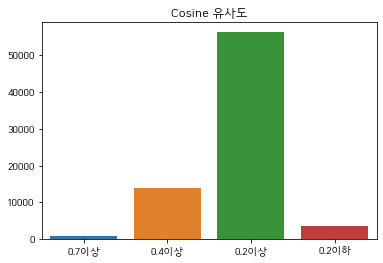

In [14]:
score_list3 = []

for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
#     sim_scores = [(web2id[i], score) for i, score in sim_scores[0:10]]
    sim_scores = [(score) for i, score in sim_scores[0:10]]
    
    score_list3.extend(sim_scores[0:10])

score3_high = []
score3_mid = []
score3_low = []
score3_2low = []

for i in range(len(score_list3)):
    if score_list3[i] > 0.7:
        score3_high.append(score_list3[i])
    elif score_list3[i] > 0.4:
        score3_mid.append(score_list3[i])
    elif score_list3[i] > 0.2:
        score3_2low.append(score_list3[i])
    elif score_list3[i] <=0.2:
        score3_low.append(score_list3[i])

        
print('0.7이상:',len(score3_high),', 0.4이상:',len(score3_mid),', 0.2이상 :', len(score3_2low),', 0.2이하:',len(score3_low))
        
import matplotlib.pyplot as plt

x = ['0.7이상','0.4이상','0.2이상','0.2이하']
y = [len(score3_high),len(score3_mid),len(score3_2low),len(score3_low)]

#한글 쓰기
plt.rcParams['font.family'] = 'HCR Dotum'
plt.title('Cosine 유사도')

sns.barplot(
    x= x,
    y= y
)

# plt.bar(x, y, width=0.4)
# plt.legend()
# plt.bar(x,y)

### 1순위의 유사도가 0.2 보다 낮은 웹툰

In [15]:
score_list4 = []
for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [(score) for i, score in sim_scores[0:1]]
    print(sim_scores)

    score_list4.extend(sim_scores[0:1])

마물전담부대
[0.37374138900715087]
불릿
[0.4640402493505881]
더
[0.35087394869627775]
각자의
[0.795064394779917]
노선도
[0.3971608214731124]
말하는대로
[0.5998467907006597]
연주동
[0.40929607293099907]
의도적
[0.43528486753159623]
맘마미안
[0.3414596912237996]
로맨스는
[0.4938136445119839]
대디고라운드
[0.680915983411796]
도리내리
[0.3537251036171596]
아내를
[0.3935568391361435]
오늘또오늘
[0.30746367743464864]
토끼대왕
[0.4455035194747362]
복학생
[0.4195156246648335]
살人스타그램
[0.3815523552205381]
당신의
[0.35222627859144506]
스몰
[0.4250670625199222]
도를
[0.3784384963571845]
불티
[0.3561140743101036]
제7원
[0.4650441453501126]
DEY
[0.5394804956289928]
금혼령-조선혼인금지령
[0.3505869875517775]
재혼
[0.4379549833516445]
당신의
[0.35222627859144506]
늑대가
[0.3948052561522184]
흥부놀부전
[0.641073607480351]
죽여주는
[0.6840781307892592]
뫼신
[0.3949857129437328]
셈하는
[0.5015010865259578]
소년,
[0.38240127921648615]
줄라이
[0.42899816259731616]
하슬라
[0.4447312973041125]
합격시켜주세용휴재
[0.37966614592966796]
감히
[0.427661330495047]
인터셉트
[0.4342134610558475]
별종
[0.4113066197934654]
지금은
[0.335550921882

[0.6201302871253109]
백귀야행지
[0.3975119438124533]
개장수
[0.5939613068462882]
덴마
[0.3368953859444665]
부활남
[0.6640378041435159]
신석기녀
[0.3914099418705836]
냥하무인
[0.3745291036650025]
MZ-레이징
[0.3289543659823232]
치즈인더트랩
[0.6417736682359965]
쎈놈
[0.34395911754805586]
퓨리스틱
[0.5587032861146999]
살인자o난감
[0.49594079320716544]
킬러분식
[0.47763637367009315]
2019
[0.37922720467632515]
늑대와
[0.4976223283315258]
타인은
[0.48792171549281194]
츄억보정
[0.35968997599689656]
그랜드
[0.344053509036069]
수능일기컷툰
[0.4298961835303974]
위장불륜
[0.41266029898358764]
숨:킬더바디
[0.48523527021127777]
돼지만화컷툰휴재
[0.5980739794443323]
푸들과
[0.3724106007103583]
한남동
[0.36934760023890034]
썸머
[0.4248838591626146]
가우스전자
[0.44772467755643724]
신시의
[0.5454104207374131]
성공한
[0.34568629366594206]
안녕,
[0.5444582898636303]
메이크
[0.4717216141723637]
27-10
[0.510337952355274]
호러와
[0.46548897826779856]
좋아하는
[0.5117108381637381]
천리마
[0.4723900314900083]
신암행어사
[0.4374423680789819]
식스틴
[0.38153870246007116]
2019
[0.37922720467632515]
여기가
[0.452365508390314]
타인지옥
[0.3

[0.5234244450507239]
버프소녀
[0.4723900314900083]
2014
[0.5386512661041867]
시타를
[0.7048422557018253]
시간의
[0.81971292727621]
킥
[0.37818293573968037]
역전!
[0.4056644119654752]
레드카펫
[0.7248357679706571]
어른스러운
[0.3980117952404393]
헬로
[0.36305274184195674]
강시대소동
[0.3717097537076797]
섀도우
[0.36867953070693926]
은주의
[0.3819263580176419]
드래곤레시피
[0.6357330021396002]
투엔티스
[0.39129189625861477]
피리부는
[0.5550441054108917]
기적!
[0.7407479123715689]
열무가
[0.3041895604943733]
아이들은
[0.4096185267504199]
너와
[0.708800399614297]
와라!
[0.4163078792780689]
죄의
[0.4754511884780841]
실질객관영화
[0.3428781654263461]
우리의
[0.48847590257524276]
코끼리를
[0.45899376095062683]
네가
[0.741405986169004]
판타지스케치
[0.3448298687491526]
새와
[0.6444317881510515]
그녀는
[0.7022768450709553]
한국만화거장전
[0.49573125149941555]
모던패밀리컷툰
[1.0]
닥터
[0.25645840381156815]
빵점동맹
[0.4127678157601409]
국립자유경제
[0.9117789476225321]
악플게임
[0.4454963501376425]
한줌물망초
[0.32299494479808916]
좀비를
[0.48782107719310663]
그날의
[0.5612439325093705]
소나기야
[0.7405407926679627]
2013
[0.43

[0.3055277985821557]
아이즈
[0.41365458055898524]
빅맨
[0.2722211139109349]
정년이
[0.4800409089046039]
다꾸남
[0.42838547924337045]
은주의 방 2~3부
[0.5321726373115766]
나는 어디에나 있다
[0.4953057841540634]
악인
[0.3868089764725793]
제로게임
[0.5503334912012192]
태시트
[0.39107954430203373]
연우의 순정
[0.6268845920906774]
빛빛빛
[0.44293916954131396]
열녀박씨 계약결혼뎐
[0.3944822601045842]
숲속의 담
[0.487492917945106]
나타나주세요!
[0.35480567748185443]
오파츠
[0.4350246898475026]
나의 플랏메이트
[0.37719574854131344]
그녀석 정복기
[0.3883356581352583]
대신 심부름을 해다오
[0.47802276129930854]
고등매직
[0.7369796057543088]
안식의 밤
[0.43628519972058777]
급식러너
[0.47330578221900077]
조선홍보대행사 조대박
[0.4003233515348027]
NG불가
[0.62293883608072]
자판귀
[0.3846549165043828]
지원이들
[0.5344187824837279]
언메이크
[0.4065880459569548]
완벽한 가족
[0.4358639895251184]
프린스 메이커
[0.5060516080059307]
풋내기들
[0.6747214676355777]
피로만땅
[0.4721568536516068]
인문학적 감수성
[0.49333854745117]
찐:종합게임동아리
[0.4147326953458095]
하나in세인
[0.3600575809580777]
헬퍼 2 : 킬베로스
[0.46242756257282785]
복학왕
[0.6329712227725358]
전지적 독자 

[0.4434341329094146]
별이삼샵
[0.433409099124434]
마법스크롤 상인 지오
[0.4065856364700118]
혀로 만난 사이
[0.42609617884396894]
생존로그
[0.47926679409552864]
전설의 화석
[0.3827349268710375]
구름이 피워낸 꽃
[0.3836513565850175]
판사 이한영
[0.4041979234243936]
벚꽃이 흩날릴 무렵
[0.4111171780078503]
다이스(DICE)
[0.5016573548523072]
AI가 세상을 지배한다면
[0.41190878731831415]
불순물
[0.3843971902608209]
강남도깨비
[0.644100880905979]
동생친구
[0.4864284457870185]
학교정벌
[0.4069986193618114]
황제에게 하트를 심어주세요
[0.6589541209704384]
라일락 200%
[0.4727599242821946]
아르세니아의 마법사
[0.46618080630098]
평행도시
[0.5033299694147402]
사람은 고쳐 쓰는 게 아니야!
[0.4317356066124253]
오른눈이 보는 세계
[0.5835061673227551]
결혼까지 망상했어!
[0.39205146806950913]
잉여특공대
[0.3970049851701679]
가짜인간
[0.46697864715058157]
두근두근 연극부
[0.32141080933511057]
데빌샷
[0.43057043917236143]
짝사랑의 유서
[0.3740963388518001]
독신마법사 기숙아파트
[0.399164769408878]
굿 리스너
[0.3242355999167697]
제타
[0.39902939102455504]
조선여우스캔들
[0.3645976642297684]
라커, 오프너
[0.42840861442317]
오늘 밤만 재워줘
[0.35875685165698007]
소녀 해미
[0.5364064974764868]
위험한 신입사원
[

[0.39989919919631883]
고등패왕전기
[0.48692558941104525]
의 밤은 당신의 낮보다 아름답다
[0.31823175266852877]
영웅의 변수
[0.5419279748436984]
찮은 관계
[0.5585621369047908]
하면 좋습니까?
[0.352509448515114]
삐꾸래봉
[0.5789232504727981]
첫사랑은 죽었다
[0.5763772389676697]
에스키스
[0.4592501596728177]
오만상과 편견
[0.610760721247879]
도
[0.3199697177610175]
이끼
[0.3611239560422119]
익명의 독서중독자들
[0.45030879201841645]
어쿠스틱 라이프
[0.484783110534171]
놈들의 도시
[0.4482626349529698]
스킬
[0.3261708574978615]
화자
[0.5345023516954781]
그림형제 잔혹동화
[0.38557394252090127]
은밀하게 위대하게
[0.688531822675629]
단지 그것 뿐
[0.7407479123715689]
다시피는 꽃
[0.5158947326450248]
트리니티 원더
[0.6964147002371458]
피그말리온 컴플렉스
[0.42736955512203206]
오늘의 초능력
[0.4588006353537134]
골든왈츠
[0.5917309387526047]
The 윷놀리스트
[0.5238908964410249]
개밥도토리
[0.43572311345104836]
벨트 위 벨트 아래
[0.4084201232144389]
곱게 자란 자식
[0.3708907896853898]
토리의 아들
[0.3448298687491526]
엄마들
[0.6319538544205879]
TEN
[0.583115358305084]
미생
[0.3072491296054959]
연애싫어
[0.3714769230444177]
가슴도 리콜이 되나요
[0.7998107478814048]
가내수공업 Ent.
[0

[0.45890956273664674]
이병 일학년
[0.35585663114491894]
위대한 로맨스
[0.3664743221072409]
옥탑빵
[0.35197089561867506]
간이역에 겨울이 오면
[0.4261225452548226]
다음웹툰 팬클럽 모집
[0.3055654126649138]
대작
[0.3547556492029349]
새벽날개
[0.29959602139661057]
차이니즈 봉봉클럽 광저우편
[0.340770243979966]
곤조 스트릿 - 갱스터의 시대
[0.4052706982892358]
애휴
[0.5094098579393178]
헬로 브리
[0.609435043745253]
얌얌숲 당근길 토요요
[0.38897234127391117]
오리지널 씬2
[0.4295660783962202]
방랑시인 김삿갓
[0.3693816398959608]
나는 달린다
[0.5799728135855488]
키몽툰
[0.31978905843518773]
작가의 사생활
[0.3735380845210296]
리와 구
[0.34022492056063197]
위 아 애니멀스
[0.5491038691321342]
인랑:프리퀄
[0.3644211449085205]
탐정 사용설명서
[0.34335842818618806]
블레이드2 : THE RETURN OF EVIL
[0.44187759496608225]
귀신이면 어때
[0.46730829177494065]
스틸레인2 : 강철비
[0.5245498712918764]
버디스
[0.28457275103913093]
파워맨
[0.33287500476032494]
2018 다음웹툰 능력고사
[0.33412628965110724]
초월(初月)
[0.3527626592721436]
컷 : 죽음의 소리
[0.6934911245608596]
라그나로크
[0.5451995348414683]
라디오 갤럭시
[0.3949329867767647]
블랙 마리아
[0.33248647716736074]
달콩분식
[0.55762585

[0.3576943581253753]
한 번 해본 사이
[0.4864522136115945]
CELL
[0.5530390976949809]
프로레슬링의 신
[0.3546406224041809]
언니가 남자 주인공을 주워 왔다
[0.5130081541318309]
삼국지 여포전
[0.4371124884610768]
위황후, 궐을 쓰다
[0.593360742893775]
나빌레라
[0.43595004073071225]
낙하산 사내연애
[0.40162498522793266]
전생자
[0.4016771683427796]
괴물 공작가의 계약 공녀
[0.4286965112925479]
적기사는 눈먼 돈을 좇지 않는다
[0.397911434411905]
강철의 연금술사 컬러웹툰
[0.4777545538027929]
용의 계승자
[0.3987896968771964]
낙화유수
[0.36261832464977883]
신데렐라를 곱게 키웠습니다
[0.31215980882070354]
옥상정원
[0.6225524172877734]
사신 영웅전: 바보 마법사 영웅이 되다
[0.4814927797679061]
무신전기
[0.41730470668644915]
사실은 내가 진짜였다
[0.3115901717145246]
Oh! 마이 서방님
[0.39721136909362725]
대군으로 살어리랏다
[0.3740363187213278]
진홍의 카르마
[0.6073822366113135]
오늘 밤 어때?
[0.47906521531869284]
눈이 나려 꽃
[0.34051432891234196]
왕자님의 막대사탕
[0.5268140150153133]
뱀파이어, 특종을 부탁해!
[0.3745089210676925]
황제의 외동딸
[0.6209613838439823]
라지에르의 서
[0.4912515709162725]
홍천신존
[0.3514570633242743]
은향
[0.3405015712862406]
너의 의미
[0.366346174496855]
모나와 쿠쿠
[0.397599214293191

[0.43478916756868924]
별을 구속하겠습니다
[0.379118894886896]
그녀와 야수
[0.43833630098771786]
이세계에서 머리로 하드캐리
[0.4993955085771326]
전령새 왕녀님
[0.4634751340582899]
제왕의 귀환
[0.5479213738524344]
당신의 로멘스 [BL/개정판]
[1.0000000000000002]
아싸가 알아버렸다
[0.3890465777889667]
사업왕 심길후
[0.36540678869885507]
자본주의가 낳은 괴물
[0.3809591101956021]
산해봉신
[0.6704525355758852]
저는 용사님이 아닌데요!
[0.4162264039263146]
시어스톤(seer stone):수련4만년(감독판)
[0.439474503004092]
서천화원
[0.8819550416080044]
위험한 남자 [개정판]
[0.260528956566099]
프리실라의 결혼 의뢰
[0.3859675569866095]
시간의 계단
[0.5021333783400409]
샐러드 데이즈
[0.6852214744154053]
원수의 가면을 벗기면
[0.39832308718931164]
그래서 오늘도 삽니다
[0.3927354746445467]
귀환자의 마법은 특별해야 합니다
[0.5278604847528711]
쇼윈도의 품격
[0.3388744208922121]
메디컬 환생
[0.3682530515135886]
T.K.R (The killer returns)
[0.34327999822840516]
투파창궁
[0.4213639544706889]
정신병동에도 아침이 와요
[0.5587817675600238]
녹음의 관
[0.4998728946768539]
악녀하렘
[0.4894890566167245]
공주, 선비를 탐하다
[0.6029804656940894]
순정 히포크라테스
[0.8494171143378826]
언더 더 메모리
[0.6106598221324626]
사랑의 순간
[0.43527

[0.3468280899669585]
한기담 : 천월의 별
[0.2641054738385938]
몬스터헌터
[0.3885007248301408]
나 홀로 주문 사용자
[0.43537593605005365]
무협지 최고 악당의 귀한 딸입니다
[0.41017623461355984]
신마
[0.41361124828122386]
화산권마
[0.5261137870486553]
드래곤의 구원자
[0.37107209902091104]
천계지부 로망컴퍼니 [개정판]
[0.46835284879411854]
미필적 고의에 의한 관계
[0.5522558645211848]
프렌시아의 꽃
[0.34582016910974717]
남궁세가 소공자
[0.6443624413774234]
악녀의 탄생
[0.628801328316087]
태자비는 미소년 게임이 하고 싶다
[0.4048989005319489]
블러디발렌타인:인류종말
[0.39672186358508565]
넘 많은 고양!
[0.44651805089919605]
소르골 전기:천년전쟁
[0.40548348966018133]
옆집남자와 소설가와 기묘한 이야기
[0.893281839413533]
폐월화 : 야수의 꽃
[0.419006308552551]
황비님? 황비님!
[0.4220041183339418]
여자친구 : 드라마 <남자친구> 스핀오프
[0.45611986375445335]
옥탑방 소드마스터
[0.3478291112548507]
악역의 엔딩은 죽음뿐
[0.4162991582277097]
C.O.P (씨오피)
[0.3799587285129813]
열세 번째 밤
[0.4690171973331121]
잘못된 고백
[0.4007134280644099]
천계구매대행
[0.39216791730398437]
SSS급 죽어야 사는 헌터
[0.3745157239826114]
아기 황후님
[0.7040941716002833]
아빠가 너무 강함
[0.39687844214148105]
선택
[0.48688082935651394]
악역의 구원자
[0

[0.7360653968308974]
예쁘니까 괜찮아
[0.916661124526799]
마이너스 1억 소녀
[0.582573264222752]
로그인 러브시티
[0.42860300460256245]
유어 마이 데스티니
[0.6180016840037545]
래더토너먼트
[0.5416895000960052]
네 살 차이
[0.4120130642111854]
나비, 호랑이를 물다
[0.4396097936112326]
황성 동방불패 컬렉션
[0.4461708514090818]
나의 하늘
[0.7216132093297236]
신형빈 도시액션 시즌3
[0.5100024085168811]
마법사 무림에 가다
[0.7057283379457551]
달콤한 종속 : 뱀파이어와 키스를
[0.42054424769721094]
간극[BL] [개정판]
[0.4414752555555429]
픽셀 오브 라이프
[0.39828358461967384]
끝에서부터 한걸음
[0.9293811038968762]
망고의 뼈
[0.38113456870129836]
죽고 못사는 연애
[0.4245765148119658]
식빵앱
[0.5789232504727981]
디센트
[0.37838105504124314]
향장
[1.0]
야설록 천외비사 컬렉션
[0.5821120381473708]
사랑은 앵초색
[0.6735165485471057]
당신은 나의 신
[0.36790828816263127]
황성 건곤일척 컬렉션
[0.5821120381473708]
애프터 커튼콜[GL]
[0.3529091984036093]
페인킬러
[0.3625575414712017]
시작부터 끝까지
[0.9017218945366474]
영웅신화
[0.3561210339429993]
아이갓츄!(I got you!)
[0.4085897482316598]
블러디 메리지
[1.0]
솔직한 키스는 야근 후에
[0.357419883994475]
명검
[0.3497111221804576]
극한견주
[0.4292288918405195]
쿠니미츠의

[0.35462472014155433]
소녀가 되는 법
[0.5859698309635327]
도시정벌 10부
[0.3607144393558354]
입덕학개론
[0.5645674177658302]
수상한 메신저의 초대
[1.0]
신형빈 도시액션 시즌6
[0.7191773467205105]
아이템
[0.3813245532967978]
코우노도리
[0.40391548657572335]
뱀프렌드
[1.0000000000000002]
Kiss me 프린세스
[0.3806399461733689]
첫날밤이 떨리는 이유 컬렉션 [할리퀸]
[0.541894189467704]
황성 일취월장 컬렉션
[0.6503751063034766]
황성 불사무적 컬렉션
[0.40439546885520633]
라이어 게임
[0.47738612221796817]
각설탕 소리
[0.9086395923977577]
어렴풋이
[0.3395306425854797]
유니언 로드: 만수귀원
[0.4208609775050826]
센티멘탈 리즌
[0.3505587381939595]
7번째 스트라이크 [BL]
[1.0]
러브 시그널
[0.5768815242267696]
묵검향 천산출두 컬렉션
[0.48742689764420183]
해피!
[0.5932772961680486]
황성 잠룡승천 컬렉션
[0.5821120381473708]
황성 무신전기 컬렉션
[0.3244677613271583]
닥터 퀸
[0.6430048467027367]
내 싸랑 웅자 [완결]
[0.2563409817752816]
내일의 마법 대륙
[0.45247320006172603]
김 비서가 왜 그럴까 [완결]
[0.36364519766347186]
당신을 무너뜨리고[BL]
[0.3464849487886441]
야설록 환골탈태 컬렉션
[0.5821120381473708]
말도 안되는 관계 (개정판) [BL]
[0.4129325367059753]
수라도
[0.4442405203671189]
건널목에서 만나요+횡단보도에선 일단 멈춤
[0.532

[0.39656969953970844]
건방진 천사
[0.46994911833296843]
우연의 접점
[0.5438321000791766]
네가 내 천사라고?!
[0.3675787074752103]
하승남 골통신화 컬렉션
[0.5349889711631461]
괜찮은 관계
[0.41480043337771266]
아기가 생겼어요 [연재]
[0.34659671928458796]
미스타임 (Miss time) [연재]
[0.8189193636525295]
소라해나! [연재]
[0.3622870827567105]
LOVE WINS
[0.4679066150466032]
말할 수 없는 남매
[0.4166780100745798]
대표님의 삐뚤어진 사랑 [연재]
[0.6976687730397765]
citrus 시트러스
[0.3903940224103219]
메리 고 라운드
[0.38678033039816234]
오타쿠에게 사랑은 어려워
[0.4308903059437567]
우리사이느은
[1.0000000000000002]
천사의 용도
[0.45434478816597745]
연필의 각도
[0.41694707925008706]
너의 HEART를 나에게 줄래?
[0.5396621466356635]
애프터 커튼콜
[0.38913087337919366]
악마공작의 어린신부
[0.36575317388675954]
아가씨와 우렁총각
[0.3887563743547933]
내가 널 사랑할 때 [연재]
[0.37483809173752447]
내가 원하는 건
[0.47836271988668766]
눈 먼 정원
[0.4260627107297851]
별과 하나의 시
[0.3881047332129813]
이성연애박사
[0.8436237244818657]
속도위반 대표님과 계약 아내 [연재]
[0.4923660644932805]
구최애로부터 비밀을 사수하라!
[0.6003271990184801]
그에게 닿기 100일 전
[0.41439014989038214]
게임하다 눈맞을 운명입니다 [연재]
[0.

[0.45268640927519266]
사랑하는 고슴도치
[0.37837841335317346]
쿠로사키 말 따위 안 들을 거야
[0.3814300953878737]
흑룡연인
[0.3627571803663486]
새빨간 결혼
[0.6545419037802153]
있잖아요 용님!
[0.3796614728714729]
환생하여 의녀가 되다 [연재]
[0.9194835801611352]
허니 컴 허니
[0.4226246771441593]
왕자님이 있다
[0.42966532061137674]
슈트를 입은 악마 [개정판]
[0.6291106956378824]
콜레트는 죽기로 했다
[0.34682086181138494]
외모윤리
[0.6268845920906774]
니가 내맘 알아? [연재]
[0.4442981188777092]
수상한 메신저의 초대
[1.0]
사랑을 모르는 우리는
[0.4532679281371678]
너도 좋고 너도 좋고 너도 좋고
[0.826393013507741]
처음 사랑에 빠진 날 읽는 이야기
[0.4390392203723802]
마중 나가는 시부야 군 [연재]
[0.34162796343945556]
모란과 도화의 계절
[0.3175366997226893]
순결 상실까지 일주일?!
[0.5422254931032979]
그런데 치기라 군이 너무 달콤해.
[0.39291070085384167]
마이로드, 울프퀸 [연재]
[0.3665777952059166]
결국 좋아한다고 말하고 싶은데
[0.4285638248679794]
테오도르의 노래 [연재]
[0.3401591746865307]
오빠는 역시 늑대야
[0.662885287734471]
클럽 아모르
[0.48949796976072935]
숨겨진 세계 [연재]
[0.4293157591396657]
흰 사슴 잉그리드
[0.3466283463607064]
그들의 방주
[0.4772790346693804]
너의 처음을 전부 나에게 줘
[0.3882722199880209]
평범한 코이코 짱
[0.45326

[0.4879348308289523]
미친녀석
[0.48044327882064214]
그래도 네가
[0.4864522136115945]
캐스트 온 스테이지
[0.3722204177017878]
지옥고백시
[0.399913366929599]
도련님의 비밀
[0.629676471226787]
청소하실, 레옹?
[0.37784410808952273]
할로윈 로맨스
[0.35703724122808767]
마르스 (MARS)
[0.39216645372179787]
시크릿 와이프
[0.355583638162622]
N과 S
[0.5288644596178766]
사고치는 여자, 사연있는 남자 [연재]
[0.4935731455197437]
사랑의 처방은 필요 없어요!
[0.574748638090616]
Bitter Love Choice(비터 러브 초이스)
[0.7019431461073069]
황자님 거기 있어 줄래요
[0.47202015417659604]
장밋빛 고백
[0.4619807868372334]
보랏빛 콘파냐
[0.4509217905900224]
큐피트의 화살
[0.65308360220054]
오늘은 회사 쉬겠습니다.
[0.3757972716762729]
월하의 두 사람 ~더이상 없는 당신은 이 사랑을 용서하지 않겠죠~
[0.4201982217318895]
짝사랑 서점
[0.39414644847477764]
그녀와 썸남들 ~아홉수에 시작한 연애~
[1.0]
봉사감과 러브레터
[0.3960892519670653]
사랑이랑 밥이랑 무지개랑
[0.4894492976647471]
사랑은 키스 후에
[0.4431166016634802]
아름다운 그녀
[0.41811423772438217]
우타카타 다이얼로그
[0.5654675114800242]
절벽 위의 하나씨
[0.396101838334096]
반했습니다, 선배
[0.45047560422868227]
웰컴 투 미미살롱
[0.3871848434916531]
망상보다 더 굉장한 거, 할래?
[0.5555003201204075

[0.621499516706484]
미드나잇 파트너
[0.354370507754873]
아빠가 남자로 바뀔 때
[0.47223090722314864]
다이쇼 로맨티카
[0.4712498157040721]
키스 프렌드 -키스로 물드는 첫사랑-
[0.4386899269306867]
고백할 상대를 착각했습니다
[0.44313559953300236]
세상이 끝나버릴 것만 같은 키스를 해줄게
[0.6688192964202677]
연애레슨 시간입니다
[0.574748638090616]
짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~
[0.4251825805940513]
어린 양 플레이~짓궂은 사랑법~
[0.4026807325584154]
옆방의 늑대 군
[0.41406242418538486]
내일도 너를 좋아할 거야
[0.42535275741755074]
너를 한입
[0.4173336120332904]
어른이 사랑을 끝내는 법
[0.44089644780267623]
허니 스위트 키친
[0.5364343746840213]
바이바이, 사랑해
[0.4470673686223048]
아포카토
[0.3432387384646681]
지령과 키스
[0.37983599704542703]
밀크티
[0.4408834508090539]
선생님은 나의 것
[0.4387170067527503]
너의 죄를 달콤하게 녹이고
[0.24480236439877687]
몰락 왕자의 달콤한 키스
[0.46746382212283516]
늑대 공작의 구혼
[0.35183083262917886]
붉은 도깨비와 러브송을
[0.5810921110402608]
내 양호실에 잘 왔어
[0.3938202452983615]
눈부시게 찬란하게
[0.3666072339733583]
님과 함께
[0.7161894771911621]
금단복종 티켓 ~악마의 달콤한 속삭임~
[0.42114181153668206]
썸머레터
[0.4259100068255923]
교복의 시간-비밀의 Kiss
[0.43431322982436465]


[0.44869255295385035]
신기록
[0.40593158038821797]
탈격소년
[0.4421401644257723]
조선 스트리머
[0.5437072157659624]
정열맨 시즌1-2
[0.4018689232319004]
주근깨 가쵸
[0.4362417201933855]
재앙급 사도와 12인의 신부 후보 [연재]
[0.5485043357934322]
데우스 바드 마키나
[0.32779809027587287]
흑역사처리반
[0.35309154450444685]
꼴데툰 2021
[0.38751139541533547]
잿빛설원
[0.5291739373798123]
지젤 씨의 피[개정판]
[0.3632193949059917]
백서사시
[0.6035331061050542]
악마의 소년
[0.3935568391361435]
권왕무적 [연재]
[0.6411406266768452]
포젯션
[0.47129605395095686]
모기전쟁
[0.9353145010601003]
주술회전
[0.35445224495615507]
식사하고 가세요! [연재]
[0.4210614392802393]
바람
[0.45162077995427646]
진격의 거인
[0.44972976706749124]
저승GO
[0.4211998642238274]
흔해빠진 세계관 만화 II
[0.40740203637606326]
무련전봉 [연재]
[0.42877955061158485]
나의 그녀는 구미호 (무삭제판)
[0.595691390471057]
어바웃 제인
[0.3331145504531466]
펀칭머신
[0.3817422989835349]
새벽을 얽매는 뱀 - 흔세만 스핀오프 2
[0.4901510364233902]
단다단 [연재]
[0.3634906023189528]
왕비가 된 외과의사
[0.42511296406087795]
용의 아들 최창식
[0.37768595285296247]
도와줘요, 이비씨!
[0.5333328416671256]
흔해빠진 세계관 만화
[0.4432513966613

[0.6550519286506868]
이누야샤
[0.41975381114106675]
뱀파이어 도서관
[0.49773134999511104]
군주의 여인
[0.406949146895255]
[코믹] 변경의 노기사:발드로엔
[0.3809861389292054]
파동
[0.38580326374200613]
한여름 밤의 꿈
[0.355978588252936]
식야묘은: 밤을 그리는 퇴마사
[0.5511287857258931]
전생했더니 검이었습니다 (코믹스)
[0.5620955999457405]
녹아내려! 미조레짱
[0.45848378640609777]
지존신마
[0.43288827089886983]
신인왕좌
[0.45150968963517113]
라이어(LIAR)
[0.5770143002310868]
갸루와 공룡
[0.3417481937210806]
샤랄라! 역변의 아이돌
[0.4116692795914036]
마녀의 괴화집
[0.3413689618502585]
독고 플라워
[0.4469092323626764]
버츄얼 패밀리
[0.7369796057543088]
싸움의 기술 2
[0.3660701788524418]
마오 [연재]
[0.392338814495693]
리프루터
[0.7312101900232141]
인간 불신 모험가들이 세계를 구하는 듯합니다
[0.4493628785743652]
고깔모자의 아틀리에
[0.6518917082194859]
너의 기억 ~나를 돌려줘~
[0.37207381505474263]
남장여자지만 모두가 여잔 걸 아는 그런상황이랄까
[0.351917554287202]
인어공주의 미안한 식사
[0.5125664283829717]
절세무신 [연재]
[0.575861235520771]
메리지 블루
[0.40479449271539053]
미스터리 마스터
[0.3151530413619597]
밥수저 들고! [연재]
[0.41042949094062675]
9레벨의 열람요원 [연재]
[0.6706488712111938]
인간이 없는 나라
[0.3625

[0.438217268950513]
크로노 크루세이드
[0.34942792705008285]
냥의 탈을 쓴 네코토 양
[0.3779528468085323]
도쿄바빌론 (TOKYO BABYLON)
[0.3536057491840592]
재의 시간
[0.30115720937243223]
폭식비의 검
[0.3810449940289299]
전설의 용사
[0.5148061544770139]
수신의 신부
[0.27578217125892074]
알리시아 씨의 다이어트 퀘스트
[0.2729333676587979]
혈계전선 Back 2 back
[0.37133306170457]
마계왕자
[0.3222026305202049]
호접몽
[0.6075712394670532]
성전 -RG VEDA-
[0.2974903822838956]
어이상실의 시대
[0.3428880910754046]
금지구역
[0.46629435350743587]
수리부엉이
[0.42596142656842]
강철강
[0.3154329293087444]
풍운 3부
[0.423366995389843]
붉은 달이 뜨는 밤
[0.4492974724049465]
흑백무상 [연재]
[0.38919237909407967]
마녀는 300살부터
[0.4831920716113295]
이 세상을 꽃으로 만들기 위해서
[0.40334071567674873]
플리츠 백작은 언제나 심기불편!
[0.4463305994685588]
창생계약
[0.42596142656842]
마물들은 정돈이 안돼
[0.3545829176458803]
WISH (위시)
[0.3917338368187453]
아바르트
[0.42410463718807967]
미기와 다리
[0.42980755675961474]
혼의 나라
[0.6997347499058277]
로또 400억에 당첨되었지만 이세계로 이주한다 (코믹스)
[0.4012233082774658]
나나호시와 타치바나
[0.3895532140974669]
귀연
[0.5160666438252052]
요괴 아파트의 우아

[1.0]
오늘부터 0촌! - 진돌&히디의 우당탕 결혼일기
[0.3209415402773713]
도박묵시록 카이지
[0.366520232299267]
심청
[0.5097382356621619]
올바른 인생을 살아가는 법
[0.3703936337560504]
청춘어람
[0.18586787774541366]
옆집 여자 [개정판]
[0.5589608807400142]
멍멍냠냠
[0.30357750867249583]
미묘하게 다정한 불량아
[0.3509551458373418]
가후전
[0.3630545632011094]
여섯자의 소년
[0.15782290180183609]
네 사람
[0.3692265454301596]
춤추는 도련님
[0.417827073665193]
일진녀 과외하기[개정판]
[0.4519568343941275]
노라줘요 -우리 집 웰시코기 이야기-
[0.3010304326560552]
하드코어 바닐라[개정판]
[0.4404268946994086]
스킵과 로퍼
[0.4242292785423764]
기레기
[0.5752369463472419]
독일 만화
[1.0]
나와 그녀와 그녀와 그녀의 건전하지 못한 관계
[0.5153506514610667]
신의 접착제
[0.5029837103972746]
감옥실험 [연재]
[0.42944836901850003]
11번가의 기묘한 이야기
[0.4738000578045901]
전남친 대 스토커 [개정판]
[0.9505314749178166]
수컷의 경우
[0.4167569693993699]
국립자유경제고등학교 세실고 2학기 [올컬러]
[0.37657339117138383]
학원 베이비시터즈
[0.43288495672754007]
염라의 법칙
[0.37309417503442344]
낮은 곳으로
[0.4747627683328715]
타고난 성별이 잘못되었다!
[0.6064963211402588]
산카레아
[0.38733385271747495]
구구레! 코쿠리 씨
[0.38379841858332825]
언노운 코드
[0.

[0.4083513128286725]
언더페인팅
[0.5969989070795705]
블라인드 나인
[0.3823257292208752]
이세계 피크닉 (코믹스)
[0.3476460047206411]
BL만화 여동생×순정만화 오빠
[0.44079580412791386]
펌잇!!(Perm IT!!)
[0.9214937379798269]
감옥의 낙원
[0.40989207257821125]
로스트 프린세스 [연재]
[0.3876520505320044]
군청에 사이렌
[0.48893519631432636]
브라혼 ~삼형제를 휘두르는 나~
[0.333760811824071]
동인녀 츠즈이 씨
[0.37394396991991147]
슈퍼대디 열
[0.48775080453594166]
개인차 있습니다
[0.4780271317801144]
해피엔딩은 이제부터
[0.3751955831430791]
마당 씨의 좋은 시절
[0.42031814844179877]
아나밸과 대한민국
[0.37123249862206853]
어른을 위한 BIG 4 만화 공모전
[0.3309618310300375]
얼굴에 드러나지 않는 카시와다 양과 얼굴에 드러나는 오오타 군
[0.40424138487633965]
다카스기가의 도시락
[0.4167855470779409]
꽃이 지더라도
[0.718709068347501]
그대로 좋아!
[0.3546888183327885]
영구지명 부탁해요
[0.42540506844268555]
아저씨 사랑해
[0.6223853952093553]
쇼와 팡파르
[0.46147872864204115]
고고 스윗맘
[0.42571906668523385]
기도(祈り)  [제1회 세계만화공모전 수상작]
[0.5503968724224533]
카케구루이
[0.5526167516006488]
이별・리프 [제1회 세계만화공모전 수상작]
[0.3715782044077756]
국수의 신
[0.394102401433094]
캉캉교를 건너
[0.4495287571976366]
골동묘점
[0.489

[0.363024432020725]
붉은 꽃
[0.3753205764976196]
첫사랑, 그 3cm의 거리
[0.3835644707075264]
짐승남과 동거
[0.4401944278440883]
사에키 씨는 잠들어 있어
[0.3336611912854066]
까칠남의 첫사랑 [베리즈]
[0.36151047127957314]
그녀가 되는 날
[0.40034589947554605]
별을 지키는 개
[0.4723873531952153]
보이드씨의 기묘한 저택
[0.3173702922322863]
나님의 카페에 어서 와요
[0.3392995656789824]
보고 있다.  「스토커」
[0.4321215559086348]
아저씨 후작은 사랑을 하는 나이
[0.6312975786518537]
약속은 할 수 없어요
[0.2878754971129301]
천년만년 그녀석
[0.3835651219945193]
비련의 인공지능 [베리즈]
[0.386356674449106]
레진코믹스 1주년 축전
[0.43070664397459335]
청춘, 실격
[0.500992958539407]
8억버는 아저씨
[0.4147875099078825]
이 결혼 반대입니다!
[0.3690294670686532]
식탁 아래 Blue
[0.40915817248204744]
천사의 집
[0.3556177285319503]
교정 뒤에는 천사가 묻혀 있다
[0.4880586725399615]
별똥별에 소원을 빌 정도로 우리는 순수하지 않아
[0.3799956145811877]
와가츠마 님은 내 신부
[0.5128143102381765]
아르테
[0.35174973447376306]
아이스 프린스
[0.4175323061748056]
녹풍당의 사계절
[0.34648704783586587]
동거종료일기
[0.3900843810577505]
시르크
[0.4126665996703971]
우리들은 모두 카와이네
[0.3299069711330167]
행복카페 3번가
[0.4295885869417932]
청춘시대-청춘

[0.6303740084631675]
남의 BL만화
[0.3484032712017781]
집사랑
[0.4782208469638839]
거짓말, 뱀파이어가 어디 있어?
[0.4243443162232707]
나는 너의 귀여운 카피캣!
[0.3482198610325449]
타치바나 백작
[0.2342553346941456]
바리왕자
[0.3193273094901485]
이상한 너를 맞이하며 [개정판] [연재]
[0.470745526719146]
착각은 자유
[0.6033949523221137]
박배우 X 김남팬
[0.5143758306375145]
시선 끝, 30도
[0.43973986446193775]
2반 이희수
[0.5878034877811882]
이번에는 닿기를
[0.4013629900320771]
정당한 기만
[0.4507097848178479]
나비, 호랑이를 물다
[0.4396097936112326]
킹스메이커
[0.5101876043887914]
혼약
[0.37518617858807973]
BJ 알렉스[개정판]
[0.3656703641337997]
자취요리왕
[0.4503636031952865]
비의도적 연애담 [일반판] [연재]
[0.41480043337771266]
우렁강도
[0.4140510439362291]
러브 오어 헤이트[개정판]
[0.38794239614899095]
우리 손만 잡고 자요
[0.5274578950430924]
소년을 위로해줘
[0.4078222040730274]
러브 포엠
[0.4128157979043845]
안티피티[개정판]
[0.67834315289584]
달콤한 남자
[0.9363794717739854]
A와 B의 초상
[0.4299388193805099]
야화첩[개정판]
[0.4785313145115404]
골판지 상자 안 고양이씨 시즌1
[0.3495916836835483]
너란 남자
[0.6258429116137489]
BL의 정석
[0.37567842746035485]
일어나서 사랑을 시작해
[0.3643547

[0.3599161958282321]
얼음요괴 이야기
[0.30499100016101177]
찬란한 우리들
[0.41016909510141036]
아방튀르 버진 [개정판]
[0.3471746071422664]
일상환상지남
[0.38556655133017603]
미로의 행진곡
[0.4179351587595598]
안녕! 나의 단팥크림
[0.41792601502635945]
그가 있는 집
[0.9263739281621188]
일진짱의 남자
[0.9277920094070236]
미완의 계절 [개정판]
[0.558132746102434]
마법 수프
[0.42827425822252935]
귀신을 보는 남자
[0.29355557988676]
내가 네 주인이다, 이 자식아!
[0.5675893436762282]
해피 허니 라이프
[0.5002264126655154]
입술이 닿기까지
[0.4248241165694675]
가로지나 세로지나 꽃은 핀다 [개정판] [연재]
[0.6397616434732927]
마사츠구 군의 생리적 사정 Returns [로제]
[0.3628453945388132]
오메가 파일
[0.3399788646401739]
테오 -THEO-
[0.41159678555337464]
어린이 스타
[0.5334497359482044]
위즈덤즈의 동물 친구들
[1.0]
구제불능일수록 귀여워
[0.49125315121003715]
용사 IN 마왕의 집
[0.38261773876531646]
극락 환상의 밤
[0.3542899085732349]
거품과 욕망
[0.5144025671425164]
A군과 B군
[0.5088423794511704]
화룡기 [연재]
[0.31115804526154434]
그저 좋아한다는 것만으로도 [개정판]
[0.42800446833093686]
사랑하게 될 거야
[0.868139622006891]
슬기로운 생활
[0.441267702823413]
메종 드 단아
[0.5086487489584526]
리트머스 [컬러연재] 
[0.43483944

[0.4299808907760538]
불꽃은 이미 쏘아졌다
[0.3801834697893572]
순애에로기
[0.4548410341095237]
방과 후 불순한 관계
[0.43087529162828686]
내일이 바뀌는 사랑을 한다
[0.31725577493177304]
사랑도 되지 않아
[0.34363040236992465]
그들은 XX가 아니라고 말한다
[0.36123677485912636]
그의 동생을 사랑하다
[0.3835821416045302]
망상가, 사랑하다
[0.43397878869329487]
바이바이, 왕따군 [로제]
[0.4144479734314247]
잠든 고양이는 입맞춤으로 눈뜨지 않는다
[0.3841457374672785]
날라리 소꿉친구의 진실
[0.4153099652194418]
소문의 연예계 뒷사정
[0.3261252094179757]
트러블 메이커!
[0.3333035595645832]
양호실에서 니멋대로해
[0.3824508363210669]
남자여, 화려하게 피어나라!
[0.35706974639173467]
듣자하니 반한 상대는 어둠 속성
[0.41792601502635945]
만져도 될까?
[0.4208143639068155]
네가 울고 있었으니까
[0.3519289819538585]
일그러진 복수 [개정판]
[1.0]
몰랑몰랑
[0.41213197649712074]
졸업식까지만 기다려줘!
[0.6594231400839972]
콜링(calling)
[0.38863647376230437]
사랑이 무럭무럭
[0.44805338521277566]
분해서 불쾌합니다
[0.3727385711408951]
오전 2시의 아름다움
[1.0]
너에게 물들다
[0.42281977339650023]
FILES
[0.4012031154030877]
러브 미 베이비
[0.37289170793396176]
23:45
[0.4298784542076435]
너의 고양이가 되고싶어
[0.5836427591679023]
HOME, SWEET HOME (홈

In [16]:
cnt = 0

for i in range(len(score_list4)):
    if score_list4[i] < 0.3:
        cnt +=1
        
print('1순위의 유사도가 0.3 보다 낮은 웹툰 :',cnt,'개')

1순위의 유사도가 0.3 보다 낮은 웹툰 : 205 개


### 장르별로 구분하기

In [17]:
for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [[web2id[i], score] for i, score in sim_scores[0:10]]

    
    for k in range(10):        
        title = sim_scores[k][0]

        series = web_combined['title'] == title
        index = series.tolist().index(True)
        
        sim_scores[k].append(web_combined['platform'][web_combined['title']== title][index])
        
    print(sim_scores)
                                       

마물전담부대
[['던전 속 사정[개정판]', 0.37374138900715087, '레진코믹스'], ['김무녀는 무녓무녓해!!', 0.33949959432594534, '레진코믹스'], ['괴기목욕탕', 0.32126137761334483, '레진코믹스'], ['만능장교 성공기', 0.31600653193418937, '카카오 페이지'], ['괴기목욕탕 시즌2', 0.29758429429433536, '레진코믹스'], ['보석의 나라', 0.1959277501203944, '레진코믹스'], ['게딱지', 0.1959277501203944, '레진코믹스'], ['도깨비 언덕에 있어', 0.1959277501203944, '레진코믹스'], ['레코닝', 0.09809737816549884, '네이버 웹툰'], ['신의 탑', 0.06617052967015256, '네이버 웹툰']]
불릿
[['아오라', 0.4640402493505881, '레진코믹스'], ['집사의 환상카페', 0.4361512786020779, '레진코믹스'], ['영무제존', 0.37730303458670655, '카카오 페이지'], ['인피니티', 0.36242461842827595, '네이버 웹툰'], ['어덕행덕', 0.35564853285270104, '카카오 페이지'], ['잘 먹겠습니다와 다녀왔습니다와', 0.3538654731840945, '레진코믹스'], ['고백', 0.348662229189252, '다음 웹툰'], ['퍼펙트 게임', 0.34058414602822024, '다음 웹툰'], ['MLB카툰', 0.3359397398644042, '네이버 웹툰'], ['레이드', 0.332234903125949, '카카오 페이지']]
더
[['서울 불시착', 0.35087394869627775, '레진코믹스'], ['시월드 판타지', 0.33594258896226437, '네이버 웹툰'], ['정령사: 나타르 전기', 0.3146452547464434, '카카오 페이지'], ['꼬

[['고기해방연합', 0.3505869875517775, '레진코믹스'], ['2018', 0.3468675193421041, '네이버 웹툰'], ['스파이스와 커스터드', 0.34656135389066095, '레진코믹스'], ['특수', 0.3432651772584871, '네이버 웹툰'], ['웰캄투실버라이프', 0.33829862612541267, '네이버 웹툰'], ['레디메이드퀸', 0.3133077303496568, '카카오 페이지'], ['야설록 강호외사 컬렉션', 0.30456476983026776, '카카오 페이지'], ['달토끼와 안드로이드', 0.27719788611079854, '레진코믹스'], ['잭슨의', 0.2689282679581711, '네이버 웹툰'], ['사기당해서 신선이 되었습니다', 0.2595944934818004, '카카오 페이지']]
재혼
[['미르의 회랑', 0.4379549833516445, '카카오 페이지'], ['유리의 성', 0.4181620928131002, '카카오 페이지'], ['나비날개', 0.399214531635942, '레진코믹스'], ['피와 나비', 0.3607263310117733, '네이버 웹툰'], ['그 황제가 시곗바늘을 되돌린 사연', 0.36020203497817577, '네이버 웹툰'], ['비정규직 황후', 0.35389660970612247, '카카오 페이지'], ['저승사자 출입금지', 0.3311922726394601, '네이버 웹툰'], ['악녀의 정의', 0.32738380811068324, '카카오 페이지'], ['망자의 서', 0.32068494670278364, '다음 웹툰'], ['대표님, 저 결혼했어요', 0.30749038262838624, '레진코믹스']]
당신의
[['기레기', 0.35222627859144506, '레진코믹스'], ['아이무드(iMood)', 0.3356621258543135, '카카오 페이지'], ['시효완성', 0.3238607212

[['꼬리', 0.4630791700898699, '네이버 웹툰'], ['적생', 0.4327267538945962, '네이버 웹툰'], ['토끼대왕', 0.4236156738382456, '네이버 웹툰'], ['욕망일기', 0.3721892462673359, '네이버 웹툰'], ['굿모닝', 0.3648292813228573, '네이버 웹툰'], ['후유증', 0.33867882256707404, '네이버 웹툰'], ['그날의', 0.3323409341206469, '네이버 웹툰'], ['사소한', 0.33033807095397505, '네이버 웹툰'], ['기기괴괴', 0.31570556542717565, '네이버 웹툰'], ['아이덴티티', 0.29334446357002064, '네이버 웹툰']]
미스테리
[['카르세아린', 0.5735017816291179, '카카오 페이지'], ['새와', 0.5509201735355809, '네이버 웹툰'], ['하루', 0.520507398175416, '네이버 웹툰'], ['컨트롤제트', 0.4946990629221012, '네이버 웹툰'], ['연', 0.49256957445085314, '네이버 웹툰'], ['연', 0.49256957445085314, '네이버 웹툰'], ['심연의', 0.40595066551216497, '네이버 웹툰'], ['우월한하루', 0.39977227383256597, '네이버 웹툰'], ['2015', 0.3974955882800999, '네이버 웹툰'], ['피리부는', 0.3937682299290802, '네이버 웹툰']]
유니버스
[['의도적', 0.43528486753159623, '네이버 웹툰'], ['어쩌다 발견한 7월', 0.4207410899000615, '다음 웹툰'], ['안녕, 헤론', 0.3631029098012195, '레진코믹스'], ['미드나잇 파트너', 0.354370507754873, '레진코믹스'], ['발끝에 빛의 길', 0.35310712650

[['내 친구는 선녀보살', 0.5168683643432265, '다음 웹툰'], ['먼 트리트먼트', 0.4866847173465796, '다음 웹툰'], ['각자의', 0.4410965290720768, '네이버 웹툰'], ['바리공주', 0.4251674720209733, '다음 웹툰'], ['신에게 치즈가 필요할 때', 0.39123700297126607, '레진코믹스'], ['[코믹] 신들에게 주워진 남자', 0.3666881873620355, '레진코믹스'], ['방과후 선녀', 0.3547719096370724, '네이버 웹툰'], ['푸른바다에 사로잡힌 공주', 0.3497303211928704, '레진코믹스'], ['아수라발발타', 0.34273784651295985, '다음 웹툰'], ['OH,', 0.34226977763880023, '네이버 웹툰']]
스테어스
[['한림체육관', 0.5021459134142161, '네이버 웹툰'], ['청년시장', 0.4597662840975705, '카카오 페이지'], ['걸어서 30분', 0.4044415456549294, '네이버 웹툰'], ['새와', 0.33293918146413015, '네이버 웹툰'], ['갓 오브 하이스쿨', 0.3266236412403649, '네이버 웹툰'], ['9레벨의 열람요원 [연재]', 0.30677632320621623, '레진코믹스'], ['언더프린', 0.30552604127212835, '네이버 웹툰'], ['그 남자, 운명이니까', 0.29285364944469255, '레진코믹스'], ['어바웃 제인', 0.28225332626104555, '레진코믹스'], ['빌더', 0.27841347168241654, '레진코믹스']]
용련
[['용사가 죽었다!', 0.3986361995701027, '레진코믹스'], ['푸른사막', 0.3264955661343631, '네이버 웹툰'], ['정령왕 엘퀴네스', 0.30919211798766594, '카카오 페이지

[['찐:종합게임동아리', 0.3760890836748448, '네이버 웹툰'], ['히로인 시작했습니다.', 0.3672954222165409, '레진코믹스'], ['뚱뚱한 로맨스', 0.3571072228706309, '레진코믹스'], ['ASMR로 가자', 0.3501798858234196, '레진코믹스'], ['우타카타 다이얼로그', 0.3428101436344505, '레진코믹스'], ['그랑블루', 0.3327234517385276, '레진코믹스'], ['GLOW!', 0.315129686409173, '레진코믹스'], ['림딩동', 0.3083228070506133, '카카오 페이지'], ['전설의 과학도들', 0.30338970788597847, '레진코믹스'], ['한 번도 상처받지 않은 것처럼', 0.2989927393983252, '카카오 페이지']]
한강예찬
[['사랑의 소리', 0.3588054028545272, '레진코믹스'], ["don't like this", 0.33005595374633184, '레진코믹스'], ['빌드업', 0.3018697151151837, '네이버 웹툰'], ['화이트멜로우', 0.297767887247113, '네이버 웹툰'], ['이 남자 이 여자의 연애방식', 0.2951020410398913, '카카오 페이지'], ['도령의 가족', 0.28713315318605415, '카카오 페이지'], ['마음에 불을 지펴줘', 0.2816857110324052, '레진코믹스'], ['진조크루', 0.28084298142305425, '레진코믹스'], ['첫사랑 좀비', 0.2778456904909054, '레진코믹스'], ['일상생활 가능하세요?[개정판]', 0.2772897583597108, '레진코믹스']]
하루달콤
[['단짠남녀', 0.5185309983059291, '다음 웹툰'], ['다시피는 꽃', 0.5158947326450248, '다음 웹툰'], ['Dandy Butch (댄디 부치)', 0.

[['꽃만 키우는데 너무강함', 0.4412999070810766, '네이버 웹툰'], ['더 복서', 0.4373919921884455, '네이버 웹툰'], ['50픽셀 데이즈', 0.43120460813584227, '다음 웹툰'], ['빨간머리의 페니', 0.4284014972400421, '레진코믹스'], ['엘피스 전기: SOUL LAND', 0.4112002817010075, '카카오 페이지'], ['심판의 군주', 0.398306229992896, '카카오 페이지'], ['키스로 시작하는 위험한 방과 후', 0.3970149413876891, '레진코믹스'], ['먹을수록 강해짐', 0.39190719203548446, '카카오 페이지'], ['스바루', 0.38227694250953403, '레진코믹스'], ['저 아이에게 키스와 흰 백합꽃을', 0.38148965701244697, '레진코믹스']]
그날
[['집이 없어', 0.4068645433481197, '네이버 웹툰'], ['침묵의 독서부', 0.40341841739192746, '카카오 페이지'], ['기숙학교의 줄리엣', 0.3642077546884808, '레진코믹스'], ['사랑에 빠지면 파멸', 0.3601839566400985, '레진코믹스'], ['목소리의 형태', 0.342650283670569, '카카오 페이지'], ['몸으로 느끼는 거짓 사랑', 0.3375409239819357, '레진코믹스'], ['너를 기다리는 날', 0.3329725247328337, '다음 웹툰'], ['프리펙트의 모형 정원', 0.3305594251676081, '레진코믹스'], ['혼모노트', 0.3244854885131056, '네이버 웹툰'], ['동트는 로맨스', 0.32265494678175755, '네이버 웹툰']]
블루투스
[['타블로 게이트', 0.3365354276861478, '레진코믹스'], ['마시멜로 아저씨', 0.3270653403674827, '카카오 페이지'], [

[['가장 평범한 이세계', 0.4660471703442233, '카카오 페이지'], ['옆집남자', 0.4348262025839889, '다음 웹툰'], ['HAPPY TOGETHER (해피 투게더)', 0.38528117707126835, '레진코믹스'], ['한여름 이겨울', 0.3714844199152537, '레진코믹스'], ['너의 돈이 보여', 0.35122426217629904, '카카오 페이지'], ['고마워! 코로', 0.3510803610743748, '레진코믹스'], ['옆집 여자 [개정판]', 0.3362887882737643, '레진코믹스'], ['남고생을 키우고 싶은 누나 이야기', 0.3238471499964943, '레진코믹스'], ['호곡', 0.32126969162655716, '네이버 웹툰'], ['그녀의 발칙한 망상 [베리즈]', 0.31454654573790747, '레진코믹스']]
스크립토리움
[['커피우유신화', 0.42651977765703486, '네이버 웹툰'], ['태양의 시', 0.4205537799132881, '다음 웹툰'], ['바람의 나라 SE', 0.41850332948474733, '레진코믹스'], ['우리들은 미쳤다', 0.38781659552618925, '레진코믹스'], ['바리공주', 0.3840499056925224, '다음 웹툰'], ['신시', 0.37899898901025286, '다음 웹툰'], ['블러드레인', 0.3650688826434713, '네이버 웹툰'], ['묘진전', 0.3549451465929944, '다음 웹툰'], ['난년[개정판]', 0.34842217238987633, '레진코믹스'], ['도깨비 고개', 0.343525090492297, '네이버 웹툰']]
나의
[['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.42660284326749104, '레진코믹스'], ['질풍기획', 0.41798933437197083, '네이버 웹툰'], ['나의 하늘',

[['트라이버(TRYVOR)', 0.2750269398537248, '카카오 페이지'], ['그들이 사귀는 세상', 0.26126421883882983, '네이버 웹툰'], ['숨겨진 세계 [연재]', 0.24884781402787695, '레진코믹스'], ['마시멜로 아저씨', 0.2468572977602383, '카카오 페이지'], ['22XX', 0.24672146660479877, '레진코믹스'], ['MODERN', 0.24170432730033115, '네이버 웹툰'], ['신사의 조건', 0.23123682611425506, '카카오 페이지'], ['날씨의 아이(코믹)', 0.22850507980656865, '레진코믹스'], ['모바일 걸 메루메루', 0.22743178606291997, '레진코믹스'], ['NATURALS', 0.216689548416075, '레진코믹스']]
화장
[['대새녀의 메이크업 이야기', 0.49058218189163016, '다음 웹툰'], ['신비', 0.38293424111446045, '네이버 웹툰'], ['겟 레디 위드 미', 0.3349545687275445, '다음 웹툰'], ['쓰레기 머학생', 0.3185477659135751, '다음 웹툰'], ['나의 신님', 0.27575978113398614, '레진코믹스'], ['숨겨진 세계 [연재]', 0.2546895816584569, '레진코믹스'], ['귀왕', 0.25422112314716294, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.25238458481228593, '레진코믹스'], ['멀리서 보면 푸른 봄', 0.24819715013682359, '다음 웹툰'], ['굿모닝 키스', 0.24408714075678736, '레진코믹스']]
악마와
[['대표님의 삐뚤어진 사랑 [연재]', 0.6976687730397765, '레진코믹스'], ['이차원 용병', 0.5917739781701588, '카카오 페이지'], ['24분의 

[['환상적인', 0.4910767684750214, '네이버 웹툰'], ['타인은', 0.40445467013382663, '네이버 웹툰'], ['도무지 그애는', 0.3468180106031357, '네이버 웹툰'], ['알콩달콤 로맨스 시리즈', 0.32034034881301604, '레진코믹스'], ['러브 인 디 오션', 0.30061510828930565, '레진코믹스'], ['탐정 메모리즈', 0.29789694717516313, '카카오 페이지'], ['오늘도 빨루', 0.2880119343036181, '카카오 페이지'], ['이상한 너를 맞이하며 [개정판] [연재]', 0.28107761953385674, '레진코믹스'], ['아무것도 하고 싶지 않아', 0.27818264757393574, '카카오 페이지'], ['토니와', 0.2777488525330935, '네이버 웹툰']]
그녀의
[['그 키스의 의미를 가르쳐줘', 0.39175234826603644, '레진코믹스'], ['GㆍDEFEND (지 디펜드) [개정판]', 0.3460822226636188, '레진코믹스'], ['폭군 오빠가 셋이래요', 0.291397668331034, '카카오 페이지'], ['블루윙 [연재]', 0.2869201942686516, '레진코믹스'], ['북명의 아들', 0.27885889089374616, '카카오 페이지'], ['그녀의 발칙한 망상 [베리즈]', 0.2708255568247593, '레진코믹스'], ['어덕행덕', 0.26997282694783514, '카카오 페이지'], ['영구지명 부탁해요', 0.2693463274136582, '레진코믹스'], ['FREAK-QUENCY : 프릭-퀀시', 0.26747385922027644, '레진코믹스'], ['수요전', 0.2660008659945067, '레진코믹스']]
형의
[['뱀파이어 셰프', 0.31497938561048944, '카카오 페이지'], ['징벌 소녀', 0.306286601

[['후유증', 0.4135489816403527, '네이버 웹툰'], ['2019', 0.40621804271844136, '네이버 웹툰'], ['언제나 여름', 0.37586141662462447, '레진코믹스'], ['헌티드 스쿨', 0.3709402981463644, '다음 웹툰'], ['학원기이야담', 0.36527162001556246, '다음 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.3548878028568541, '다음 웹툰'], ['2011', 0.34223664986825075, '네이버 웹툰'], ['그림형제 잔혹동화', 0.32432362690249333, '다음 웹툰'], ['옥탑방 마왕성', 0.3141185349318608, '카카오 페이지'], ['완벽한 결혼의 정석', 0.30775846142070085, '네이버 웹툰']]
지옥
[['관계의', 0.3387769748733518, '네이버 웹툰'], ['미시령휴재', 0.30950806225195726, '네이버 웹툰'], ['TEN', 0.29353334367967976, '다음 웹툰'], ['2019', 0.26639095713002425, '네이버 웹툰'], ['천계지부 로망컴퍼니 [개정판]', 0.2599551516082489, '카카오 페이지'], ['러브 인 더 헬', 0.2580941445228736, '카카오 페이지'], ['2018', 0.25548182435128286, '네이버 웹툰'], ['2017', 0.25209298703373534, '네이버 웹툰'], ['2019', 0.25116199880310297, '네이버 웹툰'], ['수라전설 독룡', 0.23736895764699606, '카카오 페이지']]
공포단편선X
[['DEY', 0.5042953252840316, '네이버 웹툰'], ['컷 : 죽음의 소리', 0.35423489116625356, '다음 웹툰'], ['2015', 0.32379647988220395, '네이버 웹툰'],

[['템빨', 0.33679520036815963, '카카오 페이지'], ['뷰티', 0.329601396221457, '레진코믹스'], ['새와', 0.29172780365261997, '네이버 웹툰'], ['갓 오브 하이스쿨', 0.2861940041452847, '네이버 웹툰'], ['9레벨의 열람요원 [연재]', 0.2688033970288885, '레진코믹스'], ['언더프린', 0.2677078756157162, '네이버 웹툰'], ['그 남자, 운명이니까', 0.2566040787643338, '레진코믹스'], ['한림체육관', 0.25100848800007475, '네이버 웹툰'], ['어바웃 제인', 0.24731586886733653, '레진코믹스'], ['스테어스', 0.2471856688090323, '네이버 웹툰']]
특수
[['레디메이드퀸', 0.5871287050008273, '카카오 페이지'], ['먹이', 0.5071377015650427, '네이버 웹툰'], ['야설록 강호외사 컬렉션', 0.40249463145689607, '카카오 페이지'], ['귀신이면 어때', 0.3997975193885595, '다음 웹툰'], ['식야묘은: 밤을 그리는 퇴마사', 0.38076361446050394, '레진코믹스'], ['라크리모사', 0.3758831068531696, '네이버 웹툰'], ['우리반 숙경이', 0.37311948273707696, '다음 웹툰'], ['달토끼와 안드로이드', 0.36632819046331, '레진코믹스'], ['잭슨의', 0.35539955642436327, '네이버 웹툰'], ['얼레디 씬', 0.35009791012618985, '레진코믹스']]
이모네
[['중매쟁이 아가 황녀님', 0.5178981868485824, '네이버 웹툰'], ['조조코믹스', 0.4802538698998493, '네이버 웹툰'], ['고3여교생', 0.4222199079096267, '레진코믹스'], ['허브캔디 1부'

[['그 황제가 시곗바늘을 되돌린 사연', 0.35471925674380883, '네이버 웹툰'], ['블레이드 & 소울 : 주술사의 탄생', 0.348094852545504, '레진코믹스'], ['파리의', 0.33764407169191, '네이버 웹툰'], ['우리집 아이돌', 0.3260199998776159, '카카오 페이지'], ['[드라마원작]', 0.3158941215184543, '네이버 웹툰'], ['냐한남자', 0.28421127626128484, '네이버 웹툰'], ['무능력자', 0.2789025550438223, '다음 웹툰'], ['우리 집 우렁이는', 0.2763105507572298, '카카오 페이지'], ['원하는 건 너 하나', 0.27243586590459756, '네이버 웹툰'], ['그와 만나다', 0.2632280864470233, '카카오 페이지']]
에이머휴재
[['게뭐야', 0.452851101772931, '다음 웹툰'], ['헤븐 투 헬', 0.44054196235039356, '다음 웹툰'], ['에이틴', 0.4059536791508591, '네이버 웹툰'], ['20세 보고서', 0.40127284965138266, '다음 웹툰'], ['왕자님 나의 왕자님', 0.3932257914473227, '레진코믹스'], ['바보의 껍질', 0.3844021180500473, '레진코믹스'], ['다이아몬드 에이스 완전판', 0.3764653629530282, '카카오 페이지'], ['꽃보다 맑음 (꽃보다 남자 NEXT SEASON)', 0.36860197604150147, '레진코믹스'], ['모래와 바다의 노래', 0.3604345959707198, '레진코믹스'], ['어바웃 블랭크', 0.341698030234618, '카카오 페이지']]
속삭이는
[['사랑예감', 0.5352709252373934, '레진코믹스'], ['여친님, 날 괴롭혀줘!', 0.4328179247523137, '레진코믹스'], ['언럭

[['가깝다고 생각하면 가까운', 0.3698393977402566, '카카오 페이지'], ['그들에게', 0.34445780242104285, '네이버 웹툰'], ['위황후, 궐을 쓰다 [연재]', 0.31357261578477763, '레진코믹스'], ['위황후, 궐을 쓰다', 0.30580329148031804, '카카오 페이지'], ['마계왕자', 0.294441690828669, '레진코믹스'], ['무지개다리 파수꾼', 0.27822891461657023, '다음 웹툰'], ['인사의 눈', 0.16822299174719227, '레진코믹스'], ['바다가 소년에게', 0.16822299174719227, '레진코믹스'], ['볍신을 부탁해', 0.16822299174719227, '레진코믹스'], ['청년사업가 김대중', 0.16822299174719227, '레진코믹스']]
사소한
[['굿모닝', 0.3354083460281, '네이버 웹툰'], ['인간의', 0.33033807095397505, '네이버 웹툰'], ['사랑의 순간', 0.31347891514355136, '카카오 페이지'], ['파우스트', 0.3107127883924625, '네이버 웹툰'], ['마나마나', 0.30724540322303573, '레진코믹스'], ['동천 만물수리점', 0.279449457830039, '카카오 페이지'], ['바퀴멘터리', 0.2704234146701047, '레진코믹스'], ['독일 만화', 0.2704234146701047, '레진코믹스'], ['수줍어서 그래', 0.2704234146701047, '레진코믹스'], ['쿠킹 걸', 0.25901434997946376, '레진코믹스']]
[드라마원작]
[['우리 집에 사는 남자', 0.5903304182584135, '다음 웹툰'], ['우리집 아이돌', 0.4547723464444799, '카카오 페이지'], ['취향저격 그녀', 0.41983846513087075, '다음 웹툰'], 

[['고교생을', 0.45378754825403844, '네이버 웹툰'], ['봄날의 팔광', 0.40563904443461524, '다음 웹툰'], ['흑역사처리반', 0.35309154450444685, '레진코믹스'], ['백의사자', 0.33260495571697435, '다음 웹툰'], ['무효와 로지의 마법률 상담사무소', 0.32033173808993753, '카카오 페이지'], ['염라공주 모모레', 0.2888600788942236, '다음 웹툰'], ['딥(DEEP)', 0.24150753365555655, '네이버 웹툰'], ['트릭코드', 0.23891735005115786, '다음 웹툰'], ['온실 속 화초', 0.2118579563084968, '네이버 웹툰'], ['메모리스트', 0.20338485214391044, '다음 웹툰']]
루시퍼의
[['주근깨 가쵸', 0.3791732130361528, '레진코믹스'], ['[드라마원작]', 0.34592090393825986, '네이버 웹툰'], ['엘리제를 위하여', 0.31865013037071654, '카카오 페이지'], ['구슬의 주인', 0.2541676756360045, '다음 웹툰'], ['보석의 나라', 0.19470611138914942, '레진코믹스'], ['게딱지', 0.19470611138914942, '레진코믹스'], ['도깨비 언덕에 있어', 0.19470611138914942, '레진코믹스'], ['레코닝', 0.09748572638811193, '네이버 웹툰'], ['신의 탑', 0.06575794655284335, '네이버 웹툰'], ['인챈트-나람이야기', 0.06502741693906784, '네이버 웹툰']]
악취
[['사랑에 빠진 일진녀', 0.4168761548169162, '레진코믹스'], ['라스트 게임', 0.3562057104584483, '레진코믹스'], ['불순한 동거동락', 0.34108058124148377, '카카오 페이지'], 

[['나노리스트', 0.46941531157443456, '네이버 웹툰'], ['이제 그만 여장을 벗겨도 될까요?', 0.39099464248823873, '레진코믹스'], ['블랙수트', 0.28143698429669506, '네이버 웹툰'], ['난약', 0.22732525706674045, '네이버 웹툰'], ['보석의 나라', 0.22123026853621539, '레진코믹스'], ['게딱지', 0.22123026853621539, '레진코믹스'], ['도깨비 언덕에 있어', 0.22123026853621539, '레진코믹스'], ['오모와 위르시스', 0.21557205524946885, '레진코믹스'], ['아인슈타인의 괴물', 0.2115434807740874, '레진코믹스'], ['조선의 혁명가 옥균', 0.19447474596154568, '레진코믹스']]
스퍼맨
[['원령도사', 0.5366313661123692, '레진코믹스'], ['어느 날 갑자기 호모가 되어버렸다☆', 0.4116070647933798, '레진코믹스'], ['블랙수트', 0.4101526582158561, '네이버 웹툰'], ['귀도', 0.40781597150635807, '네이버 웹툰'], ['물레', 0.39746504198474025, '네이버 웹툰'], ['패자부활전', 0.3829554884984878, '레진코믹스'], ['나와 그녀와 그녀와 그녀의 건전하지 못한 관계', 0.3764708256811444, '레진코믹스'], ['부토', 0.37153657021684516, '네이버 웹툰'], ['A와 B의 초상', 0.3394968514339138, '레진코믹스'], ['사자님은 지금', 0.3380772670185633, '레진코믹스']]
수평선
[['멸망X초이스', 0.5846474768152947, '네이버 웹툰'], ['햇빛이 들린다', 0.557474031177292, '레진코믹스'], ['옥상정원', 0.44065669556813813, '카카오

[['시타를', 0.5960750323042331, '네이버 웹툰'], ['아 지갑놓고나왔다', 0.5123124921145916, '다음 웹툰'], ['제로게임', 0.5080775936277582, '네이버 웹툰'], ['캐셔로', 0.493109632979364, '다음 웹툰'], ['강남도깨비', 0.46608342650590645, '네이버 웹툰'], ['그레이', 0.43705412344591277, '레진코믹스'], ['마당 씨의 식탁', 0.4088836724071296, '레진코믹스'], ['집사레인저', 0.3984899731083373, '네이버 웹툰'], ['바로잡는', 0.3776792771981344, '네이버 웹툰'], ['공주님 너구리의 연애사업', 0.3620939260972256, '레진코믹스']]
가령의
[['오디세이', 0.462315826875256, '카카오 페이지'], ['연출하다', 0.44548957900335473, '레진코믹스'], ['해필리 에버 애프터(Happily ever after)', 0.43229776122534447, '레진코믹스'], ['원펀맨', 0.4255503424039259, '레진코믹스'], ['오디세이', 0.4114524282251787, '카카오 페이지'], ['드라이 플라워(Dry flower)', 0.3943613195068481, '카카오 페이지'], ['콘다 테루의 합법 레시피', 0.37281497262546665, '레진코믹스'], ['사랑의 형태 : 마음이 향하는 곳 [연재]', 0.3707460888754519, '레진코믹스'], ['삐딱한 사랑의 사이다', 0.35367408723123617, '레진코믹스'], ['우리는', 0.28651454243516133, '네이버 웹툰']]
내
[['선택은 하나', 0.42206351034174183, '다음 웹툰'], ['소문난 쿄코짱', 0.41883368487605416, '레진코믹스'], ['칼바니아 이야기', 0.388

[['하고 싶다면 나를 봐', 0.37922720467632515, '레진코믹스'], ['TEN', 0.3311145624829998, '다음 웹툰'], ['2019', 0.3004971227929419, '네이버 웹툰'], ['천계지부 로망컴퍼니 [개정판]', 0.2932373379151673, '카카오 페이지'], ['러브 인 더 헬', 0.29113806517454055, '카카오 페이지'], ['2018', 0.28819128836261654, '네이버 웹툰'], ['관계의', 0.2844860949160056, '네이버 웹툰'], ['2017', 0.2843685765314513, '네이버 웹툰'], ['나는 될놈이다', 0.27619458716766493, '카카오 페이지'], ['수라전설 독룡', 0.26775942239836154, '카카오 페이지']]
늑대와
[['오모와 위르시스', 0.4976223283315258, '레진코믹스'], ['하나의', 0.4091632858704413, '네이버 웹툰'], ['오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.404255902062364, '레진코믹스'], ['추락 여고생과 폐인 교사', 0.4030981565194699, '레진코믹스'], ['Ho!', 0.39732250943815484, '네이버 웹툰'], ['나는 인어로소이다', 0.3945394488159594, '레진코믹스'], ['연하의 곰신', 0.3840830209343168, '카카오 페이지'], ['ESCAPE', 0.36875492953199923, '레진코믹스'], ['Nice Family Plus (나이스 패밀리 플러스)', 0.35726015308787273, '레진코믹스'], ['거짓말쟁이 키스', 0.35423931869339625, '레진코믹스']]
타인은
[['고시원', 0.48792171549281194, '카카오 페이지'], ['도무지 그애는', 0.4499104301368978, '네이버 웹툰'], ['너

[['심심한', 0.452365508390314, '네이버 웹툰'], ['마법소녀라면 1105호실에 있습니다', 0.3709258265795692, '레진코믹스'], ['파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.34919398944657126, '레진코믹스'], ['만렙돌파', 0.33399938479936675, '네이버 웹툰'], ['SM', 0.33293897752000434, '네이버 웹툰'], ['마왕의 성', 0.3222998681858156, '다음 웹툰'], ['천국의', 0.30536736094059325, '네이버 웹툰'], ['쿨내나는 연애', 0.30310027401827594, '카카오 페이지'], ['건마왕증', 0.30253726013773335, '카카오 페이지'], ['만렙 영웅님께서 귀환하신다!', 0.29839760536459353, '카카오 페이지']]
타인지옥
[['닥터', 0.3366691968506398, '네이버 웹툰'], ['러브판타지페이퍼', 0.2973265100024866, '네이버 웹툰'], ['더 나우', 0.28622207937893296, '네이버 웹툰'], ['안식의 밤', 0.27514862852723837, '네이버 웹툰'], ['연주동', 0.26991780038652047, '네이버 웹툰'], ['노네임드(NoNameD)', 0.26510588871259577, '네이버 웹툰'], ['저승에서', 0.26387883120690403, '네이버 웹툰'], ['월령관 살인사건', 0.2551133862637323, '다음 웹툰'], ['손아귀', 0.24412601150863633, '네이버 웹툰'], ['우리는 사랑이 서툴러', 0.23307821468663975, '레진코믹스']]
소유
[['나랑 왜 안 해?(일반판)', 0.459484840915181, '레진코믹스'], ['도라의 저택', 0.4486593974604402, '레진코믹스'], ['무균격리구역 AA아파트', 0.4

[['황제의 보물', 0.34741981304124814, '레진코믹스'], ['방과후에 3', 0.3248978870530421, '레진코믹스'], ['불편한 진실', 0.3179362578509949, '레진코믹스'], ['엄마는 코코넛 크래시', 0.30631447314414106, '레진코믹스'], ['두 마리의 상냥한 늑대', 0.3043672693602672, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.3025472433586607, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.2868330726074865, '레진코믹스'], ['연하어택', 0.27946928108914415, '카카오 페이지'], ['열세 번째 밤', 0.27777783786095295, '카카오 페이지'], ['미씽 : 비오는 날마다', 0.27455343548835115, '레진코믹스']]
파리의
[['바람이 준 계절', 0.44901790801075303, '레진코믹스'], ['보이위시', 0.406461844411982, '레진코믹스'], ['연, 분홍', 0.36989605818913684, '레진코믹스'], ['기기묘묘', 0.348364597995262, '레진코믹스'], ['펫숍 오브 호러즈 파사쥬 편', 0.3459687735371797, '레진코믹스'], ['블레이드 & 소울 : 주술사의 탄생', 0.3392446173589171, '레진코믹스'], ['그래서', 0.33764407169191, '네이버 웹툰'], ['야옹이와 흰둥이', 0.3208527525983333, '다음 웹툰'], ['그 황제가 시곗바늘을 되돌린 사연', 0.3166932386855392, '네이버 웹툰'], ['도시정벌 1~3부 세트 [개정판]', 0.30868856846921816, '카카오 페이지']]
첫사랑입니다만
[['크리미 크리피 보이 [개정판]', 0.5926086962400788, '레진코믹스'], ['그들에게 사랑 받는 법', 0.57828

[['고3여교생', 0.4005578139802805, '레진코믹스'], ['허브캔디 1부', 0.4005578139802805, '레진코믹스'], ['숨은 사랑 찾기', 0.4005578139802805, '레진코믹스'], ['만찢남녀', 0.38481030606945754, '네이버 웹툰'], ['내숭18단', 0.36865686564263866, '레진코믹스'], ['STEP', 0.35259554328221676, '레진코믹스'], ['내가 인기 있어서 어쩌자는 거야', 0.3242258381953861, '레진코믹스'], ['분홍분홍해', 0.31888087677853044, '레진코믹스'], ['엘피스 전기: SOUL LAND [연재]', 0.3147630700720116, '레진코믹스'], ['Caramel Honey', 0.30854839131005485, '레진코믹스']]
비둘기가
[['어린(물고기 비늘)', 0.37229818435268425, '카카오 페이지'], ['오필리아 나이트(런던 로망스 시리즈 6)', 0.3509941580675482, '레진코믹스'], ['다정한 방', 0.31994096839632896, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.3108557368893522, '카카오 페이지'], ['나와 마녀의 시간', 0.30177387304918624, '레진코믹스'], ['거울 죽이기', 0.296421550565849, '다음 웹툰'], ['굿바이 사돈!', 0.2942754251902635, '다음 웹툰'], ['키스로 시작하는 위험한 방과 후', 0.29055726822573547, '레진코믹스'], ['복수의 리아', 0.28261128657159146, '레진코믹스'], ['맛있는 게 죄 아닌가?', 0.2811912227245337, '레진코믹스']]
이상하고
[['팔려 온 신부', 0.40707538678065497, '네이버 웹툰'], ['더 게이머 : 판타지아', 0.391278660919

[['컷 : 죽음의 소리', 0.3972219365699622, '다음 웹툰'], ['고기해방연합', 0.3917097652147101, '레진코믹스'], ['엽총소년', 0.38629121158548696, '네이버 웹툰'], ['웰캄투실버라이프', 0.3779800167069052, '네이버 웹툰'], ['눈 먼 정원', 0.3656690555289091, '레진코믹스'], ['2015', 0.3630897689662673, '네이버 웹툰'], ['27-10', 0.36229963701041196, '네이버 웹툰'], ['친구의 비밀계정', 0.35755453901591977, '네이버 웹툰'], ['스파이스와 커스터드', 0.3533758625102129, '레진코믹스'], ['피노키오', 0.3524497214524772, '네이버 웹툰']]
하이브
[['하이브', 0.7321195184360162, '네이버 웹툰'], ['개장수', 0.40029774749036134, '네이버 웹툰'], ['정글쥬스', 0.37396724049359825, '네이버 웹툰'], ['갓핑크', 0.36303624649986194, '네이버 웹툰'], ['캉타우휴재', 0.3117834535064646, '네이버 웹툰'], ['세상은 돈과 권력', 0.2982208780277807, '네이버 웹툰'], ['파리대왕', 0.27602135234890496, '네이버 웹툰'], ['CLAMP 학원탐정단', 0.2660410220239945, '레진코믹스'], ['꿈의 기업', 0.2626787228608939, '네이버 웹툰'], ['전설의 읍내최강', 0.25308578263215536, '레진코믹스']]
조선왕조실톡휴재
[['경운기를', 0.42348663045664126, '네이버 웹툰'], ['황성 일인무적 컬렉션', 0.31642085357481087, '카카오 페이지'], ['용사 쾌남식', 0.3056969270361797, '레진코믹스'], ['황성 불사무적 컬

[['NATURALS', 0.48982312287273805, '레진코믹스'], ['트라이앵글', 0.4165492509661798, '다음 웹툰'], ['별신마을 각시', 0.35110784666699196, '다음 웹툰'], ['연하의', 0.32404263541284795, '네이버 웹툰'], ['그림자 공주의 혼례', 0.31332458682626174, '레진코믹스'], ['신풍괴도 쟌느', 0.31082630631307, '레진코믹스'], ['컴비 마이티처[BL]', 0.3066499241138401, '카카오 페이지'], ['러브레터', 0.3017576188154176, '레진코믹스'], ['마르스 (MARS)', 0.29523569747891093, '레진코믹스'], ['표준규격전사', 0.29233716231274337, '레진코믹스']]
ㄹㅇ
[['일탈 18', 0.3967543034537405, '레진코믹스'], ['이상한 제과점의 일상', 0.3934315125533792, '레진코믹스'], ['듣자하니 반한 상대는 어둠 속성', 0.37145973534260546, '레진코믹스'], ['스퍼맨 : 전하지 못한 이야기', 0.35661107109597323, '네이버 웹툰'], ['후르츠바스켓 another(어나더)', 0.35457833378229625, '레진코믹스'], ['남자일까요?', 0.35363470678898556, '레진코믹스'], ['남은 시간 3개월', 0.35130730132455634, '카카오 페이지'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.3435063528689932, '레진코믹스'], ['안녕! 나의 단팥크림', 0.33932864157766235, '레진코믹스'], ['셜록 : 여왕폐하의 탐정 1', 0.29483018665905997, '다음 웹툰']]
이말년씨리즈
[['이말년씨리즈', 0.5780342585966414, '네이버 웹툰'], ['이말년', 0.4582945219221814

[['999번의 키스', 0.47481541484102746, '카카오 페이지'], ['크레센도', 0.39900171155259806, '다음 웹툰'], ['그녀는', 0.371275913625775, '네이버 웹툰'], ['꽃을 든 여자 [개정판]', 0.29029393150559857, '레진코믹스'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.2893658979639545, '레진코믹스'], ['까마귀 우는 밤', 0.27949720334215294, '카카오 페이지'], ['체인지', 0.2767790361188831, '네이버 웹툰'], ['우리 결혼부터 합시다', 0.27532256732170884, '카카오 페이지'], ['그녀는 하고 싶어 [개정판]', 0.27467381374257516, '레진코믹스'], ['나쁜 남자 [개정판]', 0.27467381374257516, '레진코믹스']]
10월
[['세터', 0.3560970773387582, '다음 웹툰'], ['스마일브러시', 0.3154320883607718, '네이버 웹툰'], ['아도니스', 0.31540313821464694, '카카오 페이지'], ['엉터리 댄스', 0.29771056401845614, '레진코믹스'], ['근거리 연애', 0.2941448694867725, '레진코믹스'], ['나는 될놈이다', 0.2670529396986949, '카카오 페이지'], ['수의 계절', 0.26320672691183633, '다음 웹툰'], ['다크 히어로의 딸이 되는 법', 0.25816075613515677, '카카오 페이지'], ['피폐물 주인공의 부인이 되었습니다', 0.2546481296991559, '카카오 페이지'], ['아우의 남편', 0.2528346661668189, '레진코믹스']]
Penguin
[['나쁜 남자가 날 좋아한다면', 0.4363487255912851, '레진코믹스'], ['2013', 0.42026848748635687, '네이버 웹툰'

[['천국의', 0.3457103411723547, '네이버 웹툰'], ['스크립토리움', 0.3168265196332577, '네이버 웹툰'], ['커피우유신화', 0.3003059686488988, '네이버 웹툰'], ['쇼트 케이크 케이크', 0.299078381975609, '레진코믹스'], ['태양의 시', 0.2961054020509446, '다음 웹툰'], ['바람의 나라 SE', 0.2946617116657249, '레진코믹스'], ['바리공주', 0.27040358965780525, '다음 웹툰'], ['신시', 0.2668473174606142, '다음 웹툰'], ['블러드레인', 0.25703934534537426, '네이버 웹툰'], ['묘진전', 0.2499113796090963, '다음 웹툰']]
인간의
[['꼬리', 0.4630791700898699, '네이버 웹툰'], ['적생', 0.4327267538945962, '네이버 웹툰'], ['토끼대왕', 0.4236156738382456, '네이버 웹툰'], ['욕망일기', 0.3721892462673359, '네이버 웹툰'], ['굿모닝', 0.3648292813228573, '네이버 웹툰'], ['후유증', 0.33867882256707404, '네이버 웹툰'], ['그날의', 0.3323409341206469, '네이버 웹툰'], ['사소한', 0.33033807095397505, '네이버 웹툰'], ['기기괴괴', 0.31570556542717565, '네이버 웹툰'], ['아이덴티티', 0.29334446357002064, '네이버 웹툰']]
슈퍼
[['견우와', 0.48315114985873286, '네이버 웹툰'], ['카카오79%', 0.4274382108397385, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.3850222088471037, '레진코믹스'], ['조국이 당신을 원한다', 0.3822567953199866, '카카오 페이지'],

[['피팅룸 문지기의 전설', 0.3249037031780653, '카카오 페이지'], ['은퇴한 히어로', 0.3246134496969648, '카카오 페이지'], ['히어로즈 오브 레전드', 0.308150016074022, '카카오 페이지'], ['금지구역', 0.29912820639854626, '레진코믹스'], ['도와줘요, 이비씨!', 0.2928949285530604, '레진코믹스'], ['애늙은이', 0.2653415848686356, '카카오 페이지'], ['지옥사원', 0.22951216685033896, '다음 웹툰'], ['마음의소리', 0.20803298969816492, '네이버 웹툰'], ['우리들은', 0.1879149740385672, '네이버 웹툰'], ['웃지', 0.17703333186393513, '네이버 웹툰']]
차원이
[['영주님의 코인이 줄지 않음?!', 0.5678968229392067, '카카오 페이지'], ['아델라이드', 0.5417154862321146, '카카오 페이지'], ['오늘도 환생', 0.49527456685344223, '레진코믹스'], ['마음의소리', 0.34695911527877765, '네이버 웹툰'], ['우리들은', 0.31340612483939545, '네이버 웹툰'], ['웃지', 0.2952576333565377, '네이버 웹툰'], ['가슴털 로망스', 0.29369354259048586, '네이버 웹툰'], ['키드갱', 0.2873842403500856, '네이버 웹툰'], ['우주전함', 0.2872749857024755, '네이버 웹툰'], ['웃지', 0.27597091650071515, '네이버 웹툰']]
2017
[['그그그', 0.3938983706948886, '레진코믹스'], ['러브 팬텀', 0.390866839398144, '레진코믹스'], ['전지적 독자 시점', 0.34755361645907995, '네이버 웹툰'], ['2014', 0.34482387

[['강철의 연금술사', 0.5673828616229953, '레진코믹스'], ['아이레', 0.5229896305676568, '네이버 웹툰'], ['표준규격전사', 0.5215419686193534, '레진코믹스'], ['트라이앵글', 0.5207082753451688, '다음 웹툰'], ['던전에서 만남을 추구하면 안 되는 걸까 (코믹스)', 0.4900227500124456, '레진코믹스'], ['별신마을 각시', 0.438903108993873, '다음 웹툰'], ['텍사스홀덤', 0.42778701961923016, '네이버 웹툰'], ['용사에게 소중한 것', 0.40210464293711967, '다음 웹툰'], ['김철수 씨 이야기', 0.36469608334368914, '카카오 페이지'], ['트레져헌터3', 0.36364567807087633, '다음 웹툰']]
여중생A
[['선택은 하나', 0.45596742527637896, '다음 웹툰'], ['종달새가 말했다', 0.4490042248548134, '다음 웹툰'], ['50픽셀 데이즈', 0.4357877143394327, '다음 웹툰'], ['미래의 사진', 0.43363877523277494, '다음 웹툰'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.4131210670828609, '레진코믹스'], ['목숨', 0.39521321947302984, '레진코믹스'], ['저승사자 온라인', 0.3739805460349723, '다음 웹툰'], ['네가 나에게 들려주는 이야기', 0.3668826573623961, '레진코믹스'], ['키스 식스 센스', 0.36584997961406096, '네이버 웹툰'], ['리라이프 -Relife-', 0.3618897337866971, '레진코믹스']]
부부생활컷툰
[['잡다한컷컷툰', 0.5886502490853581, '네이버 웹툰'], ['아빠 시집가?', 0.4795976460355154, '레진코믹스'], ['노곤하

[['피그맨', 0.3547556492029349, '레진코믹스'], ['겟라이프', 0.3103894415507924, '네이버 웹툰'], ['헬헌터', 0.303815379876307, '레진코믹스'], ['서울 불시착', 0.2938747559738909, '레진코믹스'], ['고란이 전 [개정판]', 0.29208668079224237, '레진코믹스'], ['시월드 판타지', 0.2813689837029782, '네이버 웹툰'], ['정령사: 나타르 전기', 0.2635313844203182, '카카오 페이지'], ['지존중생', 0.2626704710246988, '카카오 페이지'], ['먹짱!', 0.25641137089248184, '레진코믹스'], ['더', 0.2450346745240346, '네이버 웹툰']]
하나(HANA)
[['네가', 0.741405986169004, '네이버 웹툰'], ['후유증', 0.5738607820104245, '네이버 웹툰'], ['블루홀 메리지', 0.5711378104481337, '카카오 페이지'], ['빙탕후루', 0.5399685995174994, '네이버 웹툰'], ['제페토', 0.5399685995174994, '네이버 웹툰'], ['글과 그림 사이', 0.4932890170715011, '카카오 페이지'], ['오라존미', 0.4810686781552975, '네이버 웹툰'], ['공백기', 0.4746177698580344, '레진코믹스'], ['아이덴티티', 0.45677670785607283, '네이버 웹툰'], ['우리동네에 왜 왔니', 0.410838549553933, '다음 웹툰']]
스퍼맨
[['원령도사', 0.5366313661123692, '레진코믹스'], ['어느 날 갑자기 호모가 되어버렸다☆', 0.4116070647933798, '레진코믹스'], ['블랙수트', 0.4101526582158561, '네이버 웹툰'], ['귀도', 0.40781597150635807, '네이버

[['고류', 0.6206346623721893, '네이버 웹툰'], ['러브 팬텀', 0.5958765020386019, '레진코믹스'], ['사화', 0.5864102517985474, '다음 웹툰'], ['카라멜마끼아또', 0.582620428475082, '네이버 웹툰'], ['남의 사랑 이야기', 0.5806309918099305, '다음 웹툰'], ['고마워 다행이야', 0.5702156623387516, '다음 웹툰'], ['두근거려요', 0.5440119209481302, '네이버 웹툰'], ['잡다한컷컷툰', 0.5425691252214826, '네이버 웹툰'], ['다이아몬드 더스트', 0.5347660610914744, '다음 웹툰'], ['12월', 0.5219107883942037, '다음 웹툰']]
첩보의
[['첩보의', 1.0, '네이버 웹툰'], ['표준규격전사', 0.4526572477394437, '레진코믹스'], ['야설록 무쌍난무 컬렉션', 0.45037313760360737, '카카오 페이지'], ['마음의소리', 0.4465403843365342, '네이버 웹툰'], ['치정 (개정판)[GL]', 0.4456828368649515, '카카오 페이지'], ['트라이앵글', 0.43956464023962305, '다음 웹툰'], ['던전밥', 0.42744352692501447, '레진코믹스'], ['KOBAN', 0.3873825526961833, '레진코믹스'], ['별신마을 각시', 0.37050743446905315, '다음 웹툰'], ['우주전함', 0.36972622097789354, '네이버 웹툰']]
썸남휴재
[['시타를', 0.5574179674932553, '네이버 웹툰'], ['오만과 낭만', 0.5459922160981008, '카카오 페이지'], ['복학왕', 0.36708480794216647, '네이버 웹툰'], ['마녀사냥', 0.33893284723830197, '네이버 웹툰'], ['찬란하지'

[['아주 특별한 걸', 0.44472545924590773, '레진코믹스'], ['뿔', 0.4404114746072398, '다음 웹툰'], ['도깨비훈장', 0.41223576838902554, '다음 웹툰'], ['요괴백정', 0.4033277670158795, '다음 웹툰'], ['키스중독증', 0.38277800792874295, '레진코믹스'], ['도깨비 카페 - 기다리는 자의 성역', 0.37049525253763227, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.34002670490944237, '레진코믹스'], ['그녀, 비밀의 군주 [연재]', 0.33450079772069086, '레진코믹스'], ['연애혁명', 0.31674631785092716, '네이버 웹툰'], ['나의', 0.3142303225687996, '네이버 웹툰']]
전설의
[['권왕무적 [연재]', 0.5970897505515984, '레진코믹스'], ['2012', 0.5457641396168507, '네이버 웹툰'], ['사상최강: 깨어난 영웅들', 0.5181886364987075, '카카오 페이지'], ['2013', 0.5068436137359209, '네이버 웹툰'], ['2019', 0.4786597269027306, '네이버 웹툰'], ['마경선종 [개정판]', 0.4723865701650917, '카카오 페이지'], ['2018', 0.4590578508748245, '네이버 웹툰'], ['Hero - 아카기의 유지를 잇는 남자', 0.45884721109070364, '레진코믹스'], ['2017', 0.4529686804224532, '네이버 웹툰'], ['배트맨', 0.44498812785799474, '카카오 페이지']]
후레자식
[['미래의', 0.4752196188907246, '네이버 웹툰'], ['허식당', 0.39498580882025097, '레진코믹스'], ['낮에', 0.39193583154156447,

[['나만이 없는 거리', 0.44312832356255183, '레진코믹스'], ['이름 없는 가게', 0.3784232995915247, '레진코믹스'], ['니와군의 사랑의 폭주', 0.3465872333855497, '레진코믹스'], ['흑황책 [개정판]', 0.3450839414415994, '카카오 페이지'], ['아이키우는만화', 0.3434683201937269, '네이버 웹툰'], ['무지개빛 데이즈', 0.32165377711223864, '레진코믹스'], ['사월이 다시 오면', 0.31995313021277655, '카카오 페이지'], ['MY', 0.31708773098543996, '네이버 웹툰'], ['해피 엔딩까지 한 걸음 [연재]', 0.31693451920020704, '레진코믹스'], ['조숙의 맛', 0.31379402133186074, '다음 웹툰']]
가우스전자
[['가우스전자', 0.44772467755643724, '네이버 웹툰'], ['허식당', 0.3952817701797916, '레진코믹스'], ['야!', 0.37698015040483807, '네이버 웹툰'], ['환각소년', 0.3559562300212599, '레진코믹스'], ['놓지마', 0.3339052713915775, '네이버 웹툰'], ['얼룩말', 0.29732053153577526, '네이버 웹툰'], ['황비님? 황비님!', 0.29712417306109845, '카카오 페이지'], ['3단합체김창남', 0.2924096427056452, '네이버 웹툰'], ['수상한 레시피', 0.28154556891124816, '레진코믹스'], ['마이너스 1억 소녀', 0.27940165707569575, '카카오 페이지']]
사또(Satto)
[['오로지 오로라', 0.3666223961818025, '네이버 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.36461305852752157, '레진코믹스'], ['흔해빠진 세계관 만화', 0.3518

[['세상에서 제일 나쁜 마녀', 0.29944849866092804, '레진코믹스'], ['얼레디 씬', 0.29841048832753236, '레진코믹스'], ['세월이 흘러 다리로 간다', 0.28646871164450544, '레진코믹스'], ['조선의 혁명가 옥균', 0.28296853078222545, '레진코믹스'], ['괴물신부', 0.2757195474446229, '네이버 웹툰'], ['그', 0.2753986634389593, '네이버 웹툰'], ['신시의', 0.2738630890004567, '네이버 웹툰'], ['원티드', 0.272364343798125, '네이버 웹툰'], ['블러드 레퀴엠', 0.27071833389435207, '레진코믹스'], ['미친녀석', 0.2675301252864345, '레진코믹스']]
저승에서
[['죄의', 0.4549095141178994, '네이버 웹툰'], ['지옥고백시', 0.399913366929599, '레진코믹스'], ['닥터', 0.38115335915634574, '네이버 웹툰'], ['바이러스 L', 0.3792888595533058, '레진코믹스'], ['니니툰즈', 0.3430745962289559, '카카오 페이지'], ['러브판타지페이퍼', 0.3366123159284961, '네이버 웹툰'], ['더 나우', 0.3240406548639295, '네이버 웹툰'], ['한 걸음 더', 0.3120616776668019, '레진코믹스'], ['깨어나세요, 용사여', 0.3118974479503289, '카카오 페이지'], ['안식의 밤', 0.3115040669341209, '네이버 웹툰']]
낚시신공컷툰
[['어게인스트 더 월드', 0.4505579745701461, '카카오 페이지'], ['현계지문', 0.404494682720609, '카카오 페이지'], ['만인지상 [개정판/화별]', 0.37906360270533496, '카카오 페이지'], ['심부름센터', 0.337

[['네가', 0.5482544319955505, '네이버 웹툰'], ['하나(HANA)', 0.5399685995174994, '네이버 웹툰'], ['빙탕후루', 0.48993526579402147, '네이버 웹툰'], ['후유증', 0.46247557612312085, '네이버 웹툰'], ['우리동네에 왜 왔니', 0.3310956260731039, '다음 웹툰'], ['오라존미', 0.32546736885619715, '네이버 웹툰'], ['아이덴티티', 0.3147870516297366, '네이버 웹툰'], ['초록인간', 0.30324865104743803, '네이버 웹툰'], ['지상', 0.29911890722712575, '네이버 웹툰'], ['[드라마원작]', 0.2944963653466145, '네이버 웹툰']]
헬퍼
[['헬퍼 2 : 킬베로스', 0.46242756257282785, '네이버 웹툰'], ['실험체 7호 [연재]', 0.4023330358145349, '레진코믹스'], ['EIGHTH', 0.3609796697468424, '레진코믹스'], ['삐뚤어질테다', 0.34720206184017643, '레진코믹스'], ['볕내', 0.26055977022865184, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.26055977022865184, '레진코믹스'], ['나비소리', 0.2532940680667017, '레진코믹스'], ['움비처럼', 0.24856338818762816, '네이버 웹툰'], ['언럭키 데이(송현주 단편집)', 0.2333373362258925, '레진코믹스'], ['문센의 여왕', 0.23139068770612817, '레진코믹스']]
낢
[['바른쀼생활', 0.4253297526045472, '레진코믹스'], ['로그인 러브시티', 0.372245646703858, '카카오 페이지'], ['신혼무제', 0.3550275424687244, '카카오 페이지'], ['집사군은 충전 중

[['괴수 8호 [연재]', 0.4016410021984181, '레진코믹스'], ['이세계 전담반', 0.3532507081482586, '다음 웹툰'], ['피아노 벌레~천재 조율사 히루타~', 0.3526423072506238, '레진코믹스'], ['귀왕', 0.33614130168733447, '레진코믹스'], ['헤븐즈 소울', 0.3109396705953317, '다음 웹툰'], ['언노운 코드', 0.30476166635620056, '레진코믹스'], ['H군', 0.30187669125299066, '레진코믹스'], ['보석의 나라', 0.20008893993625956, '레진코믹스'], ['게딱지', 0.20008893993625956, '레진코믹스'], ['도깨비 언덕에 있어', 0.20008893993625956, '레진코믹스']]
아프니까
[['꽃미남 병원 24시', 0.3905001089506448, '레진코믹스'], ['도라지꽃 필 무렵', 0.3494322414475868, '레진코믹스'], ['탄생소녀', 0.33879455308105005, '레진코믹스'], ['언제나 여름', 0.3360217850365221, '레진코믹스'], ['나란의사', 0.3271906572114195, '네이버 웹툰'], ['괴롭히지 말아요, 나가토로 양', 0.3252601447033903, '레진코믹스'], ['스마일브러시', 0.3088053740897597, '네이버 웹툰'], ['일어나서 사랑을 시작해', 0.30786546815739996, '레진코믹스'], ['코우노도리', 0.3045800460277391, '카카오 페이지'], ['바퀴멘터리', 0.298774229011936, '레진코믹스']]
운빨로맨스
[['고3여교생', 0.43528330929052994, '레진코믹스'], ['허브캔디 1부', 0.43528330929052994, '레진코믹스'], ['숨은 사랑 찾기', 0.43528330929052994, '레진코믹스'], 

[['찌질의', 0.39129189625861477, '네이버 웹툰'], ['왕자님의 막대사탕', 0.3900839476363569, '카카오 페이지'], ['유미의', 0.38917793248504146, '네이버 웹툰'], ['아이 앰 쌤!(BL)', 0.3525819080732646, '카카오 페이지'], ['연애부족', 0.3423796864155405, '레진코믹스'], ['풋내기들', 0.3093555246468783, '네이버 웹툰'], ['너라는 녀석은 이렇게나', 0.2848935569793493, '레진코믹스'], ['정으로 결혼한 소꿉친구', 0.2762884095710589, '다음 웹툰'], ['불패검선', 0.2682645198788951, '카카오 페이지'], ['사귄 건 아닌데', 0.26122915283226256, '다음 웹툰']]
피리부는
[['킬러방 : 퍼스트 킬', 0.5550441054108917, '네이버 웹툰'], ['우월한하루', 0.5356985315352812, '네이버 웹툰'], ['몽타주', 0.5147036797176372, '네이버 웹툰'], ['컨트롤제트', 0.48140814191455517, '네이버 웹툰'], ['연', 0.47933586572685305, '네이버 웹툰'], ['연', 0.47933586572685305, '네이버 웹툰'], ['2-3승강장', 0.44497760650683527, '네이버 웹툰'], ['웹툰작가 살인사건', 0.4346650975116074, '다음 웹툰'], ['싸나운 그대', 0.41148121690110695, '레진코믹스'], ['신의 속도', 0.39788620743035563, '카카오 페이지']]
기적!
[['단지 그것 뿐', 0.7407479123715689, '다음 웹툰'], ['러브미 파파', 0.4374738395521947, '레진코믹스'], ['남친 없음(+남친 있음)', 0.41614037143598526, '카카오 페이지'], ['삼봉이

[['기프트', 0.44879751754492136, '다음 웹툰'], ['시어스톤(seer stone):수련4만년(감독판)', 0.439474503004092, '카카오 페이지'], ['코시엔甲子園으로 GO!', 0.37672568724429406, '레진코믹스'], ['탑코너', 0.3285074499343738, '네이버 웹툰'], ['인피니티', 0.325924508750709, '네이버 웹툰'], ['MLB카툰', 0.30210694615607425, '네이버 웹툰'], ['실버볼1', 0.27151914739225264, '다음 웹툰'], ['격기3반', 0.2711712534577686, '네이버 웹툰'], ['썸머드림', 0.24887796243931967, '다음 웹툰'], ['군주', 0.2243600028493544, '네이버 웹툰']]
키드갱
[['여름은', 0.6462822812191991, '네이버 웹툰'], ['경비', 0.3725313159853882, '네이버 웹툰'], ['크로싱 코드', 0.3590895332098738, '레진코믹스'], ['롱리브더킹', 0.3419510613253007, '카카오 페이지'], ['소녀재판', 0.3231788543951029, '네이버 웹툰'], ['영구지명 부탁해요', 0.3202027117589715, '레진코믹스'], ['공주님의 날개', 0.30966912043832057, '레진코믹스'], ['아빠와 아들', 0.3015743737006863, '레진코믹스'], ['별종', 0.30046678000515126, '네이버 웹툰'], ['오늘의 초능력', 0.30041030505580757, '다음 웹툰']]
터치!
[['2016', 0.4019944082617621, '네이버 웹툰'], ['망상교사 모리시타', 0.3808964841497158, '레진코믹스'], ['너와 나', 0.3748679705359173, '레진코믹스'], ['Love호!', 0.354954292696223

[['조선의 혁명가 옥균', 0.34898660643384055, '레진코믹스'], ['호곡', 0.3156092004413978, '네이버 웹툰'], ['팔려 온 신부', 0.3056947091363908, '네이버 웹툰'], ['대군으로 살어리랏다', 0.2576765744445217, '카카오 페이지'], ['창궐', 0.25276496529483344, '네이버 웹툰'], ['오성X한음', 0.24103044654784847, '네이버 웹툰'], ['왕 그리고 황제', 0.22709353492302436, '다음 웹툰'], ['마음의소리', 0.20571942537237553, '네이버 웹툰'], ['우리들은', 0.185825145012661, '네이버 웹툰'], ['웃지', 0.17506451912096446, '네이버 웹툰']]
레사
[['잔불의 기사', 0.4179390039563175, '네이버 웹툰'], ['블루윙 [연재]', 0.39629913230728225, '레진코믹스'], ['월하노인', 0.38669151482805036, '레진코믹스'], ['방과 후, 러브호텔에서 선생님과', 0.38668510414116025, '레진코믹스'], ['인헤일', 0.3610781817627625, '레진코믹스'], ['쿠로', 0.3569978887898175, '레진코믹스'], ['입술이 닿기까지', 0.3548588518256014, '레진코믹스'], ['오늘의 초능력', 0.3521021160759426, '다음 웹툰'], ['나는 인어로소이다', 0.3456174875059402, '레진코믹스'], ['뇌신과 샐러리맨', 0.344853653253721, '레진코믹스']]
삵의
[['소울 버스터(SOUL BUSTER)', 0.3840307715715733, '레진코믹스'], ['삼국전투기', 0.31640542094212143, '네이버 웹툰'], ['소년의 신성', 0.29558254457897265, '카카오 페이지'], ['킬, 마이

[['레벨 업', 0.5758146795246353, '레진코믹스'], ['게임회사 여직원들', 0.45371303209429886, '다음 웹툰'], ['아, 쫌 참으세요 영주님!', 0.41382994555914526, '네이버 웹툰'], ['뱀프렌드', 0.3768050884608947, '카카오 페이지'], ['뱀프렌드', 0.3768050884608947, '카카오 페이지'], ['사상최강: 깨어난 영웅들', 0.3351652409521469, '카카오 페이지'], ['로그아웃', 0.3225710142882078, '네이버 웹툰'], ['에디슈타인', 0.3218197352521152, '카카오 페이지'], ['에디슈타인', 0.3195394320255423, '카카오 페이지'], ['바퀴멘터리', 0.31626559669729276, '레진코믹스']]
스쿨홀릭
[['지상', 0.42220667473141915, '네이버 웹툰'], ['우리집 걔는 물어요', 0.41549896259383867, '레진코믹스'], ['KISS(키스)', 0.37266075679478744, '레진코믹스'], ['흔들리는 씨앗', 0.35770538322884504, '레진코믹스'], ['여자고등학생', 0.34025076607268884, '레진코믹스'], ['슈퍼트리오', 0.3371464694146181, '네이버 웹툰'], ['허약선생', 0.32909399779357174, '다음 웹툰'], ['자본주의가 낳은 괴물', 0.30518249664301605, '카카오 페이지'], ['김스타 관찰일기', 0.27216406279791117, '카카오 페이지'], ['2020', 0.27214629113299726, '네이버 웹툰']]
이말년씨리즈
[['이말년씨리즈', 0.5780342585966414, '네이버 웹툰'], ['이말년', 0.45829452192218145, '네이버 웹툰'], ['마음의소리', 0.45235406633296427, '네이버 웹툰']

[['달세즈', 0.5478393923861965, '다음 웹툰'], ['뱀피르', 0.4355005632476735, '네이버 웹툰'], ['지새는', 0.4355005632476735, '네이버 웹툰'], ['×××HOLiC (×××홀릭)', 0.40373499499832455, '레진코믹스'], ['레인보우', 0.3976690734287158, '네이버 웹툰'], ['당신도 보정해 드릴까요?', 0.3952198080253318, '다음 웹툰'], ['사신 영웅전 : 바보 마법사 영웅이 되다 [연재]', 0.38480718505531386, '레진코믹스'], ['아침을 지나 밤으로', 0.37892270897968766, '네이버 웹툰'], ['란과 잿빛의 세계', 0.3781271985857179, '레진코믹스'], ['해피', 0.3762148737601068, '네이버 웹툰']]
투명살인
[['신풍괴도 쟌느', 0.42011692346052104, '레진코믹스'], ['후기', 0.4044813068165585, '네이버 웹툰'], ['십이야', 0.3860442490273465, '다음 웹툰'], ['빨리감기', 0.370919035077618, '네이버 웹툰'], ['미스터리', 0.36467288924232555, '네이버 웹툰'], ['키스중독증', 0.32960896235028264, '레진코믹스'], ['낢에게와요', 0.31943679241464545, '네이버 웹툰'], ['연애혁명', 0.30975278911093507, '네이버 웹툰'], ['대나무숲에서 알립니다', 0.29700463773085906, '다음 웹툰'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.29279594714190277, '레진코믹스']]
실질객관동화
[['놓정동화컷툰', 0.39053285383203845, '네이버 웹툰'], ['귀신이 곡할 놈들', 0.38430380875086706, '카카오 페이지'], ['오늘도', 0.364591184

[['기로', 0.3566316901443973, '네이버 웹툰'], ['다녀왔어, 어서 와', 0.28898300836937363, '레진코믹스'], ['바르도의 궁(일반판)', 0.2850839469590909, '레진코믹스'], ['데스캔들 -죽음의 집행자-', 0.2765545659443192, '카카오 페이지'], ['파운딩', 0.2757607351886871, '카카오 페이지'], ['해골택시', 0.2559321106481304, '다음 웹툰'], ['혼자를 기르는 법', 0.23694205247367256, '다음 웹툰'], ['체인지', 0.19025467792603729, '네이버 웹툰'], ['숨:킬더바디', 0.1565595019215484, '네이버 웹툰'], ['인형의', 0.15649229199356335, '네이버 웹툰']]
콘스탄쯔
[['리즌', 0.4753902335369429, '네이버 웹툰'], ['무한동력', 0.37760068487525705, '네이버 웹툰'], ['영원의 안식처 (Eternal Sabbath)', 0.3747729529499261, '카카오 페이지'], ['그녀들의 크리스마스', 0.3726041883955977, '레진코믹스'], ['SAVAGE', 0.36930959161893095, '다음 웹툰'], ['랑데부', 0.3595980025822898, '다음 웹툰'], ['웽툰', 0.34384783978565553, '카카오 페이지'], ['대리애인', 0.33487764071108644, '카카오 페이지'], ['8억버는 아저씨', 0.3310150465436773, '레진코믹스'], ['여기', 0.32126926472369205, '네이버 웹툰']]
요리대마왕
[['최전방 샐러리걸', 0.44242318924470747, '레진코믹스'], ['여의주', 0.4316476129763176, '다음 웹툰'], ['웃지', 0.42261174875975144, '네이버 웹툰'], ['기네스 세계

[['화이트 블러드', 0.5053540188308079, '네이버 웹툰'], ['노인의 집', 0.44167407516732055, '다음 웹툰'], ['어둠이 스러지는 꽃', 0.43944017898476184, '레진코믹스'], ['첫사랑의 세계', 0.3986368897763063, '레진코믹스'], ['안식의 밤', 0.3789323059057475, '네이버 웹툰'], ['지랄발광', 0.33798767538981533, '네이버 웹툰'], ['질풍광룡', 0.3081967354631057, '카카오 페이지'], ['지킬박사는 하이드씨', 0.3049000887267931, '다음 웹툰'], ['[특집] 15인의 반전만화', 0.3011074149190541, '다음 웹툰'], ['정의는 죽지 않는다', 0.286624781862992, '다음 웹툰']]
스토커
[['러브 트릭', 0.5185054944572967, '레진코믹스'], ['나는', 0.3877378354574973, '네이버 웹툰'], ['체험! XX의 현장[개정판]', 0.37097776877629024, '레진코믹스'], ['길들이는 공녀님', 0.36828879408998694, '카카오 페이지'], ['인 유어 드림 (In Your Dream)', 0.3478147483950852, '레진코믹스'], ['비밀로 해줄게', 0.3412447865162781, '레진코믹스'], ['첫사랑, 그 3cm의 거리', 0.3245036013322719, '레진코믹스'], ['타블로 게이트', 0.3095345875599698, '레진코믹스'], ['기억흔적', 0.2998780973522649, '네이버 웹툰'], ['발효시킨 수박', 0.29683131705383403, '레진코믹스']]
스마일
[['니편내편', 0.4133101364323575, '네이버 웹툰'], ['걔네들 분명 했을걸?', 0.3968487773578456, '레진코믹스'], ['절대영역', 0.3852735372

[['줄라이', 0.30386488636388037, '네이버 웹툰'], ['버텨내라 김숙희', 0.2928024700169622, '레진코믹스'], ['머리 위로 부는 바람', 0.28822511901324954, '다음 웹툰'], ['여름방학, 임시 아빠가 되었습니다 [로제]', 0.27548826652092, '레진코믹스'], ['끼니 때! ~그대와 한지붕 아래~', 0.27266451880441966, '레진코믹스'], ['달리는 여자', 0.27223752766064085, '다음 웹툰'], ['그대로 좋아!', 0.2586876435900965, '레진코믹스'], ['창작의 고통', 0.2407435157677207, '다음 웹툰'], ['연', 0.19234953883597938, '네이버 웹툰'], ['연', 0.19234953883597938, '네이버 웹툰']]
이별의
[['옥상정원', 0.6225524172877734, '카카오 페이지'], ['헬로 브리', 0.5289142249013954, '다음 웹툰'], ['블랙수트', 0.44957973365074777, '네이버 웹툰'], ['이별을 희망합니다', 0.43909169629770106, '카카오 페이지'], ['안녕, 엄마', 0.42671516501171025, '다음 웹툰'], ['애휴', 0.41867869252350937, '다음 웹툰'], ['Breaker.Drawing', 0.41497580143173074, '다음 웹툰'], ['그그그', 0.41273850213426094, '레진코믹스'], ['그녀의 수염', 0.41237386893142985, '다음 웹툰'], ['호접몽', 0.39850559134521735, '레진코믹스']]
동경소녀
[['중독', 0.40631796247429425, '레진코믹스'], ["What's Home 왓츠홈", 0.3859738087411248, '레진코믹스'], ['밍글라바 버마기행', 0.3776657371116469, '레진코믹

[['신의 접착제', 0.4577202695287365, '레진코믹스'], ['하승남 무협의 정수 시즌2', 0.3744020137772301, '카카오 페이지'], ['공백기', 0.36139457661707924, '레진코믹스'], ['브레인', 0.3386448925734744, '레진코믹스'], ['그녀의 커브', 0.32034657642751047, '레진코믹스'], ['꿈을 안고 내일로', 0.2606503828192346, '레진코믹스'], ['하나(HANA)', 0.2512628815263785, '네이버 웹툰'], ['청춘, 실격', 0.2413363491959071, '레진코믹스'], ['힌놈의 낭떠러지', 0.23404571304460017, '레진코믹스'], ['노수', 0.23242594945604697, '레진코믹스']]
고(故)길창덕화백
[['11me', 0.38735991136073783, '네이버 웹툰'], ['삼국지 가후전 R', 0.36960355723923743, '레진코믹스'], ['리라이프 -Relife-', 0.36778969533522926, '레진코믹스'], ['겨울의 천사(런던 로망스 시리즈 3)', 0.3561908159539884, '레진코믹스'], ['냥하무인', 0.3409818975033306, '네이버 웹툰'], ['클로버 트레플', 0.33519419509146237, '카카오 페이지'], ['조선 스트리머', 0.32845067955291657, '카카오 페이지'], ['옆집의 인기 배우와 키스해버렸다 [개정판]', 0.32744178791794337, '레진코믹스'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.3241332368590112, '레진코믹스'], ['이 조폭은 귀여워', 0.32321274700241553, '카카오 페이지']]
연
[['연', 1.0, '네이버 웹툰'], ['컨트롤제트', 0.6021994299609599, '네이버 웹툰'], ['DEY', 0.596029

[['슈퍼트리오', 0.5577976425971165, '네이버 웹툰'], ['용비불패', 0.5328372987883525, '네이버 웹툰'], ['진진돌이', 0.34740115000201416, '네이버 웹툰'], ['로봇빠찌', 0.34740115000201416, '네이버 웹툰'], ['번개기동대', 0.34740115000201416, '네이버 웹툰'], ['도시정벌 4~5부 세트 [개정판]', 0.34436922868929853, '카카오 페이지'], ['놓정동화컷툰', 0.32222030575772553, '네이버 웹툰'], ['번데기스', 0.3183424193040183, '네이버 웹툰'], ['고행석 악질의 전설 2탄', 0.31600278905478774, '카카오 페이지'], ['꽃가족', 0.30928041302692466, '네이버 웹툰']]
탐구생활3
[['마음의소리', 0.5601108921756858, '네이버 웹툰'], ['제게도 주세요', 0.5372947823540855, '레진코믹스'], ['문유', 0.4302245400608552, '네이버 웹툰'], ['꽃가족', 0.4270861144483312, '네이버 웹툰'], ['사랑하는 가족에게', 0.39046564594785005, '다음 웹툰'], ['고등매직', 0.388928350514687, '네이버 웹툰'], ['아이돌', 0.38615541000579157, '네이버 웹툰'], ['버츄얼 패밀리', 0.38160941266147597, '레진코믹스'], ['코미 양은 커뮤증입니다', 0.3752429137609539, '레진코믹스'], ['모던패밀리', 0.37477301180402867, '네이버 웹툰']]
창위의일루젼
[['블랙윈터', 0.5712042891615434, '다음 웹툰'], ['녹아내려! 미조레짱', 0.45848378640609777, '레진코믹스'], ['돌아온 여기사', 0.42043192712856853, '네이버 웹툰'], ['나이

[['마음의소리', 0.4844516148421553, '네이버 웹툰'], ['KOBAN', 0.42027128967109656, '레진코믹스'], ['우주전함', 0.40111593729278217, '네이버 웹툰'], ['클리셰 레시피', 0.39356698464656115, '레진코믹스'], ['공주님을 프로듀스', 0.3433077193860608, '레진코믹스'], ['내일은', 0.33613781018865396, '네이버 웹툰'], ['레바툰', 0.3318700984331458, '레진코믹스'], ['인어공주의 미안한 식사', 0.31550016800931374, '레진코믹스'], ['첩보의', 0.3109941310903237, '네이버 웹툰'], ['첩보의', 0.3109941310903237, '네이버 웹툰']]
탐구생활2
[['탐구생활4-그대와', 0.44431986600048023, '네이버 웹툰'], ['지저스님! -사랑과 열반 사이-', 0.40163535982015325, '카카오 페이지'], ['오피스 누나 이야기', 0.3777315635906708, '네이버 웹툰'], ['망자의 서', 0.29916645516836843, '다음 웹툰'], ['아저씨 후작은 사랑을 하는 나이', 0.2866111988317147, '레진코믹스'], ['침묵의 정원', 0.2719413535844864, '다음 웹툰'], ['대표님, 저 결혼했어요', 0.2475130677701148, '레진코믹스'], ['FULL MOON (만월)', 0.2462359251412217, '레진코믹스'], ['오늘 밤, 남편을 바꾸지 않을래요?', 0.2453525237999794, '레진코믹스'], ['당신은 남편한테 속고 있다', 0.23609451925442934, '레진코믹스']]
구석구석캠페인
[['다함께', 0.45006659880167654, '네이버 웹툰'], ['2014', 0.35129883272892726, '네이버 웹툰'], ['고(故)노

[['죽어도', 0.45573801783841, '네이버 웹툰'], ['나는 이 집 아이', 0.38996959886659266, '카카오 페이지'], ['그림자 미녀', 0.33876000221503094, '카카오 페이지'], ['머리 위로 부는 바람', 0.3282688902318922, '다음 웹툰'], ['매의 검', 0.32669310699312754, '레진코믹스'], ['미슐랭스타', 0.2942720888039511, '카카오 페이지'], ['드림 업!', 0.28391292465541546, '레진코믹스'], ['디스라이크', 0.2674524973117552, '다음 웹툰'], ['골드핸즈', 0.256689551956998, '다음 웹툰'], ['고3여교생', 0.17017508240568577, '레진코믹스']]
아, 쫌 참으세요 영주님!
[['스마트폰', 0.41382994555914526, '네이버 웹툰'], ['일생의 사랑', 0.3842380349237481, '레진코믹스'], ['함부로 대해줘', 0.38075070396432587, '네이버 웹툰'], ['뱀프렌드', 0.3753881403804627, '카카오 페이지'], ['뱀프렌드', 0.3753881403804627, '카카오 페이지'], ['북극의 밤', 0.3440202296647009, '레진코믹스'], ['스승의 날', 0.33442856310514735, '레진코믹스'], ['달의 죽음', 0.30768029931877494, '레진코믹스'], ['대치동 일타강사', 0.2886712182732011, '다음 웹툰'], ['기프트', 0.27346346782492575, '다음 웹툰']]
리턴 투 플레이어
[['킬 더 히어로', 0.6601389081140119, '카카오 페이지'], ['빌더', 0.5613917366049458, '레진코믹스'], ['나 홀로 로그인', 0.4231586157311164, '카카오 페이지'], ['신의 게임의 신(완전판)', 

[['제왕의 귀환', 0.4734491166188267, '카카오 페이지'], ['붉은 달이 뜨는 밤', 0.4492974724049465, '레진코믹스'], ['상제강림', 0.42340369154259605, '카카오 페이지'], ['언니가 남자 주인공을 주워 왔다', 0.4170908826449949, '카카오 페이지'], ['언니의 취향', 0.40599549231563375, '레진코믹스'], ['전처의 유혹[개정판]', 0.4020292834767476, '카카오 페이지'], ['신의 탑', 0.3981327172473093, '네이버 웹툰'], ['세상에서 가장 아찔한 프로포즈', 0.39620663090803315, '레진코믹스'], ['요나의 법칙', 0.3768301841578484, '카카오 페이지'], ['16세, 선생님에게 더럽혀지다', 0.37134584319846503, '레진코믹스']]
브랜든
[['국가의', 0.39854727222861236, '네이버 웹툰'], ['레코닝', 0.3758152217210322, '네이버 웹툰'], ['DAYS(데이즈)', 0.3373809711547529, '레진코믹스'], ['나의 하늘', 0.31570667650918205, '카카오 페이지'], ['아이덴티티', 0.2969005859621218, '네이버 웹툰'], ['언더페인팅', 0.29076750403921925, '레진코믹스'], ['꿈을 안고 내일로', 0.2801085790523439, '레진코믹스'], ['뱀파이어', 0.27972643802594144, '네이버 웹툰'], ['방백남녀', 0.2745378485657644, '네이버 웹툰'], ['네가', 0.26337781138072647, '네이버 웹툰']]
침범
[['나쁜 남자의 부드러운 손끝', 0.38350798156793364, '레진코믹스'], ['결혼 할 생각 없습니다!', 0.3552440582590978, '레진코믹스'], ['신선비', 0.330744984

[['내 부인은 16살', 0.4551934171022052, '카카오 페이지'], ['겟 레디 위드 미', 0.3417641894987281, '다음 웹툰'], ['그녀를 꼬시는 101가지 방법', 0.30060439561204155, '카카오 페이지'], ['몇 번이고 사랑을 한다', 0.2952330287876855, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.2545487821230474, '레진코믹스'], ['하루 한 번, 당신을 좋아하게 해줘', 0.23733348779182978, '레진코믹스'], ['조선남녀상열지사 조작단', 0.2335805336367804, '레진코믹스'], ['낮은 곳으로', 0.22644909921005588, '레진코믹스'], ['왕녀님은 파혼하고 싶어', 0.2238842619622199, '카카오 페이지'], ['내 귀여운 인형님', 0.2236077845808403, '레진코믹스']]
개밥 먹는 남자
[['이상한 제과점의 일상', 0.295825232302423, '레진코믹스'], ['데빌샷', 0.2866204799105857, '네이버 웹툰'], ['소울카르텔', 0.2712422088014164, '네이버 웹툰'], ['대표님의 삐뚤어진 사랑 [연재]', 0.2647066190306404, '레진코믹스'], ['서뱀프 (SERVAMP)', 0.25925844625092903, '레진코믹스'], ['데스캔들 -죽음의 집행자-', 0.25204843072350075, '카카오 페이지'], ['슈트와 본능의 틈새 컬렉션 [리즈]', 0.24901097080724088, '카카오 페이지'], ['악마와', 0.24101914178876746, '네이버 웹툰'], ['키스해주세요', 0.238955483370963, '다음 웹툰'], ['밀크티', 0.23891089832336507, '레진코믹스']]
그림자 신부
[['주말 도미 시식회', 0.3386106339890003, '다음 웹툰'], ['DAGASY 

[['좋아하니까 만지고 싶어', 0.4573266563074061, '레진코믹스'], ['정당한 기만', 0.42095019572525866, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.4002379619068085, '레진코믹스'], ['685일', 0.3825221559786367, '레진코믹스'], ['오늘 밤, 남편을 바꾸지 않을래요?', 0.3766070471324555, '레진코믹스'], ['나의 수하[개정판]', 0.3535686699843976, '레진코믹스'], ['없다 있으니까', 0.35333900207746244, '카카오 페이지'], ['늑대 공작의 구혼', 0.3453941829279903, '레진코믹스'], ['불안정한 결혼', 0.33456044635146187, '레진코믹스'], ['아짱은 주근깨 투성이', 0.33300099057007426, '레진코믹스']]
호랑이 들어와요
[['살아말아', 0.41907147843638143, '다음 웹툰'], ['오컬트', 0.4127557062056405, '네이버 웹툰'], ['탑스타의 시크릿', 0.38712373314279513, '레진코믹스'], ['새빨간 결혼', 0.38378262504201227, '레진코믹스'], ['난 이 세상이 싫어, 너만 좋아해', 0.3707414117794602, '카카오 페이지'], ['호러전파상', 0.3701661835187503, '네이버 웹툰'], ['쿠베라', 0.3661516938560455, '네이버 웹툰'], ['언더클래스', 0.35626729241089417, '네이버 웹툰'], ['소음', 0.34655305080701754, '레진코믹스'], ['공백기', 0.34034637288664144, '레진코믹스']]
집이 없어
[['떨림', 0.5229649508743827, '네이버 웹툰'], ['그날', 0.4068645433481197, '네이버 웹툰'], ['침묵의 독서부', 0.3908640856771

[['KOBAN', 0.3868089764725793, '레진코믹스'], ['그녀는 하고 싶어 [개정판]', 0.3338838396360453, '레진코믹스'], ['나쁜 남자 [개정판]', 0.3338838396360453, '레진코믹스'], ['물거품 연인 외전 [개정판]', 0.322872368027449, '레진코믹스'], ['결혼과 이혼 사이', 0.32121444218910905, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.32121444218910905, '레진코믹스'], ['어차피 인간은 다 변태야 [개정판]', 0.31712880162726265, '레진코믹스'], ['신음 소리는 조용히 [개정판]', 0.31712880162726265, '레진코믹스'], ['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.31712880162726265, '레진코믹스'], ['그녀는 신사에서 XX한다 [개정판]', 0.31712880162726265, '레진코믹스']]
제로게임
[['시타를', 0.5503334912012192, '네이버 웹툰'], ['Doll', 0.5080775936277582, '네이버 웹툰'], ['그레이', 0.4035155115792789, '레진코믹스'], ['바로잡는', 0.34869696583553117, '네이버 웹툰'], ['공주님 너구리의 연애사업', 0.3343076017150388, '레진코믹스'], ['오만과 낭만', 0.3333939559114306, '카카오 페이지'], ['둥굴레차!휴재', 0.32266526252183525, '네이버 웹툰'], ['복학왕', 0.3059863135067877, '네이버 웹툰'], ['철벽!', 0.29097960495709796, '네이버 웹툰'], ['은하수를 건너!', 0.2888128857718989, '카카오 페이지']]
태시트
[['키스보다 맛있어', 0.39107954430203373, '레진코믹스'], ['좋아해를 저에게 주세요

[['욕망일기', 0.4721568536516068, '네이버 웹툰'], ['러브 시그널', 0.39612861463495513, '카카오 페이지'], ['여신님이 아니야', 0.3722580890698448, '레진코믹스'], ['웹툰작가 살인사건', 0.33064060817783975, '다음 웹툰'], ['사라사(컬러판) [연재]', 0.3286720022158959, '레진코믹스'], ['돌고도는 세포고백!', 0.32621256398361176, '레진코믹스'], ['미스터', 0.32397372768840305, '네이버 웹툰'], ['열대어컷툰', 0.3203584346072482, '네이버 웹툰'], ['만물의 영장', 0.29946480414143517, '네이버 웹툰'], ['오늘의 순정망화', 0.29340180822663603, '네이버 웹툰']]
인문학적 감수성
[['도자기', 0.49333854745117, '네이버 웹툰'], ['레코닝', 0.3881413105709632, '네이버 웹툰'], ['타원을 그리는 법', 0.35159712821219374, '다음 웹툰'], ['DAYS(데이즈)', 0.34844648310417686, '레진코믹스'], ['어제 오늘 그리고 내일', 0.3412756832203551, '다음 웹툰'], ['나의 하늘', 0.32606130910588194, '카카오 페이지'], ['스바루와 스우 씨', 0.30707586464869197, '레진코믹스'], ['아이덴티티', 0.30663841133653474, '네이버 웹툰'], ['언더페인팅', 0.30030417494107137, '레진코믹스'], ['소녀180', 0.2902658593957663, '네이버 웹툰']]
찐:종합게임동아리
[['ASMR로 가자', 0.4147326953458095, '레진코믹스'], ['50픽셀 데이즈', 0.40633956166689456, '다음 웹툰'], ['전설의 과학도들', 0.4017288587338180

[['엘피스 전기: 당문영웅전', 0.3110364344812445, '카카오 페이지'], ['마음의소리', 0.19857110246539028, '네이버 웹툰'], ['우리들은', 0.17936810704270065, '네이버 웹툰'], ['웃지', 0.1689813905590042, '네이버 웹툰'], ['가슴털 로망스', 0.16808623255884242, '네이버 웹툰'], ['키드갱', 0.1644753024910245, '네이버 웹툰'], ['우주전함', 0.16441277404063934, '네이버 웹툰'], ['웃지', 0.15794324669608445, '네이버 웹툰'], ['이말년씨리즈', 0.15522374680880527, '네이버 웹툰'], ['KOBAN', 0.12217456015556989, '레진코믹스']]
연놈
[['MODERN', 0.4565243539854351, '네이버 웹툰'], ['방', 0.4385065695361239, '네이버 웹툰'], ['가타부타타', 0.39431816032496797, '네이버 웹툰'], ['네가 죽는 여름에', 0.39302947819281614, '레진코믹스'], ['데빌샷', 0.36975503405770066, '네이버 웹툰'], ['바람이', 0.36814412127610235, '네이버 웹툰'], ['여름은', 0.35268603526109565, '네이버 웹툰'], ['아무것도 하고 싶지 않아', 0.34886857530200194, '카카오 페이지'], ['겟 레디 위드 미', 0.3389600499194923, '다음 웹툰'], ['도롱이', 0.3350949612289424, '네이버 웹툰']]
고삼무쌍
[['테러대부활', 0.5479832982866988, '네이버 웹툰'], ['마검왕', 0.45264072519435117, '카카오 페이지'], ['남궁세가 소공자', 0.39322522752777034, '다음 웹툰'], ['여자친구', 0.38616809494858

[['카카오79%', 0.4116548199554508, '레진코믹스'], ['당신만', 0.39860907058138717, '네이버 웹툰'], ['마왕이', 0.39094502190799063, '네이버 웹툰'], ['알콩달콤 로맨스 시리즈', 0.38088514273344404, '레진코믹스'], ['샐러드 데이즈', 0.380134991779947, '카카오 페이지'], ['너에게 가는 거리 2091km', 0.3726815962922781, '다음 웹툰'], ['솔로가 하는 연애', 0.36540692721702883, '레진코믹스'], ['반하다', 0.35936626485971374, '레진코믹스'], ['프린스의', 0.3482773734229175, '네이버 웹툰'], ['공주님 마음대로!', 0.3356520626611642, '레진코믹스']]
새벽 두 시의 신데렐라
[['왕자님이 있다', 0.4114063752103967, '레진코믹스'], ['인터셉트', 0.40864331362381134, '네이버 웹툰'], ['진심이 닿다', 0.38376101579232114, '다음 웹툰'], ['자수하여 광명찾자', 0.35092715282016335, '카카오 페이지'], ['타고난 성별이 잘못되었다!', 0.34902283916392607, '레진코믹스'], ['원존: 용의 비상 [연재]', 0.33848216985938534, '레진코믹스'], ['사랑이 아니다 웹툰판', 0.33005584223904283, '카카오 페이지'], ['셔플 [개정판]', 0.327921982641023, '카카오 페이지'], ['접근금지거리 10M', 0.30187643890853855, '카카오 페이지'], ['원존: 용의 비상', 0.28287129114609855, '카카오 페이지']]
반짝반짝 작은 눈
[['남기한엘리트만들기', 0.3557710724361492, '네이버 웹툰'], ['웰컴 투 고스트시티', 0.3364192697044619, '다음

[['이기자,', 0.4536839254614355, '네이버 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.4024735285887175, '레진코믹스'], ['러브판타지페이퍼', 0.40089736497251627, '네이버 웹툰'], ["어린 늑대에겐 '기다려'가 통하지 않는다", 0.3897965383424417, '레진코믹스'], ['행운의 불청객', 0.37782246084676974, '레진코믹스'], ['인간의', 0.36019314576857964, '네이버 웹툰'], ['국제결혼 절대로 하지 마라', 0.3525189846673325, '레진코믹스'], ['언밸런스X2 AS', 0.3454994023190043, '레진코믹스'], ['샌프란시스코', 0.340085469877277, '네이버 웹툰'], ['흉악범과의 면담', 0.3364278330959664, '레진코믹스']]
기억흔적
[['유니크한 그녀', 0.6070863170164571, '카카오 페이지'], ['사랑하는 가족에게', 0.5768850823956552, '다음 웹툰'], ['크레센도', 0.5195554509196465, '다음 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.5016918909785457, '레진코믹스'], ['백작가의 불청객들', 0.4969016541058571, '다음 웹툰'], ['코히나타 씨네 장남은 불쾌해', 0.44893302079553665, '레진코믹스'], ['모시던 아가씨가 도련님이 되어버렸다', 0.43956037513936097, '카카오 페이지'], ['무지개빛 데이즈', 0.43784657612018896, '레진코믹스'], ['완벽한 가족', 0.4282897052326662, '네이버 웹툰'], ['사랑에 빠진 여인들', 0.41902070737478103, '레진코믹스']]
신선비
[['프린스의', 0.585622169976864, '네이버 웹툰'], ['모락모락 왕세자님', 0.5340945821547

[['아가씨가 너무해!', 0.4352268781471804, '카카오 페이지'], ['아가씨가 너무해!', 0.4276839352211702, '카카오 페이지'], ['소녀 해미', 0.366809785795694, '네이버 웹툰'], ['로렌스를 구해줘', 0.34833126302079237, '다음 웹툰'], ['삶이', 0.31522547553236785, '네이버 웹툰'], ['세상은 돈과 권력', 0.2945397982474416, '네이버 웹툰'], ['도장을 찍어주세요', 0.2931793674422785, '카카오 페이지'], ['스머프 월드', 0.27843032972806814, '카카오 페이지'], ['고저스 캐럿~푸른 칼랑크~', 0.27152400396700743, '레진코믹스'], ['시집 안 갈 거야!', 0.2616096017518537, '레진코믹스']]
정글쥬스
[['하이브', 0.44841809775789104, '네이버 웹툰'], ['개장수', 0.4184694683912056, '네이버 웹툰'], ['하이브', 0.37396724049359825, '네이버 웹툰'], ['쓰레기 머학생', 0.3562189295057816, '다음 웹툰'], ['크레이터', 0.3522086941966144, '네이버 웹툰'], ['천존! 도시에 재림하다 [연재]', 0.3147265913988776, '레진코믹스'], ['방정사', 0.3067796203240973, '네이버 웹툰'], ['숨겨진 세계 [연재]', 0.28480893555933917, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.28223135192222776, '레진코믹스'], ['트레이스', 0.27468789007931926, '다음 웹툰']]
아빠같은 남자
[['포근한 그 남자', 0.22638530643067778, '카카오 페이지'], ['나만이 없는 거리', 0.21802344060162795, '레진코믹스'], ['톱스타 길들이기', 0.210

[['일진에게', 0.397025177331869, '네이버 웹툰'], ['나쁜남자 길들이기', 0.3847707111237821, '레진코믹스'], ['내', 0.36783064937232524, '네이버 웹툰'], ['백억년을 자는 남자', 0.35510048466460115, '레진코믹스'], ['도냐츠', 0.34782885322042073, '레진코믹스'], ['두 사람의 비밀', 0.3341757998152156, '레진코믹스'], ['극락청춘 하키부', 0.3332950401651398, '카카오 페이지'], ['마운틴스쿨', 0.3272371392642501, '레진코믹스'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.323802973421192, '레진코믹스'], ['밀색오피스', 0.3176171076426313, '레진코믹스']]
루커피쳐
[['룬의 이야기', 0.4893387844914718, '다음 웹툰'], ['마지막 지수', 0.42698595066909595, '네이버 웹툰'], ['아무런 말도 없이', 0.4214084746649997, '레진코믹스'], ['블라인드', 0.40483735883999383, '네이버 웹툰'], ['하숙집 도로시', 0.3878402804238674, '다음 웹툰'], ['벽 속의 천사', 0.3733548639828119, '레진코믹스'], ['큐피트의 화살', 0.3679479619502273, '레진코믹스'], ['오전 0시, 키스하러 와줘', 0.3649916277992466, '레진코믹스'], ['신부 수업(런던 로망스 시리즈 2)', 0.3379746583250415, '레진코믹스'], ['윈터우즈', 0.32872047960034045, '네이버 웹툰']]
어차피 남편은!
[['망자의 서', 0.3408731237068075, '다음 웹툰'], ['대표님, 저 결혼했어요', 0.3268479182263707, '레진코믹스'], ['아저씨 후작은 사랑을 하는 나이

[['옥상정원', 0.3702287784154821, '카카오 페이지'], ['그 개, 만두', 0.3578467494727259, '네이버 웹툰'], ['오직', 0.357751063802612, '네이버 웹툰'], ['토니와', 0.3402100131037109, '네이버 웹툰'], ['네가 정말 좋아서 미치겠어', 0.3334364949360621, '레진코믹스'], ['호접몽', 0.32961468845786135, '레진코믹스'], ['해피!', 0.32923500046246457, '카카오 페이지'], ['불러줘 내 이름만', 0.3279721374907503, '다음 웹툰'], ['우리', 0.3213453110694017, '네이버 웹툰'], ['이별의', 0.3213127787473748, '네이버 웹툰']]
서울역 드루이드
[['닥터 파인의 하루', 0.5429213069747022, '다음 웹툰'], ['호곡', 0.3892303846928571, '네이버 웹툰'], ['태릉좀비촌', 0.3676128938742049, '네이버 웹툰'], ['한여름 이겨울', 0.33668527034551693, '레진코믹스'], ['사랑보험', 0.33587175320861823, '다음 웹툰'], ['너의 돈이 보여', 0.31832300178217077, '카카오 페이지'], ['소녀가 되는 법', 0.31365200503757174, '카카오 페이지'], ['브릴리 [개정판] [연재]', 0.31117597737656505, '레진코믹스'], ['룩앳미', 0.309181085299193, '레진코믹스'], ['옆집친구', 0.3074149658324633, '네이버 웹툰']]
낙향문사전
[['그녀의 레시피', 0.36472986639813615, '레진코믹스'], ['눈 먼 정원', 0.3182132620156265, '레진코믹스'], ['27-10', 0.315281119845937, '네이버 웹툰'], ['친구의 비밀계정', 0.31115183

[['새벽녘의 교실', 0.25276193626945126, '레진코믹스'], ['모락모락 왕세자님', 0.24602421376382635, '네이버 웹툰'], ['폭군의 눈물 [연재]', 0.23617660960803447, '레진코믹스'], ['복천성주', 0.23230985158386278, '카카오 페이지'], ['소나기야', 0.2264141412874862, '네이버 웹툰'], ['고진감래', 0.2233866032971442, '레진코믹스'], ['행복을 부르는 고양이', 0.22158242579789655, '레진코믹스'], ['악의는', 0.21743915300565145, '네이버 웹툰'], ['마음의소리', 0.2161234443665866, '네이버 웹툰'], ['현계지문', 0.21367566481161718, '카카오 페이지']]
피와 나비
[['나비날개', 0.4423178250191241, '레진코믹스'], ['괴물아기', 0.40203712420639404, '다음 웹툰'], ['미르의 회랑', 0.389005948666596, '카카오 페이지'], ['재혼', 0.3607263310117733, '네이버 웹툰'], ['죠르디 24시', 0.35005636986429406, '카카오 페이지'], ['잿빛설원', 0.34473548685363514, '레진코믹스'], ['저승사자 출입금지', 0.3223434288971826, '네이버 웹툰'], ['보물과 괴물의 도시', 0.3117488823983248, '네이버 웹툰'], ['데블즈라인', 0.30746759301331283, '레진코믹스'], ['글레이프니르', 0.2996004303296888, '레진코믹스']]
닥터 프로스트 시즌 3~4
[['2020', 0.5211408289520268, '네이버 웹툰'], ['그녀는', 0.4976998134029914, '네이버 웹툰'], ['무사만리행', 0.40791455688239825, '네이버 웹툰'], ['스멜스 라이크 3

[['결혼을 못 하는 데는 이유가 있다', 0.4416200409394583, '카카오 페이지'], ['수수, 한', 0.4393870065838383, '레진코믹스'], ['이것은 사랑 이야기', 0.4227902957639275, '레진코믹스'], ['옆집남자', 0.3947870365782741, '다음 웹툰'], ['결혼을 못 하는 데는 이유가 있다', 0.39048624005473004, '카카오 페이지'], ['외모윤리', 0.3900618946959366, '레진코믹스'], ['여자친구 : 드라마 <남자친구> 스핀오프', 0.374756056134075, '카카오 페이지'], ['그 눈에 빛이 담길 때 [연재]', 0.3628717615756455, '레진코믹스'], ['두 사람의 라이온', 0.3626395884699139, '레진코믹스'], ['유리구두', 0.3558859383567043, '카카오 페이지']]
백년게임
[['소원큐브', 0.46515399985224054, '레진코믹스'], ['지박소년 하나코군', 0.42816579318629083, '레진코믹스'], ['×××HOLiC (×××홀릭)', 0.41286582093796603, '레진코믹스'], ['프롬, 스타', 0.4007551649572472, '다음 웹툰'], ['발렌타인 키스 [연재]', 0.3940984016411531, '레진코믹스'], ['나의 위험한 수호신', 0.36073395956588894, '레진코믹스'], ['복수를 꿈꾸는 신데렐라 [연재]', 0.35942835586397925, '레진코믹스'], ['야옹! 도와주세요 점장님!', 0.35133707213603377, '카카오 페이지'], ['왕녀님은 파혼하고 싶어', 0.3508579884720051, '카카오 페이지'], ['꽃미남 카페에 어서오세요', 0.34850051771814844, '레진코믹스']]
구주의 시간
[['시바토라', 0.4393864364242849, '레진코믹스'], ['2

[['언터처블', 0.6139497327729434, '네이버 웹툰'], ['투명한', 0.45597757547798407, '네이버 웹툰'], ['첫사랑 조작단', 0.4486183373924991, '카카오 페이지'], ['밍기뉴', 0.38626066017850114, '레진코믹스'], ['열녀박씨 계약결혼뎐', 0.34542686861223587, '네이버 웹툰'], ['검은 거울', 0.3363200272384491, '카카오 페이지'], ['어느날 갑자기 서울은', 0.3336021981955141, '네이버 웹툰'], ['두 번 사는 랭커', 0.331442947190339, '카카오 페이지'], ['비 마이 게스트[개정판]', 0.3311898721453685, '레진코믹스'], ['100일의 경국지색', 0.2694708855077153, '카카오 페이지']]
감 비서가 고장났다
[['구미호의 간에는 특별한 것이 있다', 0.46849795632550306, '카카오 페이지'], ['그대 마음 한 스푼 [연재]', 0.3710304991211723, '레진코믹스'], ['보스 사용 설명서 컬렉션 [할리퀸]', 0.3543587218966157, '카카오 페이지'], ['살맛 : 전생에 나라를 구했습니다[개정판]', 0.33802880200224567, '레진코믹스'], ['마음의 목소리 [연재]', 0.3371271935189904, '레진코믹스'], ['절대갑 길들이기', 0.3294817567066826, '카카오 페이지'], ['그 여름', 0.32176033253644076, '레진코믹스'], ['남장 비서', 0.32078831533194996, '카카오 페이지'], ['김 비서가 왜 그럴까 [완결]', 0.3118983112456749, '카카오 페이지'], ['울트라 비서', 0.31189831124567485, '카카오 페이지']]
피라미드 게임
[['지존신마', 0.4213261872456661, '카카오 페이지'], ['지옥급

[['쿵푸컴퍼니', 0.37304270708421927, '카카오 페이지'], ['신에게 치즈가 필요할 때', 0.3433835692745453, '레진코믹스'], ['날자! 고도리', 0.33792334281360387, '레진코믹스'], ['11me', 0.33060663114365557, '네이버 웹툰'], ['지금부터 컴뱃', 0.3168827456660796, '레진코믹스'], ['프로의 탄생', 0.31406643882985663, '레진코믹스'], ['니체선생', 0.30909189695757144, '레진코믹스'], ['치트라', 0.30840004493662243, '카카오 페이지'], ['신이', 0.2825174921146143, '네이버 웹툰'], ['아디오스 에이프릴 [연재]', 0.277524317782069, '레진코믹스']]
동네몬스터
[['돈게쓰', 0.4883730523805445, '카카오 페이지'], ['계약우정', 0.4427708882680142, '다음 웹툰'], ['마검왕', 0.39896417588399696, '카카오 페이지'], ['슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.3882139073033685, '레진코믹스'], ['도깨비 카페 - 기다리는 자의 성역', 0.36910508072475745, '레진코믹스'], ['너와 만난 겨울 -CHAIN THE END-', 0.35973299858400576, '레진코믹스'], ['바이바이, 사랑해', 0.3588342713137084, '레진코믹스'], ['일렉시드', 0.35075144492465676, '네이버 웹툰'], ['한 걸음 더', 0.35010046498044783, '레진코믹스'], ['MZ', 0.3497029143523549, '네이버 웹툰']]
압락사스
[['황성 무쌍난무 컬렉션', 0.3138148116420419, '카카오 페이지'], ['페퍼민트 그래피티', 0.3071467586974916, '레진코믹스'], ['월남특급', 0

[['라임 오딧세이', 0.34598170563298203, '다음 웹툰'], ['백억년을 자는 남자', 0.32218578982305773, '레진코믹스'], ['도냐츠', 0.3155881747216357, '레진코믹스'], ['두 사람의 비밀', 0.3032006394046756, '레진코믹스'], ['가담항설', 0.2888984977319732, '네이버 웹툰'], ['프리마돈나', 0.28212809259000315, '레진코믹스'], ['최전방 샐러리걸', 0.2749584477783469, '레진코믹스'], ['정열맨 시즌3', 0.265835885152166, '레진코믹스'], ['불편한 관계', 0.24895427421345787, '네이버 웹툰'], ['은하!', 0.24429213206789194, '카카오 페이지']]
입학용병
[['이상한 날', 0.4356129934414757, '레진코믹스'], ['서머타임 렌더', 0.4252625782010616, '레진코믹스'], ['지원', 0.40802123810571606, '네이버 웹툰'], ['일진', 0.3450187881450788, '레진코믹스'], ['두번째 첫사랑', 0.34354195416424427, '레진코믹스'], ['원더 우먼', 0.3264875631208575, '카카오 페이지'], ['아는 척 하지마!', 0.32577966548643317, '카카오 페이지'], ['피노키오', 0.3174023585826137, '네이버 웹툰'], ['사랑하는 가족에게', 0.30644032451806513, '다음 웹툰'], ['산신과 소녀', 0.297089751356946, '레진코믹스']]
수희0(tngmlek0)
[['왕의 딸로 태어났다고 합니다', 0.40846898471208465, '카카오 페이지'], ['리얼 어카운트', 0.3873633553963148, '레진코믹스'], ['청소부 K', 0.3505692228760443, '레진코믹스'], ['남의 소리',

[['집사레인저', 0.644100880905979, '네이버 웹툰'], ['도깨비', 0.5530439558133664, '다음 웹툰'], ['뿔', 0.49104577970913454, '다음 웹툰'], ['Doll', 0.46608342650590645, '네이버 웹툰'], ['요괴백정', 0.44969854159517625, '다음 웹툰'], ['도깨비훈장', 0.42015323763329027, '다음 웹툰'], ['마당 씨의 식탁', 0.3689173307641932, '레진코믹스'], ['파워 오브 러브', 0.35169230340805796, '레진코믹스'], ['밤하늘에 구름운', 0.351489654970969, '네이버 웹툰'], ['바람 [제3회 세계만화공모전 수상작]', 0.34811179248472074, '레진코믹스']]
동생친구
[['황제의 연인', 0.4864284457870185, '카카오 페이지'], ['외공방령 38', 0.4130342762955266, '레진코믹스'], ['불순한 동거동락', 0.333112541916573, '카카오 페이지'], ['완벽한 결혼의 정석', 0.33240358653423896, '네이버 웹툰'], ['고고걸즈', 0.3233635476335757, '레진코믹스'], ['퓨어러브(Pure Love)', 0.31949256388312025, '카카오 페이지'], ['사랑의 처방전', 0.31248127999759545, '레진코믹스'], ['키스 블루', 0.3076983752925738, '레진코믹스'], ['봄의 저주', 0.30460019268187266, '레진코믹스'], ['방울토마토', 0.3006269183221193, '네이버 웹툰']]
학교정벌
[['야설록 창천수라 컬렉션', 0.4069986193618114, '카카오 페이지'], ['신형빈 도시액션 시즌3', 0.36291430395826646, '카카오 페이지'], ['창궁방: 불멸의 신화', 0.34857280249369

[['글레이프니르', 0.49379253571486403, '레진코믹스'], ['악마님의 사랑 고백', 0.41816664957812166, '레진코믹스'], ['나 이혼 시켜줘!', 0.38942331813631603, '레진코믹스'], ['달콤살벌한 키스', 0.36656044969153906, '레진코믹스'], ['우리들은 미쳤다', 0.3626760873931881, '레진코믹스'], ['피그말리온 컴플렉스', 0.332430106968184, '다음 웹툰'], ['꽃가족', 0.3309117005464495, '네이버 웹툰'], ['마운틴스쿨', 0.3176846026894679, '레진코믹스'], ['칼란기행', 0.3161859508134823, '레진코믹스'], ['완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.30416885925115633, '레진코믹스']]
푸른불꽃
[['민트 러브', 0.390209932109792, '카카오 페이지'], ['오늘의 순정망화', 0.3741480738095147, '네이버 웹툰'], ['사랑스러운 너는 가깝고도 먼', 0.3655034783284781, '레진코믹스'], ['1미터 사이', 0.353950965103646, '레진코믹스'], ['마음에 불을 지펴줘', 0.35228176136150346, '레진코믹스'], ['우리 집에 왜 왔니', 0.3361225368147827, '다음 웹툰'], ['폐쇄인간', 0.3312945890500285, '카카오 페이지'], ['아웃사이더 커뮤니케이션 [개정판]', 0.3265622029757192, '레진코믹스'], ['물의 봄', 0.3198837846030885, '레진코믹스'], ['미성년', 0.3117554038633804, '레진코믹스']]
데이즈
[['더 게이머 : 판타지아', 0.3726526071542158, '카카오 페이지'], ['폭군 오빠가 셋이래요', 0.35740264701120605, '카카오 페이지'], ['위험한 

[['뿔', 0.4207863096030622, '다음 웹툰'], ['요괴백정', 0.3853550882033847, '다음 웹툰'], ['도깨비훈장', 0.36003716483667364, '다음 웹툰'], ['고고고', 0.33440239138406935, '네이버 웹툰'], ['남친 없음(+남친 있음)', 0.311230554391556, '카카오 페이지'], ['아오라', 0.3101082137815376, '레진코믹스'], ['괴물공작의 딸', 0.30956012599023874, '네이버 웹툰'], ['미친녀석', 0.30911927206555706, '레진코믹스'], ['갓 오브 하이스쿨', 0.30776328411434256, '네이버 웹툰'], ['안되는 건 안되는 거다', 0.3045638783395099, '다음 웹툰']]
살어리랏다
[['갬블러 VS. 초능력자', 0.3926016717120334, '레진코믹스'], ['행성인간', 0.3605376112137541, '네이버 웹툰'], ['2D남친', 0.30884177778645255, '네이버 웹툰'], ['포커페이스', 0.2961729531731256, '카카오 페이지'], ['엽총소년', 0.2872655323185477, '네이버 웹툰'], ['그림형제 잔혹동화', 0.2814416084638206, '다음 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.26960159050938726, '레진코믹스'], ['러브 시그널', 0.26070752446633444, '카카오 페이지'], ['딥(DEEP)', 0.2545164817424968, '네이버 웹툰'], ['사장님의 고뇌', 0.2529600288724385, '레진코믹스']]
전생에 나라를 구한 자
[['우리반 숙경이', 0.37974666081954617, '다음 웹툰'], ['영존지자', 0.377478467336377, '카카오 페이지'], ['엘피스 전기: SOUL LAND', 0.357263177545

[['에스탄시아1', 0.3164579970574166, '다음 웹툰'], ['네버엔딩달링', 0.3096301561913202, '네이버 웹툰'], ['에스탄시아2', 0.30673980182701277, '다음 웹툰'], ['문화의 바다로 (모 웹툰 불법복제 사이트 운영자 검거 기념)', 0.3042638645112153, '레진코믹스'], ['빌더', 0.20986585399034757, '레진코믹스'], ['원', 0.2014022572527433, '네이버 웹툰'], ['이프 시즌1', 0.20074379668773276, '레진코믹스'], ['이프 시즌2', 0.20074379668773276, '레진코믹스'], ['어둠에 비친 붉은 달 [연재]', 0.20071017632746752, '레진코믹스'], ['이토록 다채로운 핏빛', 0.19232266337715848, '레진코믹스']]
나 홀로 버그로 꿀빠는 플레이어
[['버그 트레인', 0.4201847035285762, '카카오 페이지'], ['고교전설', 0.3942812672715379, '카카오 페이지'], ['레드문', 0.37636478269397716, '레진코믹스'], ['레드카펫', 0.3644175200363425, '네이버 웹툰'], ['화이트멜로우', 0.3521743326907125, '네이버 웹툰'], ['나 홀로 버그로 꿀빠는 플레이어', 0.33131087862588837, '다음 웹툰'], ['타인의', 0.3079444949697003, '네이버 웹툰'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.29797690179243835, '레진코믹스'], ['그레이 - 영웅 죽이기', 0.2934675746390037, '레진코믹스'], ['남자주인공의 여자사람친구입니다', 0.2780380102808648, '네이버 웹툰']]
개목걸이
[['TEN', 0.4617644849571615, '다음 웹툰'], ['일진의 크기', 0.4392341686078137, '

[['숨겨진 세계 [연재]', 0.41737526111164536, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.4135979230114075, '레진코믹스'], ['굿모닝 키스', 0.4000003983043815, '레진코믹스'], ['원수를 사랑하라', 0.3930281089795416, '네이버 웹툰'], ['안녕,', 0.38841948189146935, '네이버 웹툰'], ['크레센도', 0.38602799816396854, '다음 웹툰'], ['나의 신님', 0.3855679327632202, '레진코믹스'], ['ASMR로 가자', 0.3718845536705639, '레진코믹스'], ['불행 군은 키스할 수밖에 없어', 0.3715708568504827, '레진코믹스'], ['무명시기', 0.3667863340271639, '레진코믹스']]
불합격인간
[['오직', 0.3612565185579823, '네이버 웹툰'], ['천존! 도시에 재림하다 [연재]', 0.3261902107592275, '레진코믹스'], ['얼룩말', 0.30664799889822714, '네이버 웹툰'], ['사랑하는 가족에게', 0.292232842086099, '다음 웹툰'], ['친구엄마', 0.2854486492456799, '다음 웹툰'], ['어른의 취미', 0.2842276523452662, '다음 웹툰'], ['백수세끼', 0.27717551067804513, '네이버 웹툰'], ['황비님? 황비님!', 0.2706999607941095, '카카오 페이지'], ['그래도 되는가', 0.26685646240994776, '다음 웹툰'], ['크레이지 덴티스트', 0.26145036810415, '레진코믹스']]
감방에서 남자주인공을 만났습니다
[['악당 대공님의 귀하디귀한 여동생', 0.7504580491322135, '카카오 페이지'], ['아기 황후님', 0.530107555295156, '카카오 페이지'], ['붉은 실을 조심하세요', 0

[['뱀파이어님의 대리식사', 0.6823225570955225, '다음 웹툰'], ['화이트 블러드', 0.5517514402388689, '네이버 웹툰'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.4971829468722768, '레진코믹스'], ['헬로 브리', 0.48579403019068307, '다음 웹툰'], ['크리퍼스큘', 0.4759705866951429, '네이버 웹툰'], ['뱀파이어 기사 memories', 0.4701123375806614, '레진코믹스'], ['레드허니', 0.46892892492230637, '레진코믹스'], ['Mr 뱀파이어 길들이기', 0.4463623437773607, '카카오 페이지'], ['거짓말, 뱀파이어가 어디 있어?', 0.4243443162232707, '레진코믹스'], ['달콤한 종속 : 뱀파이어와 키스를', 0.42054424769721094, '카카오 페이지']]
지금은 연애를 쉽니다
[['미래의 너에게', 0.5423174556051952, '다음 웹툰'], ['내겐 너무 완벽한 그녀 컬렉션 [할리퀸]', 0.47177620373443424, '카카오 페이지'], ['두 번째인 당신', 0.4310862199655896, '레진코믹스'], ['욕망 첫사랑', 0.39753368643654213, '레진코믹스'], ['Bitter Love Choice(비터 러브 초이스)', 0.38426222337698046, '레진코믹스'], ['바리스타', 0.3791088955773487, '레진코믹스'], ['러브 트릭', 0.37339955760872584, '레진코믹스'], ['음란한 소꿉장난[개정판]', 0.37206049283272913, '레진코믹스'], ['빌런리스트', 0.3626249820850386, '카카오 페이지'], ['하고 싶은 건, 이상한 게 아니야!', 0.3601743732635529, '레진코믹스']]
소녀신선
[['어크로서', 0.31773

[['장난감의 사정', 0.5414040622879255, '다음 웹툰'], ['그녀는', 0.5108206208671536, '네이버 웹툰'], ['우리가 헤어진 사이에', 0.46808034646385677, '다음 웹툰'], ['단짠남녀', 0.4526718884601434, '다음 웹툰'], ['벼랑 끝의 디저트', 0.43019578949814574, '다음 웹툰'], ['Breaker.Drawing', 0.4019225707163599, '다음 웹툰'], ['퍼펙트 마인', 0.3848680020758992, '다음 웹툰'], ['꽃을 든 여자 [개정판]', 0.3542837294146417, '레진코믹스'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.35315112845929175, '레진코믹스'], ['카이니스의 황금새', 0.351195738143277, '레진코믹스']]
퀴퀴한 일기
[['바퀴멘터리', 0.47972922254987804, '레진코믹스'], ['독일 만화', 0.47972922254987804, '레진코믹스'], ['수줍어서 그래', 0.47972922254987804, '레진코믹스'], ['뽀짜툰', 0.35803992930808126, '다음 웹툰'], ['하면 좋습니까?', 0.352509448515114, '다음 웹툰'], ['루드비코의 만화일기', 0.3411894220901955, '다음 웹툰'], ['잡초이야기', 0.3134547958762429, '다음 웹툰'], ['구리의 구리구리', 0.31299109859836455, '다음 웹툰'], ['남남', 0.31249076052502167, '다음 웹툰'], ['잡다한컷컷툰', 0.3045560644057097, '네이버 웹툰']]
죽어도! 치우
[['제 0시 : 대통령을 죽여라', 0.46784737803795073, '다음 웹툰'], ['트라이앵글', 0.4603643196986256, '다음 웹툰'], ['아인', 0.3633086998527795,

[['우리 삼촌은 월드스타', 0.4427255692287439, '카카오 페이지'], ['신선비', 0.37792299866580314, '네이버 웹툰'], ['섹시 호스트 군단과 순진녀 [베리즈]', 0.33707573611033753, '레진코믹스'], ['장군님의 남자', 0.3311164075428222, '카카오 페이지'], ['꽃이여 피어라', 0.3281131365312449, '레진코믹스'], ['네번의 이야기', 0.3269534119371327, '레진코믹스'], ['남첩', 0.3229303702738279, '카카오 페이지'], ['딥(DEEP)', 0.3167861071409668, '네이버 웹툰'], ['비 내리는 밤', 0.3161103589297715, '카카오 페이지'], ['남첩', 0.3115526850832429, '카카오 페이지']]
우리집이거든요!
[['설희', 0.44446681874280514, '레진코믹스'], ['슈트와 본능의 틈새 컬렉션 [리즈]', 0.3999727798897883, '카카오 페이지'], ['물거품 연인', 0.365897553304605, '카카오 페이지'], ['화폐개혁', 0.28760564971371744, '다음 웹툰'], ['티라레', 0.2659501235053419, '다음 웹툰'], ['도박사의 유산', 0.2636490084059536, '레진코믹스'], ['고3여교생', 0.16481934901462303, '레진코믹스'], ['허브캔디 1부', 0.16481934901462303, '레진코믹스'], ['숨은 사랑 찾기', 0.16481934901462303, '레진코믹스'], ['또한번', 0.10629137215763546, '네이버 웹툰']]
그녀의 앵무새
[['청춘극장', 0.4233659116242617, '다음 웹툰'], ['복지원', 0.410058607023588, '카카오 페이지'], ['3단합체김창남', 0.33065371708037844, '네이버 웹툰'

[['쉴라 건', 0.32922435750619117, '레진코믹스'], ['카페알파', 0.30893042516730274, '레진코믹스'], ['동토의', 0.3072533803086284, '네이버 웹툰'], ['여우크림타르트', 0.29116857951246855, '레진코믹스'], ['봄의 에스프레소', 0.2831149136388656, '카카오 페이지'], ['증거', 0.2784308964865776, '네이버 웹툰'], ['정순애', 0.27768133459797295, '네이버 웹툰'], ['움비처럼', 0.2715664849565482, '네이버 웹툰'], ['감춰진 심장', 0.2712658196984112, '레진코믹스'], ['제게도 주세요', 0.271001696525377, '레진코믹스']]
묘씨맥주점
[['열무와 알타리', 0.3390545061142811, '다음 웹툰'], ['네가 나에게 들려주는 이야기', 0.31686607301751796, '레진코믹스'], ['부녀자 하루는 애주가', 0.312083005685465, '레진코믹스'], ['상상고양이', 0.2885013562681726, '다음 웹툰'], ['공부하는 고양이', 0.2759935053840397, '다음 웹툰'], ['냥냐라냥냥', 0.2700929834391446, '다음 웹툰'], ['매일매일 썸씽!', 0.26970561410835553, '레진코믹스'], ['하필 너야?!', 0.2614705435570792, '다음 웹툰'], ['네코비타시', 0.2592584313454991, '레진코믹스'], ['주먹꾹', 0.2582452365660593, '레진코믹스']]
일생에 변태를 세 번 만날 확률
[['셜록 : 여왕폐하의 탐정 1', 0.4018242147101985, '다음 웹툰'], ['셜록 : 여왕폐하의 탐정 2', 0.3629927581290223, '다음 웹툰'], ['소년탐정 김전일 - 아케치 소년의 화려한 사건수첩', 0.2915712

[['벨트 위 벨트 아래', 0.38951999719039354, '다음 웹툰'], ['인사의 눈', 0.1600755038325249, '레진코믹스'], ['바다가 소년에게', 0.1600755038325249, '레진코믹스'], ['볍신을 부탁해', 0.1600755038325249, '레진코믹스'], ['청년사업가 김대중', 0.1600755038325249, '레진코믹스'], ['일코해제', 0.1600755038325249, '레진코믹스'], ['사냥꾼의 식사', 0.1600755038325249, '레진코믹스'], ['반지 이야기', 0.1600755038325249, '레진코믹스'], ['동물택시', 0.1600755038325249, '레진코믹스'], ['망월', 0.1600755038325249, '레진코믹스']]
빌린 몸
[['불순한 동거동락', 0.28447731633586826, '카카오 페이지'], ['퓨어러브(Pure Love)', 0.27284588757843503, '카카오 페이지'], ['키스 블루', 0.26277367865080464, '레진코믹스'], ['방울토마토', 0.2567346712631954, '네이버 웹툰'], ['꿈을 안고 내일로', 0.2562042718668502, '레진코믹스'], ['소년의 기록', 0.25101070541315196, '네이버 웹툰'], ['키스 프렌드 -키스로 물드는 첫사랑-', 0.25066473083167723, '레진코믹스'], ['승은이 망극하옵니다', 0.24151330480860628, '다음 웹툰'], ['동생친구', 0.24029643574230564, '네이버 웹툰'], ['파베로제', 0.2386955227589837, '카카오 페이지']]
저녁 같이 드실래요?
[['저녁 같이 드실래요?', 0.783852882696046, '다음 웹툰'], ['오만상과 편견', 0.5975493607610779, '다음 웹툰'], ['내가 예쁘게 해줄게', 0.53087845555

[['빨간봉투', 0.3726801595603282, '다음 웹툰'], ['이건 좀 아닌 것 같아! [연재]', 0.29161177534557164, '레진코믹스'], ['용의 귀여운 일곱 아이', 0.28607417346250946, '레진코믹스'], ['벽이 운다', 0.27224011856388464, '레진코믹스'], ['첫사랑 좀비', 0.25134205902629847, '레진코믹스'], ['인기 있는 남자', 0.2442242506110959, '다음 웹툰'], ['괴기목욕탕', 0.2293437758933114, '레진코믹스'], ['홍하후궁 이야기 ~소옥전~', 0.22587068265603935, '레진코믹스'], ['나쁜 X이 끌리는 이유 컬렉션 [할리퀸]', 0.21432902650416047, '카카오 페이지'], ['나비는 세 번 변태한다', 0.18954170829689063, '다음 웹툰']]
이 콤플렉스
[['짝사랑 동아리', 0.37565602215653243, '카카오 페이지'], ['골판지 상자 안 고양이씨 시즌1', 0.2864112802236177, '레진코믹스'], ['늑대가 우는 약국', 0.2847778608029346, '카카오 페이지'], ['헤븐 투 헬', 0.2817311463066302, '다음 웹툰'], ['탐정 메모리즈', 0.2570820329704262, '카카오 페이지'], ['오늘도 빨루', 0.24855136748676362, '카카오 페이지'], ['아무것도 하고 싶지 않아', 0.24006879309626428, '카카오 페이지'], ['고양이보다 사랑스러워', 0.23415658706261466, '레진코믹스'], ['네가 쏟아지다', 0.23111596670881998, '레진코믹스'], ['ESCAPE', 0.22970553173340935, '레진코믹스']]
SAVAGE
[['리즌', 0.4995305507588471, '네이버 웹툰'], ['콘스탄쯔', 0.36930959161893

[['그녀의 은밀한 비밀', 0.41382759995144297, '레진코믹스'], ['싸움의 기술 2', 0.3234170038612918, '레진코믹스'], ['내', 0.3045158539982794, '네이버 웹툰'], ['여자친구', 0.2991453303290685, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.2991453303290685, '레진코믹스'], ['바보들의 천국', 0.2991453303290685, '레진코믹스'], ['아, 쫌 참으세요 영주님!', 0.2886712182732011, '네이버 웹툰'], ['허니 스위트 키친', 0.2769382634065352, '레진코믹스'], ['일생의 사랑', 0.2740699230607056, '레진코믹스'], ['한번뿐인 사람', 0.2716287703301461, '레진코믹스']]
시동
[['날씨의 아이(코믹)', 0.5370063077536491, '레진코믹스'], ['오늘부터 신령님', 0.4824444298871331, '레진코믹스'], ['2주간 재워주세요', 0.47262269141495167, '레진코믹스'], ['고삼이', 0.4535529899293185, '네이버 웹툰'], ['복원가의 집', 0.4480093192560311, '카카오 페이지'], ['죽지 않으려면', 0.4314133700548803, '네이버 웹툰'], ['전하는 나만 미워해', 0.4210572905195822, '카카오 페이지'], ['엘피스 전기: 절세당문', 0.41442375855085656, '카카오 페이지'], ['괴물아기', 0.38446459452433057, '다음 웹툰'], ['오무라이스 잼잼', 0.1725085735454343, '다음 웹툰']]
남은 고양이
[['신세개냥', 0.5286865251907233, '카카오 페이지'], ['탐묘인간', 0.506963167860344, '다음 웹툰'], ['상상고양이', 0.49883487370990065, '다음 웹툰'

[['사랑하는 가족에게', 0.5327017511509533, '다음 웹툰'], ['부암동 복수자 소셜클럽', 0.5326409426400006, '다음 웹툰'], ['친구엄마', 0.4975196469881404, '다음 웹툰'], ['백작가의 불청객들', 0.4574906241202189, '다음 웹툰'], ['소소한가', 0.4564725843068497, '다음 웹툰'], ['미래의 시간', 0.4397865932057475, '다음 웹툰'], ['사람의 사이로', 0.4039199742779571, '레진코믹스'], ['애완견의 법칙', 0.39931110910322176, '다음 웹툰'], ['기억흔적', 0.3979317167580119, '네이버 웹툰'], ['안녕, 엄마', 0.3921370601224702, '다음 웹툰']]
포 더 프린세스
[['놓정동화컷툰', 0.5463341623784983, '네이버 웹툰'], ['사귄 건 아닌데', 0.5446676941961085, '다음 웹툰'], ['가랑가랑', 0.5410108640695043, '다음 웹툰'], ['흥부놀부전', 0.5366915867620122, '네이버 웹툰'], ['머리 위로 부는 바람', 0.5333809244548052, '다음 웹툰'], ['하숙집 도로시', 0.5270895747541364, '다음 웹툰'], ['첫사랑은 죽었다', 0.5091534665365237, '다음 웹툰'], ['말하지 말까', 0.5080509438511108, '다음 웹툰'], ['달리는 여자', 0.460955872436161, '다음 웹툰'], ['어쩌다 발견한 7월', 0.44618679560177466, '다음 웹툰']]
안녕, 엄마
[['사랑하는 나의 엄마에게', 0.49928902141271286, '다음 웹툰'], ['엄마들', 0.4892812912059545, '다음 웹툰'], ['애휴', 0.48073398624472985, '다음 웹툰'], ['Breaker.Draw

[['2020', 0.31823175266852877, '네이버 웹툰'], ['심연의', 0.2950181761730938, '네이버 웹툰'], ['니브', 0.2665279862156173, '카카오 페이지'], ['세상 밖으로', 0.2652392693193596, '다음 웹툰'], ['헤븐 투 헬', 0.26477130685683686, '다음 웹툰'], ['이끼', 0.2557941712150388, '다음 웹툰'], ['캐슬', 0.25453188491766393, '네이버 웹툰'], ['인랑:프리퀄', 0.24989682707510522, '다음 웹툰'], ['일대영후', 0.24692472295276835, '카카오 페이지'], ['더블랙LABEL', 0.23784074435823527, '다음 웹툰']]
영웅의 변수
[['나의 히어로 아카데미아', 0.5419279748436984, '레진코믹스'], ['칼의 우주', 0.39385880489721553, '레진코믹스'], ['해바라기 -켄이치 전설-', 0.3691323019134585, '레진코믹스'], ['소나기야', 0.35665038427504775, '네이버 웹툰'], ['2019', 0.3231261788100048, '네이버 웹툰'], ['왕년엔 용사님', 0.3105652777899452, '네이버 웹툰'], ['도서관의 대마법사', 0.3065887990613115, '레진코믹스'], ['요괴 학교 선생님이 되었습니다', 0.30544124829658703, '레진코믹스'], ['빌런즈', 0.30517529428481555, '카카오 페이지'], ['악의는', 0.30433305020674417, '네이버 웹툰']]
찮은 관계
[['가슴도 리콜이 되나요', 0.5585621369047908, '다음 웹툰'], ['N번째 연애', 0.5136369620312411, '다음 웹툰'], ['저녁 같이 드실래요?', 0.4725393811931251, '다음 웹툰'], ['달콩분식',

[['판타지스케치', 0.3448298687491526, '네이버 웹툰'], ['미스테리', 0.3302256169450757, '네이버 웹툰'], ['발자국이 녹기 전에', 0.32753984129383373, '다음 웹툰'], ['Frail (프레일)', 0.3156331106958422, '레진코믹스'], ['말괄량이 길들이기', 0.30790107661059346, '다음 웹툰'], ['헤븐 투 헬', 0.3021486417231596, '다음 웹툰'], ['메리 수', 0.29347512013932353, '카카오 페이지'], ['증거', 0.27482732178574376, '네이버 웹툰'], ['세터', 0.2631409306398035, '다음 웹툰'], ['대답하세요! 프라임 미니스터 [연재]', 0.2629366793855262, '레진코믹스']]
엄마들
[['사랑하는 나의 엄마에게', 0.6319538544205879, '다음 웹툰'], ['안녕, 엄마', 0.4892812912059545, '다음 웹툰'], ['강철의 연금술사', 0.44480288026770015, '레진코믹스'], ['조숙의 맛', 0.43623789730288687, '다음 웹툰'], ['카사네', 0.430364614544358, '레진코믹스'], ['은동은동+옹동스', 0.4182148517755359, '카카오 페이지'], ['축제를 위하여', 0.4161283956091469, '레진코믹스'], ['바이바이, 사랑해', 0.41543697574354316, '레진코믹스'], ['얼굴미화부', 0.41078262714716685, '카카오 페이지'], ['섹시 호스트 군단과 순진녀 [베리즈]', 0.4038754616756483, '레진코믹스']]
TEN
[['일진의 크기', 0.583115358305084, '다음 웹툰'], ['ONE', 0.4785242917466507, '다음 웹툰'], ['개목걸이', 0.4617644849571615, '다음 웹툰'],

[['장마', 0.5422835632492196, '다음 웹툰'], ['기레기', 0.5364453520150113, '레진코믹스'], ['아이무드(iMood)', 0.511217924971705, '카카오 페이지'], ['방과후에 2', 0.48365271393735204, '레진코믹스'], ['악마의 편집', 0.4768444407123789, '다음 웹툰'], ['악연', 0.3847112903836046, '네이버 웹툰'], ['이담', 0.37706824751251294, '다음 웹툰'], ['닥터', 0.368492325418591, '네이버 웹툰'], ['헬프미', 0.36214183486675, '네이버 웹툰'], ['이웃사람', 0.3608908775059624, '다음 웹툰']]
게임회사 여직원들
[['스마트폰', 0.45371303209429886, '네이버 웹툰'], ['레벨 업', 0.4468885523033218, '레진코믹스'], ['잡다한컷컷툰', 0.38663162238162063, '네이버 웹툰'], ['슬프게도 이게 내 인생', 0.2803220346842808, '다음 웹툰'], ['노곤하개', 0.262438720008129, '네이버 웹툰'], ['사상최강: 깨어난 영웅들', 0.26012103309896734, '카카오 페이지'], ['환상주사위', 0.2574785250770531, '다음 웹툰'], ['로그아웃', 0.2503466804793467, '네이버 웹툰'], ['에디슈타인', 0.24976361441181885, '카카오 페이지'], ['에디슈타인', 0.247993875910923, '카카오 페이지']]
사랑스러운 복희씨
[['오늘은 꼭 고백할 거야!', 0.570848780744143, '다음 웹툰'], ['기춘씨에게도 봄은 오는가', 0.5397665043413316, '다음 웹툰'], ['나만 아는 사랑', 0.5337087745045809, '다음 웹툰'], ['짝사랑 동아리', 0.5060293

[['멈춰있는 동안에', 0.5603615612984592, '다음 웹툰'], ['그래도 되는가', 0.5326409426400006, '다음 웹툰'], ['The 윷놀리스트', 0.5238908964410249, '다음 웹툰'], ['미래의 시간', 0.5210737435232276, '다음 웹툰'], ['홍도', 0.4786048648186023, '다음 웹툰'], ['안녕,', 0.3544324738662295, '네이버 웹툰'], ['간질간질', 0.3502707166994201, '네이버 웹툰'], ['수학', 0.33313808464288025, '네이버 웹툰'], ['아버지의 복수는 끝이 없어라', 0.3222665225907977, '다음 웹툰'], ['이쇼핑', 0.3161826411342929, '다음 웹툰']]
빅토리아처럼 감아차라
[['모든걸 걸었어', 0.3331584751080915, '다음 웹툰'], ['학교대표', 0.3017153811724296, '다음 웹툰'], ['얼티미터', 0.27667651416087075, '카카오 페이지'], ['실버볼1', 0.2682282380043149, '다음 웹툰'], ['찐따들의 제국', 0.2504957246236764, '레진코믹스'], ['인피니티', 0.24412233014141435, '네이버 웹툰'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.23247336309211905, '레진코믹스'], ['MLB카툰', 0.22628261964778434, '네이버 웹툰'], ['귓속말', 0.22183927492158087, '레진코믹스'], ['킥오프 (KICK OFF)', 0.22174859287479426, '레진코믹스']]
아스팔트 정원
[['51번째 남자', 0.5768330837394545, '다음 웹툰'], ['나의 빛나는 세계', 0.55671850701736, '다음 웹툰'], ['왕자와 마녀와 공주와', 0.5281600718688836, '레진코믹스'], 

[['주말 도미 시식회', 0.3704431479652489, '다음 웹툰'], ['죽어도! 치우', 0.3325197984504877, '다음 웹툰'], ['블랙 베히모스', 0.3180550255289697, '다음 웹툰'], ['꽃드림', 0.3167112588198235, '다음 웹툰'], ['DAGASY 방과 후 초능력 전쟁', 0.3124513105873051, '레진코믹스'], ['악마 게임 (ACMA:GAME)', 0.30495194812778237, '레진코믹스'], ['초년의 맛', 0.2991009246706801, '레진코믹스'], ['남벌', 0.2915151146096374, '레진코믹스'], ['노 컬러', 0.2909132299114106, '레진코믹스'], ['식욕', 0.27394242868117263, '카카오 페이지']]
장기대출
[['아카이 씨는 오늘도 막혀있어', 0.33121480906278616, '레진코믹스'], ['미스테리', 0.31404353333382784, '네이버 웹툰'], ['딥(DEEP)', 0.28575745434790545, '네이버 웹툰'], ['심연의', 0.280397816407818, '네이버 웹툰'], ['괴기목욕탕', 0.2736458214749894, '레진코믹스'], ['메모리스트', 0.23977520242758907, '다음 웹툰'], ['러브판타지페이퍼', 0.23203843689240633, '네이버 웹툰'], ['죽어 마땅한 자', 0.2285048024754496, '다음 웹툰'], ['파라노이드 안드로이드', 0.20553591792036732, '레진코믹스'], ['압구정 몬스터', 0.2019749980433369, '레진코믹스']]
스타캣의 힐링툰
[['보고 있으면 기분 좋아져라', 0.4018407062411994, '다음 웹툰'], ['아띠아띠', 0.34465468613941636, '다음 웹툰'], ['볕내', 0.30890000810298923, '레진코믹스

[['아스팔트 정원', 0.55671850701736, '다음 웹툰'], ['너에게 가는 거리 2091km', 0.44709970360243734, '다음 웹툰'], ['나를 깨우러 온', 0.44667763598235394, '카카오 페이지'], ['발자국이 녹기 전에', 0.4258172585075362, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.4223321987130679, '다음 웹툰'], ['피노키오', 0.40820566491115073, '네이버 웹툰'], ['나의 하늘', 0.3928499014794131, '카카오 페이지'], ['N번째 연애', 0.3883640031832849, '다음 웹툰'], ['도대체 무슨 일이야', 0.37298434027918215, '다음 웹툰'], ['시큼새큼', 0.3646274518819225, '네이버 웹툰']]
오늘은 자체 휴강
[['삼백이론', 0.4423861242296878, '다음 웹툰'], ['이대로 멈출 순 없다', 0.4107163582108786, '다음 웹툰'], ['호시노, 눈을 감아.', 0.3463215509223809, '레진코믹스'], ['그녀와 32분의 1', 0.33229322950678497, '다음 웹툰'], ['여자친구', 0.33099579125155026, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.33099579125155026, '레진코믹스'], ['바보들의 천국', 0.33099579125155026, '레진코믹스'], ['피그말리온 컴플렉스', 0.32918490549944096, '다음 웹툰'], ['대나무숲에서 알립니다', 0.32670192244587615, '다음 웹툰'], ['짐승수컷고등학교', 0.31685296476844627, '다음 웹툰']]
에스탄시아 3
[['에스탄시아2', 0.6298117712538565, '다음 웹툰'], ['에스탄시아1', 0.4019794281133227, '다음 웹툰'], ['괴', 0.3200

[['더 콩쿠르', 0.5315296895224143, '레진코믹스'], ['구름의', 0.4351350378809041, '네이버 웹툰'], ['어른의 사랑 외톨이의 세계', 0.42758317303405896, '레진코믹스'], ['미스테리오소', 0.41507200969345764, '네이버 웹툰'], ['스멜스 라이크 30 스피릿', 0.37739876688157653, '다음 웹툰'], ['도로시밴드', 0.28216453342872133, '다음 웹툰'], ['아띠아띠', 0.2073002111960766, '다음 웹툰'], ['한여름밤의 꿈', 0.1924487367415411, '다음 웹툰'], ['검둥이 이야기', 0.16799861069042754, '다음 웹툰'], ['꽃처럼 산다', 0.16642845491836544, '다음 웹툰']]
망치를 부수는 변호사
[['트릭코드', 0.4650648696459697, '다음 웹툰'], ['러브 스트리밍', 0.37552265824037845, '다음 웹툰'], ['들쥐', 0.36613752067592037, '다음 웹툰'], ['테리아', 0.3556790037030499, '카카오 페이지'], ['Dr.브레인', 0.35142390312026417, '다음 웹툰'], ['조명가게', 0.34615471290832267, '다음 웹툰'], ['인사의 눈', 0.3352660968019635, '레진코믹스'], ['바다가 소년에게', 0.3352660968019635, '레진코믹스'], ['볍신을 부탁해', 0.3352660968019635, '레진코믹스'], ['청년사업가 김대중', 0.3352660968019635, '레진코믹스']]
쓸개
[['웽툰', 0.353147297124335, '카카오 페이지'], ['라이어(LIAR)', 0.35030001946729034, '카카오 페이지'], ['Courage', 0.3275301323978494, '레진코믹스'], ['삼국지 가후전 R', 0

[['학원기이야담', 0.6297772252474236, '다음 웹툰'], ['2019', 0.5982724560824474, '네이버 웹툰'], ['컷 : 죽음의 소리', 0.5380583967858198, '다음 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.5226739709246171, '다음 웹툰'], ['아파트', 0.5056751712782059, '다음 웹툰'], ['가론피', 0.4981385513131927, '다음 웹툰'], ['광해이야기', 0.4965285512941641, '다음 웹툰'], ['밤12시', 0.48606483040277615, '다음 웹툰'], ['귀신', 0.47576472141663045, '다음 웹툰'], ['아메리칸 유령잭', 0.4707384846256001, '다음 웹툰']]
세상 밖으로
[['묵시의 인플루언서', 0.32537586637118926, '네이버 웹툰'], ['퍼펫플레이', 0.3226913464523805, '레진코믹스'], ['닥터', 0.3050653867072287, '네이버 웹툰'], ['러브판타지페이퍼', 0.2694158764766926, '네이버 웹툰'], ['의 밤은 당신의 낮보다 아름답다', 0.2652392693193596, '다음 웹툰'], ['더 나우', 0.2593538409414343, '네이버 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.2523682207246531, '레진코믹스'], ['동네몬스터', 0.2521916551091827, '네이버 웹툰'], ['안식의 밤', 0.24931987704495592, '네이버 웹툰'], ['돈게쓰', 0.24852975463443253, '카카오 페이지']]
커밍업!
[['옆집남자', 0.3136853570465543, '다음 웹툰'], ['신랑이 사라졌다', 0.29963742265474663, '다음 웹툰'], ['씨방것들', 0.29628640816017376, '다음 웹툰'], ['우리가 사랑

[['반짝이는 소녀', 0.38762782104868676, '레진코믹스'], ['잡다한컷컷툰', 0.3773016109827606, '네이버 웹툰'], ['달콤한', 0.35700936409138884, '네이버 웹툰'], ['뽀짜툰', 0.3236713642571503, '다음 웹툰'], ['루드비코의 만화일기', 0.3084383519219673, '다음 웹툰'], ['식스틴', 0.2858597536579925, '네이버 웹툰'], ['그런 게 아닙니다만', 0.28426566824888566, '카카오 페이지'], ['그루밍 선데이', 0.2789603236093393, '다음 웹툰'], ['그래서 오늘도 삽니다', 0.2768754345622895, '카카오 페이지'], ['프라이빗 닥터', 0.26675292149083263, '레진코믹스']]
라스트
[['마이셀프', 0.5375956656609623, '다음 웹툰'], ['그라운드 제로', 0.5018627623222254, '카카오 페이지'], ['무사만리행', 0.46369585109543987, '네이버 웹툰'], ['언더프린', 0.44738342397480896, '네이버 웹툰'], ['체인지', 0.3960114629953647, '네이버 웹툰'], ['신선비', 0.3933168226689967, '네이버 웹툰'], ['소설가J', 0.3864553538951043, '네이버 웹툰'], ['아시안 하이웨이', 0.37825362979951144, '다음 웹툰'], ['호접몽', 0.36031054588667927, '레진코믹스'], ['악녀의 탄생', 0.35041446207087057, '다음 웹툰']]
스틸레인
[['스틸레인2 : 강철비', 0.4952372328213199, '다음 웹툰'], ['연', 0.3319967391321546, '네이버 웹툰'], ['연', 0.3319967391321546, '네이버 웹툰'], ['행성인간', 0.299310621847038, '네이

[['커피와 하루 ternate', 0.8884310501994598, '다음 웹툰'], ['커피와 하루 the start', 0.7611757358303003, '다음 웹툰'], ['카라멜마끼아또', 0.7257840478423022, '네이버 웹툰'], ['크레이지', 0.5050452849771193, '네이버 웹툰'], ['카페 드림', 0.4324888746513635, '레진코믹스'], ['커피 앤 페이퍼', 0.40937109138151584, '다음 웹툰'], ['하루의 하루', 0.2727310403747763, '네이버 웹툰'], ['3인칭', 0.22865195921012138, '네이버 웹툰'], ['마실 거면 너희와 이 시간에', 0.22314013413442724, '레진코믹스'], ['하루', 0.21392488279033928, '네이버 웹툰']]
무채색 가족
[['소소한가', 0.44453249969154807, '다음 웹툰'], ['사랑하는 가족에게', 0.40426577303607975, '다음 웹툰'], ['그래도 되는가', 0.3691608831359437, '다음 웹툰'], ['친구엄마', 0.35828168268320576, '다음 웹툰'], ['백작가의 불청객들', 0.3471882726443482, '다음 웹툰'], ['기억흔적', 0.31916842181211835, '네이버 웹툰'], ['좀비의 시간2', 0.3135210575665366, '다음 웹툰'], ['사람의 사이로', 0.2908772124472772, '레진코믹스'], ['탐구생활3', 0.28598476172980164, '네이버 웹툰'], ['국립자유경제고등학교', 0.2841037283484456, '네이버 웹툰']]
당신의 모든 순간
[['세로토닌', 0.44913531702243437, '다음 웹툰'], ['다욤이의', 0.42085590919634264, '네이버 웹툰'], ['컷 : 죽음의 소리', 0.41958631853077555, 

[['전지적 독자 시점', 0.37390938978533983, '네이버 웹툰'], ['테제', 0.3657643800311833, '네이버 웹툰'], ['러브 팬텀', 0.3620084044013797, '레진코믹스'], ['여의주', 0.3472729938129786, '다음 웹툰'], ['기네스 세계기록 세우기', 0.32826090491247484, '다음 웹툰'], ['벽 속의 천사', 0.317924793198961, '레진코믹스'], ['야생천사 보호구역', 0.30775425324157213, '네이버 웹툰'], ['아메리칸 유령잭', 0.30674384622443124, '다음 웹툰'], ['카루나', 0.300217527282364, '네이버 웹툰'], ['좌우', 0.29486281568265676, '레진코믹스']]
블러드 오션
[['가디언즈 오브 갤럭시 :  죽음의 보석', 0.3974394747252016, '다음 웹툰'], ['칼의 우주', 0.3198026504383794, '레진코믹스'], ['스퍼맨', 0.3147065226908123, '네이버 웹툰'], ['격투기특성화사립고교', 0.3123902499167813, '네이버 웹툰'], ['레사', 0.2915592565073719, '네이버 웹툰'], ['나이트런', 0.2915262392755705, '네이버 웹툰'], ['스페이스', 0.28296752703271105, '네이버 웹툰'], ['잔불의 기사', 0.2764873390782718, '네이버 웹툰'], ['굿모닝', 0.2738583482706077, '네이버 웹툰'], ['방구석 여포', 0.26902945750394747, '다음 웹툰']]
봄, 가을
[['가슴도 리콜이 되나요', 0.4160351456464866, '다음 웹툰'], ['51번째 남자', 0.37802209107500956, '다음 웹툰'], ['키스해주세요', 0.3626953506198296, '다음 웹툰'], ['십이야', 0.3503

[['하렘생존기', 0.34461545671086585, '다음 웹툰'], ['다욤이의', 0.26376530911989005, '네이버 웹툰'], ['일등당첨', 0.2632955821961352, '네이버 웹툰'], ['안나라수마나라', 0.2632955821961352, '네이버 웹툰'], ['공주는', 0.26318034683594416, '네이버 웹툰'], ['무한동력', 0.24298091509563005, '네이버 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.2427292815913612, '레진코믹스'], ['당신의', 0.23930423929487504, '네이버 웹툰'], ['목숨', 0.23760026013985616, '레진코믹스'], ['밤을 걷는 고양이 ', 0.23434192916998012, '레진코믹스']]
백의사자
[['남성복 매장의 공주님', 0.3830743072638574, '레진코믹스'], ['이토록 다채로운 핏빛', 0.3809945352807341, '레진코믹스'], ['소울 버스터(SOUL BUSTER)', 0.36490480404909026, '레진코믹스'], ['X (엑스)', 0.3538461244124332, '레진코믹스'], ['고교생을', 0.35063483833207465, '네이버 웹툰'], ['사자님은 지금', 0.33941149605041854, '레진코믹스'], ['고인의', 0.33260495571697435, '네이버 웹툰'], ['뉴턴의 꽃망울', 0.2987133553344419, '카카오 페이지'], ['귀신이면 어때', 0.28852160248817593, '다음 웹툰'], ['천년검제 [개정판]', 0.2882980982427753, '카카오 페이지']]
당신도 보정해 드릴까요?
[['매지컬 메디컬', 0.5665872158897767, '네이버 웹툰'], ['마기', 0.49220889100031306, '카카오 페이지'], ['란과 잿빛의 세계', 0.4820831045405

[['지금은 연애를 쉽니다', 0.5423174556051952, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.5191427020254317, '다음 웹툰'], ['십이야', 0.4865289419658396, '다음 웹툰'], ['미래의 사진', 0.4816546621174149, '다음 웹툰'], ['선택은 하나', 0.43197846539876916, '다음 웹툰'], ['N번째 연애', 0.4245147040659168, '다음 웹툰'], ['두 번째인 당신', 0.41688075090829146, '레진코믹스'], ['음란마귀지만 괜찮아!', 0.4028095766759691, '다음 웹툰'], ['12월', 0.4005173081933672, '다음 웹툰'], ['51번째 남자', 0.3910537971742971, '다음 웹툰']]
퍼펙트 마인
[['장난감의 사정', 0.48077358378367285, '다음 웹툰'], ['벼랑 끝의 디저트', 0.46505961869156964, '다음 웹툰'], ['악역의 구원자', 0.4012153232439355, '다음 웹툰'], ['미드나잇 블루', 0.3848680020758992, '다음 웹툰'], ['우리가 헤어진 사이에', 0.3463459186461573, '다음 웹툰'], ['각양각색', 0.3383561980311522, '레진코믹스'], ['그날, 죽었던 사랑을 다시 한 번', 0.3344348867109087, '레진코믹스'], ['Magic Hour (매직아워)', 0.30421614934660374, '레진코믹스'], ['새로운 상사는 귀여운 허당', 0.29741845012054635, '레진코믹스'], ['순정 히포크라테스', 0.2794393164098872, '다음 웹툰']]
그림자정원
[['식야묘은: 밤을 그리는 퇴마사', 0.41264206795114045, '레진코믹스'], ['컷 : 죽음의 소리', 0.36386055952410434, '다음 웹툰'], ['가론피

[['별신마을 각시', 0.6718675703702254, '다음 웹툰'], ['이세계는 스마트폰과 함께.', 0.6367997319234362, '레진코믹스'], ['강철의 연금술사', 0.5597704987900183, '레진코믹스'], ['표준규격전사', 0.5282992521812283, '레진코믹스'], ['미라클!', 0.5207082753451688, '네이버 웹툰'], ['아이레', 0.5159728750485044, '네이버 웹툰'], ['크라이시스', 0.512666248467272, '다음 웹툰'], ['카르세아린', 0.4889228848993628, '카카오 페이지'], ['환상주사위', 0.4859100026010769, '다음 웹툰'], ['던전에서 만남을 추구하면 안 되는 걸까 (코믹스)', 0.48344829875243095, '레진코믹스']]
프롬, 스타
[['소원큐브', 0.44198351491368726, '레진코믹스'], ['야옹! 도와주세요 점장님!', 0.4373342291352276, '카카오 페이지'], ['지박소년 하나코군', 0.40683778339732185, '레진코믹스'], ['백년게임', 0.4007551649572472, '네이버 웹툰'], ['나의 위험한 수호신', 0.4006995465768196, '레진코믹스'], ['×××HOLiC (×××홀릭)', 0.39229994106006455, '레진코믹스'], ['소녀생리학', 0.39061643505457594, '레진코믹스'], ['그 부부에겐 비밀이 있다', 0.3827672625486957, '카카오 페이지'], ['환생하여 배우님 유혹하기 [연재]', 0.3722707590988812, '레진코믹스'], ['악역의 구원자', 0.35894675482958005, '다음 웹툰']]
51번째 남자
[['아스팔트 정원', 0.5768330837394545, '다음 웹툰'], ['키스해주세요', 0.5174454445432628, '다음 웹툰'], [

[['만렙 영웅님께서 귀환하신다!', 0.4295660783962202, '카카오 페이지'], ['브이', 0.42490330584897734, '다음 웹툰'], ['이스크라', 0.36172952546211656, '다음 웹툰'], ['던전 마제스티', 0.3247116534870993, '카카오 페이지'], ['사조영웅전', 0.28637894220479576, '레진코믹스'], ['수퍼우먼2', 0.2818004506943232, '다음 웹툰'], ['개인영웅 [연재]', 0.28022521899995156, '레진코믹스'], ['만렙돌파', 0.27245098807783313, '네이버 웹툰'], ['황성 무쌍난무 컬렉션', 0.27076749916145626, '카카오 페이지'], ['압락사스', 0.26393234492096973, '네이버 웹툰']]
방랑시인 김삿갓
[['천광명월', 0.3693816398959608, '다음 웹툰'], ['오! 순정', 0.307147478166166, '카카오 페이지'], ['매분구', 0.305509289964569, '레진코믹스'], ['성진변 [연재]', 0.3021541351344718, '레진코믹스'], ['오키테네무루', 0.29561165961176267, '레진코믹스'], ['녹두전', 0.28091753108016687, '네이버 웹툰'], ['라이온 하트', 0.273668838293647, '카카오 페이지'], ['마녀는 300살부터', 0.27335055551602844, '레진코믹스'], ['소설가J', 0.27205700739361194, '네이버 웹툰'], ['데스티니', 0.27094219592726454, '레진코믹스']]
나는 달린다
[['찬란하지', 0.5799728135855488, '네이버 웹툰'], ['열무가 익어간다', 0.34726906268396296, '레진코믹스'], ['짐승남과 동거', 0.32482943684590143, '레진코믹스'], ['보지 못하고 듣지 

[['2019', 0.6363349529402706, '네이버 웹툰'], ['컷 : 죽음의 소리', 0.6058606846932146, '다음 웹툰'], ['헌티드 스쿨', 0.5226739709246171, '다음 웹툰'], ['아파트', 0.48821572633801535, '다음 웹툰'], ['가론피', 0.48093932322521904, '다음 웹툰'], ['광해이야기', 0.47938491167143965, '다음 웹툰'], ['밤12시', 0.4692824716361216, '다음 웹툰'], ['귀신', 0.40957488624728244, '다음 웹툰'], ['아메리칸 유령잭', 0.4052479148068435, '다음 웹툰'], ['도나스 학교괴담', 0.3950646685109219, '다음 웹툰']]
궁상가족
[['캐셔로', 0.3188862454803353, '다음 웹툰'], ['모태솔로수용소', 0.30789585674165215, '네이버 웹툰'], ['돼지만화컷툰휴재', 0.3040772030384397, '네이버 웹툰'], ['소소한가', 0.29302807833620165, '다음 웹툰'], ['소년이여, 큰 뜻이나 여러 가지를 품어라', 0.2904797912176254, '레진코믹스'], ['슈퍼스타 마광길', 0.2878117531110556, '다음 웹툰'], ['하푸하푸', 0.28219882810250135, '다음 웹툰'], ['육갑 : 여섯개의 갑', 0.27843827947408195, '다음 웹툰'], ['열무가 익어간다', 0.27534499627122294, '레진코믹스'], ['찬란하지', 0.27006643780657014, '네이버 웹툰']]
도플
[['평행도시', 0.3746036069271799, '네이버 웹툰'], ['보이지 않는 사람', 0.37220456427001053, '레진코믹스'], ['악몽게임', 0.3458004560558009, '카카오 페이지'], ['거울 죽이기', 0.3456

[['삼백이론', 0.29092663883759934, '다음 웹툰'], ['슈퍼스타 마광길', 0.272833797619244, '다음 웹툰'], ['하푸하푸', 0.26751297374988314, '다음 웹툰'], ['육갑 : 여섯개의 갑', 0.2639481271015685, '다음 웹툰'], ['스퍼맨', 0.25586376247781334, '네이버 웹툰'], ['찬란한 액션 유치원', 0.25561110786010804, '다음 웹툰'], ['에이스 하이', 0.249841308531099, '다음 웹툰'], ['이말년씨리즈', 0.24617381838381275, '네이버 웹툰'], ['지구 전세냈냐', 0.2450159050512537, '다음 웹툰'], ['49일', 0.24423301622934598, '레진코믹스']]
50픽셀 데이즈
[['저승사자 온라인', 0.5525383673437859, '다음 웹툰'], ['후궁공략', 0.5154876043975353, '다음 웹툰'], ['언더시티2', 0.48487035640790055, '다음 웹툰'], ['라그나로크', 0.4672680639167705, '다음 웹툰'], ['우리는', 0.45124626083562236, '네이버 웹툰'], ['더스크 하울러', 0.44486776561650543, '다음 웹툰'], ['얼굴천재', 0.4433232865153568, '네이버 웹툰'], ['여중생A', 0.4357877143394327, '네이버 웹툰'], ['킬더킹휴재', 0.43120460813584227, '네이버 웹툰'], ['라이어 게임', 0.4260066023007539, '카카오 페이지']]
용비개천가
[['라즈베리 샌드위치', 0.3631568650997178, '카카오 페이지'], ['라즈베리 샌드위치', 0.3489459790694466, '카카오 페이지'], ['하루종일 조아영', 0.3440062783243949, '레진코믹스'], ['3인칭', 0.29704115

[['모험의 꿈동산', 0.4627874274782229, '다음 웹툰'], ['미확인거주물체', 0.39218752201963253, '다음 웹툰'], ['슈퍼스타 마광길', 0.37377525117687627, '다음 웹툰'], ['육갑 : 여섯개의 갑', 0.36160211222341676, '다음 웹툰'], ['아빠는 16세', 0.3518494413535479, '다음 웹툰'], ['리셋하여 만렙 플레이어', 0.3451564368063619, '카카오 페이지'], ['에이스 하이', 0.3422761353814921, '다음 웹툰'], ['하푸하푸', 0.3238584333326345, '다음 웹툰'], ['찬란한 액션 유치원', 0.30944971293763207, '다음 웹툰'], ['나의', 0.305432823156321, '네이버 웹툰']]
카산드라
[['보이지 않는 사람', 0.3309344508900499, '레진코믹스'], ['오늘의', 0.32229563179997694, '네이버 웹툰'], ['붉은 여우', 0.3212238232905872, '카카오 페이지'], ['이혼하기 좋은 날 컬렉션 [할리퀸]', 0.31422274712534853, '카카오 페이지'], ['금사 - 거문고의 기억', 0.29754806771858927, '레진코믹스'], ['선택은 하나', 0.28519638632591743, '다음 웹툰'], ['경화연', 0.2829911683827599, '레진코믹스'], ['공주, 선비를 탐하다', 0.2814576102002905, '카카오 페이지'], ['까칠남의 첫사랑 [베리즈]', 0.27654917787653915, '레진코믹스'], ['웹투니스타', 0.2728924001039853, '레진코믹스']]
빌어먹을 것들
[['이담', 0.5203486732816255, '다음 웹툰'], ['1호선', 0.45745115430392685, '다음 웹툰'], ['러브메이커', 0.4258916227404217,

[['학교대표', 0.3513003124444397, '다음 웹툰'], ['빅토리아처럼 감아차라', 0.3331584751080915, '다음 웹툰'], ['인피니티', 0.28424222364829244, '네이버 웹툰'], ['킥오프 (KICK OFF)', 0.283689404431662, '레진코믹스'], ['아인슈타인의 괴물', 0.28100682227662294, '레진코믹스'], ['캐슬', 0.26986037130555546, '네이버 웹툰'], ['MLB카툰', 0.2634706744949898, '네이버 웹툰'], ['결벽남자! 아오야마군', 0.25593761363807477, '레진코믹스'], ['크레이터', 0.25153554215168894, '네이버 웹툰'], ['형을 땡땡하다', 0.251178661755753, '레진코믹스']]
순정큐피트
[['십이야', 0.6990892898611216, '다음 웹툰'], ['12월', 0.6708860053440907, '다음 웹툰'], ['아사의 강', 0.6698697023483065, '레진코믹스'], ['부치지 못한 편지', 0.5416373690406862, '레진코믹스'], ['아코르', 0.47665246425760094, '다음 웹툰'], ['우연일까?', 0.46652637340107395, '네이버 웹툰'], ['여혜', 0.4595978675367652, '다음 웹툰'], ['사랑이랑 밥이랑 무지개랑', 0.4467897668740699, '레진코믹스'], ['조은 단편집', 0.43747064353542975, '레진코믹스'], ['바보', 0.4125612097503657, '다음 웹툰']]
날 좋아해줘
[['N번째 연애', 0.34252015429619187, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.33165839096712013, '다음 웹툰'], ['옥탑의 전설', 0.3042139610179601, '다음 웹툰'], ['달콩분식', 0.2940765910

[['아침에 시 한 수', 0.37408485555108384, '다음 웹툰'], ['3단합체김창남', 0.36684761139447997, '네이버 웹툰'], ['함께 춤을', 0.35277705057837017, '다음 웹툰'], ['마이너스 1억 소녀', 0.3505282164072074, '카카오 페이지'], ['술꾼도시처녀들', 0.33398286016402284, '다음 웹툰'], ['먹는 존재', 0.33009268511770723, '레진코믹스'], ['아스란영웅전', 0.32876390502561764, '네이버 웹툰'], ['허식당', 0.3189628171002564, '레진코믹스'], ['수퍼우먼1', 0.2853300333352174, '다음 웹툰'], ['10댄스! 댄스! 댄스!!', 0.28028151361686626, '레진코믹스']]
실버볼2
[['실버볼1', 0.3605144141766621, '다음 웹툰'], ['노인의 집', 0.287798253747001, '다음 웹툰'], ['Penguin', 0.2702182365017553, '네이버 웹툰'], ['데블즈라인', 0.2667204684280412, '레진코믹스'], ['황제의 시녀님은 청혼 당하는 중', 0.2604297105661859, '레진코믹스'], ['메지나 [완결]', 0.25465964875927893, '카카오 페이지'], ['2013', 0.25332480932900203, '네이버 웹툰'], ['불량', 0.24996505954784123, '네이버 웹툰'], ['어둠이 스러지는 꽃', 0.2482803699170193, '레진코믹스'], ['안식의 밤', 0.2469152301653307, '네이버 웹툰']]
주선
[['수린당 -비늘 고치는 집-', 0.4971578931715698, '다음 웹툰'], ['유니크한 그녀', 0.4184503715466228, '카카오 페이지'], ['FREAK-QUENCY : 프릭-퀀시 [제3회 세계만화공모전 수상작

[['기로', 0.43409821735929344, '네이버 웹툰'], ['들숨날숨', 0.40185393582096846, '다음 웹툰'], ['×××HOLiC (×××홀릭)', 0.34022401463432966, '레진코믹스'], ['wish-마녀의', 0.3398703774883861, '네이버 웹툰'], ['데스캔들 -죽음의 집행자-', 0.33662696669046455, '카카오 페이지'], ['사신 영웅전 : 바보 마법사 영웅이 되다 [연재]', 0.3242737116711858, '레진코믹스'], ['아침을 지나 밤으로', 0.3193149141944461, '네이버 웹툰'], ['사화', 0.308040290440574, '다음 웹툰'], ['다녀왔어, 어서 와', 0.304997832640812, '레진코믹스'], ['바르도의 궁(일반판)', 0.30088269353218444, '레진코믹스']]
천사의 섬
[['벽 속의 천사', 0.28848475033110643, '레진코믹스'], ['조난! 에로로', 0.28086516875794815, '다음 웹툰'], ['야생천사 보호구역', 0.2792560089963477, '네이버 웹툰'], ['좌우', 0.26755832694968407, '레진코믹스'], ['진짜 사랑 하트 체인지', 0.26185895622414884, '레진코믹스'], ['엔젤 버디 [BL]', 0.25414677744612624, '카카오 페이지'], ['더럽혀진 천사-교복 속의 비밀-', 0.2459852631678682, '레진코믹스'], ['향연상자', 0.24484104509388857, '다음 웹툰'], ['허구의 왕', 0.24434296169855244, '레진코믹스'], ['내가 널 행복하게 해 줄 건데! [연재]', 0.2350407150971316, '레진코믹스']]
울트라병장
[['수퍼우먼2', 0.45538073570409393, '다음 웹툰'], ['이스크라', 0.4189773164949775

[['스킵과 로퍼', 0.4242292785423764, '레진코믹스'], ['다테바시라', 0.34814483914584976, '레진코믹스'], ['아바르트', 0.3461414162598884, '레진코믹스'], ['쩔해주세요', 0.34001126612818017, '레진코믹스'], ['위대한 소원', 0.32696102136416105, '카카오 페이지'], ['루시아', 0.3208525357890779, '카카오 페이지'], ['우리 집 살인마', 0.3198349019179789, '카카오 페이지'], ['마왕의 딸로 태어났습니다', 0.314189284000584, '카카오 페이지'], ['너의 소리가 그치지 않아', 0.29664587531080205, '레진코믹스'], ['환생하여 의녀가 되다', 0.2645246797166288, '카카오 페이지']]
샤크
[['내 사랑 달기', 0.4204886816106698, '카카오 페이지'], ['오빠야', 0.3426023224510164, '네이버 웹툰'], ['감옥의 낙원', 0.3148658009081082, '레진코믹스'], ['시노딕휴재', 0.3140850528937864, '네이버 웹툰'], ['영노의 이빨', 0.3087708842783445, '카카오 페이지'], ['보안관 에반스의 거짓말', 0.2979031728288649, '레진코믹스'], ['반중력소녀', 0.14812864357516523, '네이버 웹툰'], ['나를 깨우러 온', 0.13099316304498218, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.13090748622419374, '카카오 페이지'], ['35cm휴재', 0.12538821742379933, '네이버 웹툰']]
SOS! 사랑에 빠졌나방
[['무명의 등불', 0.3765062706337438, '카카오 페이지'], ['100%의 그녀 [웹툰판]', 0.29484875557556584, '레진코믹스'], ['방과 후, 러브호텔에

[['허식당', 0.4851687013236746, '레진코믹스'], ['돌아올 땐 해일같이', 0.41814507529286804, '레진코믹스'], ['3단합체김창남', 0.3589034893804734, '네이버 웹툰'], ['마이너스 1억 소녀', 0.34293749253713546, '카카오 페이지'], ['잠깐만 회사 좀 관두고 올게', 0.3311799227211517, '레진코믹스'], ['하드캐리', 0.325197338535535, '네이버 웹툰'], ['수상한 레시피', 0.30218630384434086, '레진코믹스'], ['창공의', 0.28850591948789117, '네이버 웹툰'], ['슬기로운 생활', 0.28537065805688827, '레진코믹스'], ['니편내편', 0.2827775145281908, '네이버 웹툰']]
순혈의 군장
[['구름동자 하월', 0.3700274109982529, '레진코믹스'], ['몬스터헌터', 0.34532473812495423, '카카오 페이지'], ['바퀴멘터리', 0.29365372765460246, '레진코믹스'], ['독일 만화', 0.29365372765460246, '레진코믹스'], ['수줍어서 그래', 0.29365372765460246, '레진코믹스'], ['잡다한컷컷툰', 0.18642604908908436, '네이버 웹툰'], ['노곤하개', 0.1803843267594309, '네이버 웹툰'], ['웰캄투실버라이프', 0.17890726267534343, '네이버 웹툰'], ['돼지만화컷툰휴재', 0.17562665347705025, '네이버 웹툰'], ['찡한 일상단편', 0.17232217139053926, '다음 웹툰']]
빛의 후예
[['마기', 0.5059996434574255, '카카오 페이지'], ['미르신화전기', 0.41949224896629533, '카카오 페이지'], ['징벌 소녀', 0.3921083223745984, '카카오 페이지'], ['매

[['패션왕', 0.5411811800292916, '네이버 웹툰'], ['소녀가 되는 법', 0.42472355310867466, '카카오 페이지'], ['피노키오', 0.38673521223659524, '네이버 웹툰'], ['리얼 러브 독[BL]', 0.3803078517112105, '카카오 페이지'], ['레코닝', 0.3326495119621601, '네이버 웹툰'], ['DAYS(데이즈)', 0.29862977578714534, '레진코믹스'], ['나의 하늘', 0.2794449660209109, '카카오 페이지'], ['아이덴티티', 0.2627989216862845, '네이버 웹툰'], ['언더페인팅', 0.2573702785910564, '레진코믹스'], ['꿈을 안고 내일로', 0.24793562562865631, '레진코믹스']]
완벽한 세계
[['완벽한 세계', 0.6550519286506868, '카카오 페이지'], ['나 혼자 자동사냥', 0.5760475488829411, '카카오 페이지'], ['사냥개들', 0.38414276653883517, '네이버 웹툰'], ['악마가 사랑하면 안되나요?', 0.36384077235829904, '카카오 페이지'], ['악마가 사랑하면 안되나요?', 0.36247058127041865, '카카오 페이지'], ['웹툰 킬러', 0.3529103986633599, '레진코믹스'], ['노아-NOAH-', 0.34729631446538245, '레진코믹스'], ['최초의 헌터', 0.3452439701717343, '카카오 페이지'], ['흑랑 : 검은이리의 신부', 0.339465198063729, '카카오 페이지'], ['졸업 후 용사님', 0.33533945110089647, '레진코믹스']]
서라벌 로맨스
[['우리는 우연히 그리고', 0.34698581074918, '레진코믹스'], ['허니문은 강의가 끝나고', 0.2979979412006477, '레진코믹스'], ['연애레슨 시간입니

[['귀애-눈꽃에 새기는 약속 [BL]', 0.440857672472645, '카카오 페이지'], ['스몰', 0.4226102626083062, '네이버 웹툰'], ['우리는 우연히 그리고', 0.4117023863262122, '레진코믹스'], ['강의실 201호', 0.39259246137216597, '레진코믹스'], ['첫사랑은 죽었다', 0.36496107618470364, '다음 웹툰'], ['허니문은 강의가 끝나고', 0.3535777536485181, '레진코믹스'], ['연애레슨 시간입니다', 0.35154756206937343, '레진코믹스'], ['연애하자고 해볼까?', 0.3472209754644895, '레진코믹스'], ['내가 죽이기로 했다', 0.34475032551589513, '카카오 페이지'], ['April은 잔인할까?', 0.3426891786837114, '레진코믹스']]
악몽게임
[['표범왕 이야기', 0.41772094777019053, '레진코믹스'], ['보이지 않는 사람', 0.40202460438857596, '레진코믹스'], ['십미견의 주인', 0.399705909740285, '레진코믹스'], ['공주, 선비를 탐하다', 0.384005133135963, '카카오 페이지'], ['일진이', 0.373486215577027, '네이버 웹툰'], ['키스보다 맛있어', 0.35620825622848995, '레진코믹스'], ['악몽게임', 0.3492440240194707, '카카오 페이지'], ['이 봄을 갖고 싶다', 0.34860337100854055, '카카오 페이지'], ['도플', 0.3458004560558009, '다음 웹툰'], ['비터 레몬 [연재]', 0.3362307055287798, '레진코믹스']]
은동은동+옹동스
[['구리의 구리구리 컴백', 0.5528983617574867, '다음 웹툰'], ['사랑하는 나의 엄마에게', 0.4199147379882501, '다음 웹툰'], ['

[['위황후, 궐을 쓰다 [연재]', 0.593360742893775, '레진코믹스'], ['금요일', 0.38588342168584433, '네이버 웹툰'], ['양판소 주인공의 아내로 살아남기', 0.3752756367249998, '카카오 페이지'], ['주간소년열애사', 0.35612100210880804, '다음 웹툰'], ['원수를 사랑하라', 0.31712293035628986, '네이버 웹툰'], ['마계왕자', 0.3142194821129486, '레진코믹스'], ['열정호구', 0.30580329148031804, '네이버 웹툰'], ['뽕짝스타', 0.30580329148031804, '레진코믹스'], ['라라파루자', 0.3011903083086947, '네이버 웹툰'], ['연애는 전쟁!', 0.29395604951640225, '네이버 웹툰']]
나빌레라
[['프리마돈나', 0.43595004073071225, '레진코믹스'], ['돌고도는 세포고백!', 0.4001827386675274, '레진코믹스'], ['나빌레라', 0.3795429064582167, '다음 웹툰'], ['연, 분홍', 0.3485326184883676, '레진코믹스'], ['볕내', 0.31752324059126225, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.31752324059126225, '레진코믹스'], ['FULL MOON (만월)', 0.2752588093570077, '레진코믹스'], ['시크릿 동맹', 0.27291633554982087, '레진코믹스'], ['키스 식스 센스', 0.26661108402033434, '네이버 웹툰'], ['누나 팬 닷컴', 0.2654762192632408, '레진코믹스']]
낙하산 사내연애
[['마음속엔 언제나', 0.40162498522793266, '레진코믹스'], ['굿바이 악마', 0.3925520610745493, '카카오 페이지'], ['당신의 스위치를 꺼두세요 [연재]', 

[['공자님, 거기 있어 줄래요', 0.3405015712862406, '레진코믹스'], ['내 사랑 달기', 0.3254751099429664, '카카오 페이지'], ['무법지대 : 요괴전쟁', 0.31572572589490205, '카카오 페이지'], ['수호자: The Last Guardian', 0.31086933773804465, '카카오 페이지'], ['고류', 0.3065089379608617, '네이버 웹툰'], ['사람의 사이로', 0.3029372551349973, '레진코믹스'], ['오컬트 짱은 말할 수 없어', 0.2824586047865462, '레진코믹스'], ['나와 호랑이님', 0.2757675262022903, '레진코믹스'], ['누라리횬의 손자', 0.26911370258593126, '카카오 페이지'], ['요괴 학교 선생님이 되었습니다', 0.2489743687370326, '레진코믹스']]
너의 의미
[['잘못된 고백', 0.366346174496855, '카카오 페이지'], ['무기가게 사장님 [연재]', 0.33951233892895333, '레진코믹스'], ['막내 황녀님', 0.3220551912330672, '카카오 페이지'], ['소년전[Limit]', 0.31033713998230933, '네이버 웹툰'], ['퐁당 쇼콜라티에', 0.29982400238331436, '레진코믹스'], ['HAPPY TOGETHER (해피 투게더)', 0.295229957248723, '레진코믹스'], ['재워드립니다!', 0.28424028612061136, '카카오 페이지'], ['옆집친구', 0.272022085111075, '네이버 웹툰'], ['505 생활만화', 0.260637981424831, '레진코믹스'], ['성공한', 0.25277384013469056, '네이버 웹툰']]
모나와 쿠쿠
[['못 잡아먹어 안달', 0.3975992142931913, '다음 웹툰'], ['우리 남매의 일상은', 0.39032

[['천상의 목소리 [매주 화 UP]', 0.43910111830781723, '카카오 페이지'], ['라미아 오르페가 죽었다', 0.4351146941078431, '카카오 페이지'], ['붉은 달이 뜨는 밤', 0.38951947512392626, '레진코믹스'], ['한낮의 유성', 0.3709416697464294, '레진코믹스'], ['호접지몽 [개정판]', 0.3619431351662352, '레진코믹스'], ['레이디 비스트', 0.3467225159975855, '카카오 페이지'], ['천국에서 별이 떨어지다', 0.3398077093906721, '레진코믹스'], ['클러스터', 0.3391268690542868, '레진코믹스'], ['서천화원', 0.3358050945594917, '다음 웹툰'], ['에뷔오네 [컬러판]', 0.33513388344261874, '카카오 페이지']]
미운 노새 이야기
[['아이레', 0.40278210789205054, '네이버 웹툰'], ['이세계가 체질입니다', 0.350965520704597, '카카오 페이지'], ['데드퀸', 0.30104286353230647, '네이버 웹툰'], ['더 퀸 : 침묵의 교실', 0.28966250928350273, '다음 웹툰'], ['반중력소녀', 0.26546554265882943, '네이버 웹툰'], ['의 새벽', 0.24438117775343832, '다음 웹툰'], ['나를 깨우러 온', 0.23475656208711032, '카카오 페이지'], ['35cm휴재', 0.22471178009904388, '네이버 웹툰'], ['폐하의 무릎 위 [연재]', 0.21412989057841383, '레진코믹스'], ['나의 하늘', 0.20646677795888208, '카카오 페이지']]
로벨: 악의를 계승받은 자
[['로벨: 악의를 계승받은 자 [연재]', 0.6158014690215405, '레진코믹스'], ['오니를 키우다', 0.40445423299503

[['그림자 왕관 [연재]', 0.9199670579473406, '레진코믹스'], ['돈 터치 미', 0.39263675378488727, '카카오 페이지'], ['귀환자의 마법은 특별해야 합니다', 0.37783506476648854, '카카오 페이지'], ['러브 인 더 헬', 0.3570602432443895, '카카오 페이지'], ['프로방스', 0.35574971015654766, '레진코믹스'], ['Kiss me 프린세스', 0.32538592306976216, '카카오 페이지'], ['16세, 선생님에게 더럽혀지다', 0.31077387504525594, '레진코믹스'], ['기다리지 않는다', 0.310625516993591, '레진코믹스'], ['헬크', 0.30731556635081486, '카카오 페이지'], ['프린스 메이커', 0.3028056515530505, '네이버 웹툰']]
킹스메이커 ~Triple Crown~
[['바르도의 궁[BL] [개정판]', 0.3270653245447845, '카카오 페이지'], ['폐하의 무릎 위 [연재]', 0.3186359233969149, '레진코믹스'], ['Conrad (콘라드) [BL]', 0.3158821751064578, '카카오 페이지'], ['너랑 나랑 하면', 0.3153508415332048, '카카오 페이지'], ['등불 아래 꽃[BL]', 0.2921470184240189, '카카오 페이지'], ['황제는 여기 있어 기사는 퇴근할 거야', 0.2768460263959009, '카카오 페이지'], ['재생', 0.27400565133406135, '카카오 페이지'], ['혼약', 0.2694996840854707, '카카오 페이지'], ['새비지 가든', 0.2694996840854707, '카카오 페이지'], ['100일의 경국지색', 0.26945015089651536, '카카오 페이지']]
검은머리 황녀님
[['이세계의 황비', 0.47899077923269306, '카

[['특수', 0.32870463815424333, '네이버 웹툰'], ['레디메이드퀸', 0.30001791896869406, '카카오 페이지'], ['야설록 강호외사 컬렉션', 0.29164581522990285, '카카오 페이지'], ['달토끼와 안드로이드', 0.265439773352129, '레진코믹스'], ['잭슨의', 0.25752093385829283, '네이버 웹툰'], ['금혼령-조선혼인금지령', 0.24872841682190178, '네이버 웹툰'], ['사기당해서 신선이 되었습니다', 0.2485830771657731, '카카오 페이지'], ['귀인', 0.2336610396592143, '네이버 웹툰'], ['갑자기', 0.23243173694253996, '네이버 웹툰'], ['흑우', 0.18326518908977274, '다음 웹툰']]
FFF급 관심용사
[['마왕님과 슈운', 0.6484018794517181, '레진코믹스'], ['파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.5870330420063496, '레진코믹스'], ['코드 브레이커 [개정판]', 0.5569764606458738, '카카오 페이지'], ['마왕의 성', 0.5330514117840648, '다음 웹툰'], ['마기', 0.4844627628433429, '카카오 페이지'], ['심심한', 0.4643103519497786, '네이버 웹툰'], ['헬크', 0.4582264314656185, '카카오 페이지'], ['쿨내나는 연애', 0.4504541678594329, '카카오 페이지'], ['서클 제로의 이세계 용자사업 :Re', 0.44000064444496034, '카카오 페이지'], ['이세계에서 레벨업', 0.42970196045691955, '카카오 페이지']]
싱크홀
[['아저씨 후작은 사랑을 하는 나이', 0.37853327705757356, '레진코믹스'], ['망자의 서', 0.33946173557888204, '다음 웹툰']

[['유성이 내리는 거리', 0.3494705210174406, '레진코믹스'], ['절세전혼', 0.34448953148753614, '카카오 페이지'], ['약혼자는 동거중', 0.34184765076836493, '레진코믹스'], ['용맥무신', 0.2927058293436032, '카카오 페이지'], ['눈 먼 정원', 0.2828109807801004, '레진코믹스'], ['괴물 공작가의 계약 공녀', 0.2652491860956171, '카카오 페이지'], ['열세 번째 밤', 0.254828093135436, '카카오 페이지'], ['회장님! 이번 한 번만이에요. [연재]', 0.24412915941731947, '레진코믹스'], ['우리 포치가 말하길', 0.24221877336301037, '레진코믹스'], ['악역에게 정체를 들켜버렸다', 0.24194072027247804, '카카오 페이지']]
한 줄짜리 영애였을 터
[['악역에게 청혼받았습니다', 0.4319251772543702, '카카오 페이지'], ['뜻대로 하세요', 0.42020173864732885, '카카오 페이지'], ['괴물 공작가의 계약 공녀', 0.415498147770344, '카카오 페이지'], ['이스크라', 0.3985177087316777, '다음 웹툰'], ['악역에게 정체를 들켜버렸다', 0.378986728001495, '카카오 페이지'], ['이번 생은 가주가 되겠습니다', 0.35982113974906527, '카카오 페이지'], ['비정규직 황후', 0.3517599133487743, '카카오 페이지'], ['반지가 선택한 혼약자', 0.329073918739598, '레진코믹스'], ['눈 먼 정원', 0.3136455289610472, '레진코믹스'], ['니플헤임', 0.3103357403365728, '카카오 페이지']]
고교음양사
[['사랑은 앵초색', 0.4668802756656153, '카카오 페이지'], ['나의 그녀는 구미호', 0.

[['그놈학 개론', 0.3817100058872319, '레진코믹스'], ['대작', 0.37097456941778717, '네이버 웹툰'], ['나의 K군', 0.3677201874687225, '카카오 페이지'], ['셔플 [개정판]', 0.3620516199840107, '카카오 페이지'], ['셀프 포트레이트', 0.3399664779492926, '레진코믹스'], ['오전 0시, 키스하러 와줘', 0.3070800495679924, '레진코믹스'], ['스폰서', 0.3061847412281777, '레진코믹스'], ['우리 결혼부터 합시다', 0.30324141238360264, '카카오 페이지'], ['퐁당 쇼콜라티에', 0.298065325252193, '레진코믹스'], ['순정말고 순종', 0.2731819700140929, '네이버 웹툰']]
던전 리셋
[['건방진 천사', 0.3916361961272747, '카카오 페이지'], ['서천화원', 0.3523314952085413, '다음 웹툰'], ['서천화원', 0.35111198052973364, '다음 웹툰'], ['백련성신', 0.31197004175603804, '카카오 페이지'], ['러브 스트리밍', 0.30974457329966637, '다음 웹툰'], ['내일은 어느 쪽!', 0.305787253143936, '레진코믹스'], ['제2모드', 0.2810631636320907, '레진코믹스'], ['망치를 부수는 변호사', 0.2582244306740843, '다음 웹툰'], ['논픽션 프레이즈', 0.2489883668893486, '카카오 페이지'], ['옥탑의 전설', 0.24830373965948196, '다음 웹툰']]
사랑이 아니다 웹툰판
[['셔플 [개정판]', 0.4969196113293362, '카카오 페이지'], ['당신의 로멘스 [BL/개정판]', 0.4631493642178633, '카카오 페이지'], ['당신의 로멘스 [BL/개정판]', 0.46314

[['절세의비: 그녀를 건드리지 마시오 [연재]', 0.9344756760173738, '레진코믹스'], ['꽃을 문 짐승', 0.3750502935137513, '카카오 페이지'], ['적루', 0.37392152374917453, '레진코믹스'], ['화우요 [연재]', 0.34773126410550614, '레진코믹스'], ['도박묵시록 카이지 카즈야 편', 0.3370937917113259, '레진코믹스'], ['나의 바보 황자님!', 0.3292100275658683, '카카오 페이지'], ['크레이지 스쿨', 0.32547856683862186, '레진코믹스'], ['너의 눈동자에 비춰줘', 0.3246572419693998, '레진코믹스'], ['도쿄 리벤저스', 0.3175987124258166, '레진코믹스'], ['흑막 여주가 날 새엄마로 만들려고 해', 0.30039052293590446, '네이버 웹툰']]
악역이 베푸는 미덕
[['다크 히어로의 딸이 되는 법', 0.3680392351986609, '카카오 페이지'], ['녹음의 관', 0.36322766895262565, '카카오 페이지'], ['피폐물 주인공의 부인이 되었습니다', 0.36303156336503983, '카카오 페이지'], ['폭군의 누나로 산다는 것은[독점연재]', 0.3412781774453767, '카카오 페이지'], ['대마법사의 딸', 0.3303212165286845, '다음 웹툰'], ['나를 잡아먹지 말아줘', 0.3240535303924887, '카카오 페이지'], ['악역에게 정체를 들켜버렸다', 0.3141682203925404, '카카오 페이지'], ['악녀를 죽여 줘', 0.3098680182217007, '카카오 페이지'], ['황제엔딩으로 가겠습니다 [매주 금요일 독점연재]', 0.3087068147092673, '카카오 페이지'], ['소꿉친구를 폭군으로 키웠습니다', 0.29686584178519654, '카카오 페이지']]
눈부시게 빛나

[['야설록 지옥사신 컬렉션', 0.550875322787413, '카카오 페이지'], ['황성 마도천하 컬렉션', 0.4786465866421107, '카카오 페이지'], ['야설록 강호외사 컬렉션', 0.4483970526960114, '카카오 페이지'], ['황성 강호무정 컬렉션', 0.44220961783184637, '카카오 페이지'], ['도사강호', 0.43526899608219194, '카카오 페이지'], ['황성 일취월장 컬렉션', 0.4249542864575852, '카카오 페이지'], ['D-졸업 [BL]', 0.4227612028793115, '카카오 페이지'], ['황성 무림독존 컬렉션', 0.41952129123673365, '카카오 페이지'], ['화룡왕', 0.4171905723553211, '카카오 페이지'], ['묵검향 기행천하 컬렉션', 0.4171905723553211, '카카오 페이지']]
압도적 그대
[['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.3855950008011334, '레진코믹스'], ['호구의 사랑', 0.3383702417612901, '다음 웹툰'], ['골렘 잡고 흙수저 탈출', 0.30012397878862324, '카카오 페이지'], ['나의', 0.2996821034354054, '네이버 웹툰'], ['심 도시전설', 0.2921899918781682, '레진코믹스'], ['질풍기획', 0.2896890846761456, '네이버 웹툰'], ['도사랜드', 0.2818870644474896, '다음 웹툰'], ['파티션', 0.2718833036493162, '레진코믹스'], ['방탕일기', 0.2665264411159025, '다음 웹툰'], ['질풍기획', 0.25519325459592485, '네이버 웹툰']]
차가운 나
[['기억 캡슐 - 오빠와 함께', 0.5380945978980245, '레진코믹스'], ['체이서', 0.5199659671756397, '다음 웹툰'], ['체

[['유리구두 [연재]', 1.0, '레진코믹스'], ['아버지의 복수는 끝이 없어라', 0.41458387855918094, '다음 웹툰'], ['이쇼핑', 0.40675719165836766, '다음 웹툰'], ['황혼 저편', 0.4004293265022121, '레진코믹스'], ['랑데부', 0.3943645323684089, '다음 웹툰'], ['행운의 신', 0.3834077114718397, '레진코믹스'], ['왈퐈', 0.37541875517580486, '다음 웹툰'], ['개미잡이', 0.37117349870645383, '네이버 웹툰'], ['듀엣', 0.3666058356906518, '레진코믹스'], ['아는 여자애', 0.36569645250620075, '네이버 웹툰']]
드래곤에고
[['요신기', 0.41488784787517236, '카카오 페이지'], ['드라코런', 0.41020731396851373, '카카오 페이지'], ['용이산다', 0.39935551905064626, '네이버 웹툰'], ['템빨', 0.3648854363209766, '카카오 페이지'], ['강려크한 지지리', 0.35556580376819297, '카카오 페이지'], ['용사 쾌남식', 0.3507728497479735, '레진코믹스'], ['칼가는 소녀', 0.3491960392713015, '네이버 웹툰'], ['여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.344951357187649, '레진코믹스'], ['번 더 위치', 0.3441624311853527, '레진코믹스'], ['판타지 괴물원', 0.33825027865698004, '레진코믹스']]
영의 기원
[['차원이동 레벨업', 0.42783566271219475, '카카오 페이지'], ['가족의', 0.36250470549390434, '네이버 웹툰'], ['버그: 스티그마', 0.34217516255350483, '네이버 웹툰'], ['슈퍼

[['아스란영웅전', 0.4058735380900994, '네이버 웹툰'], ['정열맨 시즌3', 0.2687968157667183, '레진코믹스'], ['백은아란전', 0.2581411622106899, '레진코믹스'], ['불괴', 0.25726917197095256, '네이버 웹툰'], ['최후의', 0.255259373521222, '네이버 웹툰'], ['일진', 0.24585026750142566, '레진코믹스'], ['최강 고수', 0.2450138044330829, '카카오 페이지'], ['우당탕탕 열애기', 0.23894972472801612, '레진코믹스'], ['트리니티 원더', 0.23806850745106525, '다음 웹툰'], ['장씨세가 호위무사', 0.23344394315201555, '네이버 웹툰']]
신으로 태어났습니다
[['나인 판타지', 0.46849842295681987, '카카오 페이지'], ['나에게 꽃의 멜랑콜리', 0.34817088443047006, '레진코믹스'], ['서클 제로의 이세계 용자사업 :Re', 0.3477741265375303, '카카오 페이지'], ['래더토너먼트', 0.33283195053608705, '카카오 페이지'], ['나는 될놈이다', 0.3313577832462599, '카카오 페이지'], ['50픽셀 데이즈', 0.3243124182433148, '다음 웹툰'], ['저승사자 온라인', 0.31010361421596566, '다음 웹툰'], ['내 여자친구는 좀비', 0.30931221543591714, '카카오 페이지'], ['G 혼자만 레벨업', 0.29159390778931077, '카카오 페이지'], ['먼치킨 육아일기', 0.29083158060973524, '카카오 페이지']]
악마가 사랑하면 안되나요?
[['악마가 사랑하면 안되나요?', 0.7234531990789779, '카카오 페이지'], ['쿨내나는 연애', 0.40960307531471946, '카카오 페이지']

[['전설의', 0.44498812785799474, '네이버 웹툰'], ['멍멍이와 주인님', 0.4310410490624183, '레진코믹스'], ['사상최강: 깨어난 영웅들', 0.39714105224230956, '카카오 페이지'], ['생존률 극악 엑스트라에 빙의했다 [연재]', 0.3968411029740811, '레진코믹스'], ['마도사의 탑', 0.3477180771467924, '카카오 페이지'], ['모바일 걸 메루메루', 0.34614373286672645, '레진코믹스'], ['흐드러지다', 0.3382913696891941, '네이버 웹툰'], ['급식퇴마사', 0.33068821418170197, '카카오 페이지'], ['2012', 0.31902370222304055, '네이버 웹툰'], ['하우스키퍼', 0.3185708906153704, '네이버 웹툰']]
익애 ~봉황애사~
[['그대 마음 한 스푼 [연재]', 0.37219193731560324, '레진코믹스'], ['누가 노리는 것도 아닌데 최강의 SP에게 보호받고 있습니다', 0.3490170353435618, '레진코믹스'], ['녹두전', 0.3308265353584561, '네이버 웹툰'], ['내세를 기약하고 전생했더니 곤란해졌습니다', 0.3273708122943719, '레진코믹스'], ['새콤달콤', 0.32717445231467235, '레진코믹스'], ['취향의 발견', 0.3227635623615711, '카카오 페이지'], ['우리는 잘못된 게 아니야', 0.31853758988057257, '레진코믹스'], ['네게 물든 소녀', 0.30947653000386915, '레진코믹스'], ['에로스 필레오 ~사내 연애 이야기~', 0.308388957629016, '레진코믹스'], ['나태 공자, 노력 천재 되다', 0.3047495041106339, '네이버 웹툰']]
호위무사
[['헬58', 0.4231514552607866, '네이버 웹툰'], ['제

[['상제강림', 0.5479213738524344, '카카오 페이지'], ['풍운전신', 0.4863514213179161, '카카오 페이지'], ['최후의 금빛아이', 0.4734491166188267, '네이버 웹툰'], ['지존중생', 0.43207284775706295, '카카오 페이지'], ['NG 라이프', 0.3768344521243666, '레진코믹스'], ['영존지자', 0.3752256829592588, '카카오 페이지'], ['재건! 마왕성', 0.36656510699797257, '카카오 페이지'], ['죽음의 완주 [개정판]', 0.3640880541471392, '카카오 페이지'], ['행운을 빌어요, 용사님!', 0.36220717277987063, '네이버 웹툰'], ['이세계 전담반', 0.36198161747258767, '다음 웹툰']]
당신의 로멘스 [BL/개정판]
[['당신의 로멘스 [BL/개정판]', 1.0000000000000002, '카카오 페이지'], ['사랑이 아니다 웹툰판', 0.4631493642178633, '카카오 페이지'], ['남자주인공의 여자사람친구입니다', 0.39343910294543805, '네이버 웹툰'], ['우리 집 욕조 사정', 0.3837151539932032, '레진코믹스'], ['징벌 소녀', 0.3716730734859543, '카카오 페이지'], ['마법사의 아이', 0.3701851901496735, '레진코믹스'], ['폐하, 또 죽이진 말아주세요', 0.3570855320399288, '카카오 페이지'], ['열불', 0.34466625262102496, '네이버 웹툰'], ['뱀파이어 셰프', 0.342201726319346, '카카오 페이지'], ['징벌 소녀', 0.34211207054441506, '카카오 페이지']]
아싸가 알아버렸다
[['개목걸이', 0.3890465777889667, '다음 웹툰'], ['카르세아린', 0.3686968130540638, '카카오

[['박한후의 매니저', 0.6106598221324626, '카카오 페이지'], ['그래서 오늘도 삽니다', 0.3927354746445467, '카카오 페이지'], ['러브러브 원더랜드[개정판]', 0.38834351351968444, '레진코믹스'], ['당신만의 앨리스', 0.3545013883933516, '레진코믹스'], ['고홍[BL]', 0.2550599060653277, '카카오 페이지'], ['우리는 사랑이 서툴러', 0.2456568932764279, '레진코믹스'], ['그라운드 제로', 0.2304659475181785, '카카오 페이지'], ['닥터', 0.22751131953174686, '네이버 웹툰'], ['악령주의보', 0.22451410087229498, '네이버 웹툰'], ['고진감래', 0.21634791419874186, '레진코믹스']]
사랑의 순간
[['파우스트', 0.43527644011634353, '네이버 웹툰'], ['내 거야!', 0.3977696261005129, '레진코믹스'], ['주먹꾹', 0.3911449343121897, '레진코믹스'], ['마나마나', 0.3871336941232872, '레진코믹스'], ['스몰', 0.37848196481794144, '네이버 웹툰'], ['술 한잔 인생 한입', 0.3760627408379271, '레진코믹스'], ['청춘의 시간', 0.36045537491541474, '레진코믹스'], ['동천 만물수리점', 0.35211039708203395, '카카오 페이지'], ['흰선의 저편', 0.3518965090968522, '레진코믹스'], ['마토메★그로기 헤븐', 0.34945264671909193, '레진코믹스']]
그 오빠들을 조심해!
[['심쿵경보', 0.3738512853948577, '카카오 페이지'], ['불멸의 날들', 0.3604972094306958, '레진코믹스'], ['아이딘', 0.3125991119354663, '카카오 페이지'],

[['용랑전 중원요란편', 0.3359591670211623, '카카오 페이지'], ['전왕전기', 0.33237256819956806, '카카오 페이지'], ['네오 마그넷', 0.32828855250928907, '레진코믹스'], ['아빠가 너무 강함', 0.32563025180169836, '카카오 페이지'], ['야설록 중원대난투 컬렉션', 0.3145796962366026, '카카오 페이지'], ['테리아', 0.3042631001130817, '카카오 페이지'], ['마당 씨의 가족 앨범', 0.30208908521751426, '레진코믹스'], ['Retry: 다시 한번 최강 신선으로', 0.3018995444379335, '카카오 페이지'], ['풍운 4부', 0.2880756368055263, '레진코믹스'], ['산해봉신', 0.2861787315527067, '카카오 페이지']]
또라이 대사형 무림생존기
[['괴', 0.3429224744269172, '카카오 페이지'], ['소년의 신성', 0.33854136327403267, '카카오 페이지'], ['최초의 헌터', 0.33336669391051743, '카카오 페이지'], ['도시정벌 4~5부 세트 [개정판]', 0.33293069492586175, '카카오 페이지'], ['브레이커2', 0.32889710847237663, '다음 웹툰'], ['현호전기', 0.32707977073666966, '카카오 페이지'], ['하승남 무협의 정수 시즌2', 0.322817741391794, '카카오 페이지'], ['완벽한 세계', 0.29764155908600576, '카카오 페이지'], ['몬스터 아카데미', 0.29239017231164116, '카카오 페이지'], ['이세계에서 머리로 하드캐리', 0.28570359237962667, '카카오 페이지']]
피치(PITCH)
[['피치 (PITCH)', 0.288097265124494, '다음 웹툰'], ['금수저', 0.2845937389

[['악역에게 정체를 들켜버렸다', 0.5818042383335343, '카카오 페이지'], ['별이삼샵', 0.3697293361804381, '네이버 웹툰'], ['프로레슬링의 신', 0.3546406224041809, '카카오 페이지'], ['로드 오브 머니', 0.3532624964169261, '카카오 페이지'], ['그냥 악역으로 살겠습니다', 0.3284664882999485, '카카오 페이지'], ['리더(Reader)-읽는자', 0.3268494137383075, '카카오 페이지'], ['폭군의 비서관이 되었습니다', 0.32677559512110516, '카카오 페이지'], ['타인의', 0.3186665099853185, '네이버 웹툰'], ['야화첩[개정판]', 0.317371270333784, '레진코믹스'], ['내 최애는 악역영애 (코믹스)', 0.30845087798698423, '레진코믹스']]
다이아몬드 에이스 완전판
[['에이머휴재', 0.3764653629530282, '네이버 웹툰'], ['업데이터', 0.3702939327395668, '카카오 페이지'], ['에이틴', 0.36367820589213723, '네이버 웹툰'], ['왕자님 나의 왕자님', 0.3522757833928487, '레진코믹스'], ['바보의 껍질', 0.3443709955431325, '레진코믹스'], ['딥(DEEP)', 0.3429924968463985, '네이버 웹툰'], ['꽃보다 맑음 (꽃보다 남자 NEXT SEASON)', 0.33021625919358566, '레진코믹스'], ['호수의 인어', 0.3298777458920791, '네이버 웹툰'], ['요리대마왕', 0.32720827500209626, '네이버 웹툰'], ['모래와 바다의 노래', 0.3228994191610132, '레진코믹스']]
강신전기
[['국립자유경제', 0.31359251250145925, '네이버 웹툰'], ['국립자유경제고등학교 세실고 [올컬러]', 

[['오타쿠야! 이카고릴라의 기운나는 만화', 0.36572397878486934, '레진코믹스'], ['용의주도 황비', 0.3210765417209054, '다음 웹툰'], ['서유기 플러스 어게인(PLUS AGAIN)', 0.30812454710048914, '레진코믹스'], ['초항마대전 서유기', 0.30664148724643986, '카카오 페이지'], ['보상밥', 0.3047741585000586, '레진코믹스'], ['원존: 용의 비상', 0.29531119765633285, '카카오 페이지'], ['용의주도 황비', 0.28394520748898094, '다음 웹툰'], ['아다마스(ADAMAS)', 0.2806799159334691, '카카오 페이지'], ['마야비', 0.2782190425107719, '다음 웹툰'], ['박인권 액션 특집 시즌2', 0.11673222509617931, '카카오 페이지']]
유리온실의 공작 부인
[['엔젤릭 레이디', 0.36695077619464417, '카카오 페이지'], ['폭군이 내 새끼가 되었습니다', 0.3595167062665924, '카카오 페이지'], ['시한부 악녀의 해피엔딩', 0.34055588459604225, '카카오 페이지'], ['용의주도 황비', 0.3398729658129628, '다음 웹툰'], ['루시아', 0.33759957953634423, '카카오 페이지'], ['아기 황후님', 0.31584248027762307, '카카오 페이지'], ['마녀는 300살부터', 0.3157447005135078, '레진코믹스'], ['리벤지 웨딩', 0.3026862540291443, '카카오 페이지'], ['충희', 0.3010537415377205, '레진코믹스'], ['황비님? 황비님!', 0.2957703569762297, '카카오 페이지']]
강려크한 지지리
[['드래곤에고', 0.35556580376819297, '카카오 페이지'], ['요신기', 0.35318294

[['고양이 손은 빌리지 않아!', 0.38843429002924423, '레진코믹스'], ['아버지의 복수는 끝이 없어라', 0.3342519880892118, '다음 웹툰'], ['이쇼핑', 0.3279418400298121, '다음 웹툰'], ['파이팅! 오줌싸개 고양이 쇼보냥', 0.31906239729883235, '레진코믹스'], ['랑데부', 0.31795044571950565, '다음 웹툰'], ['왈퐈', 0.30267569911206094, '다음 웹툰'], ['랑데부', 0.2885162879888549, '다음 웹툰'], ['유리구두', 0.26350387169013045, '카카오 페이지'], ['유리구두 [연재]', 0.26350387169013045, '레진코믹스'], ['캐슬', 0.25370632943597515, '네이버 웹툰']]
다크 히어로의 딸이 되는 법
[['피폐물 주인공의 부인이 되었습니다', 0.8280853240905004, '카카오 페이지'], ['나를 잡아먹지 말아줘', 0.7391753219758096, '카카오 페이지'], ['황제에게 하트를 심어주세요', 0.6589541209704384, '네이버 웹툰'], ['녹음의 관', 0.4998728946768539, '카카오 페이지'], ['아우의 남편', 0.48332397765900964, '레진코믹스'], ['언니가 남자 주인공을 주워 왔다', 0.47861650189785315, '카카오 페이지'], ['폭군의 누나로 산다는 것은[독점연재]', 0.4696660663037528, '카카오 페이지'], ['대마법사의 딸', 0.45458712755968256, '다음 웹툰'], ['순백의 엘리사벳', 0.44904943746351805, '카카오 페이지'], ['악역에게 정체를 들켜버렸다', 0.43235741978559905, '카카오 페이지']]
마녀 사월
[['백서사시', 0.4705205192642189, '레진코믹스'], ['뿔', 0.463846

[['헬58', 0.3928470862093149, '네이버 웹툰'], ['호위무사', 0.39027188736272705, '카카오 페이지'], ['현계지문', 0.25985684765550476, '카카오 페이지'], ['오드아이', 0.2546277116039231, '카카오 페이지'], ['이세계에서 만렙 찍기', 0.25060644760272033, '카카오 페이지'], ['천도 도서관', 0.2498197044311622, '카카오 페이지'], ['전직 법사', 0.24702228506980162, '카카오 페이지'], ['끝이 아닌 시작', 0.2397189078810279, '카카오 페이지'], ['아이갓츄!(I got you!)', 0.23938823074236099, '카카오 페이지'], ['포근한 그 남자', 0.2280392638719328, '카카오 페이지']]
중천수월령
[['수호자: The Last Guardian', 0.3274712871328327, '카카오 페이지'], ['플라워 워 (Flower War)', 0.30425050433161577, '카카오 페이지'], ['마녀는 300살부터', 0.29029772235887175, '레진코믹스'], ['요정을 아십니까?', 0.2900334517644515, '레진코믹스'], ['충희', 0.2767907595404848, '레진코믹스'], ['보살님이 캐리해!', 0.27292839722901374, '네이버 웹툰'], ['왕비가 된 외과의사', 0.2675744555177835, '레진코믹스'], ['누군가가 누군가를 사랑하고 있다', 0.26590748527676783, '레진코믹스'], ['아리스와 아마릴리스', 0.264644089128733, '레진코믹스'], ['지구방위연구소', 0.25863146674922904, '다음 웹툰']]
우리 결혼부터 합시다
[['또한번', 0.49482443267285336, '네이버 웹툰'], ['그녀는', 0.465821041014

[['잔상만이 남은 그곳에', 0.45800431366223837, '카카오 페이지'], ['그레이스 길들이기 [GL]', 0.4031654883927849, '카카오 페이지'], ['찰나는 가냘프게 울린다', 0.400849336506832, '레진코믹스'], ['원테이크', 0.3995127487469257, '카카오 페이지'], ['검은 고양이의 우울', 0.39307696772578105, '레진코믹스'], ['서툰 남자와의 사랑은 힘들어 [개정판]', 0.38943978601719814, '레진코믹스'], ['절벽 위의 란', 0.36791308579150006, '레진코믹스'], ['셔플 [개정판]', 0.366488927961205, '카카오 페이지'], ['해피 라이프', 0.34750593226191806, '레진코믹스'], ['사라사(컬러판) [연재]', 0.3456359710092914, '레진코믹스']]
독고3 [완전판]
[['서클 제로의 이세계 용자사업 :Re', 0.5872444021998076, '카카오 페이지'], ['독고 플라워', 0.4469092323626764, '레진코믹스'], ['코드 브레이커 [개정판]', 0.4362845321522819, '카카오 페이지'], ['신의 탑', 0.41426652142383585, '네이버 웹툰'], ['마기', 0.37948391856131763, '카카오 페이지'], ['FFF급 관심용사', 0.3577128137256822, '카카오 페이지'], ['나는 될놈이다', 0.34632226557589485, '카카오 페이지'], ['이세계에서 레벨업', 0.33658930319150515, '카카오 페이지'], ['스타크래프트 에쒸비 [독점]', 0.3275101863578757, '카카오 페이지'], ['이과로 하드캐리', 0.323612339421094, '카카오 페이지']]
불사무적
[['피그맨', 0.39843041161151127, '레진코믹스'], ['지존중생', 0.382

[['잉여특공대', 0.3865415647288895, '네이버 웹툰'], ['데드데이즈(DEAD', 0.30162255077504524, '네이버 웹툰'], ['홀로', 0.28684529954803006, '레진코믹스'], ['스킵과 로퍼', 0.2816198608593327, '레진코믹스'], ['의도적', 0.26688397549836346, '네이버 웹툰'], ['바이러스 L', 0.2584234032307613, '레진코믹스'], ['GONE', 0.25442331087602466, '다음 웹툰'], ['태시트', 0.24750426962209732, '네이버 웹툰'], ['신락도', 0.21539494341691298, '다음 웹툰'], ['반중력소녀', 0.14907964753668917, '네이버 웹툰']]
미슐랭스타
[['죽어도', 0.3952237530292859, '네이버 웹툰'], ['그림자 미녀', 0.3918418700725659, '카카오 페이지'], ['매의 검', 0.3416247423568453, '레진코믹스'], ['드림 업!', 0.3284005508540917, '레진코믹스'], ['신장개업', 0.3180136502231525, '레진코믹스'], ['아시야 씨네 고양이', 0.2991937342819868, '카카오 페이지'], ['골드핸즈', 0.29691142227314665, '다음 웹툰'], ['유일무이 로맨스', 0.2942720888039511, '네이버 웹툰'], ['구제불능일수록 귀여워', 0.2878889265490488, '레진코믹스'], ['교토 담배가게 요리코', 0.28409826311143804, '레진코믹스']]
지금 죽이러 갑니다
[['사이보그 보디가드', 0.40900610896063855, '레진코믹스'], ['사랑하는 가족에게', 0.3499810722038275, '다음 웹툰'], ['친구엄마', 0.341856252736658, '다음 웹툰'], ['그래도 되는가', 0.319590

[['루시아', 0.4241487569754192, '카카오 페이지'], ['못생겨서 좋겠다', 0.398442443760359, '레진코믹스'], ['하숙집 도로시', 0.3851761697310082, '다음 웹툰'], ['룬의 이야기', 0.35916635122095525, '다음 웹툰'], ['조선팔도', 0.35662189518818543, '네이버 웹툰'], ['저는 용사님이 아닌데요!', 0.353078739735219, '카카오 페이지'], ['블라인드', 0.3486007301684232, '네이버 웹툰'], ['힘내라! 나카무라군!!', 0.34736962331949106, '레진코믹스'], ['왕게임', 0.34594673520808783, '레진코믹스'], ['학교생활!', 0.33452141962159593, '레진코믹스']]
사상최강: 깨어난 영웅들
[['전설의', 0.5181886364987075, '네이버 웹툰'], ['에디슈타인', 0.45020247430989735, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.4424186622933271, '카카오 페이지'], ['씽커', 0.4256570599740438, '카카오 페이지'], ['레벨 업', 0.3982653900214292, '레진코믹스'], ['배트맨', 0.39714105224230956, '카카오 페이지'], ['급식퇴마사', 0.3850863968840378, '카카오 페이지'], ['마기', 0.3848194360306292, '카카오 페이지'], ['2012', 0.3715030737145473, '네이버 웹툰'], ['FFF급 관심용사', 0.3627422309770527, '카카오 페이지']]
무련전봉
[['무도독존', 0.4616250763113048, '카카오 페이지'], ['무련전봉 [연재]', 0.3888012021310673, '레진코믹스'], ['복천성주', 0.3848064181377421, '카카오 페이지'], ['수련만 삼천년'

[['생쥐와 소녀', 0.40857416123770895, '레진코믹스'], ['선배, 그 립스틱 바르지 마요', 0.396502460913783, '네이버 웹툰'], ['행운을 빌어요, 용사님!', 0.37976281065839074, '네이버 웹툰'], ['대표님이', 0.37456815080892236, '네이버 웹툰'], ['웨딩드레스를 벗기는 방법', 0.37013159423114705, '카카오 페이지'], ['귀여운 그녀 [연재]', 0.3698516322032662, '레진코믹스'], ['어차피 이제 도망갈 수 없어', 0.3671528629895567, '레진코믹스'], ['나이트런', 0.36539862455459, '네이버 웹툰'], ['하루만 네가 되고 싶어', 0.36399860192340877, '네이버 웹툰'], ['2015', 0.3509849462653029, '네이버 웹툰']]
아크
[['날자! 고도리', 0.41208207178186823, '레진코믹스'], ['남자주인공의 여자사람친구입니다', 0.37618133328316794, '네이버 웹툰'], ['두근두근', 0.3669790357339609, '네이버 웹툰'], ['우리 집 욕조 사정', 0.3668839145613272, '레진코믹스'], ['폐하, 또 죽이진 말아주세요', 0.3414223714248822, '카카오 페이지'], ['당신의 로멘스 [BL/개정판]', 0.3301245311825408, '카카오 페이지'], ['당신의 로멘스 [BL/개정판]', 0.3301245311825408, '카카오 페이지'], ['열불', 0.32954784991635955, '네이버 웹툰'], ['래더토너먼트', 0.31849202211065947, '카카오 페이지'], ['나는 될놈이다', 0.3170813687154244, '카카오 페이지']]
원 페어 레이디
[['오! 나의 왕자님', 0.4045583342399068, '카카오 페이지'], ['폭군의 유일한 조향사가 

[['귀애-눈꽃에 새기는 약속 [연재]', 0.40548348966018133, '레진코믹스'], ['현질이 신을 만든다', 0.3873705465273896, '카카오 페이지'], ['별의 아이', 0.33806319689541603, '카카오 페이지'], ['마시멜로 아저씨', 0.32837081326342393, '카카오 페이지'], ['리치리치걸 [연재]', 0.3225441862329414, '레진코믹스'], ['레인독스(Rain Dogs)', 0.31466172854479835, '레진코믹스'], ['경이로운 소문', 0.3059019818785628, '다음 웹툰'], ['수련만 삼천년', 0.29882542992466526, '카카오 페이지'], ['착한아이에 대하여', 0.2958308309021034, '레진코믹스'], ['달의 아이, 항아', 0.2927936551625712, '카카오 페이지']]
옆집남자와 소설가와 기묘한 이야기
[['옆집남자와 소설가와 기묘한 이야기 [연재]', 0.893281839413533, '레진코믹스'], ['황성 무림혈투 컬렉션', 0.3843263721628549, '카카오 페이지'], ['레사', 0.3781394690718656, '네이버 웹툰'], ['바람을 기다리는 이', 0.3767602099803417, '레진코믹스'], ['소년의 기록', 0.36102524720384116, '네이버 웹툰'], ['그와 만나다', 0.3505081632481117, '카카오 페이지'], ['청년시장', 0.3495638919213431, '카카오 페이지'], ['엄마는 마담', 0.3429851748068382, '레진코믹스'], ['빨간머리 제임스 [연재]', 0.34065144350326176, '레진코믹스'], ['연애 오버런', 0.33630425783406764, '레진코믹스']]
폐월화 : 야수의 꽃
[['왕자님을 인터뷰하는 법', 0.419006308552551, '카카오 페이지'], ['제왕의 꽃'

[['왕의 공녀', 0.46381616719036667, '카카오 페이지'], ['폭군을 길들이고 도망쳐버렸다', 0.44757927804708925, '카카오 페이지'], ['샬롯에게는 다섯 명의 제자가 있다', 0.44736825636920896, '다음 웹툰'], ['쌍둥이 남매의 뉴라이프', 0.4456504624251538, '카카오 페이지'], ['레이디 생존의 법칙', 0.43478916756868924, '카카오 페이지'], ['악한 기사', 0.43212129724536724, '다음 웹툰'], ['도서관에는 마녀가 필요하다', 0.429948779889767, '카카오 페이지'], ['황후 위목화', 0.4117341158741949, '카카오 페이지'], ['니니툰즈', 0.38099133786778, '카카오 페이지'], ['죄의', 0.36563040115404083, '네이버 웹툰']]
용, 감한 연애
[['바보개와 아가씨 [개정판]', 0.38422950866988137, '레진코믹스'], ['피곤한 직장인 일기', 0.36791611282768866, '레진코믹스'], ['마음대로 LOVE 레슨', 0.36093601383510354, '레진코믹스'], ['도박마 -거짓말 사냥꾼 바쿠- [화별 연재]', 0.35267221243069663, '레진코믹스'], ['폭군 바델의 신부 초야편', 0.3513999229323883, '레진코믹스'], ['절벽 위의 란', 0.34420238342960247, '레진코믹스'], ['찰나는 가냘프게 울린다', 0.3365053640148608, '레진코믹스'], ['검은 고양이의 우울', 0.329980608831985, '레진코믹스'], ['호랑이 장가드는 날 [BL, 개정판]', 0.32841754832497133, '카카오 페이지'], ['서툰 남자와의 사랑은 힘들어 [개정판]', 0.32692726423747787, '레진코믹스']]
무신향로
[['성무신결', 0.391447480621

프로젝트 S
[['밤하늘에 구름운', 0.3932949863350473, '네이버 웹툰'], ['우리는', 0.38443734440970606, '네이버 웹툰'], ['인생 3회차 스승님', 0.3145778649877182, '카카오 페이지'], ['세계 만화 공모전 축전', 0.2792949428583675, '레진코믹스'], ['의령수', 0.27395562736900936, '네이버 웹툰'], ['파워 오브 러브', 0.26290253867671387, '레진코믹스'], ['바람 [제3회 세계만화공모전 수상작]', 0.26022597907508715, '레진코믹스'], ['강남도깨비', 0.25728991410967217, '네이버 웹툰'], ['집사레인저', 0.2526938868917095, '네이버 웹툰'], ['강호협영록', 0.24389832597789798, '레진코믹스']]
오합지존
[['박인권 액션 특집 시즌2', 0.10612876283552417, '카카오 페이지'], ['복천성주', 0.10581682968133826, '카카오 페이지'], ['마검왕', 0.10544094816316138, '카카오 페이지'], ['지존신마', 0.10423008699767239, '카카오 페이지'], ['최강왕따', 0.10287181028145483, '카카오 페이지'], ['도시의 전설', 0.10231631764357492, '카카오 페이지'], ['일사월마', 0.10015576253068359, '카카오 페이지'], ['제왕의 귀환', 0.09992268185742274, '카카오 페이지'], ['죽음의 완주 [개정판]', 0.0977906563581674, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.09738022192512764, '카카오 페이지']]
공녀님의 우주선 ~로판에서 생존하기~
[['왕의 공녀', 0.4355955214641831, '카카오 페이지'], ['북명의 아들', 0.338882231691773, '카카

[['무도독존', 0.2945737606024801, '카카오 페이지'], ['원존: 용의 비상 [연재]', 0.29212968605055917, '레진코믹스'], ['무련전봉', 0.27612521195105205, '카카오 페이지'], ['가짜인간', 0.2652443659100552, '네이버 웹툰'], ['킥', 0.2621649812012876, '네이버 웹툰'], ['Retry: 다시 한번 최강 신선으로 [연재]', 0.26202551650879086, '레진코믹스'], ['부토', 0.2549599932508273, '네이버 웹툰'], ['수련만 삼천년', 0.242867888204596, '카카오 페이지'], ['절세요제', 0.23194342127142653, '카카오 페이지'], ['반중력소녀', 0.14726397187810125, '네이버 웹툰']]
대마법사의 딸
[['왕녀는 미친 척을 한다', 0.4623925153843626, '카카오 페이지'], ['다크 히어로의 딸이 되는 법', 0.45458712755968256, '카카오 페이지'], ['녹음의 관', 0.44864407619542346, '카카오 페이지'], ['피폐물 주인공의 부인이 되었습니다', 0.4484018545319888, '카카오 페이지'], ['아빠만 찾으려 했는데', 0.44575002849852274, '카카오 페이지'], ['폭군의 누나로 산다는 것은[독점연재]', 0.4215329550393053, '카카오 페이지'], ['순백의 엘리사벳', 0.41684123956916413, '카카오 페이지'], ['나를 잡아먹지 말아줘', 0.4002577700097115, '카카오 페이지'], ['악역에게 정체를 들켜버렸다', 0.3880478362631427, '카카오 페이지'], ['악녀를 죽여 줘', 0.3827364010524028, '카카오 페이지']]
화사 홍천기
[['3인칭', 0.2561474106387428, '네이버 웹툰'], ['보지 못하고 듣지

[['능천신제', 0.38711984582305964, '카카오 페이지'], ['투신전생기', 0.3165117164776705, '네이버 웹툰'], ['블랙홀과 3만원', 0.3110364344812445, '네이버 웹툰'], ['천공기사', 0.30798733933898037, '레진코믹스'], ['OH,', 0.2950265423867453, '네이버 웹툰'], ['하데스쿨!', 0.2690389009613225, '레진코믹스'], ['백로식당', 0.2536434990557153, '다음 웹툰'], ['반중력소녀', 0.14963585120267933, '네이버 웹툰'], ['나를 깨우러 온', 0.13232601731089874, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.13223946872922276, '카카오 페이지']]
레벨업 못하는 플레이어
[['나 혼자만 레벨업', 0.6398649704019864, '카카오 페이지'], ['레벨5로 살아남기', 0.39321064224312563, '카카오 페이지'], ['나 홀로 주문 사용자', 0.3834074146776525, '카카오 페이지'], ['이계 검왕 생존기', 0.36233524636774167, '카카오 페이지'], ['일렉시드', 0.34877291849049, '네이버 웹툰'], ['튜토리얼 탑의 고인물', 0.33622010688526854, '네이버 웹툰'], ['9레벨의 열람요원 [연재]', 0.33408720056179475, '레진코믹스'], ['테이밍 마스터', 0.32778604379943865, '카카오 페이지'], ['절세전혼', 0.32742214378115553, '카카오 페이지'], ['현질해서 최강으로 레벨업!', 0.3190980913466639, '카카오 페이지']]
영검산
[['에이스메이드', 0.3048978719627506, '레진코믹스'], ['메리지 블루', 0.2933290628079084, '레진코믹스'], ['호수의 인어', 0

[['최강의 냄새', 0.47571493350974636, '카카오 페이지'], ['4층복도끝천국', 0.4241436308518972, '네이버 웹툰'], ['나랑', 0.4055153790617849, '네이버 웹툰'], ['천면남친 [BL주의]', 0.40514260273456176, '레진코믹스'], ['일상다정사', 0.38042357148568295, '카카오 페이지'], ['기억의 언저리', 0.3721300195019498, '카카오 페이지'], ['꽃놀이패', 0.3622560601469017, '카카오 페이지'], ['최강의 냄새', 0.3269047436530048, '카카오 페이지'], ['조력자 A군', 0.32663562968400117, '카카오 페이지'], ['인 마이 클로젯', 0.3264969182800967, '카카오 페이지']]
죽음의 완주 [개정판]
[['위대한 소원', 0.554491720514499, '카카오 페이지'], ['선택은 하나', 0.4195903121916784, '다음 웹툰'], ['미래의 사진', 0.3990430434105024, '다음 웹툰'], ['스바루와 스우 씨', 0.3934210454189647, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.36755382919589286, '레진코믹스'], ['제왕의 귀환', 0.3640880541471392, '카카오 페이지'], ['음란한 소꿉장난[개정판]', 0.35332553460477306, '레진코믹스'], ['키몽의 호구로운 생활', 0.35074734264926105, '다음 웹툰'], ['하고 싶은 건, 이상한 게 아니야!', 0.342037935861943, '레진코믹스'], ['키스 식스 센스', 0.3366624426482585, '네이버 웹툰']]
황성 일대기협 컬렉션
[['황성 불사무적 컬렉션', 0.37152218722878666, '카카오 페이지'], ['황성 마왕강림 컬렉션', 0.36755263875121247, 

[['남자의 본분!', 0.41538268046799987, '레진코믹스'], ['됐다, 연애', 0.38255076958456413, '레진코믹스'], ['후지와라 군은 대체로 옳다', 0.37545121472384724, '레진코믹스'], ['장미와 라이온', 0.3612891423488043, '레진코믹스'], ['청춘, 실격', 0.33073512713026554, '레진코믹스'], ['구름의', 0.3017055298763591, '네이버 웹툰'], ['고교정점', 0.27402588732612254, '카카오 페이지'], ['서북의', 0.264868710788686, '네이버 웹툰'], ['그녀와 카메라와 그녀의 계절', 0.26286899101300687, '레진코믹스'], ['마왕의 사랑, 마음대로 안돼.', 0.2615333996225511, '레진코믹스']]
해치지않아
[['해치지않아', 0.5829857194372718, '다음 웹툰'], ['위 아 애니멀스', 0.39538657955600287, '다음 웹툰'], ['리얼주주', 0.37634256316947046, '네이버 웹툰'], ['브로큰 릴리', 0.36354411176222645, '레진코믹스'], ['아이 엠 셜록', 0.34862659734820334, '레진코믹스'], ['견원지간', 0.3407639103190259, '네이버 웹툰'], ['안녕! 바북아', 0.3303680173031594, '다음 웹툰'], ['펫다이어리', 0.2909950007281993, '네이버 웹툰'], ['아띠아띠', 0.2642666519822752, '다음 웹툰'], ['난 뭘로 보여?', 0.254823237973796, '카카오 페이지']]
야설록 생사투 컬렉션
[['야설록 절대패왕 컬렉션', 0.5821120381473708, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.5821120381473708, '카카오 페이지'], ['황성 마도천하 컬렉션', 0.5661467

[['바보여왕기사단', 0.9082035140322358, '레진코믹스'], ['메종 드 단아', 0.44149851878054636, '레진코믹스'], ['제왕의 꽃', 0.423179052690753, '카카오 페이지'], ['FM보이', 0.41568194212766707, '네이버 웹툰'], ['도깨비 아빠', 0.37933801199582745, '카카오 페이지'], ['침묵의 정원', 0.36705803403473636, '다음 웹툰'], ['나랑', 0.3611809014236032, '네이버 웹툰'], ['KOBAN', 0.36114709628633024, '레진코믹스'], ['여름방학 한정 남자친구', 0.3581300559648859, '레진코믹스'], ['아기 황후님', 0.3329396886861966, '카카오 페이지']]
우리사이에 비밀이 어딨어?
[['우리사이에 비밀이 어딨어? [개정판]', 0.4310562836549371, '레진코믹스'], ['우렁강도', 0.3806974153060084, '카카오 페이지'], ['미스타임 (Miss time)', 0.3602645171957682, '카카오 페이지'], ['카페 로파무드라', 0.33450003436710574, '레진코믹스'], ['내 룸메이트는 마네킹', 0.32779050487857586, '네이버 웹툰'], ['우리는 우연히 그리고', 0.3192316831382035, '레진코믹스'], ['나는 너를 모른다', 0.3166097426163613, '카카오 페이지'], ['식극의 소마', 0.29742891932715754, '레진코믹스'], ['미스타임 (Miss time) [연재]', 0.29502758916854427, '레진코믹스'], ['나쁜사람', 0.29219464535179085, '네이버 웹툰']]
이블헌터
[['써커트릭', 0.6501807370060892, '레진코믹스'], ['플로우', 0.5471662979083429, '네이버 웹툰'], ['주님

[['겨울과 봄사이', 0.7979145846600498, '다음 웹툰'], ['너의 목소리를 보고 싶어', 0.4411945270917792, '레진코믹스'], ['유니크한 그녀', 0.2748138558637231, '카카오 페이지'], ['사라사(컬러판) [연재]', 0.24414748562671143, '레진코믹스'], ['우리들은 미쳤다', 0.23632894285560907, '레진코믹스'], ['2D남친', 0.23328516096993662, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.22710425050090408, '레진코믹스'], ['그녀는', 0.2236009437735447, '네이버 웹툰'], ['좋아하는', 0.2224252632958516, '네이버 웹툰'], ['포근한 그 남자', 0.213234274717866, '카카오 페이지']]
역학적 행운 보존의 법칙
[['꿀잠,', 0.41554576693879475, '네이버 웹툰'], ['왕따게임', 0.3892631963291598, '카카오 페이지'], ['원테이크', 0.3293596366920824, '카카오 페이지'], ['호랑이 장가드는 날 [BL, 개정판]', 0.2913281665458206, '카카오 페이지'], ['사라사(컬러판) [연재]', 0.28494344222153273, '레진코믹스'], ['시작은 i로부터', 0.2520097772957307, '카카오 페이지'], ['완전무결하게 사로잡히다[외전 연재]', 0.24683987130897733, '카카오 페이지'], ['도쿄 후회망상 아가씨', 0.22935508352957004, '레진코믹스'], ['그녀를 꼬시는 101가지 방법', 0.2233463338873351, '카카오 페이지'], ['타투', 0.21379713487826357, '네이버 웹툰']]
트라이버(TRYVOR)
[['MODERN', 0.5652659363699689, '네이버 웹툰'], ['너도 좋고 너도 좋고 너

[['에이틴', 0.3932721997914981, '네이버 웹툰'], ['2018', 0.3437199400700649, '네이버 웹툰'], ['그렇게 내가 싫다면[개정판]', 0.3265721065319332, '레진코믹스'], ['역천사신', 0.3062152893207532, '카카오 페이지'], ['보이즈 립스틱', 0.3047117511198217, '카카오 페이지'], ['최강의 냄새', 0.1308716999137699, '카카오 페이지'], ['그와 만나다', 0.12159392318922853, '카카오 페이지'], ['원테이크', 0.12079229853021245, '카카오 페이지'], ['죽고 못사는 연애', 0.11679625856557267, '카카오 페이지'], ['아이엠', 0.11671698282264685, '카카오 페이지']]
마인정전
[['단편.zip', 0.36062102661440176, '네이버 웹툰'], ['도시정벌 7~9부 세트 [개정판]', 0.33580987068891655, '카카오 페이지'], ['한섬세대', 0.3309095943728961, '네이버 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.314382215063301, '레진코믹스'], ['조국과 민족', 0.2966853434729599, '레진코믹스'], ['사도', 0.2802790458929626, '레진코믹스'], ['우리들은', 0.26047393463406565, '네이버 웹툰'], ['인간졸업', 0.2509288333993105, '네이버 웹툰'], ['원나잇 노썸씽', 0.24908106919269968, '레진코믹스'], ['스캔들', 0.2459910817622445, '네이버 웹툰']]
황태자의 성은
[['나에게 꽃의 멜랑콜리', 0.4084612529060769, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.3426327263398497, '카카오 페이지'], ['기절소녀 하나미!', 

과격자매단
[['과격자매단', 0.4978580169671762, '다음 웹툰'], ['반지하셋방', 0.4769538938474855, '다음 웹툰'], ['오늘 밤 어때?', 0.39240162121816075, '카카오 페이지'], ['3인칭', 0.32379678449658805, '네이버 웹툰'], ['잡다한컷컷툰', 0.2816567846248171, '네이버 웹툰'], ['다욤이의', 0.25014452454942976, '네이버 웹툰'], ['멍멍이와 주인님', 0.24432092987674445, '레진코믹스'], ['패션왕', 0.23209223646462862, '네이버 웹툰'], ['무한동력', 0.2304334322204406, '네이버 웹툰'], ['방울토마토', 0.2284760418962911, '네이버 웹툰']]
여신의 위험한 밀회 컬렉션 [할리퀸]
[['여자만화 구두', 0.35419171832918617, '다음 웹툰'], ['심야의 유감천만 사랑도감', 0.33912898270124775, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.3298952486266307, '레진코믹스'], ['청춘의 시간', 0.3130009694790507, '레진코믹스'], ['은산몽담', 0.3118468004679421, '카카오 페이지'], ['님과 함께', 0.3101869179705474, '레진코믹스'], ['데드데이즈(DEAD', 0.30707136970923765, '네이버 웹툰'], ['공주, 선비를 탐하다', 0.3023962934996985, '카카오 페이지'], ['랜덤채팅의 그녀!', 0.3020305648664117, '네이버 웹툰'], ['아만자', 0.289895676036278, '카카오 페이지']]
포커페이스
[['꼴데툰 2016', 0.3718761458158945, '레진코믹스'], ['갬블러 VS. 초능력자', 0.36282834619993865, '레진코믹스'], ['살어리랏다', 0.296

[['3단합체김창남', 0.582573264222752, '네이버 웹툰'], ['허식당', 0.5302831082013911, '레진코믹스'], ['좋아하는', 0.5117108381637381, '네이버 웹툰'], ['극한고딩', 0.4866849882055095, '카카오 페이지'], ['먹는 존재', 0.4798922371257849, '레진코믹스'], ['아스란영웅전', 0.4779604425729498, '네이버 웹툰'], ['수퍼우먼1', 0.414815820494736, '다음 웹툰'], ['의도적', 0.36957126354797726, '네이버 웹툰'], ['옥탑의 전설', 0.36440894591596223, '다음 웹툰'], ['하드캐리', 0.3554364801087978, '네이버 웹툰']]
로그인 러브시티
[['이두나!', 0.42860300460256245, '네이버 웹툰'], ['85년생 [완전판]', 0.4151913958180611, '카카오 페이지'], ['지수에 관하여', 0.4091877893844397, '레진코믹스'], ['낢', 0.372245646703858, '네이버 웹툰'], ['집사군은 충전 중', 0.3660554688525966, '레진코믹스'], ['그들의 사정', 0.35360116093567523, '레진코믹스'], ['내가 널 사랑할 때 [연재]', 0.3432732251437714, '레진코믹스'], ['어른의 계절', 0.3386261797988723, '네이버 웹툰'], ['순결 상실까지 일주일?!', 0.322713546530365, '레진코믹스'], ['무적 왕자와 달콤 소녀', 0.30014581799810525, '레진코믹스']]
유어 마이 데스티니
[['블루홀 메리지', 0.6180016840037545, '카카오 페이지'], ['붉은 도깨비와 러브송을', 0.5133681937143736, '레진코믹스'], ['라일락 200%', 0.4727599242821946, '네이버 웹툰'],

[['시작부터 끝까지', 0.9017218945366474, '카카오 페이지'], ['HAPPY ENDING', 0.47701340083141097, '레진코믹스'], ['숨겨진 남자 [연재]', 0.4660936523658525, '레진코믹스'], ['선생님, 다시 한 번 들려주세요', 0.42643376450094705, '레진코믹스'], ['사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.4074046621796667, '레진코믹스'], ['달콤한건 케이크보다 당신', 0.4043941531015305, '레진코믹스'], ['각설탕 소리', 0.40148473037971355, '카카오 페이지'], ['ESCAPE', 0.3912166075012403, '레진코믹스'], ['래브라도 레센스', 0.35594111769392267, '레진코믹스'], ['아침까지 못 기다려요!', 0.34296421597582283, '레진코믹스']]
영웅신화
[['더 복서', 0.3561210339429993, '네이버 웹툰'], ['미생', 0.3072491296054959, '다음 웹툰'], ['베이비★메이비', 0.2789529590355435, '레진코믹스'], ['생활의참견', 0.27117639477359073, '네이버 웹툰'], ['FULL MOON (만월)', 0.26299780854301685, '레진코믹스'], ['마음의 강', 0.24811242734899316, '레진코믹스'], ['선생님, xx라는 게 진짜예요?', 0.24587945542148676, '레진코믹스'], ['너를 기다리는 날', 0.2452922809704297, '다음 웹툰'], ['하필 너야?!', 0.24180606199439889, '다음 웹툰'], ['무련전봉 [연재]', 0.2388363154799518, '레진코믹스']]
아이갓츄!(I got you!)
[['Nice Family Plus (나이스 패밀리 플러스)', 0.4085897482316598, '레진코믹스

[['22XX', 0.5362985921777739, '레진코믹스'], ['대리 신부 컬렉션 [할리퀸]', 0.43009287785244305, '카카오 페이지'], ['진솔한 세계 [제1회 BL 공모전 수상작]', 0.42414728716801836, '레진코믹스'], ['그곳에서 만난 전 남친', 0.41471880597251776, '레진코믹스'], ['와일드 시티', 0.4100608248081721, '카카오 페이지'], ['진솔한 세계', 0.39046568586801517, '레진코믹스'], ['죽여주는', 0.3849548846871745, '네이버 웹툰'], ['메트로놈', 0.3802992011701852, '다음 웹툰'], ['거짓말풀이 수사학', 0.3627629208551224, '레진코믹스'], ['설희', 0.3598164656838726, '레진코믹스']]
도시정벌 6부 [개정판]
[['황성 무림혈투 컬렉션', 0.3845029784532504, '카카오 페이지'], ['봄의 소리', 0.3515552211247243, '레진코믹스'], ['주말 도미 시식회', 0.31295631370590227, '다음 웹툰'], ['DAGASY 방과 후 초능력 전쟁', 0.2921429809737387, '레진코믹스'], ['SSS급으로는 부족했다', 0.28419518995659127, '카카오 페이지'], ['아스란히', 0.2748357646220126, '레진코믹스'], ['그림자 신부', 0.25289006715253115, '네이버 웹툰'], ['남벌', 0.24627664503689004, '레진코믹스'], ['꽃드림', 0.23715133683337114, '다음 웹툰'], ['세븐나이츠 : 알카이드', 0.23491004901653986, '카카오 페이지']]
접근금지
[['쿨내나는 연애', 0.3452440789715448, '카카오 페이지'], ['뜨거운', 0.30313477417533236, '네이버 웹툰'], ['에피소

[['감 비서가 고장났다', 0.46849795632550306, '네이버 웹툰'], ['뱀파이어 셰프', 0.3477026429542169, '카카오 페이지'], ['징벌 소녀', 0.33810676445846866, '카카오 페이지'], ['마법사의 아이', 0.3367532539229776, '레진코믹스'], ['노을을 거닐다', 0.3309623658343259, '레진코믹스'], ['고교음양사', 0.3263019261127735, '카카오 페이지'], ['[드라마원작]', 0.3245185092129402, '네이버 웹툰'], ['당신의 로멘스 [BL/개정판]', 0.3140876339726182, '카카오 페이지'], ['당신의 로멘스 [BL/개정판]', 0.3140876339726182, '카카오 페이지'], ['징벌 소녀', 0.3112154565545378, '카카오 페이지']]
목소리의 형태
[['알바걸과', 0.4564394704269172, '네이버 웹툰'], ['송곳', 0.3533387462724509, '네이버 웹툰'], ['악역 영애는 서민에게 시집가고 싶어!!', 0.34543508214816715, '레진코믹스'], ['순정말고 순종', 0.3187818113922048, '네이버 웹툰'], ['오라존미', 0.3116067791279858, '네이버 웹툰'], ['쌍갑포차', 0.30496426165144586, '다음 웹툰'], ['안식의 밤', 0.30262982565993823, '네이버 웹툰'], ['절벽 위의 란', 0.30222239023363656, '레진코믹스'], ['쿠로사키 말 따위 안 들을 거야', 0.2926802149144869, '레진코믹스'], ['집사레인저', 0.2895210898339973, '네이버 웹툰']]
스펙터즈
[['스펙터즈', 0.5600075293452187, '카카오 페이지'], ['좀비소녀', 0.4114560669406582, '네이버 웹툰'], ['독보다 강한 꽃', 0.3

[['샌드보이', 0.38719914856381127, '카카오 페이지'], ['가슴도 리콜이 되나요', 0.2831763105407925, '다음 웹툰'], ['N번째 연애', 0.2604004286280159, '다음 웹툰'], ['저녁 같이 드실래요?', 0.23956503620707667, '다음 웹툰'], ['그들이 사귀는 세상', 0.23108509213572637, '네이버 웹툰'], ['찮은 관계', 0.22394667052838607, '다음 웹툰'], ['달콩분식', 0.2235712830238725, '다음 웹툰'], ['오늘도 꽐랄라라', 0.21756454847053283, '다음 웹툰'], ['십이야', 0.21754165286714633, '다음 웹툰'], ['빨강', 0.21653918828385893, '네이버 웹툰']]
가깝다고 생각하면 가까운
[['그들에게', 0.3701535456309401, '네이버 웹툰'], ['열정호구', 0.3698393977402566, '네이버 웹툰'], ['목숨', 0.29052860200987135, '레진코믹스'], ['여중생A', 0.28406431652879643, '네이버 웹툰'], ['네가 나에게 들려주는 이야기', 0.269702277892649, '레진코믹스'], ['더원(The One)', 0.2634820557288159, '레진코믹스'], ['연애소설 읽는 교수', 0.26032518197470883, '카카오 페이지'], ['연애소설 읽는 교수', 0.26032518197470883, '카카오 페이지'], ['인덴 씨와 연분 맺기', 0.24260684854212128, '레진코믹스'], ['마실 거면 너희와 이 시간에', 0.24157422417735686, '레진코믹스']]
너와 사는 그 집
[['나에게 꽃의 멜랑콜리', 0.4313664113691294, '레진코믹스'], ['풋내기들', 0.4078692777881834, '네이버 웹툰'], ['사랑 이야기를 들려주세

[['좋아해요 선생님!(순정 모음)', 0.2972956082354883, '카카오 페이지'], ['우리들의 학교 파라다이스', 0.28101342793324835, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.279753534540532, '레진코믹스'], ['이 연애에 의리 없음!', 0.2756439703357957, '레진코믹스'], ['차가운 나', 0.2690647638905056, '카카오 페이지'], ['방과 후 에지', 0.26748209495344083, '레진코믹스'], ['애니멀 스쿨', 0.2642942080648451, '카카오 페이지'], ['남자의 본분!', 0.26248949348267403, '레진코믹스'], ['언플래시레슨', 0.25950175825526317, '네이버 웹툰'], ['까칠한 마법 소녀', 0.2592837346867507, '카카오 페이지']]
세자빈의 발칙한 비밀
[['하야치네!', 0.394559999169514, '레진코믹스'], ['나의 히어로 아카데미아 스매시!!', 0.3442307312835646, '레진코믹스'], ['메트로놈', 0.3157050349909541, '다음 웹툰'], ['이번 생도 잘 부탁해', 0.28229236647395595, '네이버 웹툰'], ['너의 HEART를 나에게 줄래?', 0.2698799787615042, '레진코믹스'], ['귀를 기울이면', 0.2698799787615042, '레진코믹스'], ['첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.26592008740242973, '카카오 페이지'], ['나비소리', 0.2602933180068002, '레진코믹스'], ['사랑은 키스 후에', 0.2573000466604225, '레진코믹스'], ['마주쳤다', 0.2540926569469586, '네이버 웹툰']]
키덜틱 쇼타임
[['커피남자에게 시럽을', 0.41371805161326336, '레진코믹스'], ['고백할 상대를 착각했습니다', 0.

[['바른연애 길잡이', 0.5458100727222844, '네이버 웹툰'], ['독재', 0.3874918876673092, '카카오 페이지'], ['대학일기컷툰', 0.3767138367896336, '네이버 웹툰'], ['오늘부터 너의 닌자', 0.3685751877109826, '레진코믹스'], ['배달부들', 0.34197768737096707, '레진코믹스'], ['Magic Hour (매직아워)', 0.339931961251475, '레진코믹스'], ['100%의 그녀 [웹툰판]', 0.31907544433902646, '레진코믹스'], ['소년탐정 김전일 - 아케치 소년의 화려한 사건수첩', 0.31882262617039275, '레진코믹스'], ['방과 후, 러브호텔에서 선생님과', 0.3138375150008501, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.31047401336691083, '레진코믹스']]
은밀한 화원 [GL]
[['살인자와의 인터뷰', 0.40494048849980313, '카카오 페이지'], ['은밀한 화원', 0.37335119919079723, '레진코믹스'], ['옵스큐라', 0.36099642577544827, '카카오 페이지'], ['언플래시레슨', 0.35573875744595795, '네이버 웹툰'], ['대학만화 최강자들', 0.35448000096089205, '레진코믹스'], ['여름방학, 임시 아빠가 되었습니다 [로제]', 0.331512634659394, '레진코믹스'], ['헬로', 0.3304968793971807, '네이버 웹툰'], ['FREAK-QUENCY : 프릭-퀀시', 0.30836784580055665, '레진코믹스'], ['걔네들 분명 했을걸?', 0.30796044189284477, '레진코믹스'], ['악마 게임 (ACMA:GAME)', 0.30193160293137855, '레진코믹스']]
징벌 소녀
[['감옥의 낙원', 0.40989207257821125, '레진코

[['우리 숨이 닿을 17시간', 0.5466161656861689, '카카오 페이지'], ['남자 셋 친칠라 하나', 0.4804290352567865, '레진코믹스'], ['방과 후 에지', 0.4739986352918817, '레진코믹스'], ['방주', 0.45386578208343326, '레진코믹스'], ['좀비를', 0.38848341253494567, '네이버 웹툰'], ['사랑이 가득한 계절', 0.35560622931319724, '레진코믹스'], ['반귀', 0.35315407298347923, '네이버 웹툰'], ['그녀는', 0.3456019753351271, '네이버 웹툰'], ['겨울밤', 0.3450669007992202, '레진코믹스'], ['선생님은 거짓말쟁이', 0.33003986819345454, '레진코믹스']]
최초의 헌터
[['신혼무제', 0.4192249671816258, '카카오 페이지'], ['몬스터', 0.3926832298709432, '네이버 웹툰'], ['최초의 헌터', 0.35231554292583406, '카카오 페이지'], ['완벽한 세계', 0.31455976077449854, '카카오 페이지'], ['몬스터 아카데미', 0.309009880668538, '카카오 페이지'], ['크레이터', 0.3054329350589491, '네이버 웹툰'], ['완벽한 세계', 0.2951708198122703, '카카오 페이지'], ['졸업 후 용사님', 0.2918666964772627, '레진코믹스'], ['암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.2904722666421431, '레진코믹스'], ['보스몹은 죽을수록 강해진다', 0.2853443432646518, '카카오 페이지']]
좋아해요 선생님!(순정 모음)
[['졸업식까지만 기다려줘!', 0.6594231400839972, '레진코믹스'], ['이 연애에 의리 없음!', 0.5991553986735669, '레진코믹스'], ['욕망 첫

[['크리스마스는 쨈과 함께', 0.4545446743815251, '다음 웹툰'], ['계약우정', 0.4202882911496196, '다음 웹툰'], ['이번에는 닿기를', 0.40030872320697797, '카카오 페이지'], ['지옥사원', 0.39414678071253373, '다음 웹툰'], ['건널목 타임', 0.3839881079195221, '레진코믹스'], ['네 곁에도 어쩌면', 0.3626326891461549, '카카오 페이지'], ['간질간질', 0.3598808474944858, '네이버 웹툰'], ['DEY', 0.353018461814335, '네이버 웹툰'], ['연', 0.3394421415837106, '네이버 웹툰'], ['연', 0.3394421415837106, '네이버 웹툰']]
에이리언 아이돌
[['조력자 A군', 0.3591849639830209, '카카오 페이지'], ['지구의 주인은 고양이다', 0.3508750698166172, '카카오 페이지'], ['동천 만물수리점', 0.3374237641902299, '카카오 페이지'], ['녹풍당의 사계절', 0.3359089926735164, '레진코믹스'], ['에어리어제로', 0.33512080350576906, '다음 웹툰'], ['징벌 소녀', 0.3299994015193436, '카카오 페이지'], ['집사랑', 0.3299116420534423, '레진코믹스'], ['우리', 0.3286224323891616, '네이버 웹툰'], ['디어 (dire)', 0.32750267043420667, '레진코믹스'], ['카린 포', 0.32523469131689936, '레진코믹스']]
소녀예찬
[['레인보우 스마일', 0.353974313301933, '레진코믹스'], ['그 천사는 흉포하여', 0.3388143457095602, '레진코믹스'], ['니체선생', 0.32674874651501634, '레진코믹스'], ['카사네', 0.2972284804

[['크리스마스는 쨈과 함께', 0.4540573283088839, '다음 웹툰'], ['메마른 땅에도 꽃은 핀다', 0.43759518887129767, '레진코믹스'], ['지옥사원', 0.3937241910388437, '다음 웹툰'], ['복수는 달콤해', 0.37571976713952626, '레진코믹스'], ['야마다 군과 타나카 과장님', 0.3696696964421379, '레진코믹스'], ['사랑스러운 그대에게', 0.36507654890617997, '레진코믹스'], ['체스아일', 0.3570137198192281, '네이버 웹툰'], ['아가사', 0.35628889755802773, '네이버 웹툰'], ['골든와이프의 은밀한 결혼생활', 0.35401818821296155, '카카오 페이지'], ['김왕짱', 0.3420292392326115, '네이버 웹툰']]
바리왕자
[['우리반 숙경이', 0.3193273094901485, '다음 웹툰'], ['전혀 연애자각 없음!', 0.3065471060710687, '레진코믹스'], ['귀신이면 어때', 0.3019467001884156, '다음 웹툰'], ['나를 기억하나요', 0.3002102819346754, '카카오 페이지'], ['귀신이 곡할 놈들', 0.29539668433025396, '카카오 페이지'], ['기대지 마시오 [연재]', 0.29355219346552963, '레진코믹스'], ['로미오의 순정', 0.28714351753419404, '레진코믹스'], ['누나 팬 닷컴', 0.28127353316888104, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.2807934833749085, '레진코믹스'], ['좋아하니까 만지고 싶어', 0.27820699855888276, '레진코믹스']]
사수생도 연애를 한다
[['사수생도 연애를 한다', 0.6318971788722498, '카카오 페이지'], ['러브히나', 0.39909863432407133, '레진코믹

[['7번째 스트라이크 [BL]', 1.0, '카카오 페이지'], ['반지의제왕', 0.42244038365211445, '네이버 웹툰'], ['사막에 뜬 달의 유혹', 0.4086261363693221, '레진코믹스'], ['나의 그녀는 구미호 (무삭제판)', 0.3937211715980892, '레진코믹스'], ['현혹', 0.3922911289067121, '네이버 웹툰'], ['라즈베리 샌드위치', 0.33176654360572916, '카카오 페이지'], ['링 오브 가디언', 0.32160818907915206, '카카오 페이지'], ['라즈베리 샌드위치', 0.3187840090788287, '카카오 페이지'], ['미친녀석', 0.31745171520485427, '레진코믹스'], ['먹짱 겜블러!', 0.3155986650818328, '레진코믹스']]
Love & Kiss
[['샐러드 데이즈', 0.3780429637761915, '카카오 페이지'], ['나와 너의 스토커 방지법', 0.37128426379556045, '레진코믹스'], ['카카오79%', 0.3649927265614701, '레진코믹스'], ['당신만', 0.35342574518957126, '네이버 웹툰'], ['프린스의', 0.34636067005692767, '네이버 웹툰'], ['분해서 불쾌합니다', 0.3378358466748165, '레진코믹스'], ['알콩달콤 로맨스 시리즈', 0.33771086846032605, '레진코믹스'], ['너에게 가는 거리 2091km', 0.33043721432612005, '다음 웹툰'], ['솔로가 하는 연애', 0.32398714700783876, '레진코믹스'], ['늘', 0.32250984027352647, '네이버 웹툰']]
끼리끼리
[['선생님의 선생님', 0.3566167740598174, '레진코믹스'], ['스트러글휴재', 0.34966718682613784, '네이버 웹툰'], ['바퀴멘터리', 0.30301

[['오! 나의 왕자님', 0.40523751627211047, '카카오 페이지'], ['유미의', 0.39515336588692274, '네이버 웹툰'], ['오! 나의 왕자님', 0.3720609050985826, '카카오 페이지'], ['투엔티스', 0.3525819080732646, '네이버 웹툰'], ['별과 하나의 시', 0.34285998135487, '레진코믹스'], ['정으로 결혼한 소꿉친구', 0.30622559297829777, '다음 웹툰'], ['악마와 함께 춤을', 0.26625966070116414, '카카오 페이지'], ['사랑하게 될 거야 [BL]', 0.26505354145175375, '카카오 페이지'], ['인 마이 클로젯', 0.25009868751533304, '카카오 페이지'], ['사랑과 우정 사이에서 (개정판) [BL]', 0.2458506853702277, '카카오 페이지']]
마경선종 [개정판]
[['전설의', 0.4723865701650917, '네이버 웹툰'], ['은아전설 위드', 0.39637409355029524, '레진코믹스'], ['아시야 씨네 고양이', 0.3836872859430711, '카카오 페이지'], ['봄을 기다리는 우리들', 0.37941616195783895, '레진코믹스'], ['고교전설', 0.35571723625468066, '카카오 페이지'], ['2012', 0.3386663667184489, '네이버 웹툰'], ['만인지상 [개정판/화별]', 0.3288811879114738, '카카오 페이지'], ['사상최강: 깨어난 영웅들', 0.3215547707495178, '카카오 페이지'], ['2013', 0.3145147742372728, '네이버 웹툰'], ['2019', 0.2970256541926663, '네이버 웹툰']]
현계지문
[['새벽녘의 교실', 0.5152661297912171, '레진코믹스'], ['폭군의 눈물 [연재]', 0.48145622468334837

[['진격의 거인 후회없는 선택', 0.3813245532967978, '레진코믹스'], ['FULL MOON (만월)', 0.3542233926311785, '레진코믹스'], ['베이비★메이비', 0.32755153963334604, '레진코믹스'], ['하필 너야?!', 0.32568090248718284, '다음 웹툰'], ['생활의참견', 0.3184201591817204, '네이버 웹툰'], ['더 복서', 0.3078973930131345, '네이버 웹툰'], ['사랑의', 0.29863127407483947, '네이버 웹툰'], ['니지와 쿠로', 0.2914694813197422, '레진코믹스'], ['마음의 강', 0.29133803728525515, '레진코믹스'], ['선생님, xx라는 게 진짜예요?', 0.2887160418228604, '레진코믹스']]
코우노도리
[['코우노도리', 0.40391548657572335, '카카오 페이지'], ['꽃미남 병원 24시', 0.3604665205975204, '레진코믹스'], ['아부쟁이', 0.3569948991719618, '네이버 웹툰'], ['오버더문', 0.34451947439333913, '네이버 웹툰'], ['나란의사', 0.3340827383466481, '네이버 웹툰'], ['탄생소녀', 0.3127376688183031, '레진코믹스'], ['아프니까', 0.3045800460277391, '네이버 웹툰'], ['일어나서 사랑을 시작해', 0.28418735763490094, '레진코믹스'], ['블러드 러브', 0.26943365854399076, '레진코믹스'], ['인사의 눈', 0.1727461390551024, '레진코믹스']]
뱀프렌드
[['뱀프렌드', 1.0000000000000002, '카카오 페이지'], ['뱀파이어 신드롬', 0.397633753182086, '다음 웹툰'], ['뱀파이어님의 대리식사', 0.394629838100447, '다음 웹툰'], [

[['하트 스테인 [연재]', 0.532920504871219, '레진코믹스'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.4968235604322552, '레진코믹스'], ['좋아하니까 만지고 싶어', 0.43005338278489724, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.41436029482006137, '레진코믹스'], ['선생님, 다시 한 번 들려주세요', 0.4000948427909637, '레진코믹스'], ['나의 소년', 0.39513746902329505, '레진코믹스'], ['거짓의 키스 진실한 사랑', 0.3932862856525425, '레진코믹스'], ['물고기의 밤', 0.36839249912753563, '레진코믹스'], ['반라 엉덩이를 다루는 법♂', 0.3669635004346405, '레진코믹스'], ['욕망 첫사랑', 0.3668129964894884, '레진코믹스']]
그 앨리스에게 판타지란 없다
[['반중력소녀', 0.48863724009855214, '네이버 웹툰'], ['나를 깨우러 온', 0.4321118192755201, '카카오 페이지'], ['35cm휴재', 0.4136225852345191, '네이버 웹툰'], ['사랑은 앵초색', 0.37909701998301665, '카카오 페이지'], ['신의 탑', 0.37801322246704216, '네이버 웹툰'], ['소녀생리학', 0.3598101235495069, '레진코믹스'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.34077348121142736, '레진코믹스'], ['소년들은', 0.33699582589966415, '네이버 웹툰'], ['싸귀2', 0.32861857120004195, '네이버 웹툰'], ['잡다한컷컷툰', 0.3116323167747636, '네이버 웹툰']]
아만자
[['아만자', 0.9361668911836413, '카카오 페이지'], ['연애 말고 결혼 먼저 합시다!', 0.43330

[['이세계에서 느긋하게 치유사 시작합니다', 0.3817893009607598, '레진코믹스'], ['불순한 동거동락', 0.3782344373189326, '카카오 페이지'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.3712295244270665, '레진코믹스'], ['인덴 씨와 연분 맺기', 0.36740146529318374, '레진코믹스'], ['아이엠', 0.36527809751674006, '카카오 페이지'], ['비하인드 스토리', 0.35811705524025456, '레진코믹스'], ['아이엠', 0.35112138825371353, '카카오 페이지'], ['키스 블루', 0.3493777843762002, '레진코믹스'], ['오, 나의 황비님 [연재]', 0.3485306215748501, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.3461666012162034, '레진코믹스']]
비밀 연애 수업 컬렉션 [할리퀸]
[['수업시간그녀', 0.4428087453545983, '네이버 웹툰'], ['KISS(키스)', 0.4302324302217038, '레진코믹스'], ['그들만의 수업 [베리즈]', 0.41388618844076125, '레진코믹스'], ['하나군과 사랑하는 나', 0.38401562478105533, '레진코믹스'], ['도플갱어의', 0.35272555921312115, '네이버 웹툰'], ['잉잉잉', 0.34808662506171395, '네이버 웹툰'], ['사랑은 계속될 거야, 언제까지나', 0.32943866393120463, '카카오 페이지'], ['부탁이야, 멈추지 말아줘', 0.3292592591717544, '레진코믹스'], ['오징어도 사랑이 되나요?', 0.30776950276871606, '네이버 웹툰'], ['그녀와 나의 생태계', 0.3050511626998974, '레진코믹스']]
야설록 천지무쌍 컬렉션
[['야설록 절대패왕 컬렉션', 0.67359163820716

[['Love호!', 0.42446116134435036, '레진코믹스'], ['하나군과 사랑하는 나', 0.3958553205867163, '레진코믹스'], ['원수를 사랑하라', 0.3901534352429188, '네이버 웹툰'], ['나나호시와 타치바나', 0.3895532140974669, '레진코믹스'], ['텐초, 안 돼, 절대', 0.3719347054096351, '레진코믹스'], ['연애는 전쟁!', 0.3616514340366657, '네이버 웹툰'], ['에피소드칵테일', 0.3601028980381959, '네이버 웹툰'], ['오늘부터 황녀?!', 0.3482618571638581, '카카오 페이지'], ['오!주예수여', 0.3481898936601652, '네이버 웹툰'], ['연애 오버런', 0.33537795470871384, '레진코믹스']]
레벨5로 살아남기
[['튜토리얼 탑의 고인물', 0.5833079439790032, '네이버 웹툰'], ['아이키우는만화', 0.5288796655133785, '네이버 웹툰'], ['백의조각', 0.4914010894862769, '다음 웹툰'], ['이계 검왕 생존기', 0.43070954525546357, '카카오 페이지'], ['구원해주소서', 0.41358219928768863, '카카오 페이지'], ['나 혼자만 레벨업', 0.4115318311787503, '카카오 페이지'], ['페리테일', 0.40452932744059267, '레진코믹스'], ['9레벨의 열람요원 [연재]', 0.39713096551363336, '레진코믹스'], ['레벨업 못하는 플레이어', 0.39321064224312563, '카카오 페이지'], ['테이밍 마스터', 0.3896407519865086, '카카오 페이지']]
머리 위로 부는 바람
[['요시노즈이카라', 0.5805861684241652, '레진코믹스'], ['줄라이', 0.4132716497811594, '네이버 웹툰'], ['우리들

[['우연일까?', 0.4039240311434124, '네이버 웹툰'], ['고딩한테는 아직 일러', 0.39260627033166795, '레진코믹스'], ['신암행어사', 0.3613883661028431, '네이버 웹툰'], ['란덴과 사가 [개정판]', 0.3452572598162735, '레진코믹스'], ['밥수저 들고! [연재]', 0.33844090016311107, '레진코믹스'], ['생존결혼', 0.3381886565844881, '카카오 페이지'], ['호접몽', 0.33442382320408315, '레진코믹스'], ['우주를 누비는 쏙독새', 0.32938351234186664, '레진코믹스'], ['옥상정원', 0.3270005233911967, '카카오 페이지'], ['[비애] 우리들의 식탁', 0.3248906220139282, '레진코믹스']]
베르사유의 장미
[['뷰티풀 군바리', 0.3634816960567335, '네이버 웹툰'], ['카루나', 0.3405060086819695, '네이버 웹툰'], ['병의', 0.335924954454972, '네이버 웹툰'], ['테오도르의 노래', 0.308373929261554, '카카오 페이지'], ['사노라면', 0.2944161871344355, '네이버 웹툰'], ['신주쿠 로맨스', 0.2875557974054397, '레진코믹스'], ['연애의', 0.28572688215040637, '네이버 웹툰'], ['비하인드 스토리', 0.2686976323270349, '레진코믹스'], ['이병 일학년', 0.2627156359294563, '다음 웹툰'], ['너와 함께 있으면', 0.2504923198779751, '레진코믹스']]
안녕, 나의 크라머
[['안녕, 나의 크라머', 0.4766392413083467, '카카오 페이지'], ['황후 시뮬레이션', 0.4350409280877043, '카카오 페이지'], ['DAYS(데이즈)', 0.20159073600413188

[['야설록 강호외사 컬렉션', 0.6862532985473047, '카카오 페이지'], ['황성 강호무정 컬렉션', 0.6767836832598052, '카카오 페이지'], ['황성 무림독존 컬렉션', 0.6710471084338978, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.6542042212987372, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.6542042212987372, '카카오 페이지'], ['황성 일취월장 컬렉션', 0.6503751063034766, '카카오 페이지'], ['황재 무협 시즌3', 0.6283133744112681, '카카오 페이지'], ['야설록 용호상박 컬렉션', 0.6283133744112681, '카카오 페이지'], ['야설록 지옥사신 컬렉션', 0.6054568399742095, '카카오 페이지'], ['황성 백협전기 컬렉션', 0.6005076523001696, '카카오 페이지']]
악녀의 정의
[['악녀는 변화한다', 0.4365186874584334, '카카오 페이지'], ['비정규직 황후', 0.40360075467628637, '카카오 페이지'], ['무협지 악녀인데 내가 제일 쎄!', 0.37992294286155076, '카카오 페이지'], ['악녀의 남주님', 0.379705939664426, '카카오 페이지'], ['악녀지만 여주인공이 되겠습니다', 0.3767038951890096, '카카오 페이지'], ['악녀 메이커', 0.35953737980437817, '카카오 페이지'], ['그녀가 악녀로 사는 이유', 0.3476470411300814, '카카오 페이지'], ['악녀는 두 번 산다', 0.347326565194091, '카카오 페이지'], ['유리의 성', 0.3370938136111958, '카카오 페이지'], ['재혼', 0.32738380811068324, '네이버 웹툰']]
엔젤 버디 [BL]
[['날개 있는 천사 천씨청년', 0.68342369376374

[['사마달 사자후 컬렉션', 0.4509960806748825, '카카오 페이지'], ['마황의 귀환', 0.4460885335032308, '카카오 페이지'], ['불사신왕무쌍기', 0.4066210233702352, '카카오 페이지'], ['신석기녀', 0.3914099418705836, '네이버 웹툰'], ['마황의 귀환 [연재]', 0.3512030545439516, '레진코믹스'], ['박인권 액션 특집 시즌2', 0.34763031717997395, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.31897401355136773, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.31897401355136773, '카카오 페이지'], ['황성 마도천하 컬렉션', 0.31022565716597683, '카카오 페이지'], ['야설록 재림천마 컬렉션', 0.29583917875972554, '카카오 페이지']]
오니를 키우다
[['로벨: 악의를 계승받은 자', 0.40445423299503247, '카카오 페이지'], ['ACCA 13구 감찰과', 0.4042100848690919, '레진코믹스'], ['도박마 -거짓말 사냥꾼 바쿠- [단행본]', 0.37695557298044935, '레진코믹스'], ['로벨: 악의를 계승받은 자 [연재]', 0.36044894368235414, '레진코믹스'], ['퍼펙트 크라임 [개정판] [웹툰판]', 0.35737152772697606, '레진코믹스'], ['타투', 0.3463068069578569, '네이버 웹툰'], ['나와 사오다케의 나날 (개정판)', 0.3331265174821978, '레진코믹스'], ['닳고닳은 뉴비', 0.315302045539281, '카카오 페이지'], ['사도', 0.2937124953954064, '레진코믹스'], ['시바토라', 0.2830349767100684, '레진코믹스']]
연애소설 읽는 교수
[['연애소설 읽는 교수', 1.0, '카카오 페이지'],

[['사랑은 반짝', 0.9317414828834424, '레진코믹스'], ['병의', 0.35957281824141507, '네이버 웹툰'], ['203호', 0.3170551540708049, '네이버 웹툰'], ['ONE', 0.30187881990119786, '다음 웹툰'], ['후궁비의 관리인', 0.30005727318706304, '레진코믹스'], ['트라우마', 0.2693165772225499, '네이버 웹툰'], ['명령불복종 [연재]', 0.26130104948613836, '레진코믹스'], ['서구여상', 0.25436231992880354, '레진코믹스'], ['최강의 냄새', 0.13513648968303943, '카카오 페이지'], ['그와 만나다', 0.12555637282474522, '카카오 페이지']]
입술이 닿기까지 [BL]
[['젤리장수 다로', 0.3852981988597624, '레진코믹스'], ['Love호!', 0.3268511472761952, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.29105982910262845, '레진코믹스'], ['마시멜로 아저씨', 0.28297793294438683, '카카오 페이지'], ['젤로(Zelo)', 0.2801704328156045, '레진코믹스'], ['그 남자, 운명이니까', 0.2757211059735129, '레진코믹스'], ['이건 좀 아닌 것 같아! [연재]', 0.2743850597151043, '레진코믹스'], ["What's Home 왓츠홈", 0.2701247352820194, '레진코믹스'], ['한림체육관', 0.26970864318833015, '네이버 웹툰'], ['밍글라바 버마기행', 0.2643103105754923, '레진코믹스']]
너의 팬이 되어줄게
[['날 버려줘서 고마워', 0.5239226285281056, '레진코믹스'], ['악한 기사', 0.3845421135698037, '다음 웹툰'], ['황성 강호무정 컬렉션', 

[['사마달 불사천마 컬렉션', 0.4509960806748825, '카카오 페이지'], ['마황의 귀환', 0.44230869475129314, '카카오 페이지'], ['마검왕', 0.42814187517238844, '카카오 페이지'], ['일사월마', 0.4066814337903394, '카카오 페이지'], ['남궁세가 소공자', 0.35863228749245063, '다음 웹툰'], ['절세무신', 0.3571055567221089, '카카오 페이지'], ['쇼와 팡파르', 0.35032732785315507, '레진코믹스'], ['러브 캘린더', 0.34905843969227224, '레진코믹스'], ['마황의 귀환 [연재]', 0.3482272082361817, '레진코믹스'], ['상냥한 도깨비의 새 [개정판]', 0.3425588437043264, '레진코믹스']]
오늘의 포도알
[['악마와 함께 춤을 [개정판]', 0.3457945853001254, '레진코믹스'], ['진심이 닿다', 0.3346338753794397, '다음 웹툰'], ['악마와 함께 춤을', 0.3324548013467821, '카카오 페이지'], ['천수의 나라', 0.32135631916154134, '레진코믹스'], ['최애에게 들켜버렸다 [연재]', 0.31902330627313447, '레진코믹스'], ['엔딩을 위한 계약 연애 [연재]', 0.3031553148755754, '레진코믹스'], ['초상화', 0.28816990380460006, '다음 웹툰'], ['아르테', 0.2729942729414085, '레진코믹스'], ['천사의 용도', 0.2722324032155238, '레진코믹스'], ['귀하신 님', 0.259397924163942, '카카오 페이지']]
소곤소곤
[['돌아봐줘, 유키노!', 0.39364978179180904, '레진코믹스'], ['파라노이드 안드로이드', 0.285396510821023, '레진코믹스'], ['네코마타 카페',

[['반중력소녀', 0.47593517872590463, '네이버 웹툰'], ['나를 깨우러 온', 0.4208791288502528, '카카오 페이지'], ['35cm휴재', 0.40287052003846, '네이버 웹툰'], ['보이즈 립스틱', 0.40199546933978536, '카카오 페이지'], ['사랑은 앵초색', 0.36924244235598014, '카카오 페이지'], ['신의 탑', 0.3681868180151828, '네이버 웹툰'], ['킬 더 히어로', 0.36446362144234457, '카카오 페이지'], ['SSS급으로는 부족했다', 0.3506867049421721, '카카오 페이지'], ['소녀생리학', 0.3504569062816131, '레진코믹스'], ['도미노파이', 0.3484315182758007, '카카오 페이지']]
쿨내나는 연애
[['마왕의 성', 0.4867537953243981, '다음 웹툰'], ['뜨거운', 0.4761052906097803, '네이버 웹툰'], ['아는 귀신', 0.47354478629159746, '레진코믹스'], ['심심한', 0.47183842386473646, '네이버 웹툰'], ['옥탑방 마왕성', 0.46110846659039434, '카카오 페이지'], ['FFF급 관심용사', 0.4504541678594329, '카카오 페이지'], ['에피소드칵테일', 0.43991171576643956, '네이버 웹툰'], ['맛집남녀컷툰', 0.438680644641893, '네이버 웹툰'], ['방백남녀', 0.4323843472026601, '네이버 웹툰'], ['좋아한다는 걸 잊지마', 0.43029368592547584, '레진코믹스']]
미르신화전기
[['데드라이프', 0.5469214971916232, '네이버 웹툰'], ['공주는', 0.470504847505538, '네이버 웹툰'], ['빛의 후예', 0.41949224896629533, '카카오 페이지'], ['시노

[['천재 의사 이무진', 0.39050136803089214, '카카오 페이지'], ['우연의 접점', 0.23749404291540036, '카카오 페이지'], ['신선비', 0.23236480764937265, '네이버 웹툰'], ['운빨로맨스', 0.22308184240098097, '네이버 웹툰'], ['열렬하게,', 0.20705891391139175, '네이버 웹툰'], ['허니버니', 0.2020253293889766, '네이버 웹툰'], ['쑥', 0.19899558469703332, '다음 웹툰'], ['100%의 그녀 [웹툰판]', 0.19742541740507014, '레진코믹스'], ['옥탑방 마왕성', 0.19654245582309848, '카카오 페이지'], ['파워!!', 0.19328764552113697, '레진코믹스']]
미스터 싸이킥
[['일하고 싸우고 사랑하라', 0.40715993948067264, '카카오 페이지'], ['플로우', 0.36753503492529893, '네이버 웹툰'], ['써커트릭', 0.35092718626333136, '레진코믹스'], ['발밑에 클로버', 0.348716468960156, '카카오 페이지'], ['무적 왕자와 달콤 소녀', 0.34621828996621623, '레진코믹스'], ['일진에게 찍혔을 때', 0.330607767758241, '카카오 페이지'], ['대표님, 저 결혼했어요', 0.33027075984665893, '레진코믹스'], ['이블헌터', 0.3284329287232095, '카카오 페이지'], ['아깨사', 0.3187084273080196, '레진코믹스'], ['전생했더니 검이었습니다 (코믹스)', 0.30548560949066156, '레진코믹스']]
꽃미남 게스트하우스 IN 북촌
[['김철수씨 이야기', 0.336588281070556, '레진코믹스'], ['주선청운지', 0.30244162233070754, '레진코믹스'], ['달콤한 남자', 0.2

[['매지컬 메디컬', 0.8550991659304623, '네이버 웹툰'], ['코드 브레이커 [개정판]', 0.5908751426343852, '카카오 페이지'], ['징벌 소녀', 0.5283341324761921, '카카오 페이지'], ['빛의 후예', 0.5059996434574255, '카카오 페이지'], ['당신도 보정해 드릴까요?', 0.49220889100031306, '다음 웹툰'], ['끝이 아닌 시작', 0.4851913046239025, '카카오 페이지'], ['FFF급 관심용사', 0.4844627628433429, '카카오 페이지'], ['위저드 셰프', 0.47550476174448597, '카카오 페이지'], ['서클 제로의 이세계 용자사업 :Re', 0.4667799483736824, '카카오 페이지'], ['이세계에서 레벨업', 0.45585446623872183, '카카오 페이지']]
승은이 망극하옵니다
[['후궁계약', 0.6741526501385011, '카카오 페이지'], ['사막의 신부', 0.6618356591652526, '카카오 페이지'], ['폐하의 무릎 위 [연재]', 0.4492461059882499, '레진코믹스'], ['승은이 망극하옵니다', 0.3835912145934914, '다음 웹툰'], ['100일의 경국지색', 0.3798988819519208, '카카오 페이지'], ['연록흔', 0.3551446417604793, '카카오 페이지'], ['황제에게 하트를 심어주세요', 0.336035111482372, '네이버 웹툰'], ['불순한 동거동락', 0.3347994348020329, '카카오 페이지'], ['퓨어러브(Pure Love)', 0.32111048475115755, '카카오 페이지'], ['매달려도 소용없어', 0.3206960688971365, '카카오 페이지']]
새비지 가든
[['바르도의 궁[BL] [개정판]', 0.33235681821884977, '카카오 페이지'], ['무권

[['내일은 어느 쪽!', 0.46994911833296843, '레진코믹스'], ['Green.(그린)', 0.4057698052272346, '레진코믹스'], ['던전 리셋', 0.3916361961272747, '카카오 페이지'], ['신에게 맹세코', 0.3900437604520549, '레진코믹스'], ['은주의', 0.3819263580176419, '네이버 웹툰'], ['러브 스트리밍', 0.3689732335563395, '다음 웹툰'], ['제2모드', 0.3348074292768208, '레진코믹스'], ['망치를 부수는 변호사', 0.30760152519890593, '다음 웹툰'], ['논픽션 프레이즈', 0.29659936208210597, '카카오 페이지'], ['옥탑의 전설', 0.29578382197403047, '다음 웹툰']]
우연의 접점
[['너에게 돌아가는 길', 0.5438321000791766, '레진코믹스'], ['클로버 트레플', 0.5043170492444224, '카카오 페이지'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.48755833688724304, '레진코믹스'], ['넘어가면 안 돼요! 이 녀석은 남자예요', 0.4840014498115733, '레진코믹스'], ['10th', 0.47020202356235674, '레진코믹스'], ['호시가미는 정상이 아니야', 0.46965436302601477, '레진코믹스'], ['17세, 오늘부터 동거 시작합니다!', 0.4625326937985161, '레진코믹스'], ['시노노메 탐정 이문록', 0.4441909270776538, '레진코믹스'], ['후지야마는 사춘기', 0.4388969744493052, '레진코믹스'], ['0거리 연애 -상사와 동거 시작했습니다-', 0.4341394129796529, '레진코믹스']]
네가 내 천사라고?!
[['제 3 경호팀', 0.3675787074752103, '레진코믹스'], ['벽 속의 천사', 0.

[['또 하나를 위한 선택', 0.4923660644932805, '레진코믹스'], ['이기자,', 0.416655591356132, '네이버 웹툰'], ['미미&쇼', 0.3466878057304439, '레진코믹스'], ['야옹야옹 허니', 0.3434847857420289, '레진코믹스'], ['The Golfer', 0.3335414166855396, '레진코믹스'], ['버프소녀', 0.31850817274937826, '네이버 웹툰'], ['언브레이커블 마스터 [연재]', 0.3169232006445546, '레진코믹스'], ['가로지나 세로지나 꽃은 핀다 [개정판] [연재]', 0.3139725265684064, '레진코믹스'], ['공백기', 0.31110664534278665, '레진코믹스'], ['회춘', 0.3001831492587057, '네이버 웹툰']]
구최애로부터 비밀을 사수하라!
[['작전타임', 0.6003271990184801, '레진코믹스'], ['왕자님을 인터뷰하는 법', 0.46925494990419814, '카카오 페이지'], ['달의 속삭임 [연재]', 0.42795754526535434, '레진코믹스'], ['인 마이 클로젯', 0.414921734086677, '카카오 페이지'], ['공백기', 0.347054007281764, '레진코믹스'], ['포근한 그 남자', 0.34242645802077765, '카카오 페이지'], ['나를 기억하나요', 0.3084307904722346, '카카오 페이지'], ['우리는 사랑이 서툴러', 0.30086568646435485, '레진코믹스'], ['블루홀 메리지', 0.28673171631753913, '카카오 페이지'], ['왕자님의 막대사탕', 0.27920975015291793, '카카오 페이지']]
그에게 닿기 100일 전
[['귀신이 곡할 놈들', 0.41439014989038214, '카카오 페이지'], ['오늘도', 0.3931342655830636, '네이버

[['100일의 경국지색', 0.5502567037318863, '카카오 페이지'], ['35cm휴재', 0.546640134623078, '네이버 웹툰'], ['반중력소녀', 0.5394093697839709, '네이버 웹툰'], ['연록흔', 0.5144019348493238, '카카오 페이지'], ['황제에게 하트를 심어주세요', 0.4867231296718273, '네이버 웹툰'], ['매달려도 소용없어', 0.464505609662324, '카카오 페이지'], ['승은이 망극하옵니다', 0.4492461059882499, '다음 웹툰'], ['유리의 성', 0.43089678792662367, '카카오 페이지'], ['황제의 연인', 0.4292175262469355, '카카오 페이지'], ['그 결혼 제가 할게요', 0.41606352755527287, '카카오 페이지']]
1 더하기 1은
[['무명시기', 0.41729298055016895, '레진코믹스'], ['블레스', 0.39192095510847125, '레진코믹스'], ['수상한 메신저의 초대', 0.38837874381501514, '카카오 페이지'], ['수상한 메신저의 초대', 0.38837874381501514, '카카오 페이지'], ['미스테리 컬렉션', 0.3821150597456132, '레진코믹스'], ['플레이, 플리', 0.37222033035569047, '네이버 웹툰'], ['에디슈타인', 0.36860384289195935, '카카오 페이지'], ['에디슈타인', 0.3659920436758074, '카카오 페이지'], ['너란 남자', 0.33726045828410756, '레진코믹스'], ['오디세이', 0.3182400094236883, '카카오 페이지']]
귀여운 그녀 [연재]
[['나비는 세 번 변태한다', 0.6633196933804909, '다음 웹툰'], ['키스해주세요', 0.41045176162165764, '다음 웹툰'], ['두 번째인 당신',

[['미성년', 0.6601437845654643, '레진코믹스'], ['사랑스러운 너는 가깝고도 먼', 0.4558729442653852, '레진코믹스'], ['마음에 불을 지펴줘', 0.4393822036859988, '레진코믹스'], ['그', 0.4114873085537948, '네이버 웹툰'], ['나에게 사랑은 어울리지 않아', 0.3994993911899427, '레진코믹스'], ['연애하자고 해볼까?', 0.38278040436653143, '레진코믹스'], ['절벽 위의 란', 0.3747610506399906, '레진코믹스'], ['아웃사이더 커뮤니케이션 [개정판]', 0.3663428888480517, '레진코믹스'], ['선생님은 내가 시키는 대로', 0.3646083928711239, '레진코믹스'], ['물의 봄', 0.3588509284886731, '레진코믹스']]
선배! 지금부터 고백합니다!
[['오빠는 역시 늑대야', 0.662885287734471, '레진코믹스'], ['달콤한 키스를 하자!', 0.6098251911505853, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.39274540013368, '레진코믹스'], ['스위트 펫 라이프', 0.37665387473087647, '레진코믹스'], ['너의 봄 나의 봄', 0.3671350729874539, '레진코믹스'], ['상사는 차도남?!', 0.3670713906244481, '레진코믹스'], ['바른연애 길잡이', 0.36432225425332326, '네이버 웹툰'], ['KOBAN', 0.355589175229835, '레진코믹스'], ['너와의 거리', 0.35285584411608056, '레진코믹스'], ['사신 영웅전: 바보 마법사 영웅이 되다', 0.35282789609510445, '카카오 페이지']]
어차피 이제 도망갈 수 없어
[['후계자의 화려한 우울', 0.4354671709780132, '레진코믹스'], ['생쥐와 소녀', 0.38

[['꽃미남 병원 24시', 0.44222111965047217, '레진코믹스'], ['체크 메이트', 0.40830469166359257, '카카오 페이지'], ['Teach Me!', 0.35939409597591127, '레진코믹스'], ['나를 기억하나요', 0.3423493384941823, '카카오 페이지'], ['아프니까', 0.33879455308105005, '네이버 웹툰'], ['나란의사', 0.3359538641152769, '네이버 웹툰'], ['블러드 러브', 0.3305418044242809, '레진코믹스'], ['누나 팬 닷컴', 0.3207545304435677, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.3202070983957655, '레진코믹스'], ['일어나서 사랑을 시작해', 0.3161110850066395, '레진코믹스']]
완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]
[['하루의 하루', 0.3877095043923168, '네이버 웹툰'], ['너와 함께 있으면', 0.3850951619229427, '레진코믹스'], ['진짜 사랑 하트 체인지', 0.38385456859486455, '레진코믹스'], ['연하어택', 0.38211348760255853, '카카오 페이지'], ['세상이 끝나버릴 것만 같은 키스를 해줄게', 0.3703422093960714, '레진코믹스'], ['귀여운 사람', 0.3532655766288574, '레진코믹스'], ['순애', 0.35252745917359174, '레진코믹스'], ['내', 0.3508734645470589, '네이버 웹툰'], ['하루', 0.3472245430467667, '네이버 웹툰'], ['내 눈엔 너만 보여', 0.3470039509117686, '카카오 페이지']]
살맛 : 전생에 나라를 구했습니다[개정판]
[['오!솔로', 0.461543947153161, '다음 웹툰'], ['바로크 기사단', 0.43426679836523496,

[['세상이 끝나버릴 것만 같은 키스를 해줄게', 0.6688192964202677, '레진코믹스'], ['복수할까? 연애할까?', 0.47650658755925906, '카카오 페이지'], ['복수할까? 연애할까?', 0.47650658755925906, '카카오 페이지'], ['나에게 꽃의 멜랑콜리', 0.4619539889446489, '레진코믹스'], ['원테이크', 0.42837050574026114, '카카오 페이지'], ['G 혼자만 레벨업 [연재]', 0.41409181415155216, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.38750445372616404, '카카오 페이지'], ['향기로운 회사생활 [연재]', 0.3832819891185342, '레진코믹스'], ['귀여운 사람', 0.37888202582651603, '레진코믹스'], ['악랄한 솜사탕', 0.37550015569467315, '레진코믹스']]
매일 키스해도 될까요?
[['사랑에 빠진 일진녀', 0.39450284496735344, '레진코믹스'], ['오늘부터', 0.3795039721170325, '네이버 웹툰'], ['라스트 게임', 0.3679639747553714, '레진코믹스'], ['악취', 0.33615387406035485, '네이버 웹툰'], ['기다리셨던 첫사랑입니다.', 0.33510680288424916, '레진코믹스'], ['CUTE ♡ 여왕 히미코 [베리즈]', 0.3155266342783344, '레진코믹스'], ['최고의 왕자님', 0.3137908064948723, '레진코믹스'], ['아름다운 그이', 0.29493903972001084, '레진코믹스'], ['바이바이, 왕따군 [로제]', 0.284593418328856, '레진코믹스'], ['돌아봐줘, 유키노!', 0.2784922457980927, '레진코믹스']]
첫사랑에게 [연재]
[['월하의 두 사람 ~더이상 없는 당신은 이 사랑을 용서하지 않겠죠~'

[['소유', 0.4486593974604402, '네이버 웹툰'], ['갓블레스유', 0.3871186690542629, '카카오 페이지'], ['굿바이 악마', 0.371078125310486, '카카오 페이지'], ['일대영후', 0.35526604115810567, '카카오 페이지'], ['이야기가 수놓인 비단', 0.3431017690331641, '레진코믹스'], ['나랑 왜 안 해?(일반판)', 0.33715641252757556, '레진코믹스'], ['TV를 꺼드립니다', 0.3142428594027134, '레진코믹스'], ['지존신마', 0.3029007840916839, '카카오 페이지'], ['우리는', 0.3009087933249313, '네이버 웹툰'], ['무균격리구역 AA아파트', 0.29907105100350767, '다음 웹툰']]
흑표와 16세
[['민트 초콜릿', 0.3811131227867062, '레진코믹스'], ['기사도', 0.33839956576471153, '네이버 웹툰'], ['어게인', 0.2619690952027363, '다음 웹툰'], ['고3여교생', 0.16164335262632698, '레진코믹스'], ['허브캔디 1부', 0.16164335262632698, '레진코믹스'], ['숨은 사랑 찾기', 0.16164335262632698, '레진코믹스'], ['또한번', 0.10424318414999, '네이버 웹툰'], ['35cm휴재', 0.09937554493746664, '네이버 웹툰'], ['2015', 0.08582437523608545, '네이버 웹툰'], ['첫사랑입니다만', 0.08506437283647196, '네이버 웹툰']]
귀여운 사람
[['나에게 꽃의 멜랑콜리', 0.4591895841008946, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.38518556653286534, '카카오 페이지'], ['기절소녀 하나미!', 0.3788820258265160

[['피구와 키스', 0.35232931656222094, '레진코믹스'], ['숨길 수 없는 본능 컬렉션 [할리퀸]', 0.3227997826312308, '카카오 페이지'], ['진솔한 세계 [제1회 BL 공모전 수상작]', 0.27689249128048415, '레진코믹스'], ['왕자님이 있다', 0.25705282759589004, '레진코믹스'], ['안녕, 나의 크라머', 0.25525543471201256, '카카오 페이지'], ['죽여주는', 0.25130684617440224, '네이버 웹툰'], ['고삼이', 0.2462666850900851, '네이버 웹툰'], ['불가역 [연재]', 0.236864060977534, '레진코믹스'], ['거짓말풀이 수사학', 0.2368194538515813, '레진코믹스'], ['정직 부동산', 0.23076530989116517, '레진코믹스']]
첫사랑 좀비
[['빨간봉투', 0.523474496302397, '다음 웹툰'], ['이 남자 이 여자의 연애방식', 0.40039765035983144, '카카오 페이지'], ['이건 좀 아닌 것 같아! [연재]', 0.38798254366502977, '레진코믹스'], ['마음에 불을 지펴줘', 0.38219422827396593, '레진코믹스'], ['홍하후궁 이야기 ~소옥전~', 0.37443800210299294, '레진코믹스'], ['키스 식스 센스', 0.3583742929758514, '네이버 웹툰'], ['누나 팬 닷컴', 0.3568488261842472, '레진코믹스'], ['나쁜 X이 끌리는 이유 컬렉션 [할리퀸]', 0.35530477675630057, '카카오 페이지'], ['귀각시', 0.35377627509754983, '네이버 웹툰'], ['두번째 첫사랑', 0.34397879514700047, '레진코믹스']]
내 최애는 악역영애 (코믹스)
[['악역에게 정체를 들켜버렸다', 0.3228556416972951, '카카오 페이

[['전설의', 0.44225485644262397, '네이버 웹툰'], ['귀애-눈꽃에 새기는 약속 [BL]', 0.39487475598197336, '카카오 페이지'], ['여신의 취향', 0.39259246137216597, '카카오 페이지'], ['남자와 남자의 비밀', 0.38797816120675066, '레진코믹스'], ['스몰', 0.3785306114487262, '네이버 웹툰'], ['2012', 0.3170641479978315, '네이버 웹툰'], ['내가 죽이기로 했다', 0.3087917238669402, '카카오 페이지'], ['사상최강: 깨어난 영웅들', 0.30104403460616797, '카카오 페이지'], ['2013', 0.29445309226462046, '네이버 웹툰'], ['2019', 0.2780795355990867, '네이버 웹툰']]
이세계의 황비
[['매지컬', 0.3442554550329037, '네이버 웹툰'], ['빵점동맹', 0.30268419899491045, '네이버 웹툰'], ['용이 사는 연못', 0.29850159690622263, '카카오 페이지'], ['은빛마계왕', 0.28996288511158785, '카카오 페이지'], ['염라의 법칙', 0.2735913683386225, '레진코믹스'], ['NANZO (난조)', 0.27274587044983456, '레진코믹스'], ['공긔 엇더하니잇고', 0.20216188704065693, '다음 웹툰'], ['고3여교생', 0.16363802686082735, '레진코믹스'], ['허브캔디 1부', 0.16363802686082735, '레진코믹스'], ['숨은 사랑 찾기', 0.16363802686082735, '레진코믹스']]
다섯번째 혼인은 사양합니다 [연재]
[['그녀, 비밀의 군주 [연재]', 0.3871498893348306, '레진코믹스'], ['그래도 야구', 0.37268590385199224, '레진코믹스'], ['당신을

[['왕자님 나의 왕자님', 0.4461149076837101, '레진코믹스'], ['비스타', 0.44544947466616286, '네이버 웹툰'], ['그와 나의 연애사정', 0.4154977186184205, '레진코믹스'], ['괜찮아! 골드미스', 0.4135393967397932, '레진코믹스'], ['마이 0호팬', 0.39727557568281463, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.3928073213415734, '레진코믹스'], ['리얼 러브 독[BL]', 0.38334513080501414, '카카오 페이지'], ['레디-GO!', 0.38254059340747104, '레진코믹스'], ['사랑은 개싸움!', 0.3780906655244358, '레진코믹스'], ['아이고', 0.37372112760654985, '네이버 웹툰']]
헌터의 약혼자로 살아남기
[['아인슈타인의 괴물', 0.39349486988582155, '레진코믹스'], ['모어 라이프', 0.3633077851363393, '네이버 웹툰'], ['크레이터', 0.352226129703017, '네이버 웹툰'], ['형을 땡땡하다', 0.3517263887934337, '레진코믹스'], ['캐슬', 0.3309665405418291, '네이버 웹툰'], ['이별을 희망합니다', 0.32915169757474216, '카카오 페이지'], ['조선좀비실록', 0.3176485040163917, '네이버 웹툰'], ['시월드 판타지', 0.31567174762592193, '네이버 웹툰'], ['방탈출', 0.3097922677523979, '네이버 웹툰'], ['이세계 전생 모험가', 0.3068247011040593, '레진코믹스']]
신음 소리는 조용히 [개정판]
[['어차피 인간은 다 변태야 [개정판]', 1.0000000000000002, '레진코믹스'], ['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 1.00000000000000

[['연우의 순정', 0.6268845920906774, '네이버 웹툰'], ['하나와 히나는 방과후', 0.5630454660405309, '레진코믹스'], ['옆집남자', 0.4747487741755468, '다음 웹툰'], ['여자친구 : 드라마 <남자친구> 스핀오프', 0.4506606392310946, '카카오 페이지'], ['수수, 한', 0.4261071741240924, '레진코믹스'], ['용의주도 대표님의 연애 게임 [연재]', 0.4224329287330387, '레진코믹스'], ['은산몽담', 0.4065500255952015, '카카오 페이지'], ['35cm휴재', 0.4053219503394641, '네이버 웹툰'], ['반중력소녀', 0.39996049310022613, '네이버 웹툰'], ['너만 유혹할래', 0.3950886932715324, '카카오 페이지']]
니가 내맘 알아? [연재]
[['법대로', 0.4442981188777092, '네이버 웹툰'], ['내가 죽였다', 0.3550538597440077, '카카오 페이지'], ['지박소년 하나코군', 0.35335137868767064, '레진코믹스'], ['휴이 소프트 클렌징', 0.33994064305217314, '레진코믹스'], ['갓물주', 0.3178373250216182, '네이버 웹툰'], ['피플', 0.31346957894413124, '네이버 웹툰'], ['괴짜 하우스는 지금 만실', 0.3047111009841597, '레진코믹스'], ['불티', 0.2782819146069527, '네이버 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.2648806290657282, '레진코믹스'], ['카페 벨로마노', 0.26048169627799306, '카카오 페이지']]
수상한 메신저의 초대
[['수상한 메신저의 초대', 1.0, '카카오 페이지'], ['블레스', 0.4300392507512365, '레진코믹스'], ['미스테리 컬렉션', 0.41

[['지존신마', 0.3247882564830621, '카카오 페이지'], ['그녀의 이중생활', 0.307052080382151, '레진코믹스'], ['화려한 위장결혼', 0.30272253028126184, '레진코믹스'], ['봄의 에스프레소', 0.2908156290244899, '카카오 페이지'], ['하드캐리', 0.27699805136394823, '네이버 웹툰'], ['더 쉐프', 0.2753490119925342, '레진코믹스'], ['검역창궁', 0.2733132884620409, '카카오 페이지'], ['데스크레센도', 0.27321489814747124, '레진코믹스'], ['요리남자의 일상', 0.26269835114968926, '레진코믹스'], ['림딩동', 0.253129051873613, '카카오 페이지']]
그렇고 그런 사이
[['너와 사는 오늘', 0.42855288780317696, '카카오 페이지'], ['2015', 0.3029334186538002, '네이버 웹툰'], ['겟 레디 위드 미', 0.2940580107690692, '다음 웹툰'], ['에다 선생님의 비밀 연인', 0.24279417213345394, '레진코믹스'], ['사랑일까?', 0.23525464581022923, '네이버 웹툰'], ['로미오가 줄리엣', 0.22710125720046667, '레진코믹스'], ['왕자가 나를 포기하지 않아!', 0.22491690291294178, '레진코믹스'], ['왕자님의 막대사탕', 0.22105205662261873, '카카오 페이지'], ['저, 남학교 출신입니다', 0.22055359917900677, '레진코믹스'], ['셰이크와 금빛☆보석', 0.21848081258309948, '레진코믹스']]
나의 위험한 수호신
[['로미오가 줄리엣', 0.42724173522432163, '레진코믹스'], ['밤하늘에 구름운', 0.4035966700478745, '네이버 웹툰'], ['프롬, 스타', 0.

[['슈퍼 큐브: 최강 고딩이 되는 법', 0.48463509771608876, '카카오 페이지'], ['인생이 마음대로 되지 않는 26살 이야기', 0.4696396155388923, '카카오 페이지'], ['기절소녀 하나미!', 0.4619539889446489, '레진코믹스'], ['귀여운 사람', 0.4591895841008946, '레진코믹스'], ['서클 제로의 이세계 용자사업 :Re', 0.4396290294743577, '카카오 페이지'], ['너와 사는 그 집', 0.4313664113691294, '카카오 페이지'], ['선택', 0.41136251420329617, '카카오 페이지'], ['황태자의 성은', 0.4084612529060769, '카카오 페이지'], ['하나군과 사랑하는 나', 0.4083089889195526, '레진코믹스'], ['하나밖에 안 보여!', 0.3959031690446386, '다음 웹툰']]
방과 후 찻집에서
[['거절 못하는 여자[개정판]', 0.41141744120093804, '레진코믹스'], ['고양이보다 사랑스러워', 0.38764137993236264, '레진코믹스'], ['어빌리티', 0.3870190115459078, '네이버 웹툰'], ['모럴센스', 0.37884372750774775, '네이버 웹툰'], ['천공기사', 0.3694474915678437, '레진코믹스'], ['공부하기', 0.36294512002321555, '네이버 웹툰'], ['우리 아빠가 대표님 이래요 [연재]', 0.36228025951236065, '레진코믹스'], ['방과 후, 러브호텔에서 선생님과', 0.3493270776329469, '레진코믹스'], ['17살,', 0.3385264420795031, '네이버 웹툰'], ['레사', 0.3181423526221287, '네이버 웹툰']]
오전 0시, 키스하러 와줘
[['블라인드', 0.6478363021573559, '네이버 웹툰'], ['큐피트의 화살', 

[['연화전', 0.4834536787774691, '카카오 페이지'], ['여름 소나타', 0.41122328479079506, '카카오 페이지'], ['이번 생은 뺏기지 않아요', 0.3914212552563824, '카카오 페이지'], ['화양연화', 0.37668926501030947, '네이버 웹툰'], ['2015', 0.35906137476522587, '네이버 웹툰'], ['은산몽담', 0.3569340751387549, '카카오 페이지'], ['님과 함께', 0.3550342043587516, '레진코믹스'], ['겟 레디 위드 미', 0.34854151805593486, '다음 웹툰'], ['공주, 선비를 탐하다', 0.34611719980368433, '카카오 페이지'], ['위기의 신혼부부 컬렉션 [할리퀸]', 0.32839462880776915, '카카오 페이지']]
꿈왕국과 잠자는 100명의 왕자님
[['사랑하는 사람이 생겼습니다', 0.4589255703465627, '카카오 페이지'], ['뷰티플', 0.4301386073085422, '네이버 웹툰'], ['멜팅 포인트', 0.37291193132273476, '카카오 페이지'], ['블랙수트', 0.3290319765936255, '네이버 웹툰'], ['면사포를 쓰고픈 남자', 0.32323430301823364, '레진코믹스'], ['압구정 몬스터', 0.3160427196584507, '레진코믹스'], ['세월이 흘러 다리로 간다', 0.30640918412391166, '레진코믹스'], ['비터즈 엔드', 0.3015502153324458, '레진코믹스'], ['원수를 사랑하라', 0.29584549568725543, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.2824245561346408, '레진코믹스']]
대표님과의 계약결혼
[['또한번', 0.37933205502608036, '네이버 웹툰'], ['남의 BL만화', 0.3484032712017781

[['영원보다 더 멀리', 0.3615606895041472, '레진코믹스'], ['남의 BL만화 [BL]', 0.3324454163262857, '카카오 페이지'], ['고백', 0.3234368680240835, '다음 웹툰'], ['소년이여', 0.3087611919742234, '카카오 페이지'], ['게임부!', 0.3082323782373454, '레진코믹스'], ['결혼과 이혼 사이', 0.2727668474883238, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.2727668474883238, '레진코믹스'], ['오빠는 역시 늑대야', 0.26644814446507503, '레진코믹스'], ['첫사랑 조작단', 0.2634296383569903, '카카오 페이지'], ['나만 아는 사랑', 0.26332229807097746, '다음 웹툰']]
TV를 꺼드립니다
[['스탠드업 플리즈', 0.5183321539549566, '레진코믹스'], ['어느 날 부자 아빠가 나타나다!', 0.43948291780406484, '레진코믹스'], ['굿바이 악마', 0.3888958960810657, '카카오 페이지'], ['일대영후', 0.3723245753377478, '카카오 페이지'], ['케세라세라', 0.36003999770326006, '카카오 페이지'], ['이야기가 수놓인 비단', 0.3595762207850647, '레진코믹스'], ['모모세 헬프!!', 0.3591269891505577, '레진코믹스'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.3551447861236148, '레진코믹스'], ['가족 놀이. -폭군 왕자와 한지붕 아래-', 0.3302790080671093, '레진코믹스'], ['키스보다도 빨리', 0.32439193396639776, '레진코믹스']]
계략 왕자와 사랑의 노예
[['격기3반', 0.42053588832702304, '네이버 웹툰'], ['고서점 로망스'

[['아이돌', 0.4302801233106573, '네이버 웹툰'], ['달토끼와 안드로이드', 0.380111981287091, '레진코믹스'], ['이 말세의 구세주, 나란 남자', 0.37717511266745674, '카카오 페이지'], ['새벽9시', 0.3741718693687414, '네이버 웹툰'], ['어덕행덕', 0.361491381651327, '카카오 페이지'], ['위 아 애니멀스', 0.35803960238310356, '다음 웹툰'], ['견원지간', 0.3569151858780571, '네이버 웹툰'], ['안녕! 바북아', 0.3460265560209439, '다음 웹툰'], ['내가 하면 짝사랑', 0.3449742424490253, '카카오 페이지'], ['여우비 내리는 날에', 0.3439316082416724, '레진코믹스']]
민트 초콜릿
[['나의 말못할 성숙기', 0.3838648213183604, '레진코믹스'], ['흑표와 16세', 0.3811131227867062, '레진코믹스'], ['우리 아기는 외계인', 0.3584926802164166, '레진코믹스'], ['달빛천사', 0.32336059335552814, '레진코믹스'], ['괜찮아! 골드미스', 0.32203152488088005, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.30588703681742474, '레진코믹스'], ['키스로 시작하는 위험한 방과 후', 0.28633462586318553, '레진코믹스'], ['너와 사는 그 집', 0.2778080149908162, '카카오 페이지'], ['츠바키쵸 론리 플래닛', 0.2761854864760962, '레진코믹스'], ['좋아해를 저에게 주세요', 0.2723015207020428, '레진코믹스']]
마음에 불을 지펴줘
[['사랑스러운 너는 가깝고도 먼', 0.4537230848228874, '레진코믹스'], ['1미터 사이', 0.4393822036859988, '레진코

[['그날의', 0.3840236673971154, '네이버 웹툰'], ['한정된 사랑', 0.3673723261245019, '레진코믹스'], ['마시멜로 아저씨', 0.3624453411950755, '카카오 페이지'], ['우리의 온도', 0.3186812573775082, '레진코믹스'], ['리치리치걸 [연재]', 0.31618349780050137, '레진코믹스'], ['흐드러지다', 0.30969259867165183, '네이버 웹툰'], ['군청 리플렉션', 0.3075477356380267, '레진코믹스'], ['착한아이에 대하여', 0.28999693953343625, '레진코믹스'], ['절벽귀', 0.27770565019684956, '네이버 웹툰'], ['휴이 소프트 클렌징', 0.27590777753682344, '레진코믹스']]
조금씩 점점
[['선택은 하나', 0.4104975153265484, '다음 웹툰'], ['미래의 사진', 0.3601324297373634, '다음 웹툰'], ['키스 식스 센스', 0.3548989441881266, '네이버 웹툰'], ['미래에서 왔습니다', 0.34233492041387686, '카카오 페이지'], ['빌더', 0.29666868025376564, '레진코믹스'], ['미래의 너에게', 0.295756762978588, '다음 웹툰'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.2924067317341085, '레진코믹스'], ['하나하나둘', 0.2916853043151275, '다음 웹툰'], ['위대한 소원', 0.2907718342359022, '카카오 페이지'], ['여중생A', 0.289721982007011, '네이버 웹툰']]
우리 아기는 외계인
[['민트 초콜릿', 0.3584926802164166, '레진코믹스'], ['나의 말못할 성숙기', 0.3500593465520625, '레진코믹스'], ['결벽남자! 아오야마군', 0.318116010873396

[['내 사랑을 부탁해', 0.359736560077201, '레진코믹스'], ['파수', 0.3481638503470371, '레진코믹스'], ['나님의 카페에 어서 와요', 0.31635611019819515, '레진코믹스'], ['미친녀석', 0.3043418261579427, '레진코믹스'], ['고요새 [개정판]', 0.2956767990888628, '레진코믹스'], ['만남 사이트의 그녀', 0.29553975360165613, '레진코믹스'], ['도박묵시록 카이지', 0.28750961512993883, '레진코믹스'], ['당신을 무너뜨리고', 0.2850595459399834, '레진코믹스'], ['그 남자, 운명이니까', 0.2807993696681019, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.2670546241599994, '레진코믹스']]
내 사랑을 부탁해
[['엄마는 코코넛 크래시', 0.3839879308117596, '레진코믹스'], ['카메라 카메라 카메라', 0.3765835360963382, '레진코믹스'], ['회장님은 메이드 사마!', 0.359736560077201, '레진코믹스'], ['포션빨로 연명합니다! (코믹스)', 0.35783536997110804, '레진코믹스'], ['츠바사', 0.35169994082870576, '레진코믹스'], ['파수', 0.347895668706349, '레진코믹스'], ['날라리 소꿉친구의 진실', 0.3348050494449875, '레진코믹스'], ['원하는 건 너의 마음', 0.3311537924556336, '레진코믹스'], ['카드캡터 사쿠라(애장판)', 0.3293722393101535, '레진코믹스'], ['라이어x라이어', 0.3228903824912648, '레진코믹스']]
에클레어
[['네게 물든 소녀', 0.5193864976954027, '레진코믹스'], ['달이 속삭이는 이야기', 0.5030571134497894, '레진코믹스'], ['아

[['KISS(키스)', 0.43303442104901724, '레진코믹스'], ['더럽혀진 천사-교복 속의 비밀-', 0.41497472865877255, '레진코믹스'], ['비밀 연애 수업 컬렉션 [할리퀸]', 0.41388618844076125, '카카오 페이지'], ['몸으로 느끼는 거짓 사랑', 0.36505037120073086, '레진코믹스'], ['어디까지나 노예?!', 0.35399975844094145, '레진코믹스'], ['선생님, xx라는 게 진짜예요?', 0.32187381788990455, '레진코믹스'], ['혼모노트', 0.30950704488465836, '네이버 웹툰'], ['방과후에', 0.30948112317689397, '레진코믹스'], ['인어를', 0.30858725455590447, '네이버 웹툰'], ['암흑여자', 0.30312069878762893, '레진코믹스']]
비밀.
[['마감의 미식가', 0.3766120904897273, '레진코믹스'], ['옆반의', 0.3723746397043312, '네이버 웹툰'], ['아도니스', 0.3590845563461817, '카카오 페이지'], ['플래그타임', 0.3494556657465292, '레진코믹스'], ['J오타쿠 소년☆아사히나', 0.31390498261765254, '레진코믹스'], ['아사의 강', 0.24154067750517566, '레진코믹스'], ['플로우', 0.22630016858702426, '네이버 웹툰'], ['십이야', 0.22430941596297213, '다음 웹툰'], ['욕망일기', 0.21870478115111583, '네이버 웹툰'], ['순정큐피트', 0.21846848022861806, '다음 웹툰']]
상속녀는 망했다
[['도박사의 유산', 0.32096777324763875, '레진코믹스'], ['그곳에, 네가[독점연재]', 0.3202117282205784, '카카오 페이지'], ['러브 

[['우리들은 미쳤다', 0.4099786987211644, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.33821991470145096, '카카오 페이지'], ['우리집 아이돌', 0.31661893813499337, '카카오 페이지'], ['이 연애에 의리 없음!', 0.31358781479575654, '레진코믹스'], ['우리들의 학교 파라다이스', 0.27719089855408213, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.2759481430595213, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.265836597454079, '레진코믹스'], ['차가운 나', 0.26540476809445346, '카카오 페이지'], ['방과 후 에지', 0.2638436276606845, '레진코믹스'], ['애니멀 스쿨', 0.2606991045051984, '카카오 페이지']]
너의 모든 걸 빼앗는 키스
[['미친녀석', 0.43410198051081217, '레진코믹스'], ['카카오79%', 0.43181324369475943, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.38896309380053234, '레진코믹스'], ['러브루저', 0.3776443127561016, '카카오 페이지'], ['만난 지 5초 만에 배틀', 0.3761825989650331, '레진코믹스'], ['10년째 차이는 소꿉친구', 0.3697585879164965, '레진코믹스'], ['17세, 오늘부터 동거 시작합니다!', 0.3689981976564422, '레진코믹스'], ["어린 늑대에겐 '기다려'가 통하지 않는다", 0.364595399864566, '레진코믹스'], ['후아유!', 0.3642681061549375, '네이버 웹툰'], ['저기요, 황태자님!', 0.3619203859068788, '레진코믹스']]
그녀는 로쿠로쿠비
[['청춘극장', 0.40788424374420995, '다음 웹툰'

[['반중력소녀', 0.6301785228469984, '네이버 웹툰'], ['35cm휴재', 0.6037790790604823, '네이버 웹툰'], ['나를 깨우러 온', 0.4837908427896602, '카카오 페이지'], ['소녀생리학', 0.46403465302417934, '레진코믹스'], ['호타루~심야의 치과의사~', 0.45860402586904364, '레진코믹스'], ['저주 놀이', 0.4329770763101557, '레진코믹스'], ['사랑은 앵초색', 0.42443566367642377, '카카오 페이지'], ['신의 탑', 0.4232222478653364, '네이버 웹툰'], ['점핑오버', 0.38916149110544845, '네이버 웹툰'], ['싸귀2', 0.36792017349526107, '네이버 웹툰']]
안티 레이디
[['핑크레이디', 0.44558282903278995, '네이버 웹툰'], ['킬, 마이 달링', 0.38539947928671653, '레진코믹스'], ['그 기사가 레이디로 사는 법', 0.3771656570137632, '네이버 웹툰'], ['에로틱 레이디', 0.3728770768950952, '레진코믹스'], ['핑크레이디', 0.3712824041653171, '네이버 웹툰'], ['나를 기억하나요', 0.3703889728632174, '카카오 페이지'], ['누나 팬 닷컴', 0.3470254728540553, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.3464332041650322, '레진코믹스'], ['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.33174417512461407, '레진코믹스'], ['우가우가', 0.32666536669498647, '레진코믹스']]
디어 왈츠
[['신데렐라의 남자', 0.33993427655757813, '카카오 페이지'], ['귀신을 쫓는 사나이', 0.31922054722285564, '카카오 페이지'], ['무협지 최고 악당

[['후아유', 0.48044327882064214, '레진코믹스'], ['베이비★메이비', 0.43904635207445564, '레진코믹스'], ['아오라', 0.43830141672095607, '레진코믹스'], ['웽툰', 0.4380797887830455, '카카오 페이지'], ['갓 오브 하이스쿨', 0.4349871349652119, '네이버 웹툰'], ['너의 모든 걸 빼앗는 키스', 0.43410198051081217, '레진코믹스'], ['순애 특공대장!', 0.4303706299555162, '레진코믹스'], ['그 남자, 운명이니까', 0.42936357103627876, '레진코믹스'], ['원시인 남친', 0.4249626063912322, '레진코믹스'], ['조의', 0.41995904239543846, '네이버 웹툰']]
그래도 네가
[['각자의', 0.4864522136115945, '네이버 웹툰'], ['무용과 남학생', 0.39421821870264573, '네이버 웹툰'], ['2015', 0.38676083480445334, '네이버 웹툰'], ['오렌지', 0.3779053286649349, '네이버 웹툰'], ['왕자님은 사랑이 서툴어', 0.34303671355628257, '레진코믹스'], ['아오하라이드', 0.33924867058175306, '레진코믹스'], ['어린 양 플레이~짓궂은 사랑법~', 0.33836476874627613, '레진코믹스'], ['무심코 두근 거렸다', 0.3361792364006493, '레진코믹스'], ['위치 크래프트 워크스', 0.3263385127588, '레진코믹스'], ['야옹야옹 허니', 0.3232355752053238, '레진코믹스']]
캐스트 온 스테이지
[['애월의 꿈', 0.3722204177017878, '카카오 페이지'], ['오디세이', 0.3404769575520986, '카카오 페이지'], ['해동고 짱짱맨 시즌2', 0.33611575285171896

[['연애세포', 0.45047560422868227, '네이버 웹툰'], ['요리남자의 일상', 0.3800099619521045, '레진코믹스'], ['스위트 페인', 0.3622763287190516, '레진코믹스'], ['조신한 남편 모집 중!', 0.3612631243636519, '레진코믹스'], ['100%의 그녀 [웹툰판]', 0.30690196727142643, '레진코믹스'], ['방과 후, 러브호텔에서 선생님과', 0.30186387723085595, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.2986287010783476, '레진코믹스'], ['악역 영애는 서민에게 시집가고 싶어!!', 0.2982898859521113, '레진코믹스'], ['착각은 자유', 0.29467454175532537, '레진코믹스'], ['꽃미남 병원 24시', 0.28601267734204877, '레진코믹스']]
웰컴 투 미미살롱
[['청춘 블라썸', 0.3871848434916531, '네이버 웹툰'], ['서열 1위 상속자의 여자가 되었다', 0.34977645780789657, '레진코믹스'], ['녹두전', 0.3372696109802413, '네이버 웹툰'], ['완벽한 교실', 0.32309130691913013, '레진코믹스'], ['버텨내라 김숙희', 0.319984314333948, '레진코믹스'], ['내숭18단 Plus', 0.3190166549853259, '레진코믹스'], ['연록흔', 0.3172356661895802, '카카오 페이지'], ['파워!!', 0.3138714252357388, '레진코믹스'], ['SOUL SAVER (소울 세이버)', 0.3063128874548608, '레진코믹스'], ['사랑 이야기를 들려주세요', 0.30351659637532674, '카카오 페이지']]
망상보다 더 굉장한 거, 할래?
[['나쁜남자 길들이기', 0.5555003201204075, '레진코믹스'], ['별을 삼킨 너에게'

[['낙명 마녀와 시간을 거스르는 서방님의 죽지 않는 혼약인', 0.37170062287944095, '레진코믹스'], ['고3여교생', 0.15768290476289273, '레진코믹스'], ['허브캔디 1부', 0.15768290476289273, '레진코믹스'], ['숨은 사랑 찾기', 0.15768290476289273, '레진코믹스'], ['또한번', 0.10168910636555552, '네이버 웹툰'], ['35cm휴재', 0.09694072990653228, '네이버 웹툰'], ['2015', 0.08372157943278327, '네이버 웹툰'], ['첫사랑입니다만', 0.08298019796518369, '네이버 웹툰'], ['2D남친', 0.08154521928774035, '네이버 웹툰'], ['방', 0.08091039018978913, '네이버 웹툰']]
어릴 때부터 좋아했는데
[['여친만(여자친구만들고파)', 0.3924987640161489, '레진코믹스'], ['소야신집', 0.3810119060834879, '카카오 페이지'], ['아이들의 노래', 0.37806927278368513, '레진코믹스'], ['레코닝', 0.333335545376386, '네이버 웹툰'], ['우리 집에 왜 왔니', 0.25715081555953356, '다음 웹툰'], ['빛빛빛', 0.24265309319334466, '네이버 웹툰'], ['DAYS(데이즈)', 0.24157236415518601, '레진코믹스'], ['유성 렌즈', 0.2401091466195672, '레진코믹스'], ['우리는 우연히 그리고', 0.2375337525277648, '레진코믹스'], ['에피소드메이비', 0.23741977562917316, '네이버 웹툰']]
이런 미래는 들은 적 없어!
[['레드초콜릿', 0.6423918066588338, '네이버 웹툰'], ['데이트는 저와 해주세요', 0.5203707035850237, '레진코믹스'], ['키몽의 호구

[['금단의 과외수업', 0.4075262537548424, '레진코믹스'], ['그대 마음 한 스푼 [연재]', 0.38320290121469214, '레진코믹스'], ['누가 노리는 것도 아닌데 최강의 SP에게 보호받고 있습니다', 0.3593423905999179, '레진코믹스'], ['거짓의 키스 진실한 사랑', 0.3514272915217605, '레진코믹스'], ['녹두전', 0.3406137410243428, '네이버 웹툰'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.3349460487803446, '카카오 페이지'], ['누군가가 누군가를 사랑하고 있다', 0.32347569145323046, '레진코믹스'], ['익애 ~봉황애사~', 0.31853758988057257, '카카오 페이지'], ['에로스 필레오 ~사내 연애 이야기~', 0.3175123677271004, '레진코믹스'], ['나의 소년', 0.31417291276547366, '레진코믹스']]
천년만년 너만 사랑해
[['요신기행', 0.5069577952220685, '카카오 페이지'], ['인연을 바라다 : 희연', 0.35266417278339607, '레진코믹스'], ['여우의 초혼', 0.3234657551114486, '레진코믹스'], ['당신의 소원은 무엇입니까', 0.30329211005111667, '다음 웹툰'], ['100일의 경국지색', 0.2555837975700268, '카카오 페이지'], ['법대로', 0.24394624100588289, '네이버 웹툰'], ['돌아온 여기사', 0.24178269977087735, '네이버 웹툰'], ['연록흔', 0.2389299377808582, '카카오 페이지'], ['님과 함께', 0.2347387962663758, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.22940159261685988, '레진코믹스']]
새아빠와 동거를 시작했습니다.
[['기억 캡슐 - 오빠와 함께', 0.484

[['NIGHT LIFE (나이트 라이프)', 0.4284229929098167, '레진코믹스'], ['조조코믹스', 0.36389372462246905, '네이버 웹툰'], ['유성 렌즈', 0.3464419379285066, '레진코믹스'], ['이모네', 0.3422980525851671, '네이버 웹툰'], ['설희', 0.3278975021658973, '레진코믹스'], ['언럭키 데이(송현주 단편집)', 0.3271991980546014, '레진코믹스'], ['공작의 교실', 0.31931410537530336, '레진코믹스'], ['2016', 0.3061638888708697, '네이버 웹툰'], ['어쩌다 발견한 신부 컬렉션 [할리퀸]', 0.301977390090552, '카카오 페이지'], ['하루 한 번, 당신을 좋아하게 해줘', 0.30192232390020995, '레진코믹스']]
백귀연란
[['비밀 사이', 0.529045604139508, '다음 웹툰'], ['숲속의 담', 0.4041783226448227, '네이버 웹툰'], ['당신의', 0.32613721039504384, '네이버 웹툰'], ['오만상과 편견', 0.3191980944059746, '다음 웹툰'], ['블랙수트', 0.3123445246028964, '네이버 웹툰'], ['애완소녀들의 동향분석과 대응방안', 0.3094323393805073, '레진코믹스'], ['만찢남녀', 0.3066720661576275, '네이버 웹툰'], ['빌런투킬', 0.30454161643270033, '네이버 웹툰'], ['보이지 않는 사람', 0.3036039752360426, '레진코믹스'], ['혼모노트', 0.2968418386852189, '네이버 웹툰']]
너의 마음이 보여
[['귀를 기울이면', 0.5093372724884366, '레진코믹스'], ['클로즈업', 0.4941165915190574, '네이버 웹툰'], ['붉고 푸른 눈 [연재]', 0.368585

[['만', 0.4365039427992796, '네이버 웹툰'], ['연하의', 0.3302654504078526, '네이버 웹툰'], ['신풍괴도 쟌느', 0.31679531899346186, '레진코믹스'], ['스피릿', 0.31332458682626174, '네이버 웹툰'], ['컴비 마이티처[BL]', 0.31253873483642136, '카카오 페이지'], ['러브레터', 0.30755247921343004, '레진코믹스'], ['마르스 (MARS)', 0.3009053129077317, '레진코믹스'], ['파쿠리인 내가 어시를', 0.29392855424576164, '레진코믹스'], ['밍글라바 버마기행', 0.2934367073312313, '레진코믹스'], ['시큼새큼', 0.2926561449417649, '네이버 웹툰']]
부끄러운 고백 [베리즈]
[['랜딩', 0.36965781564462324, '카카오 페이지'], ['몸으로 느끼는 거짓 사랑', 0.34194075182052847, '레진코믹스'], ['선생님, xx라는 게 진짜예요?', 0.3014975027106546, '레진코믹스'], ['혼모노트', 0.28991361184896736, '네이버 웹툰'], ['인어를', 0.2890520491131267, '네이버 웹툰'], ['그대와 캄비아레!', 0.281980655749248, '레진코믹스'], ['못난이에게 꽃다발을', 0.27941725805357476, '레진코믹스'], ['우리들의 학교 파라다이스', 0.27844210463999614, '레진코믹스'], ['4층복도끝천국', 0.27698378170638205, '네이버 웹툰'], ['목소리의 형태', 0.2690094642608546, '카카오 페이지']]
지저스님! -사랑과 열반 사이-
[['방백남녀', 0.5605925664558595, '네이버 웹툰'], ['오피스 누나 이야기', 0.4911283444856783, '네이버 웹툰'], ['쿨내나는 연

[['오! 나의 왕자님', 0.7099469054220945, '카카오 페이지'], ['아이 앰 쌤!(BL)', 0.40523751627211047, '카카오 페이지'], ['계약우정', 0.3883213612311102, '다음 웹툰'], ['별과 하나의 시', 0.3881047332129813, '레진코믹스'], ['리안소울의', 0.3701560726374684, '네이버 웹툰'], ['저 아이에게 키스와 흰 백합꽃을', 0.3485068527724597, '레진코믹스'], ['원 페어 레이디', 0.33094007119743063, '카카오 페이지'], ['폭군의 유일한 조향사가 되었습니다', 0.3233214057075736, '카카오 페이지'], ['T.K.R (The killer returns)', 0.312214341081759, '카카오 페이지'], ['트러블 메이커!', 0.3083430972204217, '레진코믹스']]
난 널 좋아하지 않을거야!
[['그 녀석이 찾아왔다', 0.40850250821306217, '레진코믹스'], ['어른이 사랑을 끝내는 법', 0.3903565934799365, '레진코믹스'], ['전남친과 이런 일이 벌어지다니', 0.3585724359811019, '레진코믹스'], ['물레', 0.35227990193576386, '네이버 웹툰'], ['브릴리언트 블루', 0.3255732325800154, '레진코믹스'], ['캠비온(cambion)', 0.3000120727793575, '카카오 페이지'], ['고3여교생', 0.16655839553122473, '레진코믹스'], ['허브캔디 1부', 0.16655839553122473, '레진코믹스'], ['숨은 사랑 찾기', 0.16655839553122473, '레진코믹스'], ['또한번', 0.10741287665089219, '네이버 웹툰']]
사랑에 빠져버렸다
[['가정부 스다 군(17)', 0.4088803002536721, '레진코믹스'], ['랑데부

[['꽃미남 병원 24시', 0.380987856701301, '레진코믹스'], ['탄생소녀', 0.3305418044242809, '레진코믹스'], ['아프니까', 0.29188251059208903, '네이버 웹툰'], ['나란의사', 0.2894351647903318, '네이버 웹툰'], ['일어나서 사랑을 시작해', 0.2723399661494972, '레진코믹스'], ['코우노도리', 0.26943365854399076, '카카오 페이지'], ['고3여교생', 0.16300665791188793, '레진코믹스'], ['허브캔디 1부', 0.16300665791188793, '레진코믹스'], ['숨은 사랑 찾기', 0.16300665791188793, '레진코믹스'], ['또한번', 0.1051223745505004, '네이버 웹툰']]
내 귀여운 인형님
[['하나하나둘', 0.44740174688372947, '다음 웹툰'], ['유령이 들러붙었습니다', 0.4033647094316678, '레진코믹스'], ['투명한', 0.4025043968042368, '네이버 웹툰'], ['더원(The One)', 0.40179051480387523, '레진코믹스'], ['네가 죽는 여름에', 0.39713604414605325, '레진코믹스'], ['우리들의 잼은 달지 않다', 0.3952319599187794, '레진코믹스'], ['군청 리플렉션', 0.3950127231397119, '레진코믹스'], ['유령극단', 0.3917171823936291, '네이버 웹툰'], ['겟 레디 위드 미', 0.38727042638236675, '다음 웹툰'], ['누에화가', 0.36611986797171503, '레진코믹스']]
기다리셨던 첫사랑입니다.
[['오늘부터', 0.438932721407993, '네이버 웹툰'], ['CUTE ♡ 여왕 히미코 [베리즈]', 0.36493679759901, '레진코믹스'], ['최고의 왕자님', 0.36292914637828

[['네가 안경을 벗으면', 0.4137047017390628, '레진코믹스'], ['맛있게 먹는 방법, 가르쳐줘', 0.3973019820302129, '레진코믹스'], ['귀엽기만 한 게 아닌 시키모리 양', 0.3950080587660295, '레진코믹스'], ['제멋대로 동거 시작?!', 0.38640764173637937, '레진코믹스'], ['물빛 펙톨라이트', 0.366138618645475, '레진코믹스'], ['내 집으로 와요', 0.35019773437156754, '레진코믹스'], ['주인님이라 부르지 마!', 0.3358240910110486, '카카오 페이지'], ['막차로 못 가게하는 단 한 가지 방법', 0.334560155190148, '레진코믹스'], ['복수교실', 0.3336408602045515, '레진코믹스'], ['아야카시코', 0.32189413471963885, '레진코믹스']]
그녀와 나의 생태계
[['우메가타니 남자고교~흑왕자들의 사랑~', 0.7141613353763128, '레진코믹스'], ['늑대소년과 위험한 왕자', 0.4017175066470445, '레진코믹스'], ['그녀는', 0.3971173014366108, '네이버 웹툰'], ['사랑은 계속될 거야, 언제까지나', 0.36094636185481693, '카카오 페이지'], ['부탁이야, 멈추지 말아줘', 0.36074979872391344, '레진코믹스'], ['오징어도 사랑이 되나요?', 0.3372047500090402, '네이버 웹툰'], ['프린스 메이커', 0.33407841395995713, '네이버 웹툰'], ['옆반의', 0.331697776306537, '네이버 웹툰'], ['밀색오피스', 0.3307684721015779, '레진코믹스'], ['망상을 너무 해서 현실이 되었나 봅니다.', 0.31473525053800205, '레진코믹스']]
세상에서 가장 아찔한 프로포즈
[['엄마는 코코넛 크래시', 0.412339357190

[['MO`SOME STING (모 썸 스팅)', 0.3773938879593213, '레진코믹스'], ['선생님 따위 진짜 싫어!', 0.3643789140885231, '레진코믹스'], ['모락모락 왕세자님', 0.3636730537118372, '네이버 웹툰'], ['소꿉친구가 작정하고 나오면', 0.34528686311790624, '레진코믹스'], ['신선비', 0.3406197344542373, '네이버 웹툰'], ['물거품 연인', 0.3301051262792578, '카카오 페이지'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.3178003496327948, '레진코믹스'], ['카고메 카고메', 0.3176047229684432, '레진코믹스'], ['볼콤성의 유령', 0.30654975184455957, '레진코믹스'], ['굿바이 미니스커트', 0.3033660528784918, '레진코믹스']]
사랑에 빠지면 파멸
[['동트는 로맨스', 0.4694551724351865, '네이버 웹툰'], ['이미테이션', 0.4561581980580104, '카카오 페이지'], ['나에게 사랑은 어울리지 않아', 0.4142517609595307, '레진코믹스'], ['작은 성 : 시들지 않는 꽃', 0.39866814033804604, '레진코믹스'], ['너를 기다리는 날', 0.39111437672111526, '다음 웹툰'], ['너의 목소리를 보고 싶어', 0.3787425221949339, '레진코믹스'], ['유아so러블리', 0.3689662889762618, '레진코믹스'], ['가정마도사의 이세계 생활', 0.3684506218938336, '레진코믹스'], ['옆자리의 엉큼한 사신 [베리즈]', 0.362746095876478, '레진코믹스'], ['그날', 0.3601839566400985, '네이버 웹툰']]
고양이의 보은
[['방', 0.488663972115542, '네이버 웹툰'], ['당신의

[['솔직한 키스는 야근 후에', 0.357419883994475, '카카오 페이지'], ['천사와 테러리스트', 0.29400164742262297, '레진코믹스'], ['보스의 조건 [개정판]', 0.2898576525238346, '레진코믹스'], ['꿈의 기업', 0.27695801711164686, '네이버 웹툰'], ['총수', 0.2620205234999967, '레진코믹스'], ['가우스전자', 0.25404284418682255, '네이버 웹툰'], ['제5열 Born to kill', 0.25134346684275155, '레진코믹스'], ['승리호', 0.23864110761862772, '다음 웹툰'], ['고3여교생', 0.16623378442157877, '레진코믹스'], ['허브캔디 1부', 0.16623378442157877, '레진코믹스']]
제왕의 꽃
[['왕자님을 인터뷰하는 법', 0.4904289989000993, '카카오 페이지'], ['울어줘[BL]', 0.3684458181169876, '카카오 페이지'], ['폐월화 : 야수의 꽃', 0.359188948861935, '카카오 페이지'], ['유니크한 그녀', 0.2880047787340154, '카카오 페이지'], ['방', 0.23953986119341886, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.23800513700263315, '레진코믹스'], ['무지개빛 데이즈', 0.2077166009846386, '레진코믹스'], ['사랑에 빠진 여인들', 0.19878551489272486, '레진코믹스'], ['3인칭', 0.19858039851221715, '네이버 웹툰'], ['연화', 0.19644482604144592, '레진코믹스']]
화려한 위장결혼
[['지존신마', 0.3853272507428745, '카카오 페이지'], ['선생님의 전부를 보여줘', 0.37674407792247366, '레진코믹스'], ['그녀의 이중생활', 0

[['은밀한 나의 동거인', 0.4109816805652853, '카카오 페이지'], ['잠겨진 양호실에서 선생님과', 0.37805078164336037, '레진코믹스'], ['오빠의 향기', 0.35463628778282524, '다음 웹툰'], ['모락모락 왕세자님', 0.35166103133140225, '네이버 웹툰'], ['신선비', 0.32936915695963936, '네이버 웹툰'], ['로맨틱 코미디 오브 더 데드', 0.2795965453990566, '레진코믹스'], ['가정부입니다만!', 0.2744368540839781, '레진코믹스'], ['내가 예쁘게 해줄게', 0.27065569517063304, '레진코믹스'], ['두 마리의 상냥한 늑대', 0.26747149542743565, '레진코믹스'], ['부탁이야, 멈추지 말아줘', 0.25637937506313485, '레진코믹스']]
처음 뵙겠습니다.
[['동토의', 0.3194936114118093, '네이버 웹툰'], ['마왕', 0.30737981544332865, '카카오 페이지'], ['쉴라 건', 0.3069436055976042, '레진코믹스'], ['증거', 0.28952290958611854, '네이버 웹툰'], ['감춰진 심장', 0.2820723934785503, '레진코믹스'], ['여탕보고서', 0.27741868488145754, '네이버 웹툰'], ['정순애', 0.2588888340287937, '네이버 웹툰'], ['공간의 이테르', 0.251340627434834, '카카오 페이지'], ['카페 보문', 0.2333380948440542, '다음 웹툰'], ['고3여교생', 0.16470823012664373, '레진코믹스']]
우리 시작은 결혼?!
[['마법사의 소원', 0.44676984023913385, '레진코믹스'], ['악마에 입문했습니다! 이루마 군', 0.3764503853643395, '레진코믹스'], ['혈압상승주의보', 0.34

[['블루홀 메리지', 0.5810921110402608, '카카오 페이지'], ['유어 마이 데스티니', 0.5133681937143736, '카카오 페이지'], ['가정부입니다만!', 0.35701621460570565, '레진코믹스'], ['후아유', 0.34825576179224005, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.34587427887006306, '레진코믹스'], ['스위트♥허니(Sweet♥Honey)', 0.33574588073936307, '레진코믹스'], ['오렌지', 0.3305301809539865, '네이버 웹툰'], ['공백기', 0.3149424263985356, '레진코믹스'], ['남동생인 척하고 웃는 건 이제 관둘래', 0.3135881045374379, '레진코믹스'], ['마이 0호팬', 0.2842940291595128, '레진코믹스']]
내 양호실에 잘 왔어
[['스승의 날', 0.3938202452983615, '레진코믹스'], ['선생님은 거짓말쟁이', 0.35357142077235026, '레진코믹스'], ['천사가', 0.35032515466029956, '네이버 웹툰'], ['방주', 0.3461653690962088, '레진코믹스'], ['선생님의 밤을 알고 싶어', 0.3392273660739313, '레진코믹스'], ['철벽선생', 0.33914533320281054, '레진코믹스'], ['선생님 따위 진짜 싫어!', 0.33112170982012223, '레진코믹스'], ['19세기말 비망록', 0.3235997578048901, '다음 웹툰'], ['선생님, xx라는 게 진짜예요?', 0.32234888075345947, '레진코믹스'], ['베이비★메이비', 0.3200778619576216, '레진코믹스']]
눈부시게 찬란하게
[['엄마와', 0.3666072339733583, '네이버 웹툰'], ['계약우정', 0.3518201338684451, '다음 웹툰'], ['몇 

[['저녁 같이 드실래요?', 0.5308784555531647, '다음 웹툰'], ['저녁 같이 드실래요?', 0.5030170150977707, '다음 웹툰'], ['싸귀2', 0.4829754840231099, '네이버 웹툰'], ['흘러 넘칠 것 같아', 0.44552800064972264, '레진코믹스'], ['모락모락 왕세자님', 0.43888669404972924, '네이버 웹툰'], ['거만한 부사장에게 잡혔습니다', 0.41958510852762454, '레진코믹스'], ['신선비', 0.41106556467934163, '네이버 웹툰'], ['하늘을 연모하다', 0.4038138710464625, '레진코믹스'], ['손의', 0.3954700661596925, '네이버 웹툰'], ['쇼트 서킷', 0.37328583382805985, '레진코믹스']]
양의 시간
[['팬텀 게임(Fantom Game)', 0.4944974734898515, '레진코믹스'], ['모든 게 착각이었다', 0.44303512581624105, '카카오 페이지'], ['35cm휴재', 0.4081801975454701, '네이버 웹툰'], ['반중력소녀', 0.40278093241015994, '네이버 웹툰'], ['폐하의 무릎 위 [연재]', 0.3248912688261858, '레진코믹스'], ['두 번째인 당신', 0.30477628778829713, '레진코믹스'], ['의 새벽', 0.2976719369149214, '다음 웹툰'], ['소녀생리학', 0.29658946384163376, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.29534037818210146, '레진코믹스'], ['우리의', 0.2899850633745984, '네이버 웹툰']]
이건 분명 사랑이 아니야
[['나비, 호랑이를 물다', 0.3794566577505383, '카카오 페이지'], ['일회용 배우 - THE DISPOSABLE ACTOR', 0.36345642286330

[['당신이 원하는대로 [개정판]', 0.43194745105631216, '레진코믹스'], ['마녀와 야수', 0.3637966860455641, '레진코믹스'], ['짝사랑 캔디', 0.3349946194753495, '레진코믹스'], ['오컬트', 0.3123654729166974, '네이버 웹툰'], ['10th', 0.29975707895560705, '레진코믹스'], ['하늘아래', 0.2921587138508448, '네이버 웹툰'], ['introduction', 0.2765690587465044, '레진코믹스'], ['학생이면 안 되나요?', 0.2739123059946766, '레진코믹스'], ['리얼터', 0.26691851080774714, '레진코믹스'], ['천재 의사 이무진', 0.2502855930270786, '카카오 페이지']]
스위트 시즌(Sweet Season)
[['우타카타 다이얼로그', 0.41981292536097764, '레진코믹스'], ['다테바시라', 0.3947202689285367, '레진코믹스'], ['두 번째인 당신', 0.2531815480655461, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.2453430176508617, '레진코믹스'], ['우리의', 0.24089428936172463, '네이버 웹툰'], ['복수는 달콤해', 0.24072268113255912, '레진코믹스'], ['사랑은 키스 후에', 0.2386436810300958, '레진코믹스'], ['빛빛빛', 0.23797298966510477, '네이버 웹툰'], ['아는 여자애', 0.2339593474688289, '네이버 웹툰'], ['모든 순간이 너였다', 0.23343757228879758, '레진코믹스']]
그대와 캄비아레!
[['Take on me! [연재]', 0.44052460597079124, '레진코믹스'], ['몸으로 느끼는 거짓 사랑', 0.38961072943459996, '레진코믹스'], ['모락모

[['결혼을 못 하는 데는 이유가 있다', 0.40694853753678417, '카카오 페이지'], ['24분의 1 로맨스', 0.3627059122512407, '카카오 페이지'], ['결혼을 못 하는 데는 이유가 있다', 0.3604097902149664, '카카오 페이지'], ['폭군의 눈물 [연재]', 0.3540813535120665, '레진코믹스'], ['이것은 사랑 이야기', 0.3450426784913282, '레진코믹스'], ['빨강', 0.33529619053142534, '네이버 웹툰'], ['여왕님의 사랑', 0.31649539913862, '레진코믹스'], ['남자 셋 친칠라 하나', 0.30480398055034813, '레진코믹스'], ['이가라시와 나카하라', 0.30179499512745306, '레진코믹스'], ['속삭이듯 사랑을 노래하다', 0.291030322931634, '레진코믹스']]
악마인 그이
[['놀러가도 될까요?', 0.4327900093265465, '레진코믹스'], ['사랑은 앵초색', 0.2953347763442041, '카카오 페이지'], ['왕자가 나를 포기하지 않아!', 0.2943054809848284, '레진코믹스'], ['두 번째인 당신', 0.29307492695157106, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.284001292848913, '레진코믹스'], ['사랑을 모르는 우리는', 0.2831517245045136, '레진코믹스'], ['난 오늘 밤, 여동생과', 0.2819779064290427, '레진코믹스'], ['무용과 남학생', 0.2789494535376797, '네이버 웹툰'], ['우리의', 0.278851586133206, '네이버 웹툰'], ['복수는 달콤해', 0.2786529378920081, '레진코믹스']]
나쁜남자 길들이기
[['망상보다 더 굉장한 거, 할래?', 0.5555003201204075, '레진코믹스'], ['내', 0.471132719

[['모락모락 왕세자님', 0.3781938373389336, '네이버 웹툰'], ['신선비', 0.35422004223796477, '네이버 웹툰'], ['100%의 그녀 [웹툰판]', 0.3303240970273472, '레진코믹스'], ['방과 후, 러브호텔에서 선생님과', 0.32490151027044295, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.3214194320980453, '레진코믹스'], ['악역 영애는 서민에게 시집가고 싶어!!', 0.3210547592951035, '레진코믹스'], ['착각은 자유', 0.31716349943168864, '레진코믹스'], ['꽃미남 병원 24시', 0.30784057926168396, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.30109029548271904, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.3006920897969174, '레진코믹스']]
와이파이 로맨스 시리즈
[['절대쾌락소녀', 1.0000000000000002, '레진코믹스'], ['사랑의 미열이 떨어지지 않아', 0.9463767564695056, '레진코믹스'], ['수수께끼에 반할 나이', 0.9463767564695056, '레진코믹스'], ['혼쭐나서 홀딱', 0.8966436311801579, '레진코믹스'], ['너만 유혹할래', 0.44329044111489796, '카카오 페이지'], ['와라!', 0.37122244800037363, '네이버 웹툰'], ['여자 제갈량', 0.3709422088054688, '레진코믹스'], ['피곤한 직장인 일기', 0.33098246256134106, '레진코믹스'], ['콜링(calling)', 0.3309153964196067, '레진코믹스'], ['설희', 0.33001577613796723, '레진코믹스']]
괜찮아! 골드미스
[['금수저', 0.6467975078580068, '네이버 웹툰'], ['또한번', 0.48143

[['레인보우 스마일', 0.35616174982219323, '레진코믹스'], ['소녀예찬', 0.3388143457095602, '카카오 페이지'], ['니체선생', 0.3287679386264692, '레진코믹스'], ['퓨어러브(Pure Love)', 0.30879829465893577, '카카오 페이지'], ['이세계에서 느긋하게 치유사 시작합니다', 0.2952942249845562, '레진코믹스'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.287126785457885, '레진코믹스'], ['아이엠', 0.28252366537931134, '카카오 페이지'], ['비하인드 스토리', 0.276984970544765, '레진코믹스'], ['아이엠', 0.27157418492075136, '카카오 페이지'], ['오, 나의 황비님 [연재]', 0.26957036124987954, '레진코믹스']]
망상 연애
[['프레쉬', 0.39485524901848706, '레진코믹스'], ['몸으로 가르쳐줘, 너에 대해', 0.3902803094085763, '레진코믹스'], ['남동생인 척하고 웃는 건 이제 관둘래', 0.36686844964082815, '레진코믹스'], ['엉터리 댄스', 0.3594008088509978, '레진코믹스'], ['스퍼맨', 0.3522363753615669, '네이버 웹툰'], ['이말년씨리즈', 0.3388966560043838, '네이버 웹툰'], ['친하게 지내자', 0.33203987353790765, '레진코믹스'], ['악어남작', 0.3175573081358329, '레진코믹스'], ['결혼까지 망상했어!', 0.31715511314515404, '네이버 웹툰'], ['은하의 예스터데이 보이', 0.31252942712167486, '레진코믹스']]
부치지 못한 편지
[['아사의 강', 0.6498227913632305, '레진코믹스'], ['순정큐피트', 0.5416373690406862, '다음

[['카카오79%', 0.3824315957164389, '레진코믹스'], ['그 사람을 조심하세요', 0.37321299834280874, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.3444817379016988, '레진코믹스'], ['소녀재판', 0.3366050965222756, '네이버 웹툰'], ['여름은', 0.3301203436841558, '네이버 웹툰'], ['10년째 차이는 소꿉친구', 0.3274734364254958, '레진코믹스'], ['17세, 오늘부터 동거 시작합니다!', 0.32680000348946164, '레진코믹스'], ["어린 늑대에겐 '기다려'가 통하지 않는다", 0.3229007044064667, '레진코믹스'], ['너의 모든 걸 빼앗는 키스', 0.31923009335622776, '레진코믹스'], ['오빠보다 좋아하는 사람', 0.31748757342975875, '레진코믹스']]
이 거리에서 너에게
[['아는 여자애', 0.35835386584502965, '네이버 웹툰'], ['사랑은 계속될 거야, 언제까지나', 0.3175931619813696, '카카오 페이지'], ['래더토너먼트', 0.30482678124204904, '카카오 페이지'], ['황혼 저편', 0.29769979871787444, '레진코믹스'], ['행복을 부르는 고양이', 0.2971742443409641, '레진코믹스'], ['식극의 소마', 0.29014296147308916, '레진코믹스'], ['짓궂은 그이', 0.2855888638117285, '레진코믹스'], ['행운의 신', 0.2850450528413459, '레진코믹스'], ['유리구두', 0.28463813693964984, '카카오 페이지'], ['유리구두 [연재]', 0.28463813693964984, '레진코믹스']]
너와 함께 있으면
[['블로섬 데이즈', 0.599834748339482, '카카오 페이지'], ['하루의 하루', 0.

[['콤플렉스 실험실', 0.3532289958931297, '레진코믹스'], ['공포클럽', 0.34818593453299423, '레진코믹스'], ['고3여교생', 0.15925371861895807, '레진코믹스'], ['허브캔디 1부', 0.15925371861895807, '레진코믹스'], ['숨은 사랑 찾기', 0.15925371861895807, '레진코믹스'], ['또한번', 0.10270211825501879, '네이버 웹툰'], ['35cm휴재', 0.097906439169583, '네이버 웹툰'], ['2015', 0.08455560146721018, '네이버 웹툰'], ['첫사랑입니다만', 0.08380683446670399, '네이버 웹툰'], ['2D남친', 0.08235756074318018, '네이버 웹툰']]
만약에 네가.
[['항변신', 0.3866109359336133, '카카오 페이지'], ['뱀파이어 기사 memories', 0.3711144659386739, '레진코믹스'], ['감염자', 0.35235709847673374, '네이버 웹툰'], ['또 만나고 싶어서', 0.3518784986983267, '레진코믹스'], ['그 여름', 0.3264615199959839, '레진코믹스'], ['오키테네무루', 0.3247842117044166, '레진코믹스'], ['츠바키 이야기', 0.3144810408726784, '레진코믹스'], ['선율에 감추고… [로제]', 0.30314137312136524, '레진코믹스'], ['어느날 갑자기 서울은', 0.2983297501542513, '네이버 웹툰'], ['티라노 그녀', 0.2959736980929418, '레진코믹스']]
쿠킹드림
[['용의주도 대표님의 연애 게임 [연재]', 0.314114405335265, '레진코믹스'], ['됐다, 연애!', 0.3000243504019688, '카카오 페이지'], ['31세, 첫 그이.', 0.2959134170957815,

[['낭만두더지 나두', 0.3510514612943684, '레진코믹스'], ['최강의 냄새', 0.32845135375246187, '카카오 페이지'], ['13월의 동화', 0.315497517037861, '레진코믹스'], ['최강의 냄새', 0.31236330509581967, '카카오 페이지'], ['너와 함께 있으면', 0.30972365408560415, '레진코믹스'], ['진홍의 카르마', 0.29778389291277846, '카카오 페이지'], ['진홍의 카르마 [연재]', 0.2944304360379863, '레진코믹스'], ['닥터', 0.29384373574444006, '네이버 웹툰'], ['키류 선생님은 연애 감정을 모른다', 0.2913415037247221, '레진코믹스'], ['센티멘털 컬러', 0.290838643803491, '레진코믹스']]
딸기 미용실
[['구남친이 내게 반했다', 0.4022436626873495, '네이버 웹툰'], ['내 몸이 백합?!', 0.3651487906173904, '레진코믹스'], ['러브레터', 0.27818674315708025, '레진코믹스'], ['만질 수 없는 상대를 사랑할 때', 0.27515977226610455, '레진코믹스'], ['좋아하는 감정이 아니고 뭐겠어', 0.2647400254370908, '레진코믹스'], ['한국만화', 0.2616117572961495, '네이버 웹툰'], ['청춘x기관총', 0.253143740863107, '레진코믹스'], ['28세, 만화가를 결심하다', 0.24614902669363967, '레진코믹스'], ['미쳐', 0.24565797015071208, '네이버 웹툰'], ['수다는 아침식사 후에.', 0.24136829744401853, '레진코믹스']]
The RUAH (루아)
[['기프트', 0.24585163242700592, '다음 웹툰'], ['가장 평범한 이세계', 0.2439870107027503, '카카오 페이지

[['사랑에 빠진 여인들', 0.607009209047559, '레진코믹스'], ['개미', 0.46103689200725373, '네이버 웹툰'], ['100%의 그녀 [웹툰판]', 0.3933451262670437, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.35853394093930335, '레진코믹스'], ['은주의 방 2~3부', 0.3385473056292421, '네이버 웹툰'], ['평범한 코이코 짱', 0.33183534842395673, '레진코믹스'], ['허니허니', 0.32704409235337895, '네이버 웹툰'], ['이런 남친은 싫어', 0.31857460698261136, '레진코믹스'], ['유니크한 그녀', 0.30791089784145, '카카오 페이지'], ['우사미 군의 비밀!', 0.3063784681555308, '카카오 페이지']]
April은 잔인할까?
[['레인보우', 0.4573604816885137, '네이버 웹툰'], ['우리는 우연히 그리고', 0.4146870459981287, '레진코믹스'], ['폭군의 가정교사가 되겠습니다', 0.41173434128731756, '카카오 페이지'], ['사라사(컬러판) [연재]', 0.3964873916709586, '레진코믹스'], ['허니문은 강의가 끝나고', 0.35614103551729365, '레진코믹스'], ['연애레슨 시간입니다', 0.354096125949782, '레진코믹스'], ['연애하자고 해볼까?', 0.3497381735112631, '레진코믹스'], ['타인의', 0.34397831559776626, '네이버 웹툰'], ['여신의 취향', 0.3426891786837114, '카카오 페이지'], ['식극의 소마', 0.3413243972025634, '레진코믹스']]
틴에이저 아무도 건들지마
[['내 침대에 오빠가 두 사람?!', 0.42928802087024287, '레진코믹스'], ['꽃이 될 수 있다면',

[['금사 - 거문고의 기억', 0.48461989741670036, '레진코믹스'], ['허식당', 0.42301826979290635, '레진코믹스'], ['수퍼우먼1', 0.32918521642113807, '다음 웹툰'], ['3단합체김창남', 0.31292771501160344, '네이버 웹툰'], ['수상한 레시피', 0.3013013207629692, '레진코믹스'], ['마이너스 1억 소녀', 0.299006972923828, '카카오 페이지'], ['한성 1905', 0.2912408463292654, '다음 웹툰'], ['슬기로운 생활', 0.28453492129090197, '레진코믹스'], ['하드캐리', 0.28353934438319334, '네이버 웹툰'], ['용비불패', 0.2823050750781143, '네이버 웹툰']]
모모세 헬프!!
[['친구엄마', 0.6581908546588194, '다음 웹툰'], ['요자쿠라 일가의 대작전 [연재]', 0.5099345316628049, '레진코믹스'], ['계약우정', 0.44700460327139824, '다음 웹툰'], ['저는 얌전히 사라지기로 했습니다', 0.42507151751528716, '레진코믹스'], ['케세라세라', 0.4009104381371084, '카카오 페이지'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.39545953981556436, '레진코믹스'], ['아만자', 0.3748910174832484, '카카오 페이지'], ['가족 놀이. -폭군 왕자와 한지붕 아래-', 0.3677710884244776, '레진코믹스'], ['아만자', 0.36452957667074354, '카카오 페이지'], ['키스보다도 빨리', 0.36121573493009407, '레진코믹스']]
데우스 바드 마키나 2 : 선택받은 잡것
[['NG불가', 0.41737664166255667, '네이버 웹툰'], ['말년용사', 0.4110147743744

[['천도', 0.44972976706749124, '네이버 웹툰'], ['괴담도시', 0.3704165603131848, '카카오 페이지'], ['사랑의 여신이 끊이지않아', 0.3704111158025701, '레진코믹스'], ['너에게 닿기를', 0.3053624676774344, '카카오 페이지'], ['박인권 액션 특집 시즌2', 0.28463859611324277, '카카오 페이지'], ['스타크래프트 에쒸비 [독점]', 0.2835676379872939, '카카오 페이지'], ['물거품 연인 외전 [개정판]', 0.2645747579941418, '레진코믹스'], ['야설록 절대패왕 컬렉션', 0.2611749060047116, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.2611749060047116, '카카오 페이지'], ['아저씨 사랑해', 0.2608081302596392, '레진코믹스']]
저승GO
[['학교 선생님', 0.4211998642238274, '레진코믹스'], ['터무니없는 스킬로 이세계 방랑 밥 : 스이의 대모험', 0.3884159569452452, '레진코믹스'], ['내 남자친구는 나만 볼 수 있어!', 0.3680462731009253, '레진코믹스'], ['하이스쿨 러브러브', 0.36096217726764485, '레진코믹스'], ['THIS(디스)', 0.35286742576643587, '레진코믹스'], ['향기로운 회사생활 [연재]', 0.3421542999413529, '레진코믹스'], ['솔직히 말해봐!', 0.3400162754774248, '레진코믹스'], ['푸른 하늘의 맑은 빛이', 0.3377584937933881, '레진코믹스'], ['아름다운 그이', 0.337092665803177, '레진코믹스'], ['악취', 0.3220685645589975, '네이버 웹툰']]
흔해빠진 세계관 만화 II
[['그녀가 공작저로 가야 했던 사정', 0.40740203637606326, '카카오 

[['레코닝', 0.48108769737463153, '네이버 웹툰'], ['불량', 0.43944017898476184, '네이버 웹툰'], ['노인의 집', 0.4386973241926715, '다음 웹툰'], ['윙즈: 영광을 위한 날개', 0.4174436173677856, '레진코믹스'], ['아가사', 0.40541418760256837, '네이버 웹툰'], ['안식의 밤', 0.3763784156632567, '네이버 웹툰'], ['별을 삼킨 너에게', 0.36403164771705143, '네이버 웹툰'], ['폭주검찰 1부 [개정판]', 0.33118714711450403, '카카오 페이지'], ['그림자정원', 0.31119490911439784, '다음 웹툰'], ['질풍광룡', 0.30611958177839843, '카카오 페이지']]
블랙 서바이벌 - Bottomless Pit
[['고마워! 코로', 0.38621092495595505, '레진코믹스'], ['MO`SOME STING (모 썸 스팅)', 0.3751768979947736, '레진코믹스'], ['괴물아기', 0.36701470453993496, '다음 웹툰'], ['이담', 0.3637822297705054, '다음 웹툰'], ['단장', 0.3477366855820817, '레진코믹스'], ['물거품 연인', 0.3281659328382508, '카카오 페이지'], ['선생님 따위 진짜 싫어!', 0.32361729501848174, '레진코믹스'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.3159334402621227, '레진코믹스'], ['카고메 카고메', 0.31573896280120417, '레진코믹스'], ['초인의', 0.30906228130368263, '네이버 웹툰']]
달이 속삭이는 이야기
[['에클레어', 0.5030571134497894, '레진코믹스'], ['심령사건부', 0.39820894057068223, '레진코믹

[['크리스마스는 쨈과 함께', 0.4337408275837805, '다음 웹툰'], ['조연이 아니에요', 0.3952230352270174, '카카오 페이지'], ['내가 너무 귀여운 걸 어쩌겠어! [연재]', 0.38110930092191, '레진코믹스'], ['용 주의보! [BL]', 0.3763506312438401, '카카오 페이지'], ['지옥사원', 0.3761072574183168, '다음 웹툰'], ['죽여주는 복수선언', 0.3706267355835392, '레진코믹스'], ['블랙하운드', 0.3317729084601109, '카카오 페이지'], ['사화', 0.29575482922080554, '다음 웹툰'], ['블랙시저스휴재', 0.2826361589641514, '네이버 웹툰'], ['악녀의 탄생', 0.28202698655966185, '다음 웹툰']]
독고
[['그런데 치기라 군이 너무 달콤해.', 0.37612506461102385, '레진코믹스'], ['백작가의 망나니가 되었다', 0.350652639146601, '카카오 페이지'], ['고교최강', 0.3460770607525087, '카카오 페이지'], ['더 뮤지션', 0.34514657436205115, '레진코믹스'], ['청춘꽃집', 0.3324128567563193, '레진코믹스'], ['너의 그 말', 0.33082403304043334, '레진코믹스'], ['언제나 달콤해', 0.31345110035575924, '레진코믹스'], ['옥탑방 마왕성', 0.30919318050116734, '카카오 페이지'], ['완벽한 결혼의 정석', 0.302932832452736, '네이버 웹툰'], ['일상생활 가능하세요?', 0.29350207129592415, '카카오 페이지']]
FREAK-QUENCY : 프릭-퀀시
[['블루윙 [연재]', 0.3950271914437994, '레진코믹스'], ['노바', 0.371440900076758, '레진코믹스'], ['수

[['원테이크', 0.4730027318300986, '카카오 페이지'], ['복수할까? 연애할까?', 0.4710640503542009, '카카오 페이지'], ['복수할까? 연애할까?', 0.4710640503542009, '카카오 페이지'], ['마법사의 소원', 0.45287936360980197, '레진코믹스'], ['가슴도 리콜이 되나요', 0.4271271964706939, '다음 웹툰'], ['세상이 끝나버릴 것만 같은 키스를 해줄게', 0.4179187936651421, '레진코믹스'], ['저승사자 온라인', 0.4143129698673397, '다음 웹툰'], ['기절소녀 하나미!', 0.41409181415155216, '레진코믹스'], ['원테이크', 0.3867715802444583, '카카오 페이지'], ['후궁공략', 0.3865309866796259, '다음 웹툰']]
파워 오브 러브
[['세계 만화 공모전 축전', 0.48791678230724994, '레진코믹스'], ['꼬맹이를', 0.43704822362601536, '네이버 웹툰'], ['밤하늘에 구름운', 0.35915719016906533, '네이버 웹툰'], ['바람 [제3회 세계만화공모전 수상작]', 0.35570564164642493, '레진코믹스'], ['강남도깨비', 0.35169230340805796, '네이버 웹툰'], ['러브메이커', 0.32488706783708765, '다음 웹툰'], ['의령수', 0.3152342304550432, '네이버 웹툰'], ['도깨비', 0.3068225789535518, '다음 웹툰'], ['집사레인저', 0.2907688509267428, '네이버 웹툰'], ['강호협영록', 0.28064800799055756, '레진코믹스']]
별의 아이, 센츄리온!
[['레드돌', 0.37512096296723907, '네이버 웹툰'], ['너에게', 0.3670605071317287, '네이버 웹툰'], ['마지막 지수', 0.

[['시타를', 0.5388998979592642, '네이버 웹툰'], ['Doll', 0.43705412344591277, '네이버 웹툰'], ['제로게임', 0.4035155115792789, '네이버 웹툰'], ['오만과 낭만', 0.3264674450917868, '카카오 페이지'], ['복학왕', 0.2996292171240004, '네이버 웹툰'], ['철벽!', 0.2849342842597832, '네이버 웹툰'], ['은하수를 건너!', 0.2828125802994054, '카카오 페이지'], ['바로잡는', 0.27903328242280045, '네이버 웹툰'], ['구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.2778279161260176, '레진코믹스'], ['마녀사냥', 0.27665046735363813, '네이버 웹툰']]
나의 히어로 아카데미아 스매시!!
[['세자빈의 발칙한 비밀', 0.3442307312835646, '카카오 페이지'], ['마음의소리', 0.19857110246539028, '네이버 웹툰'], ['우리들은', 0.17936810704270065, '네이버 웹툰'], ['웃지', 0.1689813905590042, '네이버 웹툰'], ['가슴털 로망스', 0.16808623255884242, '네이버 웹툰'], ['키드갱', 0.1644753024910245, '네이버 웹툰'], ['우주전함', 0.16441277404063934, '네이버 웹툰'], ['웃지', 0.15794324669608445, '네이버 웹툰'], ['이말년씨리즈', 0.15522374680880527, '네이버 웹툰'], ['KOBAN', 0.12217456015556989, '레진코믹스']]
궤변학파 요츠야 선배의 괴담
[['아마기 브릴리언트 파크 (코믹스)', 0.3763380983101378, '레진코믹스'], ['펫숍 오브 호러즈 (애장판)', 0.3635885176734017, '레진코믹스'], ['히스토리에', 0.

[['크로우즈', 0.2826732314025191, '레진코믹스'], ['개인영웅 [연재]', 0.27587118462150395, '레진코믹스'], ['신의 속도', 0.2627684937985801, '카카오 페이지'], ['인덴 씨와 연분 맺기', 0.22775527121869651, '레진코믹스'], ['망상보다 더 굉장한 거, 할래?', 0.21793385597260534, '레진코믹스'], ['처음부터 끝까지', 0.21267872584721043, '레진코믹스'], ['두 사람의 비밀', 0.21034847031141757, '레진코믹스'], ['전령새 왕녀님', 0.20812914979539707, '카카오 페이지'], ['절대령역', 0.20445890061400854, '레진코믹스'], ['비밀', 0.20338195908765955, '레진코믹스']]
낭만협객 마수검
[['킬러방 : 퍼스트 킬', 0.41154046184359727, '네이버 웹툰'], ['적루', 0.35742921495727376, '레진코믹스'], ['구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.34481076520456816, '레진코믹스'], ['화우요 [연재]', 0.3323941117353394, '레진코믹스'], ['통 2부', 0.330270347008231, '레진코믹스'], ['통', 0.330270347008231, '레진코믹스'], ['신기록', 0.3121589928766095, '레진코믹스'], ['너의 눈동자에 비춰줘', 0.3103378001988376, '레진코믹스'], ['절세의비: 그녀를 건드리지 마시오 [연재]', 0.2947941472127201, '레진코믹스'], ['박씨유대기', 0.2926415395634762, '레진코믹스']]
넥스트 라이프
[['너를 기다리는 터미널', 0.46338708596082034, '레진코믹스'], ['래더토너먼트', 0.42910821554030687, '카카오 페이지'], ['저승

[['주말 도미 시식회', 0.4146632665912523, '다음 웹툰'], ['격투기특성화사립고교', 0.3471724220856804, '네이버 웹툰'], ['꽃왕자와 비밀의 피앙세', 0.3404826672465057, '레진코믹스'], ['양과 늑대의 요람', 0.3315553484384324, '레진코믹스'], ['내세를 기약하고 전생했더니 곤란해졌습니다', 0.3164142603429738, '레진코믹스'], ['좀비 파이트', 0.3119572104179009, '네이버 웹툰'], ['서브미션', 0.3119572104179009, '카카오 페이지'], ['늑대처럼 울어라', 0.30556668298203493, '다음 웹툰'], ['군주의 여인', 0.29621486530554214, '레진코믹스'], ['카운터', 0.2933595105413517, '다음 웹툰']]
백련성신 [연재]
[['독신', 0.43725610660116093, '레진코믹스'], ['회귀하여 최강신왕으로 [연재]', 0.43357734859306585, '레진코믹스'], ['회귀하여 최강 신왕으로', 0.35551820405316764, '카카오 페이지'], ['사랑하게 될 거야', 0.3455158089663893, '레진코믹스'], ['사랑하게 될 거야 [BL]', 0.3323096577017463, '카카오 페이지'], ['신과함께', 0.3228424455161975, '네이버 웹툰'], ['행운의 신', 0.3192988242589998, '레진코믹스'], ['이제', 0.29453240506268674, '네이버 웹툰'], ['여친, 빌리겠습니다', 0.2821293498933546, '레진코믹스'], ['두 얼굴의 황녀', 0.2685634164035642, '카카오 페이지']]
서울협객전
[['검은 탐정', 0.3546706776324663, '레진코믹스'], ['까칠남의 첫사랑 [베리즈]', 0.32775156452637544, '레진코믹스'], ['

[['신의 탑', 0.27211226323809523, '네이버 웹툰'], ['반중력소녀', 0.2595887916753668, '네이버 웹툰'], ['의 새벽', 0.2389711824963589, '다음 웹툰'], ['싸귀2', 0.23655559603899554, '네이버 웹툰'], ['오로지 오로라', 0.2320672944755498, '네이버 웹툰'], ['나를 깨우러 온', 0.22955963203245244, '카카오 페이지'], ['35cm휴재', 0.21973721669067764, '네이버 웹툰'], ['흡혈마법소녀 G쨩', 0.21965862822398965, '레진코믹스'], ['지켜라 여의주', 0.21672525342176355, '레진코믹스'], ['환상적인', 0.21482514942586328, '네이버 웹툰']]
결혼반지 이야기
[['도쿄 후회망상 아가씨', 0.49466904241500115, '레진코믹스'], ['대리애인', 0.46775214073727533, '카카오 페이지'], ['오만과 낭만', 0.4654346762902151, '카카오 페이지'], ['너의 곁에서 잠들길…', 0.45443649854620116, '레진코믹스'], ['내 여친은 최고 입니다', 0.45077040087177933, '레진코믹스'], ['결혼을 못 하는 데는 이유가 있다', 0.44601027010829764, '카카오 페이지'], ['결혼을 못 하는 데는 이유가 있다', 0.4455771080472874, '카카오 페이지'], ['검국의 비색', 0.42801395190684016, '레진코믹스'], ['태주씨의 완벽한 결혼생활', 0.421780831595288, '레진코믹스'], ['반하다', 0.41083534782906067, '레진코믹스']]
엘피스 전기: SOUL LAND [연재]
[['메트로놈', 0.4215592653760639, '다음 웹툰'], ['샬롯에게는 다섯 명의 제자가 있다', 0.3695672186699

[['푸른사막', 0.5242514464590522, '네이버 웹툰'], ['정령왕 엘퀴네스', 0.4384288261654979, '카카오 페이지'], ['용련', 0.3986361995701027, '네이버 웹툰'], ['노멀 모드', 0.389716164912986, '레진코믹스'], ['도냐츠', 0.37278734736290353, '레진코믹스'], ['오컬트 짱은 말할 수 없어', 0.37030856807587376, '레진코믹스'], ['파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.33652944913609495, '레진코믹스'], ['FFF급 관심용사', 0.3310346820321145, '카카오 페이지'], ['BJ 엘프의 요리 채널', 0.3255702587839379, '레진코믹스'], ['이세계에서 느긋하게 치유사 시작합니다', 0.31619916792361347, '레진코믹스']]
하데스쿨!
[['투신전생기', 0.39420321704085154, '네이버 웹툰'], ['천공기사', 0.30639237480264686, '레진코믹스'], ['성전 -RG VEDA-', 0.2974903822838956, '레진코믹스'], ['OH,', 0.2934986975298954, '네이버 웹툰'], ['엘피스 전기: 당문영웅전', 0.2690389009613225, '카카오 페이지'], ['매지컬', 0.25466297963516243, '네이버 웹툰'], ['백로식당', 0.2523299632891683, '다음 웹툰'], ['체인지', 0.19357666904290083, '네이버 웹툰'], ['숨:킬더바디', 0.15929314968418662, '네이버 웹툰'], ['인형의', 0.15922476621983353, '네이버 웹툰']]
아웃
[['저, 남학교 출신입니다', 0.40387665585701904, '레진코믹스'], ['샬롯의 편지', 0.390010829916202, '카카오 페이지'], ['카페알파', 0.34633

[['프리실라의 결혼 의뢰', 0.3719213182542678, '카카오 페이지'], ['복원가의 집', 0.3665339811565515, '카카오 페이지'], ['컬러풀 다희', 0.3518502178156147, '레진코믹스'], ['니나의 마법서랍', 0.3175949434557179, '네이버 웹툰'], ['흥부놀부전', 0.25247118157175436, '네이버 웹툰'], ['반지의제왕', 0.24453293237430307, '네이버 웹툰'], ['셰이크와 금빛☆보석', 0.22401108123261704, '레진코믹스'], ['보석의 나라', 0.22330109398706402, '레진코믹스'], ['게딱지', 0.22330109398706402, '레진코믹스'], ['도깨비 언덕에 있어', 0.22330109398706402, '레진코믹스']]
진격의 거인 후회없는 선택
[['아이템', 0.3813245532967978, '카카오 페이지'], ['보석의 나라', 0.1885245866585488, '레진코믹스'], ['게딱지', 0.1885245866585488, '레진코믹스'], ['도깨비 언덕에 있어', 0.1885245866585488, '레진코믹스'], ['레코닝', 0.09439075199696777, '네이버 웹툰'], ['신의 탑', 0.06367026491845697, '네이버 웹툰'], ['인챈트-나람이야기', 0.06296292814049834, '네이버 웹툰'], ['난약', 0.06141187615540404, '네이버 웹툰'], ['FFF급 관심용사', 0.05963570350140753, '카카오 페이지'], ['호접몽', 0.05897568505240606, '레진코믹스']]
코세르테르의 용술사
[['Conrad (콘라드) [BL]', 0.3697705491836575, '카카오 페이지'], ['암흑도시', 0.33403340138522236, '네이버 웹툰'], ['Love, Hate, Love', 0.3295

[['쿠베라', 0.4493628785743652, '네이버 웹툰'], ['귀신잡는 공무원', 0.3641083083587874, '레진코믹스'], ['염라대왕이 유쾌할 리 없잖아', 0.36017413861796255, '레진코믹스'], ['저 너머의 아스트라', 0.34440034100518246, '레진코믹스'], ['순결 상실까지 일주일?!', 0.343678219818025, '레진코믹스'], ['남자여, 화려하게 피어나라!', 0.3255957723853728, '레진코믹스'], ['룰브레이커', 0.32052050205134713, '레진코믹스'], ['보통남남', 0.3136615968596066, '카카오 페이지'], ['목욕의', 0.31055201227283, '네이버 웹툰'], ['내일', 0.3071315063957559, '네이버 웹툰']]
고깔모자의 아틀리에
[['좋아하게', 0.6518917082194859, '네이버 웹툰'], ['샬롯에게는 다섯 명의 제자가 있다', 0.4954922053318059, '다음 웹툰'], ['당신도 보정해 드릴까요?', 0.38027515101465037, '다음 웹툰'], ['아메리카노', 0.3659761091875979, '네이버 웹툰'], ['란과 잿빛의 세계', 0.3638288735156567, '레진코믹스'], ['매지컬 메디컬', 0.3578060128839205, '네이버 웹툰'], ['오로지 오로라', 0.35576752585220994, '네이버 웹툰'], ['마법선생 네기마', 0.3461974444539058, '레진코믹스'], ['아르세니아의 마법사', 0.34436421316355537, '네이버 웹툰'], ['마법스크롤 상인 지오', 0.34160269252000186, '네이버 웹툰']]
너의 기억 ~나를 돌려줘~
[['요괴주의보', 0.37207381505474263, '레진코믹스'], ['그', 0.36550578287453794, '네이버 웹툰'], ['용의주도 

[['프레쉬', 0.410798295101611, '레진코믹스'], ['몸으로 가르쳐줘, 너에 대해', 0.3643422545691997, '레진코믹스'], ['친하게 지내자', 0.3454466270720405, '레진코믹스'], ['남동생인 척하고 웃는 건 이제 관둘래', 0.3424863485298574, '레진코믹스'], ['로또 400억에 당첨되었지만 이세계로 이주한다 (코믹스)', 0.32267873873947184, '레진코믹스'], ['로판 빙의 만화', 0.31858510311717136, '네이버 웹툰'], ['망상 연애', 0.3175573081358329, '레진코믹스'], ['소년전기', 0.3164358713573182, '레진코믹스'], ['엘피스 전기: SOUL LAND [연재]', 0.3055972020920733, '레진코믹스'], ['Caramel Honey', 0.29956349413160477, '레진코믹스']]
최강마존 데릴사위(무삭제판)
[['황홀한 치킨', 0.3777895347729742, '카카오 페이지'], ['해도 되는 로맨스', 0.35229763523309415, '카카오 페이지'], ['폭주검찰 1부 [개정판]', 0.31685490569691277, '카카오 페이지'], ['김철수씨 이야기', 0.3162399923425043, '레진코믹스'], ['사랑예감', 0.2854836140923164, '레진코믹스'], ['마이너스의', 0.2771360134633043, '네이버 웹툰'], ['신암행어사', 0.26964155630556935, '네이버 웹툰'], ['얼굴천재', 0.26746176670093613, '네이버 웹툰'], ['레사', 0.2673512924532915, '네이버 웹툰'], ['네코마타 카페', 0.25523460480497223, '레진코믹스']]
악마 게임 (ACMA:GAME)
[['언플래시레슨', 0.39557849136275974, '네이버 웹툰'], ['은밀한 화원', 

[['이세계 전생 모험가', 0.5118633804956342, '레진코믹스'], ['카메라 카메라 카메라', 0.3793824534830043, '레진코믹스'], ['내 사랑을 부탁해', 0.35783536997110804, '레진코믹스'], ['날라리 소꿉친구의 진실', 0.3372934526390014, '레진코믹스'], ['라이어x라이어', 0.3252902311806426, '레진코믹스'], ['명탐정 코난 제로의 일상', 0.317020169374691, '레진코믹스'], ['FFF급 관심용사', 0.2755207328861503, '카카오 페이지'], ['이세계에서 느긋하게 치유사 시작합니다', 0.2631731090818249, '레진코믹스'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.2569590180328616, '레진코믹스'], ['테제', 0.2557732000705393, '네이버 웹툰']]
꿈빛 파티시엘
[['사랑이라 하기엔 기분 나빠', 0.4300938369197008, '레진코믹스'], ['어둠의 고동', 0.3823840124448509, '레진코믹스'], ['양아치 사냥꾼', 0.37243071315722653, '카카오 페이지'], ['신의 탑', 0.28614849361664874, '네이버 웹툰'], ['반중력소녀', 0.27297903010228264, '네이버 웹툰'], ['의 새벽', 0.25129791313113115, '다음 웹툰'], ['싸귀2', 0.24875772468923613, '네이버 웹툰'], ['오로지 오로라', 0.24403790531765024, '네이버 웹툰'], ['나를 깨우러 온', 0.24140089138063595, '카카오 페이지'], ['35cm휴재', 0.23107181131537402, '네이버 웹툰']]
꼴데툰 2014
[['마음의소리', 0.3823203650578556, '네이버 웹툰'], ['KOBAN', 0.331670424801333, '레진코믹스'], ['

[['백은아란전', 0.4299649575733714, '레진코믹스'], ['퍼펫플레이', 0.3867815427891203, '레진코믹스'], ['주님, 악마가 되게 해주세요!', 0.3223006786945999, '네이버 웹툰'], ['연록흔', 0.29307773430909795, '카카오 페이지'], ['파워!!', 0.28996968492655306, '레진코믹스'], ['해바라기 -켄이치 전설-', 0.27914404584501035, '레진코믹스'], ['빨간머리의 페니', 0.2752723808391696, '레진코믹스'], ['가족사진', 0.2639301313175289, '레진코믹스'], ['치정 [개정판]', 0.2604565812021653, '레진코믹스'], ['황제의 외동딸', 0.2601858641173479, '카카오 페이지']]
레이디 로즈는 평민이 되고 싶어
[['꽃왕자와 비밀의 피앙세', 0.3279714957546362, '레진코믹스'], ['군주의 여인', 0.3277677178501894, '레진코믹스'], ['마왕을 위한 동화', 0.32537393541569837, '다음 웹툰'], ['내세를 기약하고 전생했더니 곤란해졌습니다', 0.3047874920682824, '레진코믹스'], ['토끼의 왕', 0.27321930109840925, '레진코믹스'], ['별안간 아씨', 0.2721423289515845, '카카오 페이지'], ['사류무사', 0.2702873413669649, '카카오 페이지'], ['보석의 나라', 0.1978456817906707, '레진코믹스'], ['게딱지', 0.1978456817906707, '레진코믹스'], ['도깨비 언덕에 있어', 0.1978456817906707, '레진코믹스']]
라그나 크림슨
[['햇님의 락', 0.4026765070906221, '레진코믹스'], ['채운국 이야기', 0.38125537256096187, '레진코믹스'], ['행복을 부르는 고양이', 0.

[['밀명', 0.36838896635784213, '레진코믹스'], ['스파이 패밀리 [연재]', 0.3376997070599614, '레진코믹스'], ['봉사감과 러브레터', 0.3258992089054375, '레진코믹스'], ['남장 비서', 0.32328164404765863, '카카오 페이지'], ['전학생 오덕구', 0.3067950039088115, '카카오 페이지'], ['마음의소리', 0.20791602838914722, '네이버 웹툰'], ['우리들은', 0.1878093235771694, '네이버 웹툰'], ['웃지', 0.1769337993317891, '네이버 웹툰'], ['가슴털 로망스', 0.17599651443049358, '네이버 웹툰'], ['키드갱', 0.17221565090518526, '네이버 웹툰']]
가형의 앨리스
[['못 잡아먹어 안달', 0.4200289494360724, '다음 웹툰'], ['우리 남매의 일상은', 0.41234201259507774, '다음 웹툰'], ['리버스', 0.3745037148729781, '네이버 웹툰'], ['김 비서가 왜 그럴까 [완결]', 0.35593720843484217, '카카오 페이지'], ['온실 속 화초', 0.35515595744875417, '네이버 웹툰'], ['꽃미남', 0.3449892510835601, '네이버 웹툰'], ['물레', 0.34307588596342775, '네이버 웹툰'], ['네가보고 내가느끼는', 0.3430128335299356, '레진코믹스'], ['무지개빛 데이즈', 0.3420348161486738, '레진코믹스'], ['웃게 해 줘서 고마워', 0.33509228261997337, '카카오 페이지']]
리얼 어카운트
[['레인맨', 0.4123208107227021, '레진코믹스'], ['식물인간', 0.39999022142548996, '카카오 페이지'], ['수희0(tngmlek0)', 0.3873633553963148, '

[['꼴데툰 2015', 0.5986712513795596, '레진코믹스'], ['꼴데툰 2017', 0.47337907423996767, '레진코믹스'], ['꼴데툰 2018', 0.4252081712731197, '레진코믹스'], ['마음의소리', 0.39069922651629707, '네이버 웹툰'], ['KOBAN', 0.33893925166294225, '레진코믹스'], ['우주전함', 0.3234908949466725, '네이버 웹툰'], ['클리셰 레시피', 0.3174028360579687, '레진코믹스'], ['공주님을 프로듀스', 0.2768698799051591, '레진코믹스'], ['식스센스', 0.27210342161690193, '네이버 웹툰'], ['내일은', 0.27108751095066264, '네이버 웹툰']]
꼴데툰 2015
[['꼴데툰 2018', 0.786259812185719, '레진코믹스'], ['꼴데툰 2013', 0.5986712513795596, '레진코믹스'], ['데명의 그림일기', 0.5023752936477444, '레진코믹스'], ['꼴데툰 2017', 0.49802937936180613, '레진코믹스'], ['마음의소리', 0.4110441375370384, '네이버 웹툰'], ['머리 위로 부는 바람', 0.3859770818447392, '다음 웹툰'], ['요시노즈이카라', 0.3685744080230832, '레진코믹스'], ['KOBAN', 0.35658886151245545, '레진코믹스'], ['우주전함', 0.3403360613228478, '네이버 웹툰'], ['클리셰 레시피', 0.3339309784730675, '레진코믹스']]
레드허니
[['뱀파이어 신드롬', 0.46892892492230637, '다음 웹툰'], ['뱀파이어님의 대리식사', 0.4653864120985878, '다음 웹툰'], ['화이트 블러드', 0.3911020509924192, '네이버 웹툰'], ['계약우정

[['세계 최강의 후위', 0.43616813195200865, '레진코믹스'], ['LOST', 0.4289788009778712, '네이버 웹툰'], ['얼레디 씬', 0.4280572328079103, '레진코믹스'], ['나와 스승과 그림자 풀이 여행', 0.397582321523176, '레진코믹스'], ['일회용 배우 - THE DISPOSABLE ACTOR', 0.3773731199268996, '카카오 페이지'], ['빙의', 0.3588050024801117, '네이버 웹툰'], ['돈게쓰', 0.3570047343648479, '카카오 페이지'], ['웨딩회사♥연애파트', 0.3543025234717426, '레진코믹스'], ['싸우자귀신아', 0.3463100572290287, '네이버 웹툰'], ['마법에 걸린 신학기', 0.3425927486431702, '레진코믹스']]
히스토리에
[['독희', 0.40337763618529365, '레진코믹스'], ['드래곤 엑스(Dragon-X)', 0.3675429485411066, '카카오 페이지'], ['폭군의 행방', 0.35651140504402823, '카카오 페이지'], ['아마기 브릴리언트 파크 (코믹스)', 0.3546663618839312, '레진코믹스'], ['궤변학파 요츠야 선배의 괴담', 0.35288750837172633, '레진코믹스'], ['펫숍 오브 호러즈 (애장판)', 0.3426509762498926, '레진코믹스'], ['드래곤 엑스(Dragon-X)', 0.33777812782180006, '카카오 페이지'], ['마에스트로 갱스터!', 0.3278290084688794, '레진코믹스'], ['이매망량', 0.319308003890464, '레진코믹스'], ['대답하세요! 프라임 미니스터 [연재]', 0.3159347755623513, '레진코믹스']]
염라대왕이 유쾌할 리 없잖아
[['포젯션', 0.47129605395095686, '레진코믹스'], ['요즘 

[['새벽녘의 교실', 0.5152661297912171, '레진코믹스'], ['폭군의 눈물 [연재]', 0.48145622468334837, '레진코믹스'], ['복천성주', 0.47357367135526296, '카카오 페이지'], ['소나기야', 0.4615550111423353, '네이버 웹툰'], ['바로크 기사단', 0.4480646530009018, '카카오 페이지'], ['4월의 너, 스피카', 0.392094422950579, '레진코믹스'], ['좀비소녀', 0.38442792593788333, '네이버 웹툰'], ['살맛 : 전생에 나라를 구했습니다[개정판]', 0.3834487343287871, '레진코믹스'], ['카케구루이', 0.3798690056814946, '레진코믹스'], ['장밋빛의 약속 [연재]', 0.3749103938787972, '레진코믹스']]
×××HOLiC (×××홀릭)
[['소원큐브', 0.45534007464471304, '레진코믹스'], ['지박소년 하나코군', 0.41913225360136475, '레진코믹스'], ['백년게임', 0.41286582093796603, '네이버 웹툰'], ['wish-마녀의', 0.40373499499832455, '네이버 웹툰'], ['프롬, 스타', 0.39229994106006455, '다음 웹툰'], ['사신 영웅전 : 바보 마법사 영웅이 되다 [연재]', 0.38520757921636783, '레진코믹스'], ['아침을 지나 밤으로', 0.37931698030844263, '네이버 웹툰'], ['나의 위험한 수호신', 0.35312311219035425, '레진코믹스'], ['야옹! 도와주세요 점장님!', 0.34392448243526796, '카카오 페이지'], ['해골택시', 0.34022401463432966, '다음 웹툰']]
무신
[['무신', 0.9133908139640944, '카카오 페이지'], ['연화', 0.49324026414998356, '레진코

[['드래곤 엑스(Dragon-X)', 0.6159781427662938, '카카오 페이지'], ['드래곤 엑스(Dragon-X)', 0.5864371398560054, '카카오 페이지'], ['당신이 원하는대로 [개정판]', 0.5422918885412085, '레진코믹스'], ['고딩한테는 아직 일러', 0.47384124587404397, '레진코믹스'], ['폭군의 행방', 0.4646199768887615, '카카오 페이지'], ['수린당 -비늘 고치는 집-', 0.4507812850680791, '다음 웹툰'], ['이매망량', 0.41613501079905785, '레진코믹스'], ['히스토리에', 0.40337763618529365, '레진코믹스'], ['소녀생리학', 0.3851046333497552, '레진코믹스'], ['일생의 사랑', 0.3711816408118196, '레진코믹스']]
아인슈타인의 괴물
[['조선좀비실록', 0.6073942298340772, '네이버 웹툰'], ['귀전구담', 0.4507186268914578, '네이버 웹툰'], ['시월드 판타지', 0.4447967790348666, '네이버 웹툰'], ['이세계 전생 모험가', 0.4323308620610127, '레진코믹스'], ['크레이터', 0.4140500303990828, '네이버 웹툰'], ['형을 땡땡하다', 0.41346257330446273, '레진코믹스'], ['레드 후드 Red Hood', 0.4086033719701826, '레진코믹스'], ['헌터의 약혼자로 살아남기', 0.39349486988582155, '레진코믹스'], ['캐슬', 0.3890588875049318, '네이버 웹툰'], ['이별을 희망합니다', 0.3869254972697284, '카카오 페이지']]
모모모 괴 레스토랑
[['열애 프린스', 0.4239707327706107, '레진코믹스'], ['결혼반지 이야기', 0.33899468998331306, '레진코믹스'],

[['대귀갑사 [연재]', 0.4098653770734991, '레진코믹스'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.36400091521045774, '레진코믹스'], ['그런 공 캐릭터는 유행이 지났습니다!', 0.3615916182938563, '레진코믹스'], ['4와 2분의 1 정거장', 0.3539941365484869, '레진코믹스'], ['마녀 마리는 마녀가 아니야', 0.34302591586466313, '레진코믹스'], ['냐한남자', 0.341885420818792, '네이버 웹툰'], ['쇼보냥', 0.33825440379969385, '레진코믹스'], ['오피스 누나 이야기', 0.30105901121508827, '네이버 웹툰'], ['귀멸의 칼날', 0.2989651979290795, '레진코믹스'], ['애플 다이너마이트', 0.29492719045957855, '레진코믹스']]
푸른바다에 사로잡힌 공주
[['신에게 치즈가 필요할 때', 0.3615220007588898, '레진코믹스'], ['신이', 0.3497303211928704, '네이버 웹툰'], ['집사야, 이리 와 봐', 0.34243812113777394, '레진코믹스'], ['[코믹] 신들에게 주워진 남자', 0.33883770232109117, '레진코믹스'], ['백랑, 신이 되다', 0.32473723580805636, '카카오 페이지'], ['마법사의 아이', 0.32426861829662484, '레진코믹스'], ['OH,', 0.31627390525831006, '네이버 웹툰'], ['11me', 0.30927086187553815, '네이버 웹툰'], ['바람의 나라 SE', 0.30653977993409, '레진코믹스'], ['마나카의 숲', 0.3029246961435472, '레진코믹스']]
아카이 씨는 오늘도 막혀있어
[['장기대출', 0.33121480906278616, '다음 웹툰'], ['돌아온 여기사', 0.31231579887

[['이도바타는 홀리기 쉬워', 0.36441291433450235, '레진코믹스'], ['검은머리 황녀님 [연재]', 0.3074516552180462, '레진코믹스'], ['용사 IN 마왕의 집', 0.3036614790975713, '레진코믹스'], ['체인지', 0.18802536763141395, '네이버 웹툰'], ['숨:킬더바디', 0.1547250150476409, '네이버 웹툰'], ['인형의', 0.15465859265237775, '네이버 웹툰'], ['킬러분식', 0.1483233868548295, '네이버 웹툰'], ['MZ-퓨어', 0.14025460625480538, '네이버 웹툰'], ['내추럴 리드미칼 2', 0.12469706410176884, '다음 웹툰'], ['소녀K', 0.12400291723924298, '다음 웹툰']]
마왕님과 슈운
[['FFF급 관심용사', 0.6484018794517181, '카카오 페이지'], ['파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.4607740607857786, '레진코믹스'], ['라이어(LIAR)', 0.46038326887483133, '카카오 페이지'], ['유미의', 0.45485467425351744, '네이버 웹툰'], ['마왕의 성', 0.4184027917336194, '다음 웹툰'], ['심심한', 0.3644465490418841, '네이버 웹툰'], ['쿨내나는 연애', 0.3535705510086511, '카카오 페이지'], ['그', 0.33448029853792377, '네이버 웹툰'], ['마계인섬', 0.32937753525173863, '네이버 웹툰'], ['아는 귀신', 0.3163523956727128, '레진코믹스']]
사몬 군은 소환사
[['러브 루트 제로', 0.4444200045287892, '레진코믹스'], ['칼란 기행 [제1회 레진만화왕전 수상작]', 0.37592303269914795, '레진코믹스'], ['슈퍼리치', 0.

[['아메리카노', 0.41205444623168763, '네이버 웹툰'], ['아르세니아의 마법사', 0.3877214976466782, '네이버 웹툰'], ['마법스크롤 상인 지오', 0.3846122868786236, '네이버 웹툰'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.3765500924951023, '레진코믹스'], ['노멀 모드', 0.3638460831982925, '레진코믹스'], ['하늘쌤은', 0.3618754350613502, '네이버 웹툰'], ['마이티 도미노', 0.35782142653063925, '레진코믹스'], ['착각은 자유', 0.35387984749959867, '레진코믹스'], ['욕망 첫사랑', 0.34946082568823367, '레진코믹스'], ['쿠베라', 0.3471714971359356, '네이버 웹툰']]
로얄 비스트(Royal Beast)
[['소말리와 숲의 신', 0.438217268950513, '레진코믹스'], ['애니멀 스쿨', 0.36936552282014207, '카카오 페이지'], ['넥시오', 0.3340532515850694, '레진코믹스'], ['짐승수컷고등학교', 0.31565635977211015, '다음 웹툰'], ['감방에서 남자주인공을 만났습니다', 0.3134213622532855, '다음 웹툰'], ['몬스터헌터', 0.2983273745831489, '카카오 페이지'], ['보석의 나라', 0.19833916569168633, '레진코믹스'], ['게딱지', 0.19833916569168633, '레진코믹스'], ['도깨비 언덕에 있어', 0.19833916569168633, '레진코믹스'], ['레코닝', 0.09930472906431659, '네이버 웹툰']]
소말리와 숲의 신
[['로얄 비스트(Royal Beast)', 0.438217268950513, '레진코믹스'], ['넥시오', 0.4350252153494314, '레진코믹스'], ['식물인간'

[['펫숍 오브 호러즈 파사쥬 편', 0.4463305994685588, '레진코믹스'], ['아빠와 아버지의 우리집밥', 0.4141632438560054, '레진코믹스'], ['메리지 블루', 0.40479449271539053, '레진코믹스'], ['오늘부터 집사입니다', 0.3789023595246415, '레진코믹스'], ['66666년 만에 환생한 흑마법사', 0.3738057226379129, '네이버 웹툰'], ['연애 말고 결혼 먼저 합시다!', 0.3537386916616298, '레진코믹스'], ['겉과 속의 아지랑이', 0.3439154438793225, '카카오 페이지'], ['모던패밀리', 0.33566860736693377, '네이버 웹툰'], ['모던패밀리컷툰', 0.33566860736693377, '네이버 웹툰'], ['초상화', 0.33349399516800265, '다음 웹툰']]
창생계약
[['수리부엉이', 0.42596142656842, '레진코믹스'], ['공백기', 0.28000117082469667, '레진코믹스'], ['체인지', 0.2067655684051713, '네이버 웹툰'], ['꿈을 안고 내일로', 0.2019466175958159, '레진코믹스'], ['먹이', 0.19757368012247767, '네이버 웹툰'], ['하나(HANA)', 0.1946733724416609, '네이버 웹툰'], ['블루홀 메리지', 0.19019751702527404, '카카오 페이지'], ['청춘, 실격', 0.1869824969980424, '레진코믹스'], ['왕자님의 막대사탕', 0.18520797730489405, '카카오 페이지'], ['마운틴스쿨', 0.18443464611212243, '레진코믹스']]
마물들은 정돈이 안돼
[['폭주검찰 1부 [개정판]', 0.3545829176458803, '카카오 페이지'], ['중쇄를 찍자!', 0.3545702592061567, '레진코믹스'], ['FFF급 관심

[['겟라이프', 0.5120881505458849, '네이버 웹툰'], ['피그맨', 0.5095054939089206, '레진코믹스'], ['새와', 0.39387244979598146, '네이버 웹툰'], ['지존중생', 0.3772513513891093, '카카오 페이지'], ['라커, 오프너', 0.3553817920962156, '네이버 웹툰'], ['대리애인', 0.3511100054818937, '카카오 페이지'], ['사라사(컬러판) [연재]', 0.346144574027326, '레진코믹스'], ['S라인', 0.3427144288394305, '네이버 웹툰'], ['불사무적', 0.3412187716531033, '카카오 페이지'], ['무한동력', 0.3405534288534596, '네이버 웹툰']]
악몽게임
[['표범왕 이야기', 0.41772094777019053, '레진코믹스'], ['보이지 않는 사람', 0.40202460438857596, '레진코믹스'], ['십미견의 주인', 0.399705909740285, '레진코믹스'], ['공주, 선비를 탐하다', 0.384005133135963, '카카오 페이지'], ['일진이', 0.373486215577027, '네이버 웹툰'], ['키스보다 맛있어', 0.35620825622848995, '레진코믹스'], ['악몽게임', 0.3492440240194707, '카카오 페이지'], ['이 봄을 갖고 싶다', 0.34860337100854055, '카카오 페이지'], ['도플', 0.3458004560558009, '다음 웹툰'], ['비터 레몬 [연재]', 0.3362307055287798, '레진코믹스']]
하늘을 연모하다
[['싸귀2', 0.5078105092861391, '네이버 웹툰'], ['마계인섬', 0.46320136175188914, '네이버 웹툰'], ['용사가 있었는데요 [연재]', 0.46111098314300847, '레진코믹스'], ['내가 예쁘게 해줄게', 

[['마녀는 300살부터', 0.3810897869027635, '레진코믹스'], ['팔려 온 신부', 0.3739618484232754, '네이버 웹툰'], ['여성향 게임의 파멸 플래그밖에 없는 악역 영애로 환생해버렸다… [컬러웹툰]', 0.371433030505995, '레진코믹스'], ['왕비가 된 외과의사', 0.35125970471045553, '레진코믹스'], ['취향의 발견', 0.3468049340577686, '카카오 페이지'], ['이상하고', 0.34451262862256066, '네이버 웹툰'], ['신부의 아버지 ~눈이 오는 소리~', 0.34205808395605874, '레진코믹스'], ['네게 물든 소녀', 0.33252820360244467, '레진코믹스'], ['이세계 현자의 전생 무쌍', 0.33047409645805026, '레진코믹스'], ['폭군에게는 악녀가 어울린다', 0.3224709184202603, '카카오 페이지']]
DNA는 가르쳐주지 않아
[['두 번째 인생 애니메이터', 0.37858089239349724, '레진코믹스'], ['란과 잿빛의 세계', 0.3751840618510267, '레진코믹스'], ['위 아 애니멀스', 0.3718937643286353, '다음 웹툰'], ['견원지간', 0.3707258390936845, '네이버 웹툰'], ['걷고 있어', 0.3695688231114488, '레진코믹스'], ['안녕! 바북아', 0.3594158791926283, '다음 웹툰'], ['보물과 괴물의 도시', 0.3341829257363273, '네이버 웹툰'], ['해치지않아', 0.3248249204768665, '다음 웹툰'], ['도서관의 대마법사', 0.3171804957611013, '레진코믹스'], ['도시 전설 탐정 사무소 (Urban Legend Creation) [연재]', 0.3099174448774458, '레진코믹스']]
디펜스 데빌
[['크리스마스는 쨈과 함께', 0.46

[['서투른 사랑일지라도', 0.3488147569397635, '레진코믹스'], ['쇼트 서킷', 0.3288052349745578, '레진코믹스'], ['천리마', 0.28821305045276013, '네이버 웹툰'], ['보석의 나라', 0.1918166915616277, '레진코믹스'], ['게딱지', 0.1918166915616277, '레진코믹스'], ['도깨비 언덕에 있어', 0.1918166915616277, '레진코믹스'], ['레코닝', 0.09603904765411372, '네이버 웹툰'], ['신의 탑', 0.0647821049974278, '네이버 웹툰'], ['인챈트-나람이야기', 0.06406241637233814, '네이버 웹툰'], ['난약', 0.06248427918877949, '네이버 웹툰']]
공주님 너구리의 연애사업
[['바로잡는', 0.3737797201651813, '네이버 웹툰'], ['시타를', 0.3648545785250974, '네이버 웹툰'], ['겁쟁이 페달 SPARE BIKE', 0.3635418330982081, '레진코믹스'], ['Doll', 0.3620939260972256, '네이버 웹툰'], ['센과 만', 0.3614929644286247, '레진코믹스'], ['오만과 낭만', 0.35737592165948046, '카카오 페이지'], ['플라워(FLOWAR)', 0.3487373589013347, '네이버 웹툰'], ['둥굴레차!휴재', 0.34587548315324906, '네이버 웹툰'], ['너무 어린 남친, 혹시 범죄일까?', 0.34094436935239136, '레진코믹스'], ['제로게임', 0.3343076017150388, '네이버 웹툰']]
청춘x기관총
[['등 뒤의 안경', 0.41140033134053733, '레진코믹스'], ['상사병에 걸린 엘리[연재,스크롤,칼라]', 0.40480313339338575, '카카오 페이지'], ['계약우정', 0.3903448380

[['전지적 독자 시점', 0.6554663478237597, '네이버 웹툰'], ['황제엔딩으로 가겠습니다 [매주 금요일 독점연재]', 0.5176247097944163, '카카오 페이지'], ['악녀를 죽여 줘', 0.5098954147516706, '카카오 페이지'], ['이세계에서 만렙 찍기', 0.4267490016072735, '카카오 페이지'], ['타인의', 0.42235388353744974, '네이버 웹툰'], ['전생했더니 슬라임이었던 건에 대하여 (코믹스)', 0.41513979792102473, '레진코믹스'], ['남자주인공의 여자사람친구입니다', 0.3813363620112871, '네이버 웹툰'], ['스탠드업 플리즈', 0.3790983899727986, '레진코믹스'], ['다크 히어로의 딸이 되는 법', 0.3780948972440768, '카카오 페이지'], ['녹음의 관', 0.37315186815535534, '카카오 페이지']]
나와 마녀의 시간
[['괴물아기', 0.4590246761765112, '다음 웹툰'], ['이세계에서 느긋하게 치유사 시작합니다', 0.4258666184440124, '레진코믹스'], ['복수의 리아', 0.40319973348095506, '레진코믹스'], ['잿빛설원', 0.3936007042431857, '레진코믹스'], ['기프티드', 0.38985299334755, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.378254247394782, '카카오 페이지'], ['보물과 괴물의 도시', 0.3559383479168873, '네이버 웹툰'], ['키스로 시작하는 위험한 방과 후', 0.35355474509685314, '레진코믹스'], ['데블즈라인', 0.35105019865094, '레진코믹스'], ['맛있는 게 죄 아닌가?', 0.3421579906808862, '레진코믹스']]
Kiss My Ass
[['도냐츠', 0.4257798092902571, '레진코믹스'],

[['나의 나쁜 연하남', 0.45380509899937965, '카카오 페이지'], ['치하야후루', 0.38017925753011617, '레진코믹스'], ['스바루 군의 절대명령!', 0.3540348457755629, '레진코믹스'], ['너와 오물오물 하고 싶어!', 0.3383627567289879, '레진코믹스'], ['땁', 0.33280819061639005, '레진코믹스'], ['엔젤파이브', 0.32505459214039983, '카카오 페이지'], ['구룡특급', 0.3201552181926099, '레진코믹스'], ['Courage', 0.2867311560341079, '레진코믹스'], ['순결 상실까지 일주일?!', 0.2678679895056714, '레진코믹스'], ['웽툰', 0.26498028619750874, '카카오 페이지']]
일진
[['스터디그룹휴재', 0.4705483071063173, '네이버 웹툰'], ['지원', 0.38240667855849614, '네이버 웹툰'], ['백은아란전', 0.3722732553331322, '레진코믹스'], ['불괴', 0.37101573157215684, '네이버 웹툰'], ['입학용병', 0.3450187881450788, '네이버 웹툰'], ['트리니티 원더', 0.34332586675492227, '다음 웹툰'], ['장씨세가 호위무사', 0.3366566413150079, '네이버 웹툰'], ['두번째 첫사랑', 0.32197524385582554, '레진코믹스'], ['원더 우먼', 0.3059914851083224, '카카오 페이지'], ['아는 척 하지마!', 0.30532802752852484, '카카오 페이지']]
여왕바리
[['깊은 곡선', 0.39310470839470607, '레진코믹스'], ['골든 바이올린 실버 멜로디', 0.3789953086521285, '레진코믹스'], ['바리왕자', 0.31977877321475423, '카카오 페이지'], ['니

[['민폐 여신의 이세계 창세록', 0.4163859821258859, '카카오 페이지'], ['무련전봉 [연재]', 0.39292608361159365, '레진코믹스'], ['무련전봉', 0.3715387779923662, '카카오 페이지'], ['얼굴에 드러나지 않는 카시와다 양과 얼굴에 드러나는 오오타 군', 0.34871532066938127, '레진코믹스'], ['선의의 경쟁', 0.3449477945391332, '네이버 웹툰'], ['세자전', 0.2676085180590028, '다음 웹툰'], ['보석의 나라', 0.23235795601593415, '레진코믹스'], ['게딱지', 0.23235795601593415, '레진코믹스'], ['도깨비 언덕에 있어', 0.23235795601593415, '레진코믹스'], ['유니크한 그녀', 0.2217394200491716, '카카오 페이지']]
표범왕 이야기
[['악몽게임', 0.41772094777019053, '카카오 페이지'], ['시바토라', 0.4080958677639518, '레진코믹스'], ['보이지 않는 사람', 0.400340019900565, '레진코믹스'], ['십미견의 주인', 0.39803104116765414, '레진코믹스'], ['구주의 시간', 0.3873839158310754, '네이버 웹툰'], ['공주, 선비를 탐하다', 0.38239605477723604, '카카오 페이지'], ['이세계 전담반', 0.37283268797670244, '다음 웹툰'], ['키스보다 맛있어', 0.3547156537947246, '레진코믹스'], ['연우의 순정', 0.3471661273937997, '네이버 웹툰'], ['도플', 0.3443514649297362, '다음 웹툰']]
브레인
[['신의 접착제', 0.39925841073372476, '레진코믹스'], ['하승남 무협의 정수 시즌2', 0.3588337322199451, '카카오 페이지'], ['펫다이어리2.런'

[['거절 못하는 여자[개정판]', 0.4058465300625918, '레진코믹스'], ['OH,', 0.3842997765543828, '네이버 웹툰'], ['고양이보다 사랑스러워', 0.3823924150978982, '레진코믹스'], ['방과 후 찻집에서', 0.3694474915678437, '레진코믹스'], ['투신전생기', 0.3604563359348434, '네이버 웹툰'], ['백로식당', 0.3303944764529176, '다음 웹툰'], ['원피스', 0.3101617514508767, '레진코믹스'], ['엘피스 전기: 당문영웅전', 0.30798733933898037, '카카오 페이지'], ['하데스쿨!', 0.30639237480264686, '레진코믹스'], ['킬, 마이 달링', 0.30612414857213005, '레진코믹스']]
엔젤더스트
[['나 혼자 천재 DNA', 0.4176351544888712, '카카오 페이지'], ['브릴리 [개정판] [연재]', 0.4063377411214059, '레진코믹스'], ['디-프래그!', 0.32463627927257444, '레진코믹스'], ['독희', 0.3137280758116583, '레진코믹스'], ['소녀생리학', 0.3042530129305031, '레진코믹스'], ['맛있는 스캔들', 0.27474661378170906, '카카오 페이지'], ['버진 리퍼', 0.2708063636306509, '레진코믹스'], ['열혈전사의 부활 - 헌터학원', 0.2655014976320233, '카카오 페이지'], ['봉수황 : 산음공주', 0.2646717898193557, '레진코믹스'], ['프롬, 스타', 0.2596129389677466, '다음 웹툰']]
사이보그 보디가드
[['지금 죽이러 갑니다', 0.40900610896063855, '카카오 페이지'], ['내 침대에 오빠가 두 사람?!', 0.3675497705603625, '레진코믹스'], ['꽃이 될 수 있다

[['폰령', 0.47371874951562115, '네이버 웹툰'], ['27-10', 0.3511822826007335, '네이버 웹툰'], ['24분의 1 로맨스', 0.34103547422085595, '카카오 페이지'], ['폭군의 눈물 [연재]', 0.3329262033757683, '레진코믹스'], ['아케비의 세일러복', 0.3181179021279807, '레진코믹스'], ['빨강', 0.3152633896497505, '네이버 웹툰'], ['기프트', 0.31160982893451505, '다음 웹툰'], ['우라메시야 외전 카고메', 0.29947172299128416, '레진코믹스'], ['Magic Hour (매직아워)', 0.29947172299128416, '레진코믹스'], ['동토의', 0.2945722606940909, '네이버 웹툰']]
삼국지 가후전 R
[['흡혈유희', 0.5257128577518654, '레진코믹스'], ['리라이프 -Relife-', 0.46991114596705164, '레진코믹스'], ['보스 따님과 돌보미', 0.3896422156195278, '레진코믹스'], ['클로버 트레플', 0.3849747720261705, '카카오 페이지'], ['이 조폭은 귀여워', 0.37121392737501063, '카카오 페이지'], ['고(故)길창덕화백', 0.36960355723923743, '네이버 웹툰'], ['웽툰', 0.36600599302209874, '카카오 페이지'], ['막차로 못 가게하는 단 한 가지 방법', 0.3635323874875467, '레진코믹스'], ['다정한 공작님의 비밀', 0.35728266537103176, '카카오 페이지'], ['Weekend Cinderella (위크엔드 신데렐라)', 0.3431840816123714, '레진코믹스']]
난 있잖아 넌 없잖아
[['옆집 여자 [개정판]', 0.5589608807400142, '레진코믹스'], ['아싸클럽', 0.5215

[['쇼윈도의 품격', 0.3388744208922121, '카카오 페이지'], ['니니툰즈', 0.29465743978819364, '카카오 페이지'], ['죄의', 0.28277734217193334, '네이버 웹툰'], ['한 걸음 더', 0.26802128752180565, '레진코믹스'], ['깨어나세요, 용사여', 0.26788023508503245, '카카오 페이지'], ['러브루저', 0.25695825486427953, '카카오 페이지'], ['생존로그', 0.25350720533823345, '네이버 웹툰'], ['밀과 보리가 자란다', 0.24978083877480955, '카카오 페이지'], ['아이들의', 0.24844162823035185, '네이버 웹툰'], ['샬롯에게는 다섯 명의 제자가 있다', 0.24797281946167454, '다음 웹툰']]
불편한 진실
[['방과후에 3', 0.44814785463208434, '레진코믹스'], ['황제의 보물', 0.3510114260718459, '레진코믹스'], ['왕으로', 0.3179362578509949, '네이버 웹툰'], ['파륜아이', 0.2696504505829911, '다음 웹툰'], ['이쇼핑', 0.2667145303574019, '다음 웹툰'], ['트릭코드', 0.220524365745718, '다음 웹툰'], ['남성복 매장의 공주님', 0.19555558074301677, '레진코믹스'], ['블라인드', 0.19225736064373916, '네이버 웹툰'], ['한림체육관', 0.19073627834118437, '네이버 웹툰'], ['메모리스트', 0.18772732709331805, '다음 웹툰']]
러브러브 원더랜드[개정판]
[['샤랄라! 역변의 아이돌', 0.4024966251400987, '레진코믹스'], ['당신만의 앨리스', 0.39841278518234446, '레진코믹스'], ['언더 더 메모리', 0.38834351351968444, '

[['두번째 사랑', 0.3850370645419077, '레진코믹스'], ['파쿠리인 내가 어시를', 0.3808859143433363, '레진코믹스'], ['파쿠리인 내가 어시를?! [BL]', 0.36976937454337, '카카오 페이지'], ['마황의 귀환 [연재]', 0.3258913407732291, '레진코믹스'], ['천일야화', 0.3110457159519112, '레진코믹스'], ['겟 레디 위드 미', 0.29829561105744606, '다음 웹툰'], ['낮은 곳으로', 0.280099211178826, '레진코믹스'], ['그녀를 꼬시는 101가지 방법', 0.262370882119532, '카카오 페이지'], ['적루', 0.2596466246467133, '레진코믹스'], ['몇 번이고 사랑을 한다', 0.25768269301629376, '레진코믹스']]
런웨이는 거짓말로 시작된다
[['끝이 아닌 시작', 0.4276255399609853, '카카오 페이지'], ['와탕카2', 0.3844358744684166, '네이버 웹툰'], ['대귀갑사 [연재]', 0.33842469475541, '레진코믹스'], ['와탕카', 0.3179689107984178, '네이버 웹툰'], ['P.O.T', 0.2902483022093626, '레진코믹스'], ['키스 프렌드 -키스로 물드는 첫사랑-', 0.2868832383850153, '레진코믹스'], ['마녀 마리는 마녀가 아니야', 0.28323553869951795, '레진코믹스'], ['사랑을 주세요 [BL]', 0.27920609722197487, '카카오 페이지'], ['슐르스의 마녀', 0.27711685891253857, '레진코믹스'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.27508866537228965, '레진코믹스']]
도쿄 리벤저스
[['여고생', 0.5920762528465631, '레진코믹스'], ['딥(DEEP)', 0.438572971689

[['아이갓츄!(I got you!)', 0.4039323104603593, '카카오 페이지'], ['병아리 왈츠', 0.3634375783357603, '레진코믹스'], ['신수제일검', 0.36300632721989473, '카카오 페이지'], ['여자친구', 0.34612014442168826, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.34612014442168826, '레진코믹스'], ['바보들의 천국', 0.34612014442168826, '레진코믹스'], ['좀먹는 괴물', 0.33811865978412325, '레진코믹스'], ['한다 군', 0.326714985881173, '레진코믹스'], ['건달군과 안경양', 0.31667656894079343, '레진코믹스'], ['사에키 씨는 잠들어 있어', 0.31358267743466306, '레진코믹스']]
소년탐정 김전일
[['마법사의 소원', 0.36636438694189316, '레진코믹스'], ['저돌X그녀', 0.3406042896730194, '레진코믹스'], ['악마에 입문했습니다! 이루마 군', 0.33941295377272784, '레진코믹스'], ['환관제조일기', 0.3165134390704727, '레진코믹스'], ['혈압상승주의보', 0.30922614252750474, '레진코믹스'], ['만져도 될까?', 0.3030312069780201, '레진코믹스'], ['우리 시작은 결혼?!', 0.29261014796255247, '레진코믹스'], ['꼴데툰 2020', 0.28412193166476657, '레진코믹스'], ['트릭코드', 0.199851881951946, '다음 웹툰'], ['메모리스트', 0.17012931648863228, '다음 웹툰']]
탐정 메모리즈
[['메모리스트', 0.5178158275620008, '다음 웹툰'], ['두번째 생일', 0.4632289654045326, '네이버 웹툰'], ['메모리스트', 0.38819983582

[['모두에게', 0.3010304326560552, '네이버 웹툰'], ['제멋대로인 여자들 ~의욕상실 와이프~', 0.29671242818945875, '레진코믹스'], ['바퀴멘터리', 0.2884193255662037, '레진코믹스'], ['독일 만화', 0.2884193255662037, '레진코믹스'], ['수줍어서 그래', 0.2884193255662037, '레진코믹스'], ['사랑예감', 0.28472660305511005, '레진코믹스'], ['나는 엄마다', 0.276797634628252, '다음 웹툰'], ['도시정벌 11부', 0.27177894732037855, '카카오 페이지'], ['아비무쌍', 0.26871534284254084, '다음 웹툰'], ['얼굴천재', 0.26675254382638675, '네이버 웹툰']]
하드코어 바닐라[개정판]
[['개기면 죽는다', 0.4404268946994086, '레진코믹스'], ['짝사랑 동아리', 0.3719470494050279, '카카오 페이지'], ['사랑스러운 복희씨', 0.3719453240873905, '다음 웹툰'], ['불순한 동거동락', 0.35828009982125564, '카카오 페이지'], ['언밸런스X3', 0.3520010706882915, '레진코믹스'], ['오늘은 꼭 고백할 거야!', 0.3485119794022879, '다음 웹툰'], ['쑥', 0.3403375174349113, '다음 웹툰'], ['신부 수업(런던 로망스 시리즈 2)', 0.32860174805644804, '레진코믹스'], ['소년, 잠깐 땡땡이 칠래?', 0.3240283869026125, '레진코믹스'], ['일인지하', 0.32036995935701235, '카카오 페이지']]
스킵과 로퍼
[['유리의 벽', 0.4242292785423764, '다음 웹툰'], ['각자의', 0.41883529268977654, '네이버 웹툰'], ['홀로', 0.366873294458417

[['마당 씨의 가족 앨범', 0.3933615450269155, '레진코믹스'], ['네오 마그넷', 0.3798261218644822, '레진코믹스'], ['이 콤플렉스', 0.37565602215653243, '다음 웹툰'], ['테리아', 0.3520289466662, '카카오 페이지'], ['새끼손가락', 0.35148313576968265, '네이버 웹툰'], ['산해봉신', 0.33110553790231734, '카카오 페이지'], ['하루', 0.32374264742728437, '네이버 웹툰'], ['테리아', 0.3235553680947419, '카카오 페이지'], ['이 결혼 반대입니다!', 0.3192095934143171, '레진코믹스'], ['그만의 그녀', 0.3052011540268241, '카카오 페이지']]
나를 찾아주세요
[['햄스터와 독신녀', 0.5535637818784919, '레진코믹스'], ['크레이터', 0.44558947841805224, '네이버 웹툰'], ['써커트릭', 0.4434655838533021, '레진코믹스'], ['바퀴멘터리', 0.32589619694035044, '레진코믹스'], ['독일 만화', 0.32589619694035044, '레진코믹스'], ['수줍어서 그래', 0.32589619694035044, '레진코믹스'], ['어덕행덕', 0.2946402930000459, '카카오 페이지'], ['버텨내라 김숙희', 0.2899655958814008, '레진코믹스'], ['파라노이드 안드로이드', 0.2532675360301915, '레진코믹스'], ['압구정 몬스터', 0.24887966352410307, '레진코믹스']]
호리미야
[['아빠와 아버지의 우리집밥', 0.3892507613164162, '레진코믹스'], ['여자친구', 0.3852797640491262, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3852797640491262, '레진코믹스'], ['바보들의 천국

[['후르츠바스켓 another(어나더)', 0.45002251356945444, '레진코믹스'], ['바르도의 궁[BL] [개정판]', 0.3872403805007394, '카카오 페이지'], ['소년을 위로해줘', 0.3784493079020816, '레진코믹스'], ['또한번', 0.34251716671757465, '네이버 웹툰'], ['아야카시코', 0.33688739999346107, '레진코믹스'], ['장난을 잘 치는 타카기 양', 0.3145260478776938, '레진코믹스'], ['도쿄 후회망상 아가씨', 0.29331958135351155, '레진코믹스'], ['오만과 낭만', 0.2759847346224652, '카카오 페이지'], ['아저씨 후작은 사랑을 하는 나이', 0.27537390905102854, '레진코믹스'], ['결혼을 못 하는 데는 이유가 있다', 0.2642099658290144, '카카오 페이지']]
그렇게까지 말한다면 할 수 없잖아!
[['내 여친은 최고 입니다', 0.33911103542218857, '레진코믹스'], ['남친 없음(+남친 있음)', 0.33751423059492003, '카카오 페이지'], ['꽃을 든 여자 [개정판]', 0.331065646412985, '레진코믹스'], ['철벽!', 0.3055977102981709, '네이버 웹툰'], ['아네미아', 0.29552102016323134, '다음 웹툰'], ['보랏빛 콘파냐', 0.2850715460669497, '레진코믹스'], ['근사한 남친', 0.2785125556835362, '레진코믹스'], ['국제결혼 절대로 하지 마라', 0.2772314571496857, '레진코믹스'], ['2016', 0.27711048069706545, '네이버 웹툰'], ['그녀만의 EX', 0.2724895875681693, '레진코믹스']]
이야기군과 편집양
[['매치스틱 트웬티', 0.48892228480750033, '레진코믹스'], ['러브

[['얼굴천재', 0.32761206646257524, '네이버 웹툰'], ['라이온 하트', 0.3236207276706927, '카카오 페이지'], ['네코마타 카페', 0.3126351005017235, '레진코믹스'], ['바람이 부는 길', 0.3074769879306955, '레진코믹스'], ['사랑예감', 0.29902673560303245, '레진코믹스'], ['플루타크', 0.2909965211113135, '네이버 웹툰'], ['한 걸음 더', 0.28239660318696674, '레진코믹스'], ['4인4색 무림천왕 컬렉션', 0.2779571884252205, '카카오 페이지'], ['곱게 자란 자식', 0.27327912716053415, '다음 웹툰'], ['고수의 손맛', 0.26912686355658944, '레진코믹스']]
기기묘묘
[['펫숍 오브 호러즈 파사쥬 편', 0.5669715089465953, '레진코믹스'], ['바람이 준 계절', 0.4828326523814353, '레진코믹스'], ['어쩌다 발견한 신부 컬렉션 [할리퀸]', 0.46698390056646294, '카카오 페이지'], ['미안합니다', 0.36898133370333974, '레진코믹스'], ['도시정벌 1~3부 세트 [개정판]', 0.3671663603274829, '카카오 페이지'], ['파리의', 0.348364597995262, '네이버 웹툰'], ['야옹이와 흰둥이', 0.3450156058301972, '다음 웹툰'], ['우주최강대스타', 0.3322377659024037, '네이버 웹툰'], ['이웃사람', 0.2927681996980753, '다음 웹툰'], ['심령사건부', 0.2926028558049826, '레진코믹스']]
내 멋대로 고민상담
[['숲', 0.33764698086022127, '네이버 웹툰'], ['뇌신전생', 0.3290266835240591, '카카오 페이지'], ['리프루터', 0.31482259094977

[['생쥐와 소녀', 0.44158141526276984, '레진코믹스'], ['식샤를 합시다 2', 0.3999907819768676, '레진코믹스'], ['대학만화 최강자들', 0.37222555378868394, '레진코믹스'], ['복서들', 0.3547630141297366, '레진코믹스'], ['레진코믹스 1주년 축전', 0.3318859109700365, '레진코믹스'], ['용의 아들 최창식', 0.331432842898663, '레진코믹스'], ['레진 라이브 후기 만화', 0.31347005660277516, '레진코믹스'], ['인사의 눈', 0.20765908536491318, '레진코믹스'], ['바다가 소년에게', 0.20765908536491318, '레진코믹스'], ['볍신을 부탁해', 0.20765908536491318, '레진코믹스']]
나의 아빠
[['여우요괴 킨코', 0.4500650485415575, '레진코믹스'], ['메이지 멜랑콜리아(메이지 시리즈 2부)', 0.40791616620565874, '레진코믹스'], ['비너스의 짝사랑', 0.39976861420285686, '카카오 페이지'], ['메이지 비색기담(메이지 시리즈1부)', 0.3914952095489019, '레진코믹스'], ['이야기가 수놓인 비단', 0.37738095885718304, '레진코믹스'], ['공백기', 0.3712579961609411, '레진코믹스'], ['헤이안 미니 사랑두루마리', 0.3286106220438619, '레진코믹스'], ['꿈을 안고 내일로', 0.26776422526833793, '레진코믹스'], ['하나(HANA)', 0.25812051408825354, '네이버 웹툰'], ['청춘, 실격', 0.24792306027935912, '레진코믹스']]
오늘도 항해
[['볕내', 0.41940338604881644, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.41940338604881644, '

[['올바른 연애', 0.39516676460329075, '카카오 페이지'], ['바보개와 아가씨 [개정판]', 0.3638700725731747, '레진코믹스'], ['허니 컴 허니', 0.3572166002280037, '레진코믹스'], ['암행 전학생', 0.3568278246792294, '레진코믹스'], ['사랑의 소리', 0.3308742835683337, '레진코믹스'], ['노안 중학생과 동안 아저씨', 0.3001224556774607, '레진코믹스'], ['인사의 눈', 0.16982236952534008, '레진코믹스'], ['바다가 소년에게', 0.16982236952534008, '레진코믹스'], ['볍신을 부탁해', 0.16982236952534008, '레진코믹스'], ['청년사업가 김대중', 0.16982236952534008, '레진코믹스']]
룩앳미
[['H2 오리지널', 0.4236590529731198, '레진코믹스'], ['됐다, 연애!', 0.40178574537733336, '카카오 페이지'], ['블랙보이', 0.38998295721653237, '레진코믹스'], ['그놈학 개론', 0.3533190241393243, '레진코믹스'], ['부토', 0.3502612454282159, '네이버 웹툰'], ['소녀가 되는 법', 0.34929837906765776, '카카오 페이지'], ['고독한 깡패, 긴지로', 0.3398664304982316, '레진코믹스'], ['한여름 이겨울', 0.33121316554253627, '레진코믹스'], ['호곡', 0.323115407416338, '네이버 웹툰'], ['여신과 만난 아침', 0.32105072587936767, '레진코믹스']]
전이현상
[['아이즈', 0.3602853526512274, '네이버 웹툰'], ['무명의 등불', 0.3348920099365092, '카카오 페이지'], ['낢이', 0.325902466818759, '네이버 웹툰'], ['건곤일월'

[['명탐정 포우', 0.30975790414560167, '다음 웹툰'], ['그녀는', 0.21779591838200177, '네이버 웹툰'], ['허식당', 0.20947551558123295, '레진코믹스'], ['유니크한 그녀', 0.19438589189749983, '카카오 페이지'], ['도쿄 후회망상 아가씨', 0.19141592408907115, '레진코믹스'], ['세월이 흘러 다리로 간다', 0.19024925691180222, '레진코믹스'], ['인사의 눈', 0.18689594164306755, '레진코믹스'], ['바다가 소년에게', 0.18689594164306755, '레진코믹스'], ['볍신을 부탁해', 0.18689594164306755, '레진코믹스'], ['청년사업가 김대중', 0.18689594164306755, '레진코믹스']]
타마요미
[['날씨의 아이(코믹)', 0.5041024283762106, '레진코믹스'], ['피치 : 마운드의 여왕', 0.4263825604791536, '카카오 페이지'], ['그라제니 - 쩐의 그라운드', 0.4202438940455723, '레진코믹스'], ['여자친구', 0.4018739381041907, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.4018739381041907, '레진코믹스'], ['바보들의 천국', 0.4018739381041907, '레진코믹스'], ['소꿉친구가 자꾸 괴롭혀!', 0.3735037471326812, '레진코믹스'], ['플라워 오브 라이프', 0.36954527216633326, '레진코믹스'], ['일진녀 길들이기[완전판]', 0.3450899255919676, '레진코믹스'], ['H2 오리지널', 0.34018086846263096, '레진코믹스']]
언밸런스X2
[['여자친구', 0.294317927203932, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.294317927203932, '레진코믹스'], ['바보들의 천

[['떨어지면 끝장', 0.4548284112840364, '레진코믹스'], ['사실, 그들은 오직 그녀만을 기억하고 있었습니다', 0.45181032802527876, '카카오 페이지'], ['리프루터', 0.4360040140748368, '카카오 페이지'], ['보글보글챱챱', 0.4133001150851378, '다음 웹툰'], ['리프루터', 0.3679499341761132, '카카오 페이지'], ['애독자입니다만?', 0.3412278731403335, '레진코믹스'], ['의 새벽', 0.29477565548384016, '다음 웹툰'], ['반중력소녀', 0.28420698943135686, '네이버 웹툰'], ['나의 하늘', 0.27704265215440416, '카카오 페이지'], ['사랑은 앵초색', 0.2763556968249937, '카카오 페이지']]
고기건달
[['신장개업', 0.4408786630008489, '레진코믹스'], ['보글보글', 0.3701310633398171, '네이버 웹툰'], ['위저드 소울 ~사랑의 성전~', 0.35228574984489297, '레진코믹스'], ['츠바사', 0.34993023356087766, '레진코믹스'], ['아빠가 남자로 바뀔 때', 0.34826508670972406, '레진코믹스'], ['조개소년[개정판]', 0.3459050475531863, '레진코믹스'], ['엄마는 코코넛 크래시', 0.3399543379303037, '레진코믹스'], ['킬링 허니', 0.3302412942013234, '레진코믹스'], ['보석성의 신입', 0.3297679323770522, '레진코믹스'], ['마법사 무림에 가다', 0.3209264059565909, '카카오 페이지']]
약혼자는 동거중
[['각성검신', 0.34184765076836493, '카카오 페이지'], ['사춘기 메들리', 0.33738227444069824, '다음 웹툰'], ['TYPE-MOON 학교 치비츄키!'

[['짝사랑의 유서', 0.3740963388518001, '네이버 웹툰'], ['원나잇 노썸씽', 0.366011225802117, '레진코믹스'], ['샬롯의 편지', 0.356766341507861, '카카오 페이지'], ['언두', 0.3508878391967727, '레진코믹스'], ['우리 집에 왜 왔니', 0.33589023063423695, '다음 웹툰'], ['폐쇄인간', 0.33106561963504366, '카카오 페이지'], ['고양이의 수트 개의 넥타이', 0.3254851446227479, '레진코믹스'], ['여름 소나타', 0.3190979752372415, '카카오 페이지'], ['병아리, 노란 오리를 사랑하다', 0.31360700991925083, '레진코믹스'], ['홈 스위트 홈', 0.30231295056795526, '카카오 페이지']]
육식녀의 추천
[['내가 원하는 건', 0.3640464659751846, '레진코믹스'], ['던전 속 사정[개정판]', 0.3517060091651938, '레진코믹스'], ['가담항설', 0.3327990891448017, '네이버 웹툰'], ['지구생활백서[리메이크]', 0.31120430926589165, '레진코믹스'], ['달걀프라이의 노른자 언제 깨?', 0.30853744289247953, '레진코믹스'], ['항변신', 0.2970524826149698, '카카오 페이지'], ['문 트릭(MOON TRICK)', 0.28729405916869516, '레진코믹스'], ['인사의 눈', 0.16961166569034059, '레진코믹스'], ['바다가 소년에게', 0.16961166569034059, '레진코믹스'], ['볍신을 부탁해', 0.16961166569034059, '레진코믹스']]
덕후의 여자
[['레벨 업', 0.38529003048622185, '레진코믹스'], ['덕후의 여자', 0.3673893212747587, '카카오 페이지'], ['무신전기', 

[['네가 나에게 들려주는 이야기', 0.41638432598138775, '레진코믹스'], ['쿠루네코', 0.4109362126471352, '레진코믹스'], ['상상고양이', 0.3791110914162086, '다음 웹툰'], ['소녀더와일즈', 0.37369743807569084, '네이버 웹툰'], ['이과로 하드캐리', 0.36529523558159654, '카카오 페이지'], ['냥냐라냥냥', 0.3549211936469856, '다음 웹툰'], ['언제나 여름', 0.35251647495759064, '레진코믹스'], ['파워!!', 0.3515791948574342, '레진코믹스'], ['미안합니다', 0.3431383807086476, '레진코믹스'], ['네코비타시', 0.3406838294891213, '레진코믹스']]
루시드 드림
[['잘 자 내 꿈 꿔', 0.4817175683364624, '레진코믹스'], ['클로토를 찾아서', 0.4183145899610885, '레진코믹스'], ['밀크티', 0.37549386653081357, '레진코믹스'], ['트릭코드', 0.356480080673179, '다음 웹툰'], ['월하노인', 0.34014613495236334, '레진코믹스'], ['상냥한 도깨비의 새 [개정판]', 0.3374887104577419, '레진코믹스'], ['미스테리 컬렉션', 0.3059881127955827, '레진코믹스'], ['이야기군과 편집양', 0.28578166954883044, '레진코믹스'], ['타원을 그리는 법', 0.24031089667374494, '다음 웹툰'], ['미친녀석', 0.23584377469747436, '레진코믹스']]
밍글라바 버마기행
[["What's Home 왓츠홈", 0.4083513128286725, '레진코믹스'], ['너와 나', 0.3933527300179657, '레진코믹스'], ['동경소녀', 0.3776657371116469, '네이버 웹툰'], ['L

[['가장 평범한 이세계', 0.3631408897438848, '카카오 페이지'], ['옆집남자', 0.33881371701855173, '다음 웹툰'], ['여자친구', 0.33261909370318615, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.33261909370318615, '레진코믹스'], ['바보들의 천국', 0.33261909370318615, '레진코믹스'], ['누드를 입은 유성', 0.300222497779475, '레진코믹스'], ['변덕쟁이 오렌지로드 애장판', 0.299973103197449, '레진코믹스'], ['옆집친구', 0.2982847264474634, '네이버 웹툰'], ['옆집 여자 [개정판]', 0.2913319536280133, '레진코믹스'], ['우이 러브 -순수한 사랑 이야기-', 0.2882446280911173, '레진코믹스']]
신장개업
[['백로식당', 0.6038114944314795, '다음 웹툰'], ['고기건달', 0.4408786630008489, '레진코믹스'], ['보글보글', 0.4208876415977008, '네이버 웹툰'], ['조개소년[개정판]', 0.3933394791772385, '레진코믹스'], ['아시야 씨네 고양이', 0.35759404193235644, '카카오 페이지'], ['부엉이 식당', 0.34637950790820926, '다음 웹툰'], ['구제불능일수록 귀여워', 0.3440826229843934, '레진코믹스'], ['교토 담배가게 요리코', 0.33955205130142196, '레진코믹스'], ['최후의', 0.3369093659621541, '네이버 웹툰'], ['나의 이탈리아 요리', 0.32996236356837494, '레진코믹스']]
레드문
[['레드카펫', 0.46997082162577386, '네이버 웹툰'], ['계약우정', 0.4578976404101549, '다음 웹툰'], ['화이트멜로우', 0.4541814028964818

[['구제불능일수록 귀여워', 0.43076166983009295, '레진코믹스'], ['마음의 강', 0.412375632925988, '레진코믹스'], ['우리들은 미쳤다', 0.38862200471499186, '레진코믹스'], ['건방진 그 녀석.', 0.3786281629194056, '레진코믹스'], ['나루사와는 맛있게 먹는 얼굴을 사랑한다', 0.3779423227875476, '레진코믹스'], ['야마다의 밥', 0.366174149049784, '레진코믹스'], ['보건실은 출입금지', 0.36129779945049834, '레진코믹스'], ['카페 쉼터는 영업 중', 0.3610208775267806, '레진코믹스'], ['아쿠아맨', 0.3494722006313048, '다음 웹툰'], ['청년시장', 0.33853152347427323, '카카오 페이지']]
샤라쿠 스캔들
[['아가씨를 부탁해!', 0.3778454510899021, '레진코믹스'], ['셜록 : 여왕폐하의 탐정 2', 0.2710114721597108, '다음 웹툰'], ['컴비 마이티처[BL]', 0.2657081920836996, '카카오 페이지'], ['러브레터', 0.2614690728348627, '레진코믹스'], ['파쿠리인 내가 어시를', 0.24988654539506294, '레진코믹스'], ['밍글라바 버마기행', 0.24946839641103316, '레진코믹스'], ['연하의', 0.24647132155410686, '네이버 웹툰'], ['블루 피리어드', 0.2443694750667565, '레진코믹스'], ['파쿠리인 내가 어시를?! [BL]', 0.24259335438234333, '카카오 페이지'], ['만', 0.23868687174496106, '네이버 웹툰']]
플라잉 위치(flying witch)
[['30금', 0.3979219042629441, '레진코믹스'], ['니니툰즈', 0.3919065552654968, '카카오 페이지']

[['징벌 소녀', 0.40989207257821125, '카카오 페이지'], ['심야의 오피스 스캔들 컬렉션 [할리퀸]', 0.37958854677225456, '카카오 페이지'], ['암흑 속에 피는 꽃 : 지존동술사', 0.36405828146498354, '카카오 페이지'], ['오빠야', 0.3553920460947522, '네이버 웹툰'], ['그 아해', 0.3345332052767396, '다음 웹툰'], ['샤크', 0.3148658009081082, '카카오 페이지'], ['징벌 소녀', 0.3115520908186794, '카카오 페이지'], ['마법사의 아이', 0.3103048840733404, '레진코믹스'], ['당신의 로멘스 [BL/개정판]', 0.2894194063854089, '카카오 페이지'], ['당신의 로멘스 [BL/개정판]', 0.2894194063854089, '카카오 페이지']]
로스트 프린세스 [연재]
[['생존로그', 0.3876520505320044, '네이버 웹툰'], ['돼지우리', 0.3795932955289476, '네이버 웹툰'], ['생존 마스터가 되었다', 0.3435679773116537, '카카오 페이지'], ['방백남녀', 0.3306772734436499, '네이버 웹툰'], ['저녁 같이 드실래요?', 0.3227746909640339, '다음 웹툰'], ['우리', 0.31392696016461924, '네이버 웹툰'], ['쿨내나는 연애', 0.31125521113188725, '카카오 페이지'], ['좋아한다는 걸 잊지마', 0.284509692629301, '레진코믹스'], ['오만상과 편견', 0.2842753532223608, '다음 웹툰'], ['뜨거운', 0.2732915171736707, '네이버 웹툰']]
군청에 사이렌
[['심청', 0.48893519631432636, '레진코믹스'], ['오로지 너를 이기고 싶어', 0.4095434383307881, '네이버 웹툰'],

[['서툰 남자와의 사랑은 힘들어 [개정판]', 0.48999017907301723, '레진코믹스'], ['별종', 0.4113066197934654, '네이버 웹툰'], ['바퀴멘터리', 0.3119024583786012, '레진코믹스'], ['독일 만화', 0.3119024583786012, '레진코믹스'], ['수줍어서 그래', 0.3119024583786012, '레진코믹스'], ['최강의 냄새', 0.30964833354372945, '카카오 페이지'], ['GB파크', 0.3091682976320439, '레진코믹스'], ['타투', 0.30632263198071685, '네이버 웹툰'], ['최강의 냄새', 0.29448128551793834, '카카오 페이지'], ['낭만두더지 나두', 0.2830353723740484, '레진코믹스']]
포로가 된 공주는 백작의 품속에
[['이 남자 이 여자의 연애방식', 0.3528905201976347, '카카오 페이지'], ['사랑에 있어 쓸데없는 것들', 0.3366768259456623, '레진코믹스'], ['달콤한 키스를 하자!', 0.33129325481596267, '레진코믹스'], ['플리츠 백작은 언제나 심기불편!', 0.32812353279610895, '레진코믹스'], ['펫숍 오브 호러즈 파사쥬 편', 0.321210953237298, '레진코믹스'], ['나비는 세 번 변태한다', 0.3196937211732089, '다음 웹툰'], ['불완전 결혼 컬렉션 [할리퀸]', 0.3184319451755822, '카카오 페이지'], ['미필적 고의에 의한 관계', 0.31281743247520044, '카카오 페이지'], ['초상화', 0.3109390828695364, '다음 웹툰'], ['키스보다 가까이, 그대보다 깊이', 0.29911571395756864, '레진코믹스']]
공포의 외인구단
[['조국이 당신을 원한다', 0.3820099717658147, '카카오 페이지'], ['공포

[['엔드리스', 0.36653606889368606, '네이버 웹툰'], ['바퀴멘터리', 0.2826587199662168, '레진코믹스'], ['독일 만화', 0.2826587199662168, '레진코믹스'], ['수줍어서 그래', 0.2826587199662168, '레진코믹스'], ['50픽셀 데이즈', 0.28158906240851955, '다음 웹툰'], ['저승사자 온라인', 0.2692520577829185, '다음 웹툰'], ['후궁공략', 0.2511972135308123, '다음 웹툰'], ['스마트폰', 0.24292829975279537, '네이버 웹툰'], ['언더시티2', 0.23627742241388186, '다음 웹툰'], ['라그나로크', 0.227699821734824, '다음 웹툰']]
애완연인
[['괴물신부', 0.3373340919513002, '네이버 웹툰'], ['볕내', 0.33130456374446104, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.33130456374446104, '레진코믹스'], ['인어가 사랑하는 방법, 사랑받는 방법', 0.3231810357294297, '레진코믹스'], ['만고검신', 0.3136483477931, '카카오 페이지'], ['슐르스의 마녀', 0.30280351532078875, '레진코믹스'], ['원나잇 노썸씽', 0.2897535033115734, '레진코믹스'], ['FULL MOON (만월)', 0.28720574777779817, '레진코믹스'], ['필부필부 [연재]', 0.2863544461751368, '레진코믹스'], ['짝사랑의 유서', 0.28502412681156913, '네이버 웹툰']]
사키 -Saki-
[['여자친구', 0.3140647223552312, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3140647223552312, '레진코믹스'], ['바보들의 천국', 0.3140647223552312, '레진

멍멍이와 주인님
[['모바일 걸 메루메루', 0.5178596178107298, '레진코믹스'], ['에노시마 와이키키 식당', 0.4999149271858975, '카카오 페이지'], ['하우스키퍼', 0.4766083681290247, '네이버 웹툰'], ['3인칭', 0.47064725734586244, '네이버 웹툰'], ['낭선기환담', 0.4522193956522123, '카카오 페이지'], ['배트맨', 0.4310410490624183, '카카오 페이지'], ['플뢰르', 0.4099422506360278, '레진코믹스'], ['잡다한컷컷툰', 0.40939564425452546, '네이버 웹툰'], ['마도사의 탑', 0.4061396069478537, '카카오 페이지'], ['사류무사', 0.40590365220195745, '카카오 페이지']]
여기는 지금부터 윤리 시간입니다.
[['황성 영웅일대기 컬렉션', 0.39196460483500645, '카카오 페이지'], ['야만의 시대', 0.3781234647993057, '네이버 웹툰'], ['정당한 기만', 0.35379836230908696, '레진코믹스'], ['인사의 눈', 0.16488609895279627, '레진코믹스'], ['바다가 소년에게', 0.16488609895279627, '레진코믹스'], ['볍신을 부탁해', 0.16488609895279627, '레진코믹스'], ['청년사업가 김대중', 0.16488609895279627, '레진코믹스'], ['일코해제', 0.16488609895279627, '레진코믹스'], ['사냥꾼의 식사', 0.16488609895279627, '레진코믹스'], ['반지 이야기', 0.16488609895279627, '레진코믹스']]
사춘기 비터 체인지
[['셰이크와 금빛☆보석', 0.511869000824896, '레진코믹스'], ['오전 2시의 아름다움', 0.4988711599788666, '레진코믹스'], ['선배', 0.4988

[['여고생 괴식가 키리타니', 0.3750618686231448, '레진코믹스'], ['독신마법사 기숙아파트', 0.3259813226922687, '네이버 웹툰'], ['독신으로', 0.3075411639292522, '네이버 웹툰'], ['웃게 해 줘서 고마워', 0.3048241320594101, '카카오 페이지'], ['산카레아', 0.2896501810775705, '레진코믹스'], ['맨발의 니나', 0.2841141430680013, '레진코믹스'], ['수줍음을 떨쳐내', 0.27963896569913976, '레진코믹스'], ['모죠의 일지', 0.2778439616304828, '네이버 웹툰'], ['바퀴멘터리', 0.26956931829144054, '레진코믹스'], ['독일 만화', 0.26956931829144054, '레진코믹스']]
CLAMP 학원탐정단
[['몬스터 푸치 패닉', 0.42675966479171634, '레진코믹스'], ['여자친구', 0.3502483955892689, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3502483955892689, '레진코믹스'], ['바보들의 천국', 0.3502483955892689, '레진코믹스'], ['갓핑크', 0.3277792586302028, '네이버 웹툰'], ['하이브', 0.31900550664305316, '네이버 웹툰'], ['세상은 돈과 권력', 0.31379411101899596, '네이버 웹툰'], ['파리대왕', 0.29043531578133575, '네이버 웹툰'], ['캉타우휴재', 0.28150398267064536, '네이버 웹툰'], ['란과 잿빛의 세계', 0.27828899972275134, '레진코믹스']]
언성 신데렐라 병원 약사 아오이 미도리
[['우리들은 미쳤다', 0.36042271289551225, '레진코믹스'], ['백억년을 자는 남자', 0.31165229456224736, '레진코믹스'], ['복학왕', 0.308865

[['듀엣', 0.4478275419173792, '레진코믹스'], ['여성전용헬스장 진달래짐', 0.3954937658509483, '네이버 웹툰'], ['서투른 사랑일지라도', 0.3931699942577699, '레진코믹스'], ['노래하라! 헤이안쿄', 0.3727503632568555, '레진코믹스'], ['러브레터', 0.34781390058630185, '레진코믹스'], ['헤이안 미니 사랑두루마리', 0.3397258869244392, '레진코믹스'], ['마녀는 300살부터', 0.332291180375174, '레진코믹스'], ['블루 피리어드', 0.3250675094598143, '레진코믹스'], ['네가 내 천사라고?!', 0.32420464577566743, '카카오 페이지'], ['충희', 0.31683034733199594, '레진코믹스']]
미스테리 컬렉션
[['에다 선생님의 비밀 연인', 0.47209847764107077, '레진코믹스'], ['블레스', 0.4636162544092718, '레진코믹스'], ['수상한 메신저의 초대', 0.4192796324153877, '카카오 페이지'], ['수상한 메신저의 초대', 0.4192796324153877, '카카오 페이지'], ['트릭코드', 0.418243870664171, '다음 웹툰'], ['1 더하기 1은', 0.3821150597456132, '레진코믹스'], ['이야기군과 편집양', 0.3352962426715611, '레진코믹스'], ['루시드 드림', 0.3059881127955827, '레진코믹스'], ['타원을 그리는 법', 0.2819471971555993, '다음 웹툰'], ['겟 레디 위드 미', 0.2777070559289157, '다음 웹툰']]
누구라도 길을 잃는다
[['헬로, 굿바이', 0.4288239240037872, '레진코믹스'], ['왕이 돌아왔도다', 0.32637500261134056, '카카오 페이지'], ['26년', 0.27063

[['짝사랑 동아리', 0.38422536247918676, '카카오 페이지'], ['사랑스러운 복희씨', 0.3842235802072325, '다음 웹툰'], ['있잖아요 용님!', 0.3796614728714729, '레진코믹스'], ['오늘은 꼭 고백할 거야!', 0.36001667933213294, '다음 웹툰'], ['쑥', 0.3515723708814766, '다음 웹툰'], ['나만 아는 사랑', 0.3302545067825981, '다음 웹툰'], ['심장이뛰다', 0.31988956912489547, '네이버 웹툰'], ['어른들의 크리스마스', 0.31708739827385246, '레진코믹스'], ['아사의 강', 0.30405066713057943, '레진코믹스'], ['여혜', 0.3037851927571407, '다음 웹툰']]
잠깐만 회사 좀 관두고 올게
[['경비', 0.5389791934872761, '네이버 웹툰'], ['왕녀는 미친 척을 한다', 0.5214385613578096, '카카오 페이지'], ['창공의', 0.3734955746152572, '네이버 웹툰'], ['다욤이의', 0.37221272681128803, '네이버 웹툰'], ['일등당첨', 0.3715498711092593, '네이버 웹툰'], ['안나라수마나라', 0.3715498711092593, '네이버 웹툰'], ['공주는', 0.3713872565949212, '네이버 웹툰'], ['니편내편', 0.3660796647238762, '네이버 웹툰'], ['사또(Satto)', 0.36461305852752157, '네이버 웹툰'], ['리라이프 -Relife-', 0.36278732173267175, '레진코믹스']]
언젠가 티파니에서 아침을
[['츠바메의 가위', 0.4872221031714695, '레진코믹스'], ['여자의 집', 0.4716542637942865, '레진코믹스'], ['순백의 소리', 0.37389206507863276, '레진

[['심연의', 0.405637702659663, '네이버 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.2544880715944436, '레진코믹스'], ['한스와', 0.22644470337880102, '네이버 웹툰'], ['라비린토스', 0.21943347346625675, '카카오 페이지'], ['100일의 경국지색', 0.20356875064790916, '카카오 페이지'], ['이 남자 진짜 재수 없어!', 0.20005756963463608, '레진코믹스'], ['안아줄게 (Burn It)', 0.1947682258604897, '레진코믹스'], ['법대로', 0.19429960732630225, '네이버 웹툰'], ['슈퍼리치', 0.19401171124327288, '카카오 페이지'], ['니플헤임', 0.1935711276301354, '카카오 페이지']]
네버마인드
[['셧업앤댄스', 0.4016291130586455, '네이버 웹툰'], ['시집 안 갈 거야!', 0.35658430690316806, '레진코믹스'], ['B형 남자에게 휘둘리고 있습니다', 0.31110736393237115, '레진코믹스'], ['곱배기 연애', 0.3044085706118874, '레진코믹스'], ['아는 귀신', 0.2951440133787244, '레진코믹스'], ['약사의 혼잣말 ~마오마오의 후궁 수수께끼 풀이수첩~', 0.29015651947642995, '레진코믹스'], ['아무것도 하고 싶지 않아', 0.2839291891700705, '카카오 페이지'], ['잔불의 기사', 0.2801890040573259, '네이버 웹툰'], ['클로버 트레플', 0.27851523188665633, '카카오 페이지'], ['아이고', 0.27129641585442427, '네이버 웹툰']]
우리 집 욕조 사정
[['남자주인공의 여자사람친구입니다', 0.5771239406657322, '네이버 웹툰'], ['우리집 아이돌', 0.50809691568

[['사촌 누나는 집안일을 정말 못해', 0.34767752258755485, '레진코믹스'], ['우리 집 욕조 사정', 0.32769110059287276, '레진코믹스'], ['호두일기', 0.2859061522051352, '레진코믹스'], ['바퀴멘터리', 0.2714308194419966, '레진코믹스'], ['독일 만화', 0.2714308194419966, '레진코믹스'], ['수줍어서 그래', 0.2714308194419966, '레진코믹스'], ['그루밍 선데이', 0.26627979562846615, '다음 웹툰'], ['우리집 아이돌', 0.2634468480217598, '카카오 페이지'], ['[드라마원작]', 0.2552644336356048, '네이버 웹툰'], ['그와 만나다', 0.24736976286296591, '카카오 페이지']]
대학만화 최강자들
[['식샤를 합시다 2', 0.4830576224381595, '레진코믹스'], ['생쥐와 소녀', 0.4170019401325557, '레진코믹스'], ['레진코믹스 1주년 축전', 0.4008092843579085, '레진코믹스'], ['레진 라이브 후기 만화', 0.3785689747641461, '레진코믹스'], ['메꽃 ~오후 3시의 연인들~', 0.37222555378868394, '레진코믹스'], ['헬로', 0.36305274184195674, '네이버 웹툰'], ['은밀한 화원 [GL]', 0.35448000096089205, '카카오 페이지'], ['살인자와의 인터뷰', 0.3422203990049072, '카카오 페이지'], ['2016', 0.3359445534237909, '네이버 웹툰'], ['복서들', 0.3350160583441704, '레진코믹스']]
첫사랑 일기
[['FREAK-QUENCY : 프릭-퀀시', 0.3209478515282373, '레진코믹스'], ['걔네들 분명 했을걸?', 0.32052382739386337, '레진코믹스'], ['

[['난 남자다', 0.43988556985798144, '레진코믹스'], ['비밀', 0.4346596306946794, '레진코믹스'], ['바르도의 궁(일반판)', 0.3743424915083495, '레진코믹스'], ['기븐-given-', 0.3607938173594075, '레진코믹스'], ['선의의 경쟁', 0.3525282692743809, '네이버 웹툰'], ['마녀는 300살부터', 0.3475427261853879, '레진코믹스'], ['파이어 펀치', 0.3319796472633285, '레진코믹스'], ['바퀴멘터리', 0.33127226511926255, '레진코믹스'], ['독일 만화', 0.33127226511926255, '레진코믹스'], ['수줍어서 그래', 0.33127226511926255, '레진코믹스']]
은산몽담
[['부로콜리왕자', 0.6147233726681854, '네이버 웹툰'], ['은산몽담', 0.5227160340620788, '카카오 페이지'], ['군청의 모든 것', 0.48134052562279345, '레진코믹스'], ['흑요 시크는 사랑을 속삭인다', 0.45355491412400717, '레진코믹스'], ['비겁하다고 웃어도 좋아 [개정판]', 0.425146896982298, '레진코믹스'], ['또한번', 0.3786982477002321, '네이버 웹툰'], ['연애혁명', 0.3480055863417858, '네이버 웹툰'], ['친구의 비밀계정', 0.34162064623098254, '네이버 웹툰'], ['도쿄 후회망상 아가씨', 0.3243037788127334, '레진코믹스'], ['오만과 낭만', 0.3051378019826953, '카카오 페이지']]
황골탈태: 황제를 관두는 최고의 방법
[['카린 포', 0.4449368979394893, '레진코믹스'], ['치즈 스위트 홈', 0.4166054660157719, '레진코믹스'], ['폐하의 무릎 위 [연재]', 0.37884

[['오늘밤도 잠들 수 없어', 0.32462852185038577, '레진코믹스'], ['가시 뽑힌 장미', 0.297675618393434, '카카오 페이지'], ['유사과학 탐구영역', 0.27757841856237825, '다음 웹툰'], ['바퀴멘터리', 0.2566819097909292, '레진코믹스'], ['독일 만화', 0.2566819097909292, '레진코믹스'], ['수줍어서 그래', 0.2566819097909292, '레진코믹스'], ['잡다한컷컷툰', 0.16295449302536277, '네이버 웹툰'], ['노곤하개', 0.1576734402752815, '네이버 웹툰'], ['웰캄투실버라이프', 0.15638234265150774, '네이버 웹툰'], ['돼지만화컷툰휴재', 0.15351477124003213, '네이버 웹툰']]
결혼 할 생각 없습니다!
[['나쁜 남자의 부드러운 손끝', 0.40796208876325696, '레진코믹스'], ['제로', 0.39122561054679017, '네이버 웹툰'], ['침범', 0.3552440582590978, '네이버 웹툰'], ['네 살 차이', 0.3471140065986219, '다음 웹툰'], ['독신으로', 0.34359837775801105, '네이버 웹툰'], ['얼굴천재', 0.34003018344392755, '네이버 웹툰'], ['주선청운지', 0.3253966347482861, '레진코믹스'], ['선배가 짜증나는 후배이야기 [웹툰]', 0.32530134488296036, '레진코믹스'], ['네코마타 카페', 0.3244855164294003, '레진코믹스'], ['바람이 부는 길', 0.31913188589103486, '레진코믹스']]
야마다와 7명의 마녀
[['내일은 어느 쪽!', 0.4604087603823987, '레진코믹스'], ['여자친구', 0.37468516638775384, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3746

[['연화', 0.49647293629445843, '레진코믹스'], ['어쩌다 발견한 7월', 0.3930310782857686, '다음 웹툰'], ['바람을 기다리는 이', 0.3651034567417205, '레진코믹스'], ['옆집남자와 소설가와 기묘한 이야기 [연재]', 0.3539641564390451, '레진코믹스'], ['유니버스', 0.35050478726144324, '네이버 웹툰'], ['옆집남자와 소설가와 기묘한 이야기', 0.3429851748068382, '카카오 페이지'], ['안녕, 헤론', 0.33918894919859505, '레진코믹스'], ['무신', 0.33799088292104296, '카카오 페이지'], ['무신', 0.3360819795518909, '카카오 페이지'], ['황성 무림혈투 컬렉션', 0.33478862470334264, '카카오 페이지']]
쿠루네코
[['고양이와 할아버지(컬러판)', 0.4109362126471352, '레진코믹스'], ['소녀더와일즈', 0.3763830667921586, '네이버 웹툰'], ['장미아파트', 0.3605880844797983, '네이버 웹툰'], ['언제나 여름', 0.355049883730873, '레진코믹스'], ['황제는 여기 있어 기사는 퇴근할 거야', 0.3507107564297672, '카카오 페이지'], ['오라존미', 0.3027283093144762, '네이버 웹툰'], ['반짝반짝 컬링부', 0.2912241491500336, '다음 웹툰'], ['냥냐라냥냥', 0.2833266987369621, '다음 웹툰'], ['다욤이의', 0.2685421384478285, '네이버 웹툰'], ['시타를', 0.2590969755942911, '네이버 웹툰']]
그래도 야구
[['퍼펙트 게임', 0.4866325793441916, '다음 웹툰'], ['그라제니 - 쩐의 그라운드', 0.4312169746463808, '레진코믹스'], ['다섯번째 혼인은 사

[['사랑이 가득한 계절', 0.3499588438579846, '레진코믹스'], ['타투', 0.33515764391080605, '네이버 웹툰'], ['무신', 0.3251329598489321, '카카오 페이지'], ['무신', 0.3232966753991442, '카카오 페이지'], ['신입사원입니다', 0.3232955412913161, '레진코믹스'], ['사도', 0.28425657817308597, '레진코믹스'], ['시바토라', 0.2739228165100443, '레진코믹스'], ['황홀한 치킨', 0.2640832108190504, '카카오 페이지'], ['택의 주인', 0.2592201840836035, '다음 웹툰'], ['이 남자 진짜 재수 없어!', 0.25896214681168883, '레진코믹스']]
세계의 가장자리와 살구잼
[['나를 기억하나요', 0.45991499174297323, '카카오 페이지'], ['바퀴멘터리', 0.32738641931464263, '레진코믹스'], ['독일 만화', 0.32738641931464263, '레진코믹스'], ['수줍어서 그래', 0.32738641931464263, '레진코믹스'], ['누나 팬 닷컴', 0.291248511891946, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.2907514377927467, '레진코믹스'], ['쿤(KOON)', 0.28340958254985854, '레진코믹스'], ['파라노이드 안드로이드', 0.2782028605360338, '레진코믹스'], ['네코마타 카페', 0.27075967902854947, '레진코믹스'], ['최강왕따', 0.269992212836697, '카카오 페이지']]
아이네클라이네
[['우리는 사랑이 서툴러', 0.4524575909284116, '레진코믹스'], ['3인칭', 0.36809007866168886, '네이버 웹툰'], ['잡다한컷컷툰', 0.3201856008833828, '네이버 웹툰'], [

[['사랑하고 사랑받고, 차고 차이고', 0.4880586725399615, '레진코믹스'], ['벌건 대낮', 0.3651799737634784, '레진코믹스'], ['내가 너무 귀여운 걸 어쩌겠어! [연재]', 0.36239520673869857, '레진코믹스'], ['난쿠루', 0.3517598498866339, '레진코믹스'], ['여고생 괴식가 키리타니', 0.3032834183146372, '레진코믹스'], ['산카레아', 0.30135048777627355, '레진코믹스'], ['맨발의 니나', 0.29559082365893996, '레진코믹스'], ['수줍음을 떨쳐내', 0.29093487323634865, '레진코믹스'], ['모죠의 일지', 0.2890673606746862, '네이버 웹툰'], ['마계왕자', 0.2700273519979773, '레진코믹스']]
별똥별에 소원을 빌 정도로 우리는 순수하지 않아
[['바람을 기다리는 이', 0.3799956145811877, '레진코믹스'], ['지령과 키스', 0.30730964750759343, '레진코믹스'], ['테라그램', 0.29866093423046436, '레진코믹스'], ['인사의 눈', 0.16290032649689726, '레진코믹스'], ['바다가 소년에게', 0.16290032649689726, '레진코믹스'], ['볍신을 부탁해', 0.16290032649689726, '레진코믹스'], ['청년사업가 김대중', 0.16290032649689726, '레진코믹스'], ['일코해제', 0.16290032649689726, '레진코믹스'], ['사냥꾼의 식사', 0.16290032649689726, '레진코믹스'], ['반지 이야기', 0.16290032649689726, '레진코믹스']]
와가츠마 님은 내 신부
[['왕비님은 술을 좋아해', 0.5128143102381765, '레진코믹스'], ['1초', 0.4137567986676638, '네이버 웹툰'], ['여자친구

[['킬링서클', 0.3821346948499716, '레진코믹스'], ['고기건달', 0.35228574984489297, '레진코믹스'], ['아빠가 남자로 바뀔 때', 0.3353166337995305, '레진코믹스'], ['킬링 허니', 0.31796296367050186, '레진코믹스'], ['보석성의 신입', 0.3175072013803929, '레진코믹스'], ['악플게임', 0.31404249046583205, '네이버 웹툰'], ['고홈런', 0.3112011825355769, '레진코믹스'], ['마법사 무림에 가다', 0.3089944018202413, '카카오 페이지'], ['에비가와초 요괴 카페', 0.3071867321715302, '레진코믹스'], ['마법사 무림에 가다', 0.3029664486358076, '카카오 페이지']]
휴대폰 남자친구
[['카코와 가짜탐정', 0.44180746981148333, '레진코믹스'], ['[비애] 슬슬 결혼하지 않을래요?', 0.41069671745896236, '레진코믹스'], ['두 번째인 당신', 0.34286151480285176, '레진코믹스'], ['욕망 첫사랑', 0.31617573377240976, '레진코믹스'], ['블랙수트', 0.3069915389316278, '네이버 웹툰'], ['Bitter Love Choice(비터 러브 초이스)', 0.30562036522313296, '레진코믹스'], ['러브 트릭', 0.29698081733779774, '레진코믹스'], ['음란한 소꿉장난[개정판]', 0.29591580120818445, '레진코믹스'], ['흘러 넘칠 것 같아', 0.2949027064968239, '레진코믹스'], ['허구추리', 0.29243854796377877, '레진코믹스']]
기묘한 플로리스트
[['당신은 남편한테 속고 있다', 0.39726448667887215, '레진코믹스'], ['귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기'

[['이별의', 0.41273850213426094, '네이버 웹툰'], ['2017', 0.3938983706948886, '네이버 웹툰'], ['샤랄라! 역변의 아이돌', 0.3597592816204198, '레진코믹스'], ['이별을 희망합니다', 0.3553575534584585, '카카오 페이지'], ['안녕, 엄마', 0.3453412085465067, '다음 웹툰'], ['러브러브 원더랜드[개정판]', 0.3423849347007605, '레진코믹스'], ['애휴', 0.3388372795815029, '다음 웹툰'], ['Breaker.Drawing', 0.33584052439302525, '다음 웹툰'], ['그녀의 수염', 0.3337347766064762, '다음 웹툰'], ['미스테이크 러버', 0.3124950865940677, '카카오 페이지']]
두 얼굴의 아씨
[['사업왕 심길후', 0.36540678869885507, '카카오 페이지'], ['달콤한 피', 0.32241621637872936, '카카오 페이지'], ['질풍광룡', 0.3221234422654258, '카카오 페이지'], ['인사의 눈', 0.1640927918704693, '레진코믹스'], ['바다가 소년에게', 0.1640927918704693, '레진코믹스'], ['볍신을 부탁해', 0.1640927918704693, '레진코믹스'], ['청년사업가 김대중', 0.1640927918704693, '레진코믹스'], ['일코해제', 0.1640927918704693, '레진코믹스'], ['사냥꾼의 식사', 0.1640927918704693, '레진코믹스'], ['반지 이야기', 0.1640927918704693, '레진코믹스']]
피앙세 대소동
[['꽃이 지더라도', 0.4251942098596492, '카카오 페이지'], ['스위트♥허니(Sweet♥Honey)', 0.35868232946078626, '레진코믹스'], ['또한번', 0.35209120378137

[['야신을 위하여', 0.39762772154742543, '레진코믹스'], ['아가씨라고 부르지 말아줘', 0.39676677886248657, '레진코믹스'], ['아빠가 남자로 바뀔 때', 0.3906026908209502, '레진코믹스'], ['글과 그림 사이', 0.35480430636697324, '카카오 페이지'], ['4번타자 왕종훈', 0.35137845696368153, '레진코믹스'], ['금수저', 0.299741470240562, '네이버 웹툰'], ['우리들은 모두 카와이네', 0.2905817376109206, '레진코믹스'], ['달빛천사', 0.2892256315867174, '레진코믹스'], ['괜찮아! 골드미스', 0.2880368637624963, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.2735966386616499, '레진코믹스']]
GB파크
[['아카시야 은하상점가', 0.5009875513904168, '레진코믹스'], ['카카오79%', 0.34505082362704453, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.31081037424426244, '레진코믹스'], ['골동묘점', 0.3091682976320439, '레진코믹스'], ['전혀 연애자각 없음!', 0.30196790159409065, '레진코믹스'], ['바퀴멘터리', 0.295607774047497, '레진코믹스'], ['독일 만화', 0.295607774047497, '레진코믹스'], ['수줍어서 그래', 0.295607774047497, '레진코믹스'], ['10년째 차이는 소꿉친구', 0.2954645490075516, '레진코믹스'], ['17세, 오늘부터 동거 시작합니다!', 0.2948569407663945, '레진코믹스']]
여자의 집
[['츠바메의 가위', 0.7584906073557612, '레진코믹스'], ['우리집 걔는 물어요', 0.4943374462590325, '레진코믹스'], 

[['까만남자 하얀여자', 0.375590427816119, '카카오 페이지'], ['잿빛 메모리', 0.34254428081536337, '레진코믹스'], ['가랑가랑', 0.3271903690239861, '다음 웹툰'], ['빛빛빛', 0.2945791117394057, '네이버 웹툰'], ['깁스맨', 0.2925920750014197, '네이버 웹툰'], ['레드문', 0.28806474164433304, '레진코믹스'], ['금수저', 0.2830858505601012, '네이버 웹툰'], ['복수는 우리의 것', 0.2780185082667304, '레진코믹스'], ['나와 호랑이님', 0.2734953725836581, '레진코믹스'], ['괜찮아! 골드미스', 0.2712446492909609, '레진코믹스']]
특명! 10대에 하지 않으면 안될 50가지
[['아빠와 아버지의 우리집밥', 0.3989382917108729, '레진코믹스'], ['오늘부터 집사입니다', 0.3649736239909636, '레진코믹스'], ['폭군 오빠가 셋이래요', 0.35759418154795725, '카카오 페이지'], ['지금여기우리', 0.34665702022713807, '레진코믹스'], ['위험한 신입사원', 0.3401650843922299, '네이버 웹툰'], ['겉과 속의 아지랑이', 0.3312728536622748, '카카오 페이지'], ['블루! 블루! 블루!', 0.32694787909872963, '레진코믹스'], ['화이트 하우스', 0.3135210553057406, '레진코믹스'], ['러브 포엠', 0.3101778027761575, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.30098975105952663, '레진코믹스']]
불안정한 결혼
[['왕비가 된 외과의사', 0.42511296406087795, '레진코믹스'], ['오늘 밤, 남편을 바꾸지 않을래요?', 0.40480299605717524, '레진코믹스

[['꽃중년 러브 스토리', 0.6651743289370055, '레진코믹스'], ['천년만년 그녀석', 0.3835651219945193, '레진코믹스'], ['미스터 요리왕', 0.34415242975670046, '레진코믹스'], ['오늘의 케르베로스', 0.34325962655844816, '레진코믹스'], ['신기록', 0.33373881977924125, '레진코믹스'], ['구름이 피워낸 꽃', 0.3198305105853956, '네이버 웹툰'], ['스마트폰에 발가벗겨진 여자', 0.31689299895625905, '레진코믹스'], ['트러블 메이커!', 0.2857009844321935, '레진코믹스'], ['작약만가 : 서리꽃', 0.2588642483312182, '다음 웹툰'], ['인사의 눈', 0.17425088533718155, '레진코믹스']]
터닝 가이드
[['메이크', 0.4717216141723637, '네이버 웹툰'], ['라스트 게임', 0.4136970724710712, '레진코믹스'], ['타짜:갬블 오디세이', 0.3623377757306775, '카카오 페이지'], ['매지컬 메디컬', 0.2822533575224515, '네이버 웹툰'], ['코드 브레이커 [개정판]', 0.24366764424610055, '카카오 페이지'], ['영원의 안식처 (Eternal Sabbath)', 0.23905199648272868, '카카오 페이지'], ['마기', 0.21194414573661777, '카카오 페이지'], ['패스파인더', 0.20293956969299287, '카카오 페이지'], ['FFF급 관심용사', 0.1997848473040927, '카카오 페이지'], ['언원티드', 0.19632955803399973, '네이버 웹툰']]
10댄스! 댄스! 댄스!!
[['함께 춤을', 0.43859295841069706, '다음 웹툰'], ['Hero - 아카기의 유지를 잇는 남자', 0.4039469867855

[['친애하는', 0.3977523352262944, '네이버 웹툰'], ['30금', 0.39245470902162843, '레진코믹스'], ['모디파이휴재', 0.37152816255293264, '네이버 웹툰'], ['플라잉 위치(flying witch)', 0.3501435707779295, '레진코믹스'], ['샐러리맨 김태랑 격투 머니전쟁 -프롤로그-', 0.3431875752620777, '레진코믹스'], ['3월의 라이온', 0.33280800466546606, '레진코믹스'], ['스폰서 [BL]', 0.3273358947601152, '카카오 페이지'], ['힙한남자', 0.3272288428847695, '네이버 웹툰'], ['먹짱! 전국대회!', 0.3229024777421814, '레진코믹스'], ['마토메★그로기 헤븐', 0.3221385612143273, '레진코믹스']]
우리는 아내를 사랑한다
[['구구레! 코쿠리 씨', 0.36258232527002354, '레진코믹스'], ['같이 피크닉 어떠세요?', 0.34732271801457426, '레진코믹스'], ['곤 [개정판]', 0.32812297450748124, '카카오 페이지'], ['놈들의 도시', 0.3246923169220993, '다음 웹툰'], ['슬리피 바메이드', 0.31081151207611124, '레진코믹스'], ['귀여운 그녀 [연재]', 0.30979614970964625, '레진코믹스'], ['키스해주세요', 0.3096271202672296, '다음 웹툰'], ['투룸, G펜, 알람시계', 0.30914677068070945, '레진코믹스'], ['헤어진 다음날, 달리기', 0.3007942217202972, '카카오 페이지'], ['그녀의 이중생활', 0.2990591878770421, '레진코믹스']]
쿤(KOON)
[['세계의 가장자리와 살구잼', 0.28340958254985854, '레진코믹스'], ['바퀴멘터리', 0.27308820685

[['부치지 못한 편지', 0.4421254588795599, '레진코믹스'], ['저승사자 출입금지', 0.39940766562234253, '네이버 웹툰'], ['건널목 타임', 0.3597970019904877, '레진코믹스'], ['블루 피리어드', 0.3544938001544933, '레진코믹스'], ['슬로모션을 다시 한번', 0.3366252911586582, '레진코믹스'], ['큐피트의 화살', 0.32322017725064256, '레진코믹스'], ['보이위시', 0.31626319222252397, '레진코믹스'], ['레드카펫', 0.31489470488711907, '네이버 웹툰'], ['영화는 리얼이다', 0.31107076775522235, '카카오 페이지'], ['화이트멜로우', 0.30431531543928086, '네이버 웹툰']]
월급쟁이, 아직 살아있다
[['얌전한', 0.4592209123051766, '네이버 웹툰'], ['대공비 후보지만 견실하게 할 생각입니다', 0.4153188771778326, '레진코믹스'], ['아내, 초등학생이 되다', 0.3797351370423844, '레진코믹스'], ['바보의 껍질', 0.3792978470236329, '레진코믹스'], ['전학생 [GL]', 0.36886374813229134, '카카오 페이지'], ['소년이여', 0.3665146674959482, '카카오 페이지'], ['설령 닿지 않을 실이라 해도', 0.36395858502444134, '레진코믹스'], ['몽연', 0.34933642521855424, '네이버 웹툰'], ['그다이', 0.34013160652688007, '레진코믹스'], ['런던 연애 기담(런던 로망스 시리즈 1)', 0.3396804187802789, '레진코믹스']]
어른들의 크리스마스
[['어른이', 0.6104718308966408, '카카오 페이지'], ['12월', 0.48335825133085175, '다음 웹툰'], ['파티시

[['오드아이', 0.3791293474653228, '카카오 페이지'], ['머리카락을', 0.36523129769812734, '네이버 웹툰'], ['마이 트레저(My Treasure)', 0.3422398252752203, '레진코믹스'], ['주근깨 가쵸', 0.3402599841916248, '레진코믹스'], ['시트 속에는 두 사람뿐', 0.31782454430852075, '레진코믹스'], ['인사의 눈', 0.1671397973806408, '레진코믹스'], ['바다가 소년에게', 0.1671397973806408, '레진코믹스'], ['볍신을 부탁해', 0.1671397973806408, '레진코믹스'], ['청년사업가 김대중', 0.1671397973806408, '레진코믹스'], ['일코해제', 0.1671397973806408, '레진코믹스']]
제게도 주세요
[['탐구생활3', 0.5372947823540855, '네이버 웹툰'], ['비터즈 엔드', 0.5292594404560081, '레진코믹스'], ['소소한가', 0.4519543176234364, '다음 웹툰'], ['찡한 일상단편', 0.4333187072566391, '다음 웹툰'], ['움비처럼', 0.41931928534337504, '네이버 웹툰'], ['바퀴멘터리', 0.3965579391905213, '레진코믹스'], ['독일 만화', 0.3965579391905213, '레진코믹스'], ['수줍어서 그래', 0.3965579391905213, '레진코믹스'], ['사랑하는 가족에게', 0.3868525340176646, '다음 웹툰'], ['씨방것들', 0.37642464776880297, '다음 웹툰']]
샐러리맨 김태랑 격투 머니전쟁
[['언밸런스X3', 0.4185572115262063, '레진코믹스'], ['샐러리맨 김태랑 격투 머니전쟁 -프롤로그-', 0.3739466166712143, '레진코믹스'], ['주님, 악마가 되게 해주세요!', 0.371776

[['겉과 속의 아지랑이', 0.4397095890891197, '카카오 페이지'], ['선생님은 거짓말쟁이', 0.41711448401932505, '레진코믹스'], ['24분의 1 로맨스', 0.4055432772423159, '카카오 페이지'], ['냐아! 미술학원', 0.3971530791891418, '카카오 페이지'], ['빌런투킬', 0.37617449032471767, '네이버 웹툰'], ['미친녀석', 0.3717511312205148, '레진코믹스'], ['홍심왕자', 0.36614641926909397, '레진코믹스'], ['웽툰', 0.3532380950490328, '카카오 페이지'], ['어너더데이', 0.34856039042967574, '레진코믹스'], ['경이로운 소문 시즌1', 0.34760948482801535, '카카오 페이지']]
Magic Hour (매직아워)
[['배달부들', 0.3854634356388896, '레진코믹스'], ['각양각색', 0.3724893014515456, '레진코믹스'], ['그날, 죽었던 사랑을 다시 한 번', 0.36817241137253753, '레진코믹스'], ['한자와 나오키', 0.3653332210092685, '레진코믹스'], ['새로운 상사는 귀여운 허당', 0.35999696355891814, '레진코믹스'], ['독재', 0.3559390446548403, '카카오 페이지'], ['연모', 0.339931961251475, '카카오 페이지'], ['오늘부터 너의 닌자', 0.33856270124024446, '레진코믹스'], ['27-10', 0.33585555721996785, '네이버 웹툰'], ['24분의 1 로맨스', 0.3261515882236092, '카카오 페이지']]
BLACK-BOX(블랙박스)
[['저승GO', 0.2939656834241053, '레진코믹스'], ['THIS(디스)', 0.29100236360409343, '레진코믹스'], ['정순애', 0.

[['아리스와 아마릴리스', 0.4478275419173792, '레진코믹스'], ['여성전용헬스장 진달래짐', 0.41878577257206623, '네이버 웹툰'], ['서투른 사랑일지라도', 0.4163251459681642, '레진코믹스'], ['노래하라! 헤이안쿄', 0.3947029317065688, '레진코믹스'], ['공부하는 고양이', 0.3880702410640625, '다음 웹툰'], ['하필 너야?!', 0.36764972685917047, '다음 웹툰'], ['유리구두', 0.3666058356906518, '카카오 페이지'], ['유리구두 [연재]', 0.3666058356906518, '레진코믹스'], ['헤이안 미니 사랑두루마리', 0.3597335288263446, '레진코믹스'], ['나쁜 쪽으로', 0.33420104201746254, '네이버 웹툰']]
가출소년 사유기
[['열불', 0.4194917648177815, '네이버 웹툰'], ['아빠와 아버지의 우리집밥', 0.38046982101412075, '레진코믹스'], ['오늘부터 집사입니다', 0.34807751544531, '레진코믹스'], ['겉과 속의 아지랑이', 0.315936890387721, '카카오 페이지'], ['화이트 하우스', 0.2990068947374557, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.28705571536286234, '레진코믹스'], ['플리츠 백작은 언제나 심기불편!', 0.2781620517643934, '레진코믹스'], ['모던패밀리', 0.2723920071054604, '네이버 웹툰'], ['모던패밀리컷툰', 0.2723920071054604, '네이버 웹툰'], ['특명! 10대에 하지 않으면 안될 50가지', 0.26793660566426303, '레진코믹스']]
바람을 기다리는 이
[['옆집남자와 소설가와 기묘한 이야기 [연재]', 0.38882033306714897, '레진코믹스'], ['별똥별에 

[['온천러브', 0.5143758306375145, '레진코믹스'], ['튄 공', 0.4658174272613735, '레진코믹스'], ['옥상정원', 0.4403714355210839, '카카오 페이지'], ['햇빛이 들린다', 0.4159407803157052, '레진코믹스'], ['호접몽', 0.39206269741172906, '레진코믹스'], ['이별의', 0.38218792778301425, '네이버 웹툰'], ['또 만나고 싶어서', 0.38167458475965377, '레진코믹스'], ['천의 얼굴', 0.37863836172062804, '레진코믹스'], ['수평선', 0.3762524197208772, '네이버 웹툰'], ['헬로 브리', 0.37413510897939817, '다음 웹툰']]
시선 끝, 30도
[['황룡전 개정판', 0.43973986446193775, '카카오 페이지'], ['하슬라', 0.40363533591327216, '네이버 웹툰'], ['송곳', 0.39533358452635126, '네이버 웹툰'], ['최강의 냄새', 0.3864189803141206, '카카오 페이지'], ['너를 기다리는 터미널', 0.37883152422919397, '레진코믹스'], ['아이즈', 0.35249838334125894, '네이버 웹툰'], ['아오하라이드', 0.3450907550646241, '레진코믹스'], ['언젠가 사랑이 될 때까지 [개정판]', 0.33269034149151866, '레진코믹스'], ['고진감래', 0.3287407441582065, '레진코믹스'], ['평범한 낙원', 0.3073168180382294, '네이버 웹툰']]
2반 이희수
[['2반 이희수', 0.5878034877811882, '카카오 페이지'], ['숨을 죽이고, 사랑을', 0.4085887346074576, '레진코믹스'], ['강비서와 도련님', 0.4002393792972023, '레진코믹스'], ['판타지아 월드', 

[['퓨리스틱', 0.4477510916996265, '네이버 웹툰'], ['어쩌면 남자가 더 좋을지도 몰라 [개정판] [연재]', 0.3708913155753366, '레진코믹스'], ['잠자는 공주와 꿈꾸는 악마', 0.3449304026796935, '카카오 페이지'], ['난 오늘 밤, 여동생과', 0.3435415384420173, '레진코믹스'], ['아기 황후님', 0.34211051803767556, '카카오 페이지'], ['감방에서 남자주인공을 만났습니다', 0.3190515045785929, '다음 웹툰'], ['제왕의 귀환', 0.3113065701333637, '카카오 페이지'], ['NG 라이프', 0.30288240190959426, '레진코믹스'], ['나를 버려주세요', 0.30233620275956147, '카카오 페이지'], ['영존지자', 0.3015893463885318, '카카오 페이지']]
왜 속이고 난리
[['두 사람의 라이온', 0.36591449905548434, '레진코믹스'], ['말할 수 없는 남매', 0.34988890115079824, '레진코믹스'], ['눈은 입만큼 사랑을 말한다', 0.3420517132505868, '레진코믹스'], ['옆집남자', 0.33445399466839953, '다음 웹툰'], ['수수, 한', 0.3337504320605031, '레진코믹스'], ['외모윤리', 0.3304509691597101, '레진코믹스'], ['여자친구 : 드라마 <남자친구> 스핀오프', 0.31748423425085176, '카카오 페이지'], ['페이드 [개정판]', 0.3150640647550076, '레진코믹스'], ['나쁜 쪽으로', 0.3055177987855113, '네이버 웹툰'], ['citrus 시트러스', 0.3037462526609062, '레진코믹스']]
하테마테
[['34세 무직씨', 0.3392286926867057, '레진코믹스'], ['하테마테', 0.3247441645

[['사랑은 반짝', 0.3134939522720015, '레진코믹스'], ['203호', 0.3075032141614397, '네이버 웹툰'], ['후궁비의 관리인', 0.29101742946886017, '레진코믹스'], ['사랑은 반짝 [선연재]', 0.26130104948613836, '카카오 페이지'], ['트라우마', 0.2612028603212589, '네이버 웹툰'], ['서구여상', 0.2466991308464899, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.2111012150552947, '레진코믹스'], ['그림동화 메르헨의 진실', 0.2111012150552947, '레진코믹스'], ['쓰담쓰담', 0.2111012150552947, '레진코믹스'], ['해피 허니 라이프', 0.07653312170870485, '레진코믹스']]
주인의 사정[개정판]
[['하늘쌤은', 0.41201745924521055, '네이버 웹툰'], ['일단 뜨겁게 청소하라?!', 0.4013602055833381, '레진코믹스'], ['NG불가', 0.3938434326946348, '네이버 웹툰'], ['데우스 바드 마키나 2 : 선택받은 잡것', 0.3702104607175224, '레진코믹스'], ['나의 수하[개정판]', 0.3603915200000783, '레진코믹스'], ['없다 있으니까', 0.360157420168554, '카카오 페이지'], ['아짱은 주근깨 투성이', 0.3394269440173437, '레진코믹스'], ['별바다 노스탤지어', 0.33288909832090346, '레진코믹스'], ['오늘 밤, 남편을 바꾸지 않을래요?', 0.3178177634723088, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.3011311604764685, '레진코믹스']]
인시크릿[개정판]
[['나 홀로 주문 사용자', 0.43537593605005365, '카카오 페이지'], ['두 사람의 마이 하우스', 0

[['바 레몬하트', 0.3767688577567444, '레진코믹스'], ['재난은 날 너무 좋아해', 0.3721096045255373, '레진코믹스'], ['아이엠', 0.37129737406055047, '카카오 페이지'], ['두번째 생일', 0.3664156868625487, '네이버 웹툰'], ['비하인드 스토리', 0.3640183277370194, '레진코믹스'], ['주정', 0.3436522381828358, '카카오 페이지'], ['장의사 리들', 0.33082906472108503, '레진코믹스'], ['교환일기', 0.324538790897563, '네이버 웹툰'], ['머쉬룸 스프', 0.3170006780583857, '레진코믹스'], ['9회말 2아웃', 0.30922325699801323, '레진코믹스']]
두근두근 사내연애
[['요정을 아십니까?', 0.3880908530985051, '레진코믹스'], ['신세개냥', 0.38630331391388517, '카카오 페이지'], ['후덜덜덜 남극전자', 0.3447029496561102, '네이버 웹툰'], ['디어 마이 유니버스', 0.3389321303617129, '카카오 페이지'], ['오로치의 사랑', 0.3161712615194561, '레진코믹스'], ['좋아한다는 걸 잊지마', 0.31287494026231427, '레진코믹스'], ['단 한가지의 룰', 0.30610417689242, '레진코믹스'], ['메마른 땅에도 꽃은 핀다', 0.2615474801778738, '레진코믹스'], ['널 기다리는 앙상블', 0.25827657790107955, '레진코믹스'], ['달콤한건 케이크보다 당신', 0.254424445438928, '레진코믹스']]
언브레이커블 마스터 [연재]
[['야옹야옹 허니', 0.39712762052545647, '레진코믹스'], ['가로지나 세로지나 꽃은 핀다 [개정판] [연재]', 0.3630063617435505, '레진코믹스'], 

[['하이스쿨 러브러브', 0.40142441424554204, '레진코믹스'], ['방주', 0.39287739555378337, '레진코믹스'], ['교인비담', 0.3912328670757564, '카카오 페이지'], ['우리 숨이 닿을 17시간', 0.3270981177773343, '카카오 페이지'], ['달수', 0.31583657075200666, '네이버 웹툰'], ['연애의', 0.31192695193651593, '네이버 웹툰'], ['사랑이 가득한 계절', 0.30782150743760595, '레진코믹스'], ['선생님은 거짓말쟁이', 0.28569063578563025, '레진코믹스'], ['달콤달콤&짜릿짜릿[완결]', 0.2845096614462087, '카카오 페이지'], ['블로섬 데이즈', 0.2836420308905661, '카카오 페이지']]
기대지 마시오 [연재]
[['수진단톡방', 0.37813144623776845, '카카오 페이지'], ['클래식×러버', 0.3747759425875747, '레진코믹스'], ['최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.3741372245057552, '레진코믹스'], ['나비의 지문', 0.36957879029486207, '레진코믹스'], ['골드 울프(Gold Wolf)', 0.3648769572198575, '레진코믹스'], ['됐다, 연애!', 0.3589058592183259, '카카오 페이지'], ['롯카 씨와 니노 군', 0.33972764955649365, '레진코믹스'], ['용의주도 대표님의 연애 게임 [연재]', 0.32750249785324514, '레진코믹스'], ['전혀 연애자각 없음!', 0.3192235969300401, '레진코믹스'], ['나를 기억하나요', 0.3126247292393316, '카카오 페이지']]
여우크림타르트
[['카페 벨로마노', 0.3781994098245051, '카카오 페이지'], ['꽃이 오르는 식탁', 0.36801

[['파티시에와 아가씨', 0.35761457257412826, '레진코믹스'], ['어른들의 크리스마스', 0.3489126576098005, '레진코믹스'], ['언니의 취향', 0.3357518181348837, '레진코믹스'], ['어른이', 0.33470876155234175, '카카오 페이지'], ['키세스x키스x키세스', 0.31228611001092405, '레진코믹스'], ['엄마는 코코넛 크래시', 0.307980311609083, '레진코믹스'], ['두 마리의 상냥한 늑대', 0.30602251829305627, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.30419259439374496, '레진코믹스'], ['결국 좋아한다고 말하고 싶은데', 0.2945449875730882, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.28839296483348065, '레진코믹스']]
아기 사슴 카운터
[['야화첩[개정판]', 0.4785313145115404, '레진코믹스'], ['남색시대', 0.4290157202024601, '카카오 페이지'], ['천연 스위트 하트', 0.3467163909251523, '레진코믹스'], ['귀신이 곡할 놈들', 0.2956270442913025, '카카오 페이지'], ['행복이라는 이름으로 [연재]', 0.28827922546690865, '레진코믹스'], ['그림동화 메르헨의 진실', 0.28827922546690865, '레진코믹스'], ['쓰담쓰담', 0.28827922546690865, '레진코믹스'], ['해피 허니 라이프', 0.27182194601537685, '레진코믹스'], ['커밍아웃 스캔들', 0.2671447899663222, '레진코믹스'], ['최강의 냄새', 0.2670976459539833, '카카오 페이지']]
스머프 월드 [일반판] [연재]
[['전혀 연애자각 없음!', 0.2682983662505642, '레진코믹스'], ['나를 기억하나요', 

[['사랑하는 나의 엄마에게', 0.4111408063021368, '다음 웹툰'], ['이토 준지의 고양이 일기 욘&무', 0.3966309331814754, '레진코믹스'], ['너의 곁에서 잠들길…', 0.3923036425356882, '레진코믹스'], ['라이벌은 나의 것', 0.3915273634410425, '레진코믹스'], ['환골탈태', 0.3629650469429886, '카카오 페이지'], ['아기가 생겼어요 [연재]', 0.3414964723494867, '레진코믹스'], ['파도를', 0.3325315508317084, '네이버 웹툰'], ['알게뭐야', 0.3123034641331678, '네이버 웹툰'], ['사랑하는 가족에게', 0.31188233304450436, '다음 웹툰'], ['스윗로드', 0.31068677998298894, '다음 웹툰']]
절대 BL이 되는 세계 VS 절대 BL이 되고 싶지 않은 남자
[['스파이스 걸즈', 0.3547383968846535, '레진코믹스'], ['천둥소리', 0.26754524489190135, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.23195456412488163, '레진코믹스'], ['그림동화 메르헨의 진실', 0.23195456412488163, '레진코믹스'], ['쓰담쓰담', 0.23195456412488163, '레진코믹스'], ['인 마이 클로젯', 0.22935423295255664, '카카오 페이지'], ['포근한 그 남자', 0.22808908123863464, '카카오 페이지'], ['사장님의 고뇌', 0.22543977695574377, '레진코믹스'], ['저의 아빠가 되어주세요', 0.22199764101978217, '레진코믹스'], ['물빛 펙톨라이트', 0.21462430330588017, '레진코믹스']]
원룸 엔젤
[['데빌카운터', 0.4472583269847302, '네이버 웹툰'], ['엔젤 버디 [BL]', 0.38719292

[['골드 그레이(Gold gray) [개정판] [연재]', 0.45520917658338467, '레진코믹스'], ['전전반측 [개정판]', 0.4198081399006116, '레진코믹스'], ['집사랑', 0.39464925827648156, '레진코믹스'], ['이번에는 닿기를', 0.3513921396243234, '카카오 페이지'], ['쓰레기 머학생', 0.34545988631487, '다음 웹툰'], ['우리', 0.3244484487930231, '네이버 웹툰'], ['그 알파를 꼬시는 법 [BL]', 0.32050696762971176, '카카오 페이지'], ['ASMR로 가자', 0.31625110966853986, '레진코믹스'], ['불행 군은 키스할 수밖에 없어', 0.3159843414834378, '레진코믹스'], ['에이리언 아이돌', 0.31189749998653676, '카카오 페이지']]
풍월주 - 바람과 달의 주인
[['안녕! 나의 단팥크림', 0.38637835840942475, '레진코믹스'], ['전생자', 0.34242316641758747, '카카오 페이지'], ['행복이라는 이름으로 [연재]', 0.2063277949925166, '레진코믹스'], ['그림동화 메르헨의 진실', 0.2063277949925166, '레진코믹스'], ['쓰담쓰담', 0.2063277949925166, '레진코믹스'], ['해피 허니 라이프', 0.07480255498252245, '레진코믹스'], ['최강의 냄새', 0.07350247704445803, '카카오 페이지'], ['오전 2시의 아름다움', 0.07338123185657625, '레진코믹스'], ['선배', 0.07338123185657625, '레진코믹스'], ['남성복 매장의 공주님', 0.07179225909633755, '레진코믹스']]
용 주의보! [개정판]
[['나를 봐 줘, 선생님 [개정판]', 0.43715188982263503, '레진코믹스'], ['물거

[['럽미닥터! [개정판]', 1.0, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 1.0, '레진코믹스'], ['옵스큐라 [개정판]', 1.0, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 1.0, '레진코믹스'], ['악연의 발견 [개정판]', 1.0, '레진코믹스'], ['호랑이 장가 드는 날 [개정판] [연재]', 1.0, '레진코믹스'], ['은밀한 잠입 수사대 [개정판]', 1.0, '레진코믹스'], ['비즈니스 퍼포먼스 [개정판]', 1.0, '레진코믹스'], ['두근두근 공수교대 [개정판]', 1.0, '레진코믹스'], ['몸에 좋은 뱀 [개정판]', 1.0, '레진코믹스']]
은밀한 잠입 수사대 [개정판]
[['럽미닥터! [개정판]', 1.0, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 1.0, '레진코믹스'], ['옵스큐라 [개정판]', 1.0, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 1.0, '레진코믹스'], ['악연의 발견 [개정판]', 1.0, '레진코믹스'], ['호랑이 장가 드는 날 [개정판] [연재]', 1.0, '레진코믹스'], ['탐닉 [개정판]', 1.0, '레진코믹스'], ['비즈니스 퍼포먼스 [개정판]', 1.0, '레진코믹스'], ['두근두근 공수교대 [개정판]', 1.0, '레진코믹스'], ['몸에 좋은 뱀 [개정판]', 1.0, '레진코믹스']]
옆집남자와 소설가와 기묘한 이야기 [연재]
[['옆집남자와 소설가와 기묘한 이야기', 0.893281839413533, '카카오 페이지'], ['연애 오버런', 0.4306274886937139, '레진코믹스'], ['햇빛이 들린다', 0.41705938738511994, '레진코믹스'], ['빨간머리 제임스 [연재]', 0.4170505052603375, '레진코믹스'], ['황성 무림혈투 컬렉션', 0.39662868867879486, '카카오 페이지'], ['레사', 0.39024374234749787, '

[['까마귀 우는 밤', 0.4468894333145546, '카카오 페이지'], ['미성년', 0.3701565428576821, '레진코믹스'], ['상상당 한의원', 0.33981790946102897, '레진코믹스'], ['밍기뉴', 0.32713096119675666, '레진코믹스'], ['너는 키스를 거부할 수 없어', 0.2946312154951013, '레진코믹스'], ['소쩍이 운다', 0.2626262434070935, '다음 웹툰'], ['행복이라는 이름으로 [연재]', 0.21454268176009822, '레진코믹스'], ['그림동화 메르헨의 진실', 0.21454268176009822, '레진코믹스'], ['쓰담쓰담', 0.21454268176009822, '레진코믹스'], ['해피 허니 라이프', 0.07778079899045898, '레진코믹스']]
까칠한 룸메이트
[['이기자,', 0.37679054214385094, '네이버 웹툰'], ['러브판타지페이퍼', 0.3672141236934024, '네이버 웹툰'], ['흉악범과의 면담', 0.36234935193239115, '레진코믹스'], ['총수', 0.36096673333617135, '레진코믹스'], ['같은 방에서', 0.33356676106196564, '다음 웹툰'], ['목표는 금수저로 무병장수하기입니다', 0.33233012779016047, '카카오 페이지'], ['인간의', 0.32992985721631424, '네이버 웹툰'], ['스캔들', 0.32676708988086306, '네이버 웹툰'], ['금수저', 0.3153887198143999, '네이버 웹툰'], ['행운의 불청객', 0.31378658547751276, '레진코믹스']]
전전반측 [개정판]
[['이토록 달콤한', 0.4198081399006116, '레진코믹스'], ['골드 그레이(Gold gray) [개정판] [연재]', 0.4123443830155328, '레진코믹스'], ['이번에

[['기로', 0.4192686226743527, '네이버 웹툰'], ['난 남자다', 0.4059450811685113, '레진코믹스'], ['다녀왔어, 어서 와', 0.40131593007539257, '레진코믹스'], ['비밀', 0.40112236261806355, '레진코믹스'], ['기븐-given-', 0.3915038619275397, '레진코믹스'], ['형을 땡땡하다', 0.3817857594732608, '레진코믹스'], ['충희', 0.3743424915083495, '레진코믹스'], ['아인슈타인의 괴물', 0.3458857662106863, '레진코믹스'], ['선의의 경쟁', 0.325328055046193, '네이버 웹툰'], ['데스캔들 -죽음의 집행자-', 0.3251271694639101, '카카오 페이지']]
세 가지 소원
[['미앙 가문의 돼지', 0.4178029795667523, '레진코믹스'], ['테오 -THEO-', 0.41159678555337464, '레진코믹스'], ['저기요, 황태자님!', 0.3987096807328858, '레진코믹스'], ['S탐정 레이 ~아야노코지 레이~', 0.3796602545179881, '레진코믹스'], ['수능일기컷툰', 0.3777016813778853, '네이버 웹툰'], ['죽지 않는 꿈', 0.3638669669124238, '레진코믹스'], ['선생님의 전부를 보여줘', 0.345508053703079, '레진코믹스'], ['내 여친은 양데레', 0.3447137165538612, '레진코믹스'], ['가면 쓴 여자', 0.3440476462649347, '카카오 페이지'], ['처녀귀신과 동거중입니다.', 0.3428964598313675, '레진코믹스']]
보스의 조건 [개정판]
[['신의한수', 0.39459962448225616, '네이버 웹툰'], ['조선여우스캔들', 0.3638712226435626, '네이버 웹툰'], ['천사와 테러리스트', 0.327

[['가로지나 세로지나 꽃은 핀다 [BL]', 0.6397616434732927, '카카오 페이지'], ['나비의 지문', 0.4078167825203713, '레진코믹스'], ['야옹야옹 허니', 0.39343021316486027, '레진코믹스'], ['남주를 공략하는 방법', 0.3708828483473319, '카카오 페이지'], ['남주를 공략하는 방법 [연재]', 0.3708828483473319, '레진코믹스'], ['언브레이커블 마스터 [연재]', 0.3630063617435505, '레진코믹스'], ['이기자,', 0.3581881093536459, '네이버 웹툰'], ['남궁세가 소공자', 0.3513459850189476, '다음 웹툰'], ['왕따협상', 0.33496160612118026, '네이버 웹툰'], ['프린스 챠밍의 약혼자', 0.33293606218386324, '레진코믹스']]
마사츠구 군의 생리적 사정 Returns [로제]
[['화면 속 그대', 0.3628453945388132, '레진코믹스'], ['액괴', 0.3493050564245701, '다음 웹툰'], ['페퍼민트 그래피티', 0.34682808265390835, '레진코믹스'], ['에로만화부!', 0.3440143669058047, '레진코믹스'], ['광고회사, 남자기숙사의 오카즈', 0.33276020724978916, '레진코믹스'], ['나쁜남자 길들이기', 0.33195344553190625, '레진코믹스'], ['마운틴스쿨', 0.31902548220574173, '레진코믹스'], ['내일도 너를 좋아할 거야', 0.3046655995945885, '레진코믹스'], ['유랑선생의 사생활', 0.29522870497207787, '레진코믹스'], ['좋아하는 것만으로는 부족해', 0.29346630270538065, '레진코믹스']]
오메가 파일
[['처음 사랑에 빠진 날 읽는 이야기', 0.3399788646401739, '레진코믹스'], ['

[['A군과 B군', 0.5088423794511704, '레진코믹스'], ['사랑 이야기', 0.4422961961853441, '레진코믹스'], ['사장님의 고뇌', 0.3904929109552256, '레진코믹스'], ['공심연인', 0.3869527583754081, '레진코믹스'], ['미완의 계절 [개정판]', 0.3868316978872839, '레진코믹스'], ['나의 수하[개정판]', 0.3841460524711137, '레진코믹스'], ['너의 사랑에 대하여', 0.3786412276473125, '레진코믹스'], ['뇌신과 샐러리맨', 0.3784731534124595, '레진코믹스'], ['어느 날 갑자기 호모가 되어버렸다☆', 0.3747976017761314, '레진코믹스'], ['최고의 친구', 0.3724074925720889, '레진코믹스']]
우리들의 혼탁한 레종데트르 [연재]
[['리트머스 [컬러연재] ', 0.43130886637341836, '레진코믹스'], ['내 연애의 문제점', 0.34048961295309094, '카카오 페이지'], ['우월한하루', 0.3404569566552325, '네이버 웹툰'], ['준교수의 첫사랑 연구 생활 [개정판]', 0.3257757348968953, '레진코믹스'], ['제왕의 꽃', 0.3126892618464483, '카카오 페이지'], ['춤추는 도련님', 0.3105118588727721, '레진코믹스'], ['지나가는 N [개정판]', 0.30747809318810676, '레진코믹스'], ['우사미 군의 비밀!', 0.2992445566649596, '카카오 페이지'], ['크라이시스', 0.29575666246341364, '다음 웹툰'], ['하트 크러시', 0.2956153508236013, '카카오 페이지']]
[웹툰판] 아무것도 말하지 않아
[['전혀 연애자각 없음!', 0.3766641608906106, '레진코믹스'], ['오늘, 그 녀석（♂）에게 심쿵한 날

[['공백기', 0.27859321349322175, '레진코믹스'], ['아기 호랑이가 ♂(수컷)인데 들이대는 이야기', 0.25115297813720117, '레진코믹스'], ['인 마이 클로젯', 0.23661761016970914, '카카오 페이지'], ['착한아이에 대하여', 0.2315578208066234, '레진코믹스'], ['OFF\xa0STAGE\xa0(오프\xa0스테이지) [개정판] [연재]', 0.22882330369136727, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.22669514201933735, '레진코믹스'], ['그림동화 메르헨의 진실', 0.22669514201933735, '레진코믹스'], ['쓰담쓰담', 0.22669514201933735, '레진코믹스'], ['은밀하게 레디 액션! [연재]', 0.2103226494163545, '레진코믹스'], ['이제 그만 여장을 벗겨도 될까요?', 0.20268400635839837, '레진코믹스']]
나쁜 남자가 날 좋아한다면
[['그 남자의 하이힐 [완결]', 0.5523570365355462, '카카오 페이지'], ['착각은 자유', 0.4619885682725438, '레진코믹스'], ['Penguin', 0.4363487255912851, '네이버 웹툰'], ['우동 나라의 황금색 털뭉치', 0.42953182155338865, '레진코믹스'], ['신사의 집', 0.41906079687870945, '다음 웹툰'], ['오! 마이 레이스', 0.41490371827384553, '다음 웹툰'], ['살롱H', 0.3966837280541377, '레진코믹스'], ['스펙트럼', 0.38614652771757174, '네이버 웹툰'], ['양호실에서 날 안아줘', 0.35891937683370456, '레진코믹스'], ['마우리와 용', 0.3537445072707397, '레진코믹스']]
좋아한다는 말은 절대 하지 않을 거야
[['D-졸업', 0.4107

[['거절 못하는 여자[개정판]', 0.4258329330822757, '레진코믹스'], ['방과 후 찻집에서', 0.38764137993236264, '레진코믹스'], ['천공기사', 0.3823924150978982, '레진코믹스'], ['ESCAPE', 0.3542463656732868, '레진코믹스'], ['형을 땡땡하다', 0.3487794345969207, '레진코믹스'], ['무지개빛 데이즈', 0.337697645051164, '레진코믹스'], ['ASMR로 가자', 0.3253131909636706, '레진코믹스'], ['탐정 메모리즈', 0.3243934511967031, '카카오 페이지'], ['오늘도 빨루', 0.31362921386251247, '카카오 페이지'], ['블루! 블루! 블루!', 0.3094620237669958, '레진코믹스']]
젤로(Zelo)
[['롯카 씨와 니노 군', 0.450930934251409, '레진코믹스'], ['스텔라리움', 0.4502500176218172, '레진코믹스'], ['그 녀석의 순정', 0.4398504253132577, '레진코믹스'], ['꽃왕자와 비밀의 피앙세', 0.3927822889104388, '레진코믹스'], ['권태', 0.3908399351881854, '카카오 페이지'], ['사랑에 관한 낡은 환상', 0.3768192032781271, '레진코믹스'], ['Love호!', 0.37641697065666696, '레진코믹스'], ['인형의', 0.36897773227317604, '네이버 웹툰'], ['우리사이느은', 0.36112001445903347, '카카오 페이지'], ['우리사이느은', 0.36112001445903347, '카카오 페이지']]
베이스 투 베이스
[['그 끝에 있는 것', 0.42825293513461754, '레진코믹스'], ['우리 삼촌은 월드스타', 0.4191119546464, '카카오 페이지'], ['사랑을 지저귀는 카나리아', 0.413

[['한스와', 0.43319125226224864, '네이버 웹툰'], ['귀엽기만 한 게 아닌 시키모리 양', 0.3784409621715675, '레진코믹스'], ['침묵의 밤에 [개정판]', 0.37672005392791386, '레진코믹스'], ['내 처음을 너에게 줄게', 0.36573910814659166, '레진코믹스'], ['슈가베이브', 0.359195982480057, '레진코믹스'], ['취준진담', 0.34921331686843643, '레진코믹스'], ['취준진담 - 제1회 레진만화왕전 우수상', 0.3455524207031649, '레진코믹스'], ['이방의 오즈월드', 0.33270559552630496, '레진코믹스'], ['라멘 너무 좋아 코이즈미 씨', 0.33249847574749963, '레진코믹스'], ['우리 집에 왜 왔니', 0.3297339540789064, '다음 웹툰']]
너는 여름 안에
[['호레', 0.3727260042760317, '레진코믹스'], ['넘어가면 안 돼요! 이 녀석은 남자예요', 0.3653502497659036, '레진코믹스'], ['시노노메 탐정 이문록', 0.33529913229546815, '레진코믹스'], ['우연의 접점', 0.3328436443370662, '카카오 페이지'], ['지수에 관하여', 0.3183400244687286, '레진코믹스'], ['뇌신과 샐러리맨', 0.30250372867112135, '레진코믹스'], ['너에게 돌아가는 길', 0.28785783199221154, '레진코믹스'], ['클로버 트레플', 0.26694197052927415, '카카오 페이지'], ['먼치킨 퀘스트', 0.25882998112147765, '카카오 페이지'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.25807135291509437, '레진코믹스']]
코지카 군과 비둘기 교수님
[['지금은', 0.32760364608191955, '네이버 웹툰'], ['행복이라

[['군청의 모든 것', 0.5523212438153036, '레진코믹스'], ['백억년을 자는 남자', 0.43247578031499034, '레진코믹스'], ['도냐츠', 0.42361968290370333, '레진코믹스'], ['해피 허니 라이프', 0.3815093425786758, '레진코믹스'], ['보통남남 [제3회 세계만화공모전 수상작]', 0.37934458941680826, '레진코믹스'], ['프리마돈나', 0.3787056128659507, '레진코믹스'], ['오전 2시의 아름다움', 0.3742602846888978, '레진코믹스'], ['선배', 0.3742602846888978, '레진코믹스'], ['최전방 샐러리걸', 0.3690816696864416, '레진코믹스'], ['그들은 XX가 아니라고 말한다', 0.36123677485912636, '레진코믹스']]
청춘꽃집
[['꽃만 키우는데 너무강함', 0.44385455782258304, '네이버 웹툰'], ['순진한 삐뚤어진 꽃', 0.4130537008589672, '레진코믹스'], ['언제나 달콤해', 0.4026676854965989, '레진코믹스'], ['꽃이 오르는 식탁', 0.39946417909911847, '카카오 페이지'], ['계약우정', 0.3875919798992033, '다음 웹툰'], ['고교최강', 0.3763640488409291, '카카오 페이지'], ['더 뮤지션', 0.3753521307885089, '레진코믹스'], ['두근두근 플라워', 0.3649620394174829, '레진코믹스'], ['너의 그 말', 0.3597761500234893, '레진코믹스'], ['독고', 0.3324128567563193, '레진코믹스']]
아우의 남편
[['CITY(시티)', 0.5606863522140276, '레진코믹스'], ['다크 히어로의 딸이 되는 법', 0.48332397765900964, '카카오 페이지'], ['비터즈 엔드', 0.4503

[['신림과 봉천 사이', 0.39670254120659926, '레진코믹스'], ['쿠베라', 0.37629665638785137, '네이버 웹툰'], ['IS(아이에스) -남자도 여자도 아닌 성-', 0.3642547446073404, '레진코믹스'], ['인간 불신 모험가들이 세계를 구하는 듯합니다', 0.3641083083587874, '레진코믹스'], ['남자여, 화려하게 피어나라!', 0.35706974639173467, '레진코믹스'], ['메리지 블루', 0.34543347285397474, '레진코믹스'], ['블랙 위도우', 0.3362615210594511, '네이버 웹툰'], ['신림과 봉천 사이 [완결]', 0.298334632302211, '카카오 페이지'], ['홀로', 0.2910037310129884, '레진코믹스'], ['인랑:프리퀄', 0.2849666504863064, '다음 웹툰']]
나의 말못할 증후군
[['비밀', 0.44041184940360706, '레진코믹스'], ['속삭임', 0.38685678304957904, '레진코믹스'], ['두 사람의 비밀', 0.32423324003266374, '레진코믹스'], ['검은 고양이의 우울', 0.30443192994377344, '레진코믹스'], ['사랑 이야기', 0.30210388474088423, '레진코믹스'], ['군청의 모든 것', 0.30198716915147, '레진코믹스'], ['단 한가지의 룰', 0.30115110928215716, '레진코믹스'], ['두번째 사랑', 0.299817832487742, '레진코믹스'], ['귀여워서 좋아한 게 아니거든!', 0.2790792869826495, '레진코믹스'], ['너의 눈동자에 비춰줘', 0.27723164945198897, '레진코믹스']]
커밍아웃 스캔들
[['귀신이면 어때', 0.3367605722205063, '다음 웹툰'], ['몰랑몰랑', 0.33163187859710214, '레진코믹스']

[['용 주의보! [개정판]', 0.43715188982263503, '레진코믹스'], ['첫사랑 엔카운터 [개정판]', 0.3986350778368395, '레진코믹스'], ['고전비엘극장 [개정판]', 0.349060262216581, '레진코믹스'], ['왜 하면 안 돼?', 0.33014242927077886, '카카오 페이지'], ['치정 (개정판)[GL]', 0.32752781890987803, '카카오 페이지'], ['타짜:갬블 오디세이', 0.2777884648484208, '카카오 페이지'], ['행복이라는 이름으로 [연재]', 0.21340463086855055, '레진코믹스'], ['그림동화 메르헨의 진실', 0.21340463086855055, '레진코믹스'], ['쓰담쓰담', 0.21340463086855055, '레진코믹스'], ['해피 허니 라이프', 0.07736820739371851, '레진코믹스']]
사랑의 미열이 떨어지지 않아
[['수수께끼에 반할 나이', 1.0, '레진코믹스'], ['절대쾌락소녀', 0.9463767564695056, '레진코믹스'], ['와이파이 로맨스 시리즈', 0.9463767564695056, '레진코믹스'], ['혼쭐나서 홀딱', 0.8841288247357348, '레진코믹스'], ['너만 유혹할래', 0.3931457573841913, '카카오 페이지'], ['콜링(calling)', 0.38863647376230437, '레진코믹스'], ['와라!', 0.3660411508573438, '네이버 웹툰'], ['여자 제갈량', 0.3657648230706735, '레진코믹스'], ['피곤한 직장인 일기', 0.32636281066017064, '레진코믹스'], ['소녀의 세계', 0.3164390543553681, '네이버 웹툰']]
이가라시와 나카하라
[['오모와 위르시스', 0.4321364603821318, '레진코믹스'], ['하나의', 0.41891623990105303, '네이버 웹툰

[['아이덴티티', 0.3975289897889204, '네이버 웹툰'], ['레코닝', 0.38166167105872795, '네이버 웹툰'], ['대귀갑사 [연재]', 0.3705786091383242, '레진코믹스'], ['마이 리틀 도기', 0.2821521699427091, '레진코믹스'], ['인수방열전', 0.2821521699427091, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.2772912334134753, '레진코믹스'], ['그림동화 메르헨의 진실', 0.2772912334134753, '레진코믹스'], ['쓰담쓰담', 0.2772912334134753, '레진코믹스'], ['DAYS(데이즈)', 0.2765949010357398, '레진코믹스'], ['캔디맨', 0.27231313711333305, '카카오 페이지']]
흘러 넘칠 것 같아
[['두 번째인 당신', 0.546203304335954, '레진코믹스'], ['싸귀2', 0.480750994548757, '네이버 웹툰'], ['러브 트릭', 0.47311201972484634, '레진코믹스'], ['내가 예쁘게 해줄게', 0.44552800064972264, '레진코믹스'], ['개 한 마리와 두 남자', 0.43454709031652256, '레진코믹스'], ['방과 후 불순한 관계', 0.43087529162828686, '레진코믹스'], ['하늘을 연모하다', 0.4019539842914288, '레진코믹스'], ['손의', 0.3936486093183101, '네이버 웹툰'], ['거만한 부사장에게 잡혔습니다', 0.3747635595016083, '레진코믹스'], ['쇼트 서킷', 0.3715665531694254, '레진코믹스']]
나의 말못할 성숙기
[['소년, 잠깐 땡땡이 칠래?', 0.4412182646302016, '레진코믹스'], ['민트 초콜릿', 0.3838648213183604, '레진코믹스'], ['우리 아기는 외계인', 0.350059

[['카메라 카메라 카메라', 0.45266379573239235, '레진코믹스'], ['남동생과 남자 친구.', 0.40172883363431916, '레진코믹스'], ['나의 눈동자', 0.3911486370241327, '레진코믹스'], ['카미키 형제 사절', 0.37034321216841043, '레진코믹스'], ['너의 마법이 닿으면', 0.36972569602932326, '카카오 페이지'], ['옆자리의 엉큼한 사신 [베리즈]', 0.35119663512746846, '레진코믹스'], ['개인차 있습니다', 0.3432925016896816, '레진코믹스'], ['고백', 0.33362640082920997, '다음 웹툰'], ['애정보이스', 0.3231049225168073, '레진코믹스'], ['해필리 에버 애프터(Happily ever after)', 0.3040670383779377, '레진코믹스']]
롯카 씨와 니노 군
[['젤로(Zelo)', 0.450930934251409, '레진코믹스'], ['미스테이크 러버', 0.41318014855048324, '카카오 페이지'], ['스텔라리움', 0.40455230987595736, '레진코믹스'], ['샤랄라! 역변의 아이돌', 0.3964491795107971, '레진코믹스'], ['그 녀석의 순정', 0.39520821453884225, '레진코믹스'], ['가정부를 부탁해', 0.36538571148914095, '레진코믹스'], ['러브 미 베이비', 0.35910527937262665, '레진코믹스'], ['나비의 지문', 0.35842419657361707, '레진코믹스'], ['꽃왕자와 비밀의 피앙세', 0.35291721496511047, '레진코믹스'], ['권태', 0.3511719986315627, '카카오 페이지']]
나X너X그
[['네가 정말 좋아서 미치겠어', 0.37689425035673096, '레진코믹스'], ['국제연애 절대로 하지 마라', 0.37094

[['남자 셋 친칠라 하나', 0.4861689869697903, '레진코믹스'], ['우리 숨이 닿을 17시간', 0.4739986352918817, '카카오 페이지'], ['좀비를', 0.3931248389800848, '네이버 웹툰'], ['우리들의 학교 파라다이스', 0.3724179024504621, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.37074820695556177, '레진코믹스'], ['반귀', 0.35737340024602143, '네이버 웹툰'], ['겨울밤', 0.3491896061375534, '레진코믹스'], ['남자의 본분!', 0.34786873814913394, '레진코믹스'], ['금단의 사제관계 따윈 개나 줘버려', 0.3434957740249781, '레진코믹스'], ['신림과 봉천 사이', 0.32797532701146265, '레진코믹스']]
밤하늘 한 구석에,
[['천둥소리', 0.34875601008990453, '레진코믹스'], ['오로치의 사랑', 0.3427175574781939, '레진코믹스'], ['방주', 0.34180217416347525, '레진코믹스'], ['블랙수트', 0.31707143007524247, '네이버 웹툰'], ['크리미 크리피 보이 [개정판]', 0.2992309469277131, '레진코믹스'], ['마음의 강', 0.291548070720167, '레진코믹스'], ['사랑은 앵초색', 0.29111849887183144, '카카오 페이지'], ['듣자하니 반한 상대는 어둠 속성', 0.28124291901242493, '레진코믹스'], ['[웹툰판] B급 미식가 클럽', 0.2791111631883387, '레진코믹스'], ['금단의 사제관계 따윈 개나 줘버려', 0.2790467919804199, '레진코믹스']]
해피 라이프
[['검은 고양이의 우울', 0.4174387143029191, '레진코믹스'], ['서툰 남자와의 사랑은 힘들어 [개정판]', 0.41357

[['그 녀석의 순정', 0.420453444671074, '레진코믹스'], ['학교 선생님', 0.3736476458864072, '레진코믹스'], ['저의 아빠가 되어주세요', 0.358909497264121, '레진코믹스'], ['킬링 미 텐더', 0.3552755005969652, '레진코믹스'], ['스위트♥허니(Sweet♥Honey)', 0.3534995574629847, '레진코믹스'], ['하루의 하루', 0.35075283670325713, '네이버 웹툰'], ['잘나가는 그녀의 실버플랜', 0.34056316119093577, '카카오 페이지'], ['천하제일살수', 0.33254576975675176, '카카오 페이지'], ['학사재생', 0.32910172131863225, '다음 웹툰'], ['햇살 스타라이트', 0.32134662472573156, '레진코믹스']]
보이위시
[['연, 분홍', 0.4333147656794801, '레진코믹스'], ['파리의', 0.406461844411982, '네이버 웹툰'], ['블루 피리어드', 0.33865553435630225, '레진코믹스'], ['선배와 나의 기묘한 데이트', 0.33268882755350393, '레진코믹스'], ['여친, 빌리겠습니다', 0.3258850229584605, '레진코믹스'], ['오빠', 0.32497302642975273, '네이버 웹툰'], ['슬로모션을 다시 한번', 0.32158536427293916, '레진코믹스'], ['Real 백의의 천사', 0.31626319222252397, '레진코믹스'], ['리얼주주', 0.302553088486361, '네이버 웹툰'], ['울트라병장', 0.29934029852135075, '다음 웹툰']]
달과 전제군주
[['나에게 어른의 사랑을 가르쳐줘', 0.41606411223610706, '레진코믹스'], ['브릴리언트 블루', 0.3996410850685019, '레진코믹스'], ['금단복종 티켓 ~악마

[['착각은 자유', 0.3824508363210669, '레진코믹스'], ['결혼반지 이야기', 0.3585403250497437, '레진코믹스'], ['나쁜 남자가 날 좋아한다면', 0.32713342780688476, '레진코믹스'], ['승직 고교 남자 기숙사', 0.32028727244351146, '레진코믹스'], ['한번뿐인 사람', 0.3148183893036708, '레진코믹스'], ['반하다', 0.3099844656946254, '레진코믹스'], ['양호실에서 날 안아줘', 0.2971264340049785, '레진코믹스'], ['블루 피리어드', 0.29682071717838343, '레진코믹스'], ['남동생인 척하고 웃는 건 이제 관둘래', 0.2953911730431242, '레진코믹스'], ['마우리와 용', 0.2928424899246982, '레진코믹스']]
남자여, 화려하게 피어나라!
[['귀신잡는 공무원', 0.35706974639173467, '레진코믹스'], ['쿠베라', 0.33649493205715475, '네이버 웹툰'], ['인간 불신 모험가들이 세계를 구하는 듯합니다', 0.3255957723853728, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.20787257893047817, '레진코믹스'], ['그림동화 메르헨의 진실', 0.20787257893047817, '레진코믹스'], ['쓰담쓰담', 0.20787257893047817, '레진코믹스'], ['해피 허니 라이프', 0.07536260451661299, '레진코믹스'], ['최강의 냄새', 0.07405279284627614, '카카오 페이지'], ['오전 2시의 아름다움', 0.07393063989112623, '레진코믹스'], ['선배', 0.07393063989112623, '레진코믹스']]
듣자하니 반한 상대는 어둠 속성
[['안녕! 나의 단팥크림', 0.41792601502635945, '레진코믹스'], ['일탈 18', 0.4

[['우리 손만 잡고 자요', 0.40594781289418025, '레진코믹스'], ['환율이 바뀌었나요?', 0.33003490867884006, '다음 웹툰'], ['introduction', 0.30665277510550293, '레진코믹스'], ['순애 특공대장!', 0.2600901060945277, '레진코믹스'], ['버퍼링', 0.2544985818801495, '네이버 웹툰'], ['스몰', 0.24905591929944343, '네이버 웹툰'], ['당신의 하우스헬퍼', 0.2476680609602542, '레진코믹스'], ['무협 4대천왕 컬렉션', 0.24243890840735036, '카카오 페이지'], ['최강전설 강해효', 0.2422530800505674, '네이버 웹툰'], ['관계지침', 0.23892770465218485, '카카오 페이지']]
장미와 라이온
[['킹스메이커', 0.5101876043887914, '카카오 페이지'], ['남자의 본분!', 0.4769739502400796, '레진코믹스'], ['저스트 고 고!', 0.3612891423488043, '카카오 페이지'], ['트라이버(TRYVOR)', 0.2931189574287183, '카카오 페이지'], ['그들이 사귀는 세상', 0.27845088732106305, '네이버 웹툰'], ['숨겨진 세계 [연재]', 0.26521769774648857, '레진코믹스'], ['마시멜로 아저씨', 0.2630962399233915, '카카오 페이지'], ['22XX', 0.2629514734263714, '레진코믹스'], ['MODERN', 0.25760429309930105, '네이버 웹툰'], ['신사의 조건', 0.24644821131262823, '카카오 페이지']]
뽀글 사랑! ~밋밋남의 삼각관계~
[['각자의', 0.5014694036308089, '네이버 웹툰'], ['소년들은', 0.48256518696213874, '네이버 웹툰'], ['조선팔도

[['별바다 노스탤지어', 0.6365256803491739, '레진코믹스'], ['원하는 건 너의 마음', 0.39358558302904967, '레진코믹스'], ['고백', 0.3143965973043039, '다음 웹툰'], ['애정보이스', 0.30448156368643436, '레진코믹스'], ['해필리 에버 애프터(Happily ever after)', 0.2865409990960492, '레진코믹스'], ['두번째 사랑', 0.26801515169030254, '레진코믹스'], ['없다 있으니까', 0.2665192834664984, '카카오 페이지'], ['전유호 단편', 0.25619487777325856, '레진코믹스'], ['고백에 가까운 농담', 0.2465077972879564, '레진코믹스'], ['오해가 계속되면 오예입니다', 0.24522242757732501, '레진코믹스']]
첫사랑 갤러리
[['널 기다리는 앙상블', 0.5068484614528318, '레진코믹스'], ['너의 눈동자에 비춰줘', 0.4863525972576077, '레진코믹스'], ['49일', 0.475678365712007, '레진코믹스'], ['4월의 너, 스피카', 0.42444116708486, '레진코믹스'], ['혼의 나라', 0.38954524670079693, '카카오 페이지'], ['혼의 나라', 0.38402219176308516, '카카오 페이지'], ['Take on me! [연재]', 0.34931621526973766, '레진코믹스'], ['나의 은하', 0.3353375749217744, '레진코믹스'], ['극처 데이즈', 0.3318913989108434, '레진코믹스'], ['코미 양은 커뮤증입니다', 0.3106026829580452, '레진코믹스']]
남은 시간 3개월
[['남은 시간 3개월', 0.3700911418527734, '카카오 페이지'], ['ㄹㅇ', 0.35130730132455634, '네이버 웹툰'], 

[['어린(물고기 비늘)', 0.33680404745825515, '카카오 페이지'], ['introduction', 0.33241483991141096, '레진코믹스'], ['학생이면 안 되나요?', 0.32922162645258907, '레진코믹스'], ['비둘기가', 0.31994096839632896, '네이버 웹툰'], ['오필리아 나이트(런던 로망스 시리즈 6)', 0.31753110286287245, '레진코믹스'], ['오컬트', 0.31184670444276297, '네이버 웹툰'], ['10th', 0.2992592501752721, '레진코믹스'], ['짝사랑 캔디', 0.2987811725781328, '레진코믹스'], ['하늘아래', 0.29167350423815663, '네이버 웹툰'], ['리얼터', 0.2664752194694835, '레진코믹스']]
늑대와 꽃의 폭풍
[['구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.5294763774169567, '레진코믹스'], ['선율에 감추고… [로제]', 0.5091001116015457, '레진코믹스'], ['블루 러스트', 0.49992042065155556, '레진코믹스'], ['해피버스데이', 0.493096939840951, '레진코믹스'], ['내 세상은 너로 가득해', 0.47001542780948224, '레진코믹스'], ['은하수를 건너!', 0.39024083514089336, '카카오 페이지'], ['시타를', 0.36371195984639054, '네이버 웹툰'], ['유령이 들러붙었습니다', 0.359816315957683, '레진코믹스'], ['오만과 낭만', 0.3562567239641715, '카카오 페이지'], ['복학왕', 0.3269695796667699, '네이버 웹툰']]
두번째 사랑
[['파쿠리인 내가 어시를', 0.5099910041889772, '레진코믹스'], ['파쿠리인 내가 어시를?! [BL]', 0.42316736221369

[['보들보들', 0.49482154467051076, '레진코믹스'], ['재와 먼지의 시', 0.489829749811836, '레진코믹스'], ['남자 가정부를 원해?', 0.4743899803683994, '레진코믹스'], ['기억흔적', 0.44893302079553665, '네이버 웹툰'], ['모시던 아가씨가 도련님이 되어버렸다', 0.357701057246929, '카카오 페이지'], ['사랑하는 가족에게', 0.3546186247727951, '다음 웹툰'], ['그래도 되는가', 0.32382490289598514, '다음 웹툰'], ['소소한가', 0.32115939217133543, '다음 웹툰'], ['친구엄마', 0.3142817573701996, '다음 웹툰'], ['백작가의 불청객들', 0.3045507089500572, '다음 웹툰']]
너와 연주하는 불협화음
[['라서드', 0.442579930616358, '네이버 웹툰'], ['란덴과 사가 [개정판]', 0.4247556793774511, '레진코믹스'], ['슬기로운 생활', 0.42337858099088643, '레진코믹스'], ['그', 0.39290097427236165, '네이버 웹툰'], ['황비는 여우해 [연재]', 0.391872863551167, '레진코믹스'], ['살롱H', 0.3592419383257033, '레진코믹스'], ['킬더킹휴재', 0.3590778341558762, '네이버 웹툰'], ['토르소 멜트', 0.33926458758307826, '레진코믹스'], ['은빛마계왕', 0.33295932969623165, '카카오 페이지'], ['더 복서', 0.33279726532097337, '네이버 웹툰']]
컬러풀 팝스타
[['각자의', 0.3946381941427491, '네이버 웹툰'], ['니트짱과 오빠', 0.3653396075158159, '레진코믹스'], ['급식퇴마사', 0.33636930056361247, '카카오 페이지'], [

[['고요새 [개정판]', 0.3366309320630856, '레진코믹스'], ['양산소년', 0.3256294504059864, '레진코믹스'], ['내일이 바뀌는 사랑을 한다', 0.31725577493177304, '레진코믹스'], ['망상 연애', 0.3122598399520214, '레진코믹스'], ['황혼의 제국', 0.3016403408654092, '레진코믹스'], ['엉터리 댄스', 0.29976962760139375, '레진코믹스'], ['은아전설 위드', 0.29301043938411053, '레진코믹스'], ['꽃과 유전자-15세에 시집가다?!-', 0.28166482468604415, '레진코믹스'], ['동인녀 츠즈이 씨', 0.27469635115014, '레진코믹스'], ['즐겁게 놀아보세', 0.2737002308725424, '레진코믹스']]
선생님, 다시 한 번 들려주세요
[['두근두근 BL 패키지 3 [소프트BL 편]', 0.4558807091539749, '레진코믹스'], ['시작부터 끝까지', 0.42643376450094705, '카카오 페이지'], ['Courage', 0.42204991442547285, '레진코믹스'], ['사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.4167239843565493, '레진코믹스'], ['달콤한건 케이크보다 당신', 0.41364461032270666, '레진코믹스'], ['각설탕 소리', 0.41066863498082823, '카카오 페이지'], ['ESCAPE', 0.4001656302903886, '레진코믹스'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.4000948427909637, '카카오 페이지'], ['졸업식까지만 기다려줘!', 0.38021317846414243, '레진코믹스'], ['하트 스테인 [연재]', 0.368421423560777, '레진코믹스']]
사랑을 지저귀는 카나리아
[['없다 있으니까', 0.41356008056421945, 

[['행복이라는 이름으로 [연재]', 0.2014993488428852, '레진코믹스'], ['그림동화 메르헨의 진실', 0.2014993488428852, '레진코믹스'], ['쓰담쓰담', 0.2014993488428852, '레진코믹스'], ['해피 허니 라이프', 0.073052038971817, '레진코믹스'], ['최강의 냄새', 0.07178238522509577, '카카오 페이지'], ['오전 2시의 아름다움', 0.07166397739541193, '레진코믹스'], ['선배', 0.07166397739541193, '레진코믹스'], ['남성복 매장의 공주님', 0.07011218949146622, '레진코믹스'], ['착각은 자유', 0.0686689572765612, '레진코믹스'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.06855099548944034, '레진코믹스']]
넥타이와 사마귀
[['언제나 달콤해', 0.4222727789897237, '레진코믹스'], ['따르지 않는 고양이를 쓰다듬는 방법', 0.4083766873007943, '레진코믹스'], ['FILES', 0.39300334783921825, '레진코믹스'], ['늑대 같은 그분이 아끼는 사람', 0.3889466853745423, '레진코믹스'], ['소악마군의 달콤한 속삭임', 0.37522704058615935, '레진코믹스'], ['리트머스 [컬러연재] ', 0.32444250358122095, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.31664995761314135, '레진코믹스'], ['테오 -THEO-', 0.2937973589019242, '레진코믹스'], ['사랑은 키스 후에', 0.2837479847511862, '레진코믹스'], ['침대 위의 악마', 0.2808278042881078, '레진코믹스']]
유랑선생의 사생활
[['방과 후 불순한 관계', 0.38554223677670885, '레진코믹스'], ['용의 귀로 [연재]